# Alpha Factors Calculation 

In [1]:
!pip install ta

In [2]:
# Calculating all alpha factors from Phase II
import pandas as pd
import numpy as np
import ta # Still used for ATR, RSI initially
import yfinance as yf
from datetime import datetime, timedelta
import joblib
import os

# --- Configuration ---
TICKERS = ["0001.HK", "0002.HK", "0003.HK", "0005.HK", "0006.HK", "0011.HK", '0012.HK', '0016.HK', '0027.HK', '0066.HK', '0101.HK', '0175.HK', '0241.HK', '0267.HK', '0285.HK', '0288.HK', '0291.HK', '0316.HK',
           "0322.HK", '0386.HK', '0388.HK', '0669.HK', '0688.HK', '0700.HK', '0762.HK', '0823.HK', '0836.HK', '0857.HK', '0868.HK', '0881.HK', '0883.HK', '0939.HK', '0941.HK', '0960.HK', '0968.HK', '0981.HK',
           "0992.HK", "1024.HK", '1038.HK', '1044.HK', '1088.HK', "1093.HK", '1099.HK', '1109.HK', '1113.HK', '1177.HK', '1209.HK', '1211.HK', '1299.HK', '1378.HK', '1398.HK', '1810.HK', '1876.HK', '1928.HK',
           '1929.HK', '1997.HK', '2015.HK', '2020.HK', '2269.HK', '2313.HK', '2318.HK', '2319.HK', '2331.HK', '2359.HK', '2382.HK', '2388.HK', '2628.HK', '2688.HK', '2899.HK', '3690.HK', '3692.HK', '3968.HK',
           '3988.HK', '6618.HK', '6690.HK', '6862.HK', '9618.HK', '9633.HK', '9888.HK', '9901.HK', '9961.HK', '9988.HK', '9999.HK']
START_DATE = datetime.strptime("2020-03-24",'%Y-%m-%d')
END_DATE = datetime.strptime("2025-03-24",'%Y-%m-%d') # yfinance end date is exclusive, add 1 day if needed
# Calculate the end_date for yfinance download (exclusive)
# yf_end_date = END_DATE + timedelta(days=1)
OUTPUT_CSV = "detailed_data_with_alphas_and_price.csv"

# Helper function to ensure required columns exist
def _check_columns(df):
    required_cols = {'Open', 'High', 'Low', 'Close', 'Volume'}
    if not required_cols.issubset(df.columns):
        missing_cols = required_cols - set(df.columns)
        raise ValueError(f"Input DataFrame missing required columns: {missing_cols}. Available columns: {list(df.columns)}")

# --- Alpha Factor Calculation Functions (Copied from previous) ---
# (Ensure these functions match exactly the ones you finalized)
# == Momentum Domain ==
def calculate_price_momentum_10d(df: pd.DataFrame) -> pd.Series:
    _check_columns(df); price_col = 'Close'
    close_delayed = df[price_col].shift(10)
    momentum = (df[price_col] - close_delayed) / close_delayed
    return momentum.replace([np.inf, -np.inf], np.nan) * 100

def calculate_ma_crossover_10_50(df: pd.DataFrame) -> pd.Series:
    _check_columns(df); price_col = 'Close'
    sma10 = df[price_col].rolling(window=10, min_periods=10).mean()
    sma50 = df[price_col].rolling(window=50, min_periods=50).mean()
    return sma10 - sma50

def calculate_volume_momentum_50d(df: pd.DataFrame) -> pd.Series:
    _check_columns(df)
    return df['Volume'] - df['Volume'].shift(50)

def calculate_roc_50d(df: pd.DataFrame) -> pd.Series:
    _check_columns(df); price_col = 'Close'
    close_delayed = df[price_col].shift(50)
    roc = ((df[price_col] - close_delayed) / close_delayed) * 100
    return roc.replace([np.inf, -np.inf], np.nan)

# == Mean Reversion Domain ==
def calculate_mean_reversion_20d(df: pd.DataFrame) -> pd.Series:
    _check_columns(df); price_col = 'Close'
    sma20 = df[price_col].rolling(window=20, min_periods=20).mean()
    return sma20 - df[price_col]

def calculate_moving_average_reversion(df: pd.DataFrame) -> pd.Series:
    return calculate_mean_reversion_20d(df)

def calculate_stochastic_oscillator_14d(df: pd.DataFrame) -> pd.Series:
    _check_columns(df); price_col = 'Close'
    low_14 = df['Low'].rolling(window=14, min_periods=14).min()
    high_14 = df['High'].rolling(window=14, min_periods=14).max()
    denominator = high_14 - low_14
    stoch_k = 100 * (df[price_col] - low_14) / denominator.replace(0, np.nan)
    return stoch_k.replace([np.inf, -np.inf], np.nan)

# == Volatility Domain ==
def calculate_atr_14d(df: pd.DataFrame) -> pd.Series:
    _check_columns(df);
    try:
        atr = ta.volatility.AverageTrueRange(
            high=df['High'], low=df['Low'], close=df['Close'], window=14
        ).average_true_range()
    except Exception as e:
        print(f"Error calculating ATR with ta: {e}")
        atr = pd.Series(np.nan, index=df.index)
    return atr

def calculate_daily_high_low_range(df: pd.DataFrame) -> pd.Series:
    _check_columns(df)
    return df['High'] - df['Low']

def calculate_normalized_bollinger_band_width_20d_2std(df: pd.DataFrame) -> pd.Series:
    _check_columns(df); price_col = 'Close'
    sma20 = df[price_col].rolling(window=20, min_periods=20).mean()
    std20 = df[price_col].rolling(window=20, min_periods=20).std(ddof=1)
    bbw_normalized = (4 * std20) / sma20
    return bbw_normalized.replace([np.inf, -np.inf], np.nan)

# == Liquidity Domain ==
def calculate_volume_roc_10d(df: pd.DataFrame) -> pd.Series:
    _check_columns(df)
    vol_delayed = df['Volume'].shift(10)
    vroc = ((df['Volume'] / vol_delayed) - 1) * 100
    return vroc.replace([np.inf, -np.inf], np.nan)

# == Technical Domain ==
def calculate_sma_20d(df: pd.DataFrame) -> pd.Series:
    _check_columns(df); price_col = 'Close'
    sma20 = df[price_col].rolling(window=20, min_periods=20).mean()
    return sma20

def calculate_ema_20d(df: pd.DataFrame) -> pd.Series:
    _check_columns(df); price_col = 'Close'
    ema20 = df[price_col].ewm(span=20, adjust=False, min_periods=20).mean()
    return ema20

def calculate_rsi_14d(df: pd.DataFrame) -> pd.Series:
    _check_columns(df); price_col = 'Close'
    try:
        rsi = ta.momentum.RSIIndicator(close=df[price_col], window=14).rsi()
    except Exception as e:
        print(f"Error calculating RSI with ta: {e}")
        rsi = pd.Series(np.nan, index=df.index)
    return rsi

# --- Main Calculation Function ---
def calculate_all_alpha_factors(df: pd.DataFrame) -> pd.DataFrame:
    df_out = df.copy()
    # Momentum
    df_out['Price_Momentum_10d'] = calculate_price_momentum_10d(df_out)
    df_out['MA_Crossover_10_50'] = calculate_ma_crossover_10_50(df_out)
    df_out['Volume_Momentum_50d'] = calculate_volume_momentum_50d(df_out)
    df_out['ROC_50d'] = calculate_roc_50d(df_out)
    # Mean Reversion
    df_out['Mean_Reversion_20d'] = calculate_mean_reversion_20d(df_out)
    df_out['Moving_Average_Reversion'] = calculate_moving_average_reversion(df_out)
    df_out['Stochastic_Oscillator_14d'] = calculate_stochastic_oscillator_14d(df_out)
    # Volatility
    df_out['ATR_14d'] = calculate_atr_14d(df_out) # Still uses ta
    df_out['Daily_High_Low_Range'] = calculate_daily_high_low_range(df_out)
    df_out['Normalized_BBW_20d_2std'] = calculate_normalized_bollinger_band_width_20d_2std(df_out)
    # Liquidity
    df_out['VROC_10d'] = calculate_volume_roc_10d(df_out)
    # Technical
    df_out['SMA_20d'] = calculate_sma_20d(df_out)
    df_out['EMA_20d'] = calculate_ema_20d(df_out)
    df_out['RSI_14d'] = calculate_rsi_14d(df_out) # Still uses ta
    # --- Add Trading Volume Handling ---
    if 'Volume' in df_out.columns:
         # Ensure the name matches feature_list.txt ('Trading_Volume')
         # print(f"Renaming 'Volume' to 'Trading_Volume' inside calculate_all_alpha_factors.")
         df_out.rename(columns={'Volume': 'Trading_Volume'}, inplace=True)
    else:
         print(f"Warning: 'Volume' column missing, cannot create 'Trading_Volume'.")
         # If 'Trading_Volume' is essential, create it as NaN
         if 'Trading_Volume' in feature_names: # Check if model requires it (feature_names must be accessible or hardcoded list)
             df_out['Trading_Volume'] = np.nan
    # --- End Trading Volume Handling ---

    # print(f"Output columns after alpha calc (incl. Trading_Volume): {df_out.columns.tolist()}") # Add this print
    return df_out

# --- Main Execution ---
if __name__ == "__main__":
    processed_data_list = []
    alpha_factor_columns = None # To store the list of calculated alpha column names

    print(f"Fetching and processing data for {len(TICKERS)} tickers from 2020-03-24 to 2024-03-21...")
    for ticker in TICKERS:
        print(f"--- Processing {ticker} ---")
        data = None
        try:
            # Download OHLCV data - using auto_adjust=True so 'Close' is Adj Close
            data = yf.download(ticker, start=START_DATE, end=END_DATE,
                               auto_adjust=True, progress=False, ignore_tz=True)

            if data.empty:
                print(f"No data found for {ticker}.")
                continue

            # Remove potential multi-index headers if necessary
            if isinstance(data.columns, pd.MultiIndex):
                 data.columns = data.columns.get_level_values(0)

            print(f"Calculating alpha factors for {ticker}...")
            alpha_data = calculate_all_alpha_factors(data.copy()) # Pass the downloaded df

            # Add stock_id and assign 'price' (which is Adj Close here)
            alpha_data['stock_id'] = ticker
            if 'Close' in data.columns:
                alpha_data['price'] = data['Close']
            else:
                print(f"Warning: 'Close' column missing for {ticker} after download.")
                alpha_data['price'] = np.nan # Or handle differently

            # Reset index to bring Date column in
            alpha_data.reset_index(inplace=True)

            # Standardize Date column name
            if 'Date' not in alpha_data.columns and 'index' in alpha_data.columns:
                alpha_data.rename(columns={'index': 'Date'}, inplace=True)
            elif 'Datetime' in alpha_data.columns:
                 alpha_data.rename(columns={'Datetime': 'Date'}, inplace=True)

            if 'Date' not in alpha_data.columns or not pd.api.types.is_datetime64_any_dtype(alpha_data['Date']):
                 print(f"Warning: Could not find valid Date column for {ticker}. Skipping.")
                 continue

            # Get alpha column names (only once)
            if alpha_factor_columns is None:
                # Define base columns that are NOT alpha factors
                base_cols = {'Open', 'High', 'Low', 'Close', 'Date', 'stock_id', 'price', 'Volume'}
                # Get all calculated columns, excluding the base ones
                alpha_factor_columns = sorted([col for col in alpha_data.columns if col not in base_cols])
                # Make sure Trading_Volume is included if it exists now
                if 'Trading_Volume' in alpha_data.columns and 'Trading_Volume' not in alpha_factor_columns:
                     alpha_factor_columns.append('Trading_Volume')
                     alpha_factor_columns.sort()
                print(f"Determined Alpha Columns: {alpha_factor_columns}")


            # Ensure all expected columns exist before selection
            columns_to_keep = ['Date', 'stock_id', 'price'] + alpha_factor_columns
            existing_columns = [col for col in columns_to_keep if col in alpha_data.columns]
            alpha_data_filtered = alpha_data[existing_columns].copy()

            processed_data_list.append(alpha_data_filtered)
            print(f"Finished processing {ticker}.")

        except ValueError as ve:
             print(f"Value Error processing {ticker}: {ve}")
        except Exception as e:
            print(f"An unexpected error occurred for {ticker}: {e}")


    # --- Combine all processed data ---
if processed_data_list:
    print("\nCombining dataframes...")
    combined_df_all_alphas = pd.concat(processed_data_list, ignore_index=True)

    # Final checks and sorting
    combined_df_all_alphas['Date'] = pd.to_datetime(combined_df_all_alphas['Date'])
    combined_df_all_alphas.sort_values(by=['stock_id', 'Date'], inplace=True)

    # --- === FILTERING BASED ON PHASE II SELECTION === ---
    print("\nFiltering to keep only selected alpha factors from Phase II...")

    # Define the columns selected by Phase II (Example - MUST BE UPDATED)
    # This list should contain the exact names of the columns to KEEP
    SELECTED_ALPHA_COLS_PHASE_II = [
        'ATR_14d',
        'MA_Crossover_10_50',
        'Mean_Reversion_20d',
        'Normalized_BBW_20d_2std',
        'Stochastic_Oscillator_14d',
        'Volume_Momentum_50d',
        # Add ALL other factors deemed valuable by Phase II
    ]

    # Define base columns that are always needed
    BASE_COLS_TO_KEEP = ['Date', 'stock_id', 'price'] # Add Open, High, Low if needed later

    # Combine base columns and selected alphas
    FINAL_COLS_TO_KEEP = BASE_COLS_TO_KEEP + SELECTED_ALPHA_COLS_PHASE_II

    # Check if all selected columns exist in the combined DataFrame
    missing_selection = [col for col in FINAL_COLS_TO_KEEP if col not in combined_df_all_alphas.columns]
    if missing_selection:
        print(f"WARNING: The following selected columns were not found in the calculated data: {missing_selection}")
        print("Filtering based on available columns.")
        # Filter FINAL_COLS_TO_KEEP to only include columns that actually exist
        FINAL_COLS_TO_KEEP = [col for col in FINAL_COLS_TO_KEEP if col in combined_df_all_alphas.columns]

    # Perform the filtering by selecting columns to KEEP
    final_df_filtered = combined_df_all_alphas[FINAL_COLS_TO_KEEP].copy()
    print(f"Filtered DataFrame shape: {final_df_filtered.shape}")
    print(f"Columns kept: {final_df_filtered.columns.tolist()}")

    # --- === HANDLE NaNs ONLY ON FILTERED DATA === ---
    print("\nHandling NaNs in selected alpha factors...")
    # Get the list of alpha columns actually present in the filtered df
    alpha_columns_in_filtered = [col for col in SELECTED_ALPHA_COLS_PHASE_II if col in final_df_filtered.columns]
    initial_nan_count = final_df_filtered[alpha_columns_in_filtered].isnull().sum().sum()
    print(f"NaN count before handling: {initial_nan_count}")

    # Apply forward fill then backward fill within each stock group ONLY on filtered data
    print("Applying forward fill then backward fill per stock...")
    for col in alpha_columns_in_filtered:
        # Ensure groupby works correctly even if stock_id was dropped temporarily
        if 'stock_id' in final_df_filtered.columns:
             final_df_filtered[col] = final_df_filtered.groupby('stock_id')[col].ffill()
             final_df_filtered[col] = final_df_filtered.groupby('stock_id')[col].bfill()
        else:
             # Less robust - apply globally if stock_id missing (shouldn't happen with current BASE_COLS_TO_KEEP)
             final_df_filtered[col] = final_df_filtered[col].ffill().bfill()


    final_nan_count = final_df_filtered[alpha_columns_in_filtered].isnull().sum().sum()
    print(f"NaN count after handling: {final_nan_count}")
    if final_nan_count > 0:
         print("WARNING: NaNs still remain after handling. Check stocks.")
         # Consider dropping rows only if NaNs persist in essential columns
         final_df_filtered.dropna(subset=alpha_columns_in_filtered, inplace=True)
         print(f"Dropped rows with remaining NaNs. New shape: {final_df_filtered.shape}")

    # --- === FINAL CLEANUP AND SAVE === ---
    # Drop rows with NaN price if any remained
    final_df_filtered.dropna(subset=['price'], inplace=True)
    final_df_filtered.reset_index(drop=True, inplace=True) # Reset index after all cleaning

    # Rename final_df_filtered to final_df if subsequent code expects that name
    final_df = final_df_filtered

    print("\n--- Final Combined DataFrame (Filtered & Cleaned) ---")
    print(f"Shape: {final_df.shape}")
    print("\n--- Sample (First 5 rows) ---"); print(final_df.head(5))
    print("\n--- DataFrame Info ---"); final_df.info()

    # Save the FINAL FILTERED dataframe
    print(f"\nSaving final FILTERED dataframe to {OUTPUT_CSV}...")
    final_df.to_csv(OUTPUT_CSV, index=False) # Save the filtered result
    print("Save complete.")

else:
    print("\nNo data was processed successfully.")

Fetching and processing data for 83 tickers from 2020-03-24 to 2024-03-21...
--- Processing 0001.HK ---
Calculating alpha factors for 0001.HK...
Determined Alpha Columns: ['ATR_14d', 'Daily_High_Low_Range', 'EMA_20d', 'MA_Crossover_10_50', 'Mean_Reversion_20d', 'Moving_Average_Reversion', 'Normalized_BBW_20d_2std', 'Price_Momentum_10d', 'ROC_50d', 'RSI_14d', 'SMA_20d', 'Stochastic_Oscillator_14d', 'Trading_Volume', 'VROC_10d', 'Volume_Momentum_50d']
Finished processing 0001.HK.
--- Processing 0002.HK ---
Calculating alpha factors for 0002.HK...
Finished processing 0002.HK.
--- Processing 0003.HK ---
Calculating alpha factors for 0003.HK...
Finished processing 0003.HK.
--- Processing 0005.HK ---
Calculating alpha factors for 0005.HK...
Finished processing 0005.HK.
--- Processing 0006.HK ---
Calculating alpha factors for 0006.HK...
Finished processing 0006.HK.
--- Processing 0011.HK ---
Calculating alpha factors for 0011.HK...
Finished processing 0011.HK.
--- Processing 0012.HK ---
Calcu

In [3]:
final_df

Price,Date,stock_id,price,ATR_14d,MA_Crossover_10_50,Mean_Reversion_20d,Normalized_BBW_20d_2std,Stochastic_Oscillator_14d,Volume_Momentum_50d
0,2020-03-24,0001.HK,36.208122,0.000000,-1.995502,-1.561354,0.238297,97.435904,-4325018.0
1,2020-03-25,0001.HK,38.315475,0.000000,-1.995502,-1.561354,0.238297,97.435904,-4325018.0
2,2020-03-26,0001.HK,38.430416,0.000000,-1.995502,-1.561354,0.238297,97.435904,-4325018.0
3,2020-03-27,0001.HK,40.537769,0.000000,-1.995502,-1.561354,0.238297,97.435904,-4325018.0
4,2020-03-30,0001.HK,39.426628,0.000000,-1.995502,-1.561354,0.238297,97.435904,-4325018.0
...,...,...,...,...,...,...,...,...,...
99937,2025-03-17,9999.HK,157.000000,5.445327,4.544431,2.379366,0.090186,46.259188,7101968.0
99938,2025-03-18,9999.HK,159.500000,5.256375,4.432549,-0.407722,0.083457,61.023137,2009660.0
99939,2025-03-19,9999.HK,160.199997,5.238063,4.174289,-1.210040,0.081710,65.157025,-24156.0
99940,2025-03-20,9999.HK,156.699997,5.178202,3.022003,2.232294,0.082528,44.487496,3315930.0


# Preprocessing the data

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
import joblib

# --- Configuration ---
INPUT_CSV = "detailed_data_with_alphas_and_price.csv" # From Script 1
OUTPUT_DIR = "processed_dnn_data_regression" # Changed output directory name
FORWARD_RETURN_PERIOD = 1
TRAIN_END_DATE = '2023-03-24'
VALIDATION_END_DATE = '2024-03-24'

# --- Explicitly List Alpha Factor Columns ---
# MUST match the columns calculated and saved in Script 1
ALPHA_COLS = [
    'ATR_14d',  'MA_Crossover_10_50', 'Normalized_BBW_20d_2std',
    'Stochastic_Oscillator_14d',
     'Volume_Momentum_50d', 'Mean_Reversion_20d',
]

# --- 1. Load Detailed Data ---
print(f"Loading detailed data from {INPUT_CSV}...")
try:
    data_full = pd.read_csv(INPUT_CSV, parse_dates=['Date'])
    # Initial check for NaNs/Infs in loaded data for relevant columns
    check_cols = ALPHA_COLS + ['price']
    # Replace infinite values with NaN first for consistent handling
    data_full.replace([np.inf, -np.inf], np.nan, inplace=True)
    initial_nan_count = data_full[check_cols].isnull().sum().sum()
    print(f"Initial check: Found {initial_nan_count} NaN values in relevant columns upon loading.")
    if initial_nan_count > 0:
         print("WARNING: NaNs found in input data. Forward/backward fill applied in Script 1 should ideally handle this. Review Script 1 NaN handling if issues persist.")
         # Optionally, add more aggressive NaN handling here if needed, but fixing source is better
         # data_full.dropna(subset=check_cols, inplace=True) # Example: Drop rows with any NaNs in features/price

except FileNotFoundError:
    print(f"Error: Input file '{INPUT_CSV}' not found. Please run Script 1 first.")
    exit()
except Exception as e:
    print(f"Error loading CSV: {e}")
    exit()

# --- 2. Calculate Forward Returns ---
print("Calculating forward returns...")
data_full = data_full.sort_values(by=['stock_id', 'Date'])
data_full[f'price_t+{FORWARD_RETURN_PERIOD}'] = data_full.groupby('stock_id')['price'].shift(-FORWARD_RETURN_PERIOD)
# Replace potential division by zero or negative price issues with NaN
data_full['forward_return'] = np.where(
    data_full['price'] > 0, # Avoid division by zero/negative
    (data_full[f'price_t+{FORWARD_RETURN_PERIOD}'] / data_full['price']) - 1,
    np.nan
)
data_full.replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf results
return_nan_count = data_full['forward_return'].isnull().sum()
print(f"Found {return_nan_count} NaN values in 'forward_return' before final drop.")
# Drop rows where target cannot be calculated
data_full.dropna(subset=['forward_return'], inplace=True)

# Optional: Winsorize extreme returns (clip outliers) - might help stability
# low_percentile = 0.01
# high_percentile = 0.99
# lower_bound = data_full['forward_return'].quantile(low_percentile)
# upper_bound = data_full['forward_return'].quantile(high_percentile)
# print(f"Clipping forward returns between {lower_bound:.4f} and {upper_bound:.4f}")
# data_full['forward_return'] = data_full['forward_return'].clip(lower=lower_bound, upper=upper_bound)


# --- 3. TARGET VARIABLE IS NOW 'forward_return' (Continuous) ---
TARGET_COL = 'forward_return'
print(f"Using continuous target variable: '{TARGET_COL}'")

# --- 4. Time-Based Split ---
print("Performing time-based split...")
data_full = data_full.sort_values(by='Date')
TRAIN_END_DATE = pd.to_datetime(TRAIN_END_DATE)
VALIDATION_END_DATE = pd.to_datetime(VALIDATION_END_DATE)

train_data = data_full[data_full['Date'] <= TRAIN_END_DATE].copy()
validation_data = data_full[(data_full['Date'] > TRAIN_END_DATE) & (data_full['Date'] <= VALIDATION_END_DATE)].copy()
test_data = data_full[data_full['Date'] > VALIDATION_END_DATE].copy()

if train_data.empty or validation_data.empty or test_data.empty:
     print("Error: One or more data splits are empty.")
     exit()
print(f"Train shape: {train_data.shape}, Val shape: {validation_data.shape}, Test shape: {test_data.shape}")

# --- 5. Separate Features and Target ---
missing_cols_check = [col for col in ALPHA_COLS if col not in train_data.columns]
if missing_cols_check:
    print(f"Error: Following required alpha columns are missing: {missing_cols_check}")
    exit()

# Ensure no NaNs remain in features before scaling (should be handled in Script 1)
if train_data[ALPHA_COLS].isnull().sum().sum() > 0:
     print("ERROR: NaNs found in training features before scaling! Fix Script 1 NaN handling.")
     exit()

X_train = train_data[ALPHA_COLS].astype(np.float32)
y_train = train_data[TARGET_COL].values.astype(np.float32) # Use continuous target

X_val = validation_data[ALPHA_COLS].astype(np.float32)
y_val = validation_data[TARGET_COL].values.astype(np.float32) # Use continuous target

X_test = test_data[ALPHA_COLS].astype(np.float32)
y_test = test_data[TARGET_COL].values.astype(np.float32) # Use continuous target

# --- 6. Normalize Features (Fit on Train ONLY!) ---
print("Scaling features...")
scaler = MinMaxScaler()
# Fit ONLY on training data features
X_train_scaled = scaler.fit_transform(X_train)
# Transform validation and test sets
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- Check for NaNs AFTER Scaling (should indicate zero variance if present) ---
nan_after_scale = np.isnan(X_train_scaled).sum() + np.isnan(X_val_scaled).sum() + np.isnan(X_test_scaled).sum()
if nan_after_scale > 0:
    print(f"ERROR: Found {nan_after_scale} NaNs AFTER scaling. Check for zero-variance columns in Script 1 output or handle them.")
    # Identify zero-variance cols for debugging
    zero_var_cols = X_train.columns[X_train.nunique(dropna=False) <= 1].tolist()
    print(f"Columns in X_train with single unique value (potential cause): {zero_var_cols}")
    exit()
else:
    print("No NaNs found after scaling.")

print(f"Shapes after scaling: Train X: {X_train_scaled.shape}, Val X: {X_val_scaled.shape}, Test X: {X_test_scaled.shape}")

# --- 7. Save Processed Data and Scaler ---
print(f"Saving processed data to '{OUTPUT_DIR}'...")
if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)
np.save(os.path.join(OUTPUT_DIR, 'X_train_scaled.npy'), X_train_scaled)
np.save(os.path.join(OUTPUT_DIR, 'y_train_continuous.npy'), y_train) # Save continuous target
np.save(os.path.join(OUTPUT_DIR, 'X_val_scaled.npy'), X_val_scaled)
np.save(os.path.join(OUTPUT_DIR, 'y_val_continuous.npy'), y_val) # Save continuous target
np.save(os.path.join(OUTPUT_DIR, 'X_test_scaled.npy'), X_test_scaled)
np.save(os.path.join(OUTPUT_DIR, 'y_test_continuous.npy'), y_test) # Save continuous target
scaler_path = os.path.join(OUTPUT_DIR, 'scaler.joblib')
joblib.dump(scaler, scaler_path)
feature_list_path = os.path.join(OUTPUT_DIR, 'feature_list.txt')
with open(feature_list_path, 'w') as f:
    for feature in ALPHA_COLS: f.write(f"{feature}\n")
print("Data preparation complete. Files saved.")

Loading detailed data from detailed_data_with_alphas_and_price.csv...
Initial check: Found 0 NaN values in relevant columns upon loading.
Calculating forward returns...
Found 83 NaN values in 'forward_return' before final drop.
Using continuous target variable: 'forward_return'
Performing time-based split...
Train shape: (59521, 11), Val shape: (20252, 11), Test shape: (20086, 11)
Scaling features...
No NaNs found after scaling.
Shapes after scaling: Train X: (59521, 6), Val X: (20252, 6), Test X: (20086, 6)
Saving processed data to 'processed_dnn_data_regression'...
Data preparation complete. Files saved.


# Approach mentioned in that paper (fetching the data into the DNN model)

--- Attempting to set TensorFlow Deterministic Operations ---
--- Setting Random Seeds to 42 ---
--- Script Start: DNN Training for Alpha Strategy (Phase III) ---

--- Setting Random Seeds to 42 for Reproducibility ---

--- Checking GPU Availability ---
No GPU detected by TensorFlow.

--- Loading processed data from 'processed_dnn_data_regression'... ---
Data loaded successfully in 0.01 seconds.
Number of features: 6
Train shapes: X=(59521, 6), y=(59521,)
Validation shapes: X=(20252, 6), y=(20252,)
Test shapes: X=(20086, 6), y=(20086,)

--- Defining the DNN model... ---


Model: "DNN_Alpha_Yield_Predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_ReLU (Dense)       │ (None, 10)             │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer (Dropout)         │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Yield_Prediction (Dense) │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81 (324.00 B)

 Trainable params: 81 (324.00 B)

 Non-trainable params: 0 (0.00 B)


--- Compiling the model... ---
Model compiled successfully in 0.00 seconds.

--- Starting training (model.fit call)... ---
--- Starting Epoch 1/200 ---


2025-04-30 03:59:10.628740: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-04-30 03:59:10.629078: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Epoch 1/200 completed - loss: 0.00917 - mae: 0.07678 - mse: 0.00917 - val_loss: 0.00341 - val_mae: 0.04919 - val_mse: 0.00341
--- Starting Epoch 2/200 ---
Epoch 2/200 completed - loss: 0.00812 - mae: 0.07159 - mse: 0.00812 - val_loss: 0.00307 - val_mae: 0.04633 - val_mse: 0.00307
--- Starting Epoch 3/200 ---
Epoch 3/200 completed - loss: 0.00722 - mae: 0.06695 - mse: 0.00722 - val_loss: 0.00277 - val_mae: 0.04360 - val_mse: 0.00277
--- Starting Epoch 4/200 ---
Epoch 4/200 completed - loss: 0.00643 - mae: 0.06261 - mse: 0.00643 - val_loss: 0.00249 - val_mae: 0.04101 - val_mse: 0.00249
--- Starting Epoch 5/200 ---
Epoch 5/200 completed - loss: 0.00584 - mae: 0.05883 - mse: 0.00584 - val_loss: 0.00225 - val_mae: 0.03855 - val_mse: 0.00225
--- Starting Epoch 6/200 ---
Epoch 6/200 completed - loss: 0.00518 - mae: 0.05498 - mse: 0.00518 - val_loss: 0.00203 - val_mae: 0.03624 - val_mse: 0.00203
--- Starting Epoch 7/200 ---
Epoch 7/200 completed - loss: 0.00466 - mae: 0.05160 - mse: 0.00466 - 

2025-04-30 03:59:37.284579: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-04-30 03:59:37.284855: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Training history plot saved to dnn_training_history.png

--- Script End ---


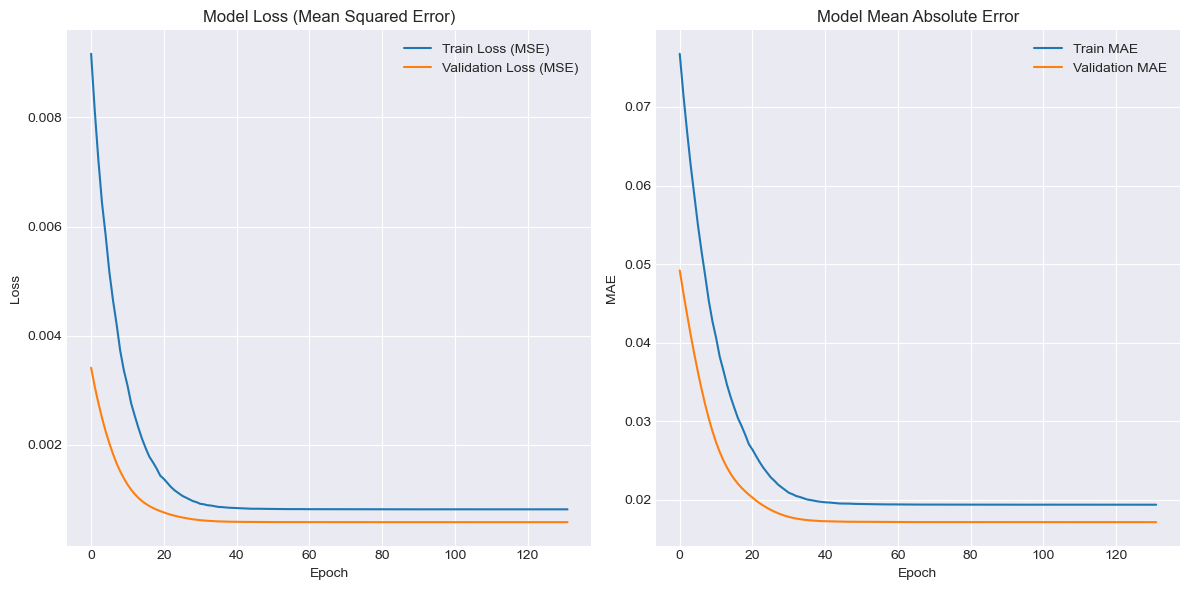

In [14]:
# Explicitly states a Deep Neural Network (DNN) with three layers, including a hidden layer with 10 nodes and ReLU activation (non-linear).
# === Reproducibility Setup: MUST BE AT THE VERY TOP ===
import os
import random # Import Python's standard random module
import numpy as np
import tensorflow as tf

# 1. Set TF Deterministic Operations Environment Variable
#    Needs to be set BEFORE TensorFlow initializes certain components.
print("--- Attempting to set TensorFlow Deterministic Operations ---", flush=True)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
# Optional: For specific TF/GPU/cuDNN versions, might need others:
# os.environ['TF_DISABLE_NVTX_RANGES'] = '1'
# os.environ['TF_CUDNN_DETERMINISTIC'] = '1' # Older flag

# 2. Define the Global Seed Value
SEED = 42 # Choose a fixed integer for your seed
print(f"--- Setting Random Seeds to {SEED} ---", flush=True)

# 3. Set Python Hash Seed Environment Variable
#    Needs to be set before Python interpreter starts using hashes heavily.
os.environ['PYTHONHASHSEED'] = str(SEED)

# 4. Set Python's random module seed
random.seed(SEED)

# 5. Set NumPy seed
np.random.seed(SEED)

# 6. Set TensorFlow seed
tf.random.set_seed(SEED)
# === End Reproducibility Setup ===


import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout # Added Dropout optionally
from tensorflow.keras.callbacks import EarlyStopping, Callback
import os
import joblib
import time
import matplotlib.pyplot as plt

print("--- Script Start: DNN Training for Alpha Strategy (Phase III) ---", flush=True)

# --- Add this section for Reproducibility ---
SEED = 42 # Choose any integer for your seed
print(f"\n--- Setting Random Seeds to {SEED} for Reproducibility ---", flush=True)
os.environ['PYTHONHASHSEED'] = str(SEED) # Set PYTHONHASHSEED environment variable
np.random.seed(SEED)                     # Set seed for NumPy operations
tf.random.set_seed(SEED)                 # Set seed for TensorFlow operations

# --- Configuration ---
PROCESSED_DATA_DIR = "processed_dnn_data_regression" # From Script 2
MODEL_SAVE_PATH = 'dnn_alpha_yield_model.keras'      # Updated name for DNN model
FEATURE_LIST_PATH = os.path.join(PROCESSED_DATA_DIR, 'feature_list.txt')

# Model Hyperparameters (Adjust as needed for regression)
HIDDEN_UNITS = 10                # As per paper Section 3.4
HIDDEN_ACTIVATION = 'relu'       # As per paper Section 3.4
OUTPUT_ACTIVATION = 'linear'     # Standard for regression output
LEARNING_RATE = 0.00001
EPOCHS = 200                     # Adjust as needed
PATIENCE = 20                    # Early stopping patience
BATCH_SIZE = 128
DROPOUT_RATE = 0.3               # Optional: Add dropout for regularization (0 to disable)

# --- Check GPU ---
print("\n--- Checking GPU Availability ---", flush=True)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs found.", flush=True)
    except RuntimeError as e: print(f"GPU Memory Growth Error: {e}", flush=True)
else: print("No GPU detected by TensorFlow.", flush=True)

# --- Define Custom Callback for Epoch Logging ---
class EpochLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"--- Starting Epoch {epoch+1}/{self.params['epochs']} ---", flush=True)
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        log_str = " - ".join([f"{k}: {logs[k]:.5f}" for k in keys]) # Increased precision
        print(f"Epoch {epoch+1}/{self.params['epochs']} completed - {log_str}", flush=True)

# --- 1. Load Processed Data ---
print(f"\n--- Loading processed data from '{PROCESSED_DATA_DIR}'... ---", flush=True)
start_load_time = time.time()
try:
    X_train_scaled = np.load(os.path.join(PROCESSED_DATA_DIR, 'X_train_scaled.npy'))
    # Load CONTINUOUS target variables
    y_train = np.load(os.path.join(PROCESSED_DATA_DIR, 'y_train_continuous.npy'))
    X_val_scaled = np.load(os.path.join(PROCESSED_DATA_DIR, 'X_val_scaled.npy'))
    y_val = np.load(os.path.join(PROCESSED_DATA_DIR, 'y_val_continuous.npy'))
    X_test_scaled = np.load(os.path.join(PROCESSED_DATA_DIR, 'X_test_scaled.npy'))
    y_test = np.load(os.path.join(PROCESSED_DATA_DIR, 'y_test_continuous.npy'))

    # Load feature list to get input shape correctly
    with open(FEATURE_LIST_PATH, 'r') as f:
         feature_names = [line.strip() for line in f if line.strip()]
         n_features = len(feature_names)

    load_time = time.time() - start_load_time
    print(f"Data loaded successfully in {load_time:.2f} seconds.", flush=True)
    print(f"Number of features: {n_features}")
    print(f"Train shapes: X={X_train_scaled.shape}, y={y_train.shape}")
    print(f"Validation shapes: X={X_val_scaled.shape}, y={y_val.shape}")
    print(f"Test shapes: X={X_test_scaled.shape}, y={y_test.shape}")

    # Check for NaNs/Infs in loaded data (as a final safeguard)
    if np.isnan(X_train_scaled).any() or np.isinf(X_train_scaled).any() or \
       np.isnan(y_train).any() or np.isinf(y_train).any():
        print("ERROR: NaNs or Infs found in loaded training data!")
        exit()
    if np.isnan(X_val_scaled).any() or np.isinf(X_val_scaled).any() or \
       np.isnan(y_val).any() or np.isinf(y_val).any():
        print("ERROR: NaNs or Infs found in loaded validation data!")
        exit()
    if np.isnan(X_test_scaled).any() or np.isinf(X_test_scaled).any() or \
       np.isnan(y_test).any() or np.isinf(y_test).any():
        print("ERROR: NaNs or Infs found in loaded test data!")
        exit()


except FileNotFoundError:
    print(f"Error: Processed data files not found in '{PROCESSED_DATA_DIR}'. Please run Script 2 first.", flush=True)
    exit()
except Exception as e:
    print(f"Error loading processed data: {e}", flush=True)
    exit()

# --- 2. Define DNN Model (as per Paper Section 3.4) ---
print("\n--- Defining the DNN model... ---", flush=True)
model = Sequential(name="DNN_Alpha_Yield_Predictor")
model.add(Input(shape=(n_features,), name="Input_Alphas"))
# Hidden Layer (as described in the paper)
model.add(Dense(HIDDEN_UNITS, activation=HIDDEN_ACTIVATION, name="Hidden_Layer_ReLU"))
# Optional: Add Dropout after the hidden layer for regularization
if DROPOUT_RATE > 0:
    model.add(Dropout(DROPOUT_RATE, name="Dropout_Layer"))
# Output Layer (single node for regression)
model.add(Dense(1, activation=OUTPUT_ACTIVATION, name="Output_Yield_Prediction")) # Linear activation for regression

model.summary()

# --- 3. Compile Network with MSE Loss ---
print("\n--- Compiling the model... ---", flush=True)
start_compile_time = time.time()
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer,
              loss='mean_squared_error', # MSE loss for regression
              metrics=['mae', 'mse'])     # Track Mean Absolute Error and MSE
compile_time = time.time() - start_compile_time
print(f"Model compiled successfully in {compile_time:.2f} seconds.", flush=True)

# --- 4. Train Network ---
print("\n--- Starting training (model.fit call)... ---", flush=True)
start_fit_time = time.time()
# Monitor 'val_loss' (which is val_mse) for early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', # Corresponds to val_mean_squared_error
    patience=PATIENCE,
    mode='min',           # Minimize the validation loss
    restore_best_weights=True, # Restore weights from the epoch with the best val_loss
    verbose=1             # Print messages when stopping
)
epoch_logger = EpochLogger()

history = model.fit(
    X_train_scaled, y_train,
    epochs=EPOCHS,
    validation_data=(X_val_scaled, y_val), # Use validation set
    callbacks=[early_stopping, epoch_logger],
    batch_size=BATCH_SIZE,
    verbose=0 # Set to 0 because EpochLogger handles detailed printing
)
fit_time = time.time() - start_fit_time
print(f"\nTraining finished in {fit_time:.2f} seconds.", flush=True)
print(f"Training stopped after {early_stopping.stopped_epoch + 1} epochs (patience={PATIENCE}).")


# --- 5. Evaluate Network ---
print("\n--- Evaluating on Test Data... ---", flush=True)
start_eval_time = time.time()
# Returns loss (MSE), MAE, MSE (again, as defined in metrics)
results = model.evaluate(X_test_scaled, y_test, verbose=0)
eval_time = time.time() - start_eval_time
print(f"Evaluation finished in {eval_time:.2f} seconds.", flush=True)
print(f"  Test Loss (MSE): {results[0]:.6f}")
print(f"  Test MAE:      {results[1]:.6f}")
# Calculate Test RMSE
print(f"  Test RMSE:     {np.sqrt(results[0]):.6f}")


# --- 6. Save Network ---
print(f"\n--- Saving trained model to {MODEL_SAVE_PATH}... ---", flush=True)
model.save(MODEL_SAVE_PATH)
print("Model saved.", flush=True)

# --- 7. Plot Training History (Optional) ---
print("\n--- Plotting Training History... ---", flush=True)
try:
    plt.figure(figsize=(12, 6))

    # Plot training & validation loss values (MSE)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
    plt.title('Model Loss (Mean Squared Error)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Plot training & validation MAE values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model Mean Absolute Error')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    # Save the plot
    plot_save_path = 'dnn_training_history.png'
    plt.savefig(plot_save_path)
    print(f"Training history plot saved to {plot_save_path}")
    # plt.show() # Uncomment to display the plot interactively if running locally

except Exception as e:
    print(f"Could not plot training history: {e}", flush=True)


print("\n--- Script End ---", flush=True)

# Correct Backtesting

In [4]:
# === Reproducibility Setup: MUST BE AT THE VERY TOP ===
import os
import random
import numpy as np
import tensorflow as tf
import pandas as pd
import joblib
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import traceback
import yfinance as yf # Make sure yfinance is imported
from datetime import datetime, timedelta # Added timedelta

# === Add this section to force CPU ===
print("--- Attempting to force CPU usage for maximum determinism ---")
try:
    tf.config.set_visible_devices([], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    if not logical_gpus:
        print("  Successfully disabled GPU visibility. Running on CPU.")
    else:
        print("  Warning: Could not fully disable GPU visibility.")
except Exception as e:
    print(f"  Warning: Error disabling GPU visibility: {e}")
# === End CPU forcing section ===

print("--- Attempting to set TensorFlow Deterministic Operations ---", flush=True)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
SEED = 42
print(f"--- Setting Random Seeds to {SEED} ---", flush=True)
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# === End Reproducibility Setup ===


print("--- Script Start: DNN Strategy Backtesting (Validation/Test, Balanced Metrics Focus) ---", flush=True)
start_time_script = time.time()

# --- Configuration ---
PROCESSED_DATA_DIR = "processed_dnn_data_regression"
MODEL_PATH = 'dnn_alpha_yield_model.keras'
SCALER_PATH = os.path.join(PROCESSED_DATA_DIR, 'scaler.joblib')
FEATURE_LIST_PATH = os.path.join(PROCESSED_DATA_DIR, 'feature_list.txt')
ORIGINAL_DETAILED_CSV = "detailed_data_with_alphas_and_price.csv"

# Dates MUST match Script 2 for correct data alignment
TRAIN_END_DATE = '2023-03-24'
VALIDATION_END_DATE = '2024-03-24'

# <<< GRID SEARCH PARAMETERS (for Validation Set Tuning) >>>
K_VALUES_CANDIDATES = list(range(1, 80))
N_VALUES_CANDIDATES = list(range(1, 40))

UNIVERSE_SIZE_LIMIT = 83
# Metric to RANK candidates on Validation set
VALIDATION_OPTIMIZATION_METRIC = 'Sharpe Ratio' # Use Sharpe to rank initially
# How many top candidates (based on Val Rank) to evaluate on test set?
N_CANDIDATES_TO_TEST = 5
# <<< END GRID SEARCH PARAMETERS >>>

FORWARD_RETURN_PERIOD = 1
RISK_FREE_RATE_ANNUAL = 0.0
TRADING_DAYS_PER_YEAR = 252
ABOVE_TOLERANCE = 1e-9 # Still used for the informational check

# --- Helper Functions (get_trades, calculate_metrics, check_always_above, run_simulation) ---
# Keep these functions exactly as defined previously
def get_trades(latest_scores_dict, current_holdings_set, k, n):
    # ... (Keep implementation) ...
    selected_buys = set(); selected_sells = set()
    if not latest_scores_dict: return selected_buys, selected_sells
    try:
        valid_scores = {stk: scr for stk, scr in latest_scores_dict.items() if pd.notna(scr)}
        if not valid_scores: return selected_buys, selected_sells
        sorted_stocks_with_scores = sorted(valid_scores.items(), key=lambda item: item[1], reverse=True)
        stock_score_map = dict(sorted_stocks_with_scores); ranked_stocks_list = [s[0] for s in sorted_stocks_with_scores]
        target_portfolio = set(ranked_stocks_list[:k])
        required_sells_candidates = current_holdings_set - target_portfolio
        required_sells_ranked = sorted([(s, stock_score_map.get(s, -np.inf)) for s in required_sells_candidates], key=lambda item: item[1]) # Sort sells ascending by score
        required_sells = {s[0] for s in required_sells_ranked}; num_req_sells = len(required_sells)
        required_buys_candidates = target_portfolio - current_holdings_set
        required_buys_ranked = sorted([(s, stock_score_map.get(s, -np.inf)) for s in required_buys_candidates], key=lambda item: item[1], reverse=True) # Sort buys descending by score
        required_buys = {s[0] for s in required_buys_ranked}; num_req_buys = len(required_buys)
        total_required_trades = num_req_sells + num_req_buys
        if total_required_trades <= n:
            selected_sells = required_sells
            selected_buys = required_buys
        else:
            t_count = 0
            # Prioritize sells with lower scores
            for stock, score in required_sells_ranked:
                if t_count < n:
                    selected_sells.add(stock)
                    t_count += 1
                else:
                    break
            # Then prioritize buys with higher scores
            for stock, score in required_buys_ranked:
                if t_count < n:
                    selected_buys.add(stock)
                    t_count += 1
                else:
                    break
    except Exception as e:
        print(f"ERROR in get_trades: {e}"); traceback.print_exc()
        return set(), set()
    return selected_buys, selected_sells

# MODIFIED calculate_metrics function
def calculate_metrics(daily_returns):
    metrics = {
        'Cumulative Return': 0.0, 'Annualized Return': 0.0,
        'Annualized Volatility': 0.0, 'Sharpe Ratio': 0.0,
        'Max Drawdown': 0.0, 'Trading Days': 0, 'Positive Days %': 0.0,
        'Sortino Ratio': 0.0, 'Drawdown Duration (Days)': None, # Added
        'Recovery Time (Days)': None # Added
    }
    if daily_returns is None or not isinstance(daily_returns, pd.Series) or daily_returns.empty or daily_returns.isnull().all():
        return metrics

    daily_returns = daily_returns.dropna()
    if daily_returns.empty:
        return metrics

    n_days = len(daily_returns); metrics['Trading Days'] = n_days
    if n_days < 2: # Need at least 2 days for meaningful metrics
        # Calculate only basic metrics if possible
        if n_days == 1:
            metrics['Cumulative Return'] = daily_returns.iloc[0]
        return metrics # Other metrics require more data

    cumulative_return = (1 + daily_returns).prod() - 1; metrics['Cumulative Return'] = cumulative_return
    n_years = n_days / TRADING_DAYS_PER_YEAR
    if n_years > 1e-6:
        if cumulative_return > -1:
            metrics['Annualized Return'] = (1 + cumulative_return) ** (1 / n_years) - 1
        elif cumulative_return <= -1: # Handle total loss case
             metrics['Annualized Return'] = -1.0
    annualized_volatility = daily_returns.std(ddof=1) * np.sqrt(TRADING_DAYS_PER_YEAR); metrics['Annualized Volatility'] = annualized_volatility if not pd.isna(annualized_volatility) else 0.0
    daily_risk_free = (1 + RISK_FREE_RATE_ANNUAL)**(1/TRADING_DAYS_PER_YEAR) - 1; excess_returns = daily_returns - daily_risk_free
    mean_excess_return = excess_returns.mean(); std_dev_excess_return = excess_returns.std(ddof=1)
    if std_dev_excess_return is not None and not pd.isna(std_dev_excess_return) and std_dev_excess_return > 1e-9:
        sharpe_ratio = (mean_excess_return / std_dev_excess_return) * np.sqrt(TRADING_DAYS_PER_YEAR); metrics['Sharpe Ratio'] = sharpe_ratio if not pd.isna(sharpe_ratio) else 0.0
    else:
        metrics['Sharpe Ratio'] = 0.0

    cumulative_wealth = (1 + daily_returns).cumprod()
    peak = cumulative_wealth.cummax()
    # Ensure peak does not start at 0 if initial returns are negative
    peak.iloc[0] = max(1.0, peak.iloc[0]) # Start peak at least at 1
    peak = peak.cummax() # Recalculate after adjustment

    drawdown = ((cumulative_wealth - peak) / peak).replace([np.inf, -np.inf], np.nan) if not peak.isnull().all() else pd.Series(0.0, index=daily_returns.index)
    max_drawdown = drawdown.min() if not drawdown.empty and drawdown.notna().any() else 0.0
    metrics['Max Drawdown'] = max_drawdown if not pd.isna(max_drawdown) else 0.0

    metrics['Positive Days %'] = (daily_returns > 1e-9).mean() * 100

    negative_excess_returns = excess_returns[excess_returns < 0]
    downside_deviation = negative_excess_returns.std(ddof=1) * np.sqrt(TRADING_DAYS_PER_YEAR)
    if downside_deviation is not None and not pd.isna(downside_deviation) and downside_deviation > 1e-9:
        sortino_ratio = (mean_excess_return * TRADING_DAYS_PER_YEAR) / downside_deviation; metrics['Sortino Ratio'] = sortino_ratio if not pd.isna(sortino_ratio) else 0.0
    else:
        metrics['Sortino Ratio'] = 0.0

    # --- Calculate Drawdown Duration and Recovery Time ---
    if metrics['Max Drawdown'] < -1e-9: # Only calculate if there's a meaningful drawdown
        try:
            max_drawdown_date = drawdown.idxmin()
            # Find the date of the peak *before* the max drawdown occurred
            # The peak value *at* max_drawdown_date is the peak we fell from
            peak_value_at_max_dd = peak.loc[max_drawdown_date]
            # Find the first occurrence of this peak value *before or at* the max drawdown date
            peak_date_before_max_dd = peak.loc[:max_drawdown_date][peak == peak_value_at_max_dd].index[0]

            # Use integer positions for calculating duration in days
            idx_peak_date = daily_returns.index.get_loc(peak_date_before_max_dd)
            idx_max_dd_date = daily_returns.index.get_loc(max_drawdown_date)
            metrics['Drawdown Duration (Days)'] = idx_max_dd_date - idx_peak_date

            # Find recovery date: first date *after* max_drawdown_date where cumulative_wealth > peak_value
            cumulative_wealth_after_dd = cumulative_wealth.loc[max_drawdown_date:]
            recovery_dates = cumulative_wealth_after_dd[cumulative_wealth_after_dd > peak_value_at_max_dd].index
            if not recovery_dates.empty:
                recovery_date = recovery_dates[0]
                idx_recovery_date = daily_returns.index.get_loc(recovery_date)
                metrics['Recovery Time (Days)'] = idx_recovery_date - idx_peak_date # Total time from peak to recovery
            else:
                metrics['Recovery Time (Days)'] = None # Did not recover by the end
        except Exception as dd_err:
            print(f"Warning: Error calculating drawdown duration/recovery: {dd_err}")
            metrics['Drawdown Duration (Days)'] = None
            metrics['Recovery Time (Days)'] = None
    else: # No significant drawdown
        metrics['Drawdown Duration (Days)'] = 0
        metrics['Recovery Time (Days)'] = 0
    # --- End Drawdown/Recovery Calculation ---

    # Cleanup potential NumPy types before returning JSON-like dict
    for key, value in metrics.items():
        if isinstance(value, (np.number)):
            # Convert numpy floats/ints to Python native types
             metrics[key] = value.item() if not pd.isna(value) else None # Ensure NaNs become None
        elif isinstance(value, np.bool_):
             metrics[key] = bool(value)
        elif pd.isna(value): # Convert any remaining Pandas NaNs to None
            metrics[key] = None
        elif isinstance(value, pd.Timestamp): # Handle timestamp if somehow present
            metrics[key] = str(value) # Convert to string or appropriate format

    return metrics

def run_simulation(results_df, k, n, period_name=""):
    # ... (Keep implementation - including returning both daily_returns and metrics) ...
    print(f"--- Running Simulation ({period_name}): k={k}, n={n} ---", flush=True); start_time_sim = time.time()
    current_holdings = set(); portfolio_daily_returns = {}; unique_dates = results_df.index.unique().sort_values()
    if len(unique_dates) < 2:
        print(f"Warning: Not enough unique dates ({len(unique_dates)}) in {period_name} data for simulation (k={k}, n={n}). Skipping.")
        return pd.Series(dtype=np.float64), calculate_metrics(pd.Series(dtype=np.float64))

    for i in range(len(unique_dates) - 1):
        current_date = unique_dates[i]; next_date = unique_dates[i+1]; latest_scores_dict = {}
        try: # Score extraction logic
            daily_data_slice = results_df.loc[current_date]
            # Handle single stock case (returns Series) vs multiple stocks (returns DataFrame)
            if isinstance(daily_data_slice, pd.Series):
                temp_df = daily_data_slice.to_frame().T # Convert Series to DataFrame
                # Handle index name vs column name for stock_id
                if 'stock_id' not in temp_df.columns and temp_df.index.name == 'stock_id':
                     temp_df = temp_df.reset_index()
                elif 'stock_id' not in temp_df.columns and 'stock_id' in daily_data_slice.index: # Check if stock_id is in Series index
                     temp_df = pd.DataFrame([daily_data_slice]) # Create DataFrame from Series
                     if 'stock_id' in daily_data_slice.index.names: # MultiIndex name case
                          temp_df['stock_id'] = daily_data_slice.name[daily_data_slice.index.names.index('stock_id')] # Extract from name tuple
                     elif 'stock_id' in daily_data_slice.index: # Simple index name case
                          temp_df['stock_id'] = daily_data_slice.name # Use Series name if it's the stock_id

                # Extract scores if possible
                if 'stock_id' in temp_df.columns and 'predicted_score' in temp_df.columns:
                    latest_scores_dict = pd.Series(temp_df.predicted_score.values, index=temp_df.stock_id).to_dict()

            elif not daily_data_slice.empty: # DataFrame case
                df_slice = daily_data_slice.copy()
                # Handle index name vs column name
                if 'stock_id' not in df_slice.columns and df_slice.index.name == 'stock_id':
                     df_slice = df_slice.reset_index()
                # Extract scores
                if 'stock_id' in df_slice.columns and 'predicted_score' in df_slice.columns:
                    latest_scores_dict = pd.Series(df_slice.predicted_score.values, index=df_slice.stock_id).to_dict()

        except KeyError: # Handles case where date might be missing entirely
             pass
        except Exception as score_err:
            print(f" ERROR getting scores k={k}, n={n}, date={current_date}: {score_err}"); traceback.print_exc()

        try: # Trade logic
            executed_buys, executed_sells = get_trades(latest_scores_dict, current_holdings, k, n)
        except Exception as trade_err:
            print(f" ERROR get_trades k={k}, n={n}, date={current_date}: {trade_err}"); traceback.print_exc()
            executed_buys, executed_sells = set(), set()

        holdings_after_sell = current_holdings - executed_sells; next_day_holdings = holdings_after_sell.union(executed_buys); daily_return = 0.0

        if next_day_holdings: # Return calculation logic
            try:
                next_day_returns_slice = results_df.loc[next_date]
                # Prepare next_day_df consistently
                if isinstance(next_day_returns_slice, pd.Series):
                    next_day_df = next_day_returns_slice.to_frame().T
                    if 'stock_id' not in next_day_df.columns and next_day_df.index.name == 'stock_id': next_day_df = next_day_df.reset_index()
                    elif 'stock_id' not in next_day_df.columns and 'stock_id' in next_day_returns_slice.index:
                        next_day_df=pd.DataFrame([next_day_returns_slice]);
                        if 'stock_id' in next_day_returns_slice.index.names: next_day_df['stock_id'] = next_day_returns_slice.name[next_day_returns_slice.index.names.index('stock_id')]
                        elif 'stock_id' in next_day_returns_slice.index: next_day_df['stock_id'] = next_day_returns_slice.name

                elif not next_day_returns_slice.empty:
                     next_day_df = next_day_returns_slice.copy()
                     if 'stock_id' not in next_day_df.columns and next_day_df.index.name == 'stock_id': next_day_df = next_day_df.reset_index()
                else: # Handle case where next_date slice is empty
                    next_day_df = pd.DataFrame(columns=['stock_id', 'actual_return'])

                # Calculate return if data exists
                if not next_day_df.empty and 'stock_id' in next_day_df.columns and 'actual_return' in next_day_df.columns:
                    next_day_df['stock_id'] = next_day_df['stock_id'].astype(str); # Ensure string type for isin
                    held_returns = next_day_df[next_day_df['stock_id'].isin(next_day_holdings)]['actual_return']
                    valid_returns = held_returns.dropna()
                    if not valid_returns.empty:
                        daily_return = valid_returns.mean() # Equal weighting
            except KeyError: # Handles case where next_date might be missing
                pass
            except Exception as ret_err:
                print(f"Error calc return k={k}, n={n}, date={next_date}: {ret_err}"); traceback.print_exc()

        portfolio_daily_returns[next_date] = daily_return; current_holdings = next_day_holdings.copy()

    daily_returns_strategy = pd.Series(portfolio_daily_returns).sort_index(); strategy_metrics = calculate_metrics(daily_returns_strategy); sim_time = time.time() - start_time_sim
    print(f"Finished Simulation ({period_name}): k={k}, n={n}. CumReturn: {strategy_metrics.get('Cumulative Return', 0):.2%}, Sharpe: {strategy_metrics.get('Sharpe Ratio', 0):.4f}, Time: {sim_time:.2f}s")
    return daily_returns_strategy, strategy_metrics
# --- End Helper Functions ---


# --- 1. Load Model, Scaler, Features, and Processed Data ---
print("\n--- Loading Model, Scaler, Features, and Processed Data ---", flush=True)
try:
    model = tf.keras.models.load_model(MODEL_PATH)
    scaler = joblib.load(SCALER_PATH)
    with open(FEATURE_LIST_PATH, 'r') as f:
         feature_names = [line.strip() for line in f if line.strip()]
         n_features = len(feature_names)
    X_val_scaled = np.load(os.path.join(PROCESSED_DATA_DIR, 'X_val_scaled.npy'))
    X_test_scaled = np.load(os.path.join(PROCESSED_DATA_DIR, 'X_test_scaled.npy'))
    y_val = np.load(os.path.join(PROCESSED_DATA_DIR, 'y_val_continuous.npy'))
    y_test = np.load(os.path.join(PROCESSED_DATA_DIR, 'y_test_continuous.npy'))
    print("Model, scaler, features list, X_val/test_scaled, y_val/test loaded.")
    # Validation checks
    if X_val_scaled.shape[1] != n_features or X_test_scaled.shape[1] != n_features:
        raise ValueError("Feature count mismatch between loaded features and data arrays.")
    if X_val_scaled.shape[0] != y_val.shape[0] or X_test_scaled.shape[0] != y_test.shape[0]:
        raise ValueError("Length mismatch between feature arrays (X) and target arrays (y).")
except Exception as e:
    print(f"Error loading components: {e}"); traceback.print_exc(); exit()

# --- 2. Reconstruct Validation and Test Data Context ---
print("\n--- Reconstructing Validation and Test Data Context ---", flush=True)
validation_results_df = None; test_results_df = None
try:
    data_full = pd.read_csv(ORIGINAL_DETAILED_CSV, parse_dates=['Date'])
    data_full = data_full.sort_values(by=['stock_id', 'Date'])
    # Check required columns exist
    if not all(f in data_full.columns for f in feature_names): raise ValueError("Original CSV missing required feature columns.")
    if 'price' not in data_full.columns: raise ValueError("Original CSV missing 'price' column.")
    if 'stock_id' not in data_full.columns: raise ValueError("Original CSV missing 'stock_id' column.")

    # Calculate forward returns needed for alignment
    data_full[f'price_t+{FORWARD_RETURN_PERIOD}'] = data_full.groupby('stock_id')['price'].shift(-FORWARD_RETURN_PERIOD)
    data_full['forward_return_temp'] = np.where(data_full['price'] > 1e-9, (data_full[f'price_t+{FORWARD_RETURN_PERIOD}'] / data_full['price']) - 1, np.nan)
    data_full.replace([np.inf, -np.inf], np.nan, inplace=True) # Replace infinities from division

    # Find valid indices (where all features AND the forward return are non-NaN)
    cols_to_check_for_nan = feature_names + ['forward_return_temp']
    valid_indices = data_full.dropna(subset=cols_to_check_for_nan).index

    # Split valid indices based on dates
    train_end_dt = pd.to_datetime(TRAIN_END_DATE); val_end_dt = pd.to_datetime(VALIDATION_END_DATE)
    val_indices_mask = (data_full.loc[valid_indices, 'Date'] > train_end_dt) & (data_full.loc[valid_indices, 'Date'] <= val_end_dt)
    test_indices_mask = data_full.loc[valid_indices, 'Date'] > val_end_dt
    val_indices = valid_indices[val_indices_mask]; test_indices = valid_indices[test_indices_mask]

    print(f"Initial context indices: Val={len(val_indices)}, Test={len(test_indices)}")
    print(f"Loaded target arrays: y_val={len(y_val)}, y_test={len(y_test)}")

    # Alignment check and adjustment (handle potential slight mismatches at boundaries)
    if len(val_indices) != len(y_val):
        print(f"Warning: Aligning val_indices ({len(val_indices)}) vs y_val ({len(y_val)}).")
        if len(val_indices) > len(y_val):
             val_indices = val_indices[-len(y_val):] # Assume extra rows are at the start
        else:
             raise ValueError(f"Cannot align validation indices: Context ({len(val_indices)}) < Target ({len(y_val)}). Check data prep/split.")
    if len(test_indices) != len(y_test):
        print(f"Warning: Aligning test_indices ({len(test_indices)}) vs y_test ({len(y_test)}).")
        if len(test_indices) > len(y_test):
            test_indices = test_indices[-len(y_test):] # Assume extra rows are at the start
        else:
            raise ValueError(f"Cannot align test indices: Context ({len(test_indices)}) < Target ({len(y_test)}). Check data prep/split.")

    # Create final context dataframes
    validation_context = data_full.loc[val_indices, ['Date', 'stock_id']].copy()
    test_context = data_full.loc[test_indices, ['Date', 'stock_id']].copy()
    validation_context.reset_index(drop=True, inplace=True); test_context.reset_index(drop=True, inplace=True)
    print(f"Validation context reconstructed. Shape: {validation_context.shape}")
    print(f"Test context reconstructed. Shape: {test_context.shape}")
except Exception as e:
    print(f"Error reconstructing context: {e}\n{traceback.format_exc()}"); exit()

# --- 3. Generate Predictions on Validation and Test Data ---
print("\n--- Generating Predictions on Validation and Test Data ---", flush=True)
try:
    validation_predictions = model.predict(X_val_scaled).flatten()
    test_predictions = model.predict(X_test_scaled).flatten()
    print(f"Predictions generated: Val={validation_predictions.shape}, Test={test_predictions.shape}")
    # Check prediction lengths match context lengths
    if len(validation_predictions) != len(validation_context) or len(test_predictions) != len(test_context):
         raise ValueError("Length mismatch between predictions and reconstructed context.")
    if len(validation_predictions) != len(y_val) or len(test_predictions) != len(y_test):
        raise ValueError("Length mismatch between predictions and target arrays (y).")
except Exception as e:
    print(f"Error during prediction: {e}"); exit()

# --- 4. Combine Context, Predictions, and Actual Returns ---
print("\n--- Combining Context, Predictions, and Actual Returns ---", flush=True)
# Validation DataFrame
validation_results_df = validation_context.copy()
validation_results_df['predicted_score'] = validation_predictions
validation_results_df['actual_return'] = y_val # Use loaded y_val
validation_results_df = validation_results_df.sort_values(by=['Date', 'stock_id'])
validation_results_df = validation_results_df.set_index('Date') # Set Date as index for simulation
validation_unique_dates = validation_results_df.index.unique().sort_values()
print(f"Validation data prepared. Dates: {validation_unique_dates.min().date()} to {validation_unique_dates.max().date()}")

# Test DataFrame
test_results_df = test_context.copy()
test_results_df['predicted_score'] = test_predictions
test_results_df['actual_return'] = y_test # Use loaded y_test
test_results_df = test_results_df.sort_values(by=['Date', 'stock_id'])
test_results_df = test_results_df.set_index('Date') # Set Date as index for simulation
test_unique_dates = test_results_df.index.unique().sort_values()
print(f"Test data prepared. Dates: {test_unique_dates.min().date()} to {test_unique_dates.max().date()}")

# --- 5. Calculate Benchmark Returns (Hang Seng Index ^HSI) --- MODIFIED
print("\n--- Calculating Benchmark Returns (Hang Seng Index: ^HSI) ---", flush=True)
val_benchmark_daily_returns = None; test_benchmark_daily_returns = None
val_benchmark_metrics = {}; test_benchmark_metrics = {}
val_benchmark_cumulative = None; test_benchmark_cumulative = None
try:
    # Use the actual date ranges from the prepared simulation dataframes
    # Fetch slightly wider range to ensure alignment is possible
    hsi_start_date = validation_unique_dates.min()
    hsi_end_date = test_unique_dates.max()

    print(f"Downloading ^HSI data from {hsi_start_date.date()} to {hsi_end_date.date()}...")
    hsi_data = yf.download('^HSI', start=hsi_start_date, end=hsi_end_date, auto_adjust=True, progress=False)

    if hsi_data.empty:
        print("WARNING: Could not download ^HSI data. Benchmark calculations will be skipped.")
    else:
        hsi_data['daily_return'] = hsi_data['Close'].pct_change()
        hsi_daily_returns_raw = hsi_data['daily_return'] # Keep NaNs for now

        # Ensure timezone naive for comparison
        if hsi_daily_returns_raw.index.tz is not None:
            hsi_daily_returns_raw.index = hsi_daily_returns_raw.index.tz_localize(None)

        # --- ALIGNMENT USING REINDEX and FFILL ---
        print("Aligning benchmark returns to strategy dates...")
        # Align Validation Benchmark
        val_benchmark_daily_returns = hsi_daily_returns_raw.reindex(validation_unique_dates).ffill().dropna()
        # Align Test Benchmark
        test_benchmark_daily_returns = hsi_daily_returns_raw.reindex(test_unique_dates).ffill().dropna()
        # --- END ALIGNMENT ---


        print("\n--- Calculating HSI Benchmark Metrics (Validation Period) ---")
        val_benchmark_metrics = calculate_metrics(val_benchmark_daily_returns)
        val_benchmark_cumulative = (1 + val_benchmark_daily_returns.fillna(0)).cumprod() if not val_benchmark_daily_returns.empty else pd.Series(dtype=float)
        print("Validation HSI Benchmark Performance:")
        [print(f"  - {metric}: {value:.4f}" if isinstance(value,(float, np.floating)) else f"  - {metric}: {value}") for metric, value in val_benchmark_metrics.items()]

        print("\n--- Calculating HSI Benchmark Metrics (Test Period) ---")
        test_benchmark_metrics = calculate_metrics(test_benchmark_daily_returns)
        test_benchmark_cumulative = (1 + test_benchmark_daily_returns.fillna(0)).cumprod() if not test_benchmark_daily_returns.empty else pd.Series(dtype=float)
        print("Test HSI Benchmark Performance:")
        [print(f"  - {metric}: {value:.4f}" if isinstance(value,(float, np.floating)) else f"  - {metric}: {value}") for metric, value in test_benchmark_metrics.items()]
except Exception as e:
    print(f"ERROR calculating HSI benchmark returns: {e}"); traceback.print_exc()
    # Reset benchmark variables if error occurs
    val_benchmark_metrics = {}; test_benchmark_metrics = {}
    val_benchmark_cumulative = None; test_benchmark_cumulative = None

# --- 6. Grid Search Simulation Loop (On VALIDATION Dataset) ---
print(f"\n--- Starting Grid Search (Top-k / Drop-n on VALIDATION SET) ---", flush=True)
validation_run_results = [] # Store results
start_grid_time = time.time()

for k in K_VALUES_CANDIDATES:
    # Optional: Check if k is valid relative to the potential number of stocks on a given day
    # This requires knowing the typical universe size per day, difficult without running first.
    # if not (1 <= k <= UNIVERSE_SIZE_LIMIT): continue
    for n in N_VALUES_CANDIDATES:
        # Optional: Add check if n makes sense relative to k (e.g., n <= 2*k?)
        # if not (1 <= n <= UNIVERSE_SIZE_LIMIT): continue

        # Run simulation for (k, n) on VALIDATION data
        _, strategy_metrics_val = run_simulation(
            validation_results_df, k, n, period_name="Validation"
        )

        # Store metrics results
        current_run_result = {'k': k, 'n': n}
        current_run_result.update(strategy_metrics_val)
        validation_run_results.append(current_run_result)

grid_time = time.time() - start_grid_time
print(f"\n--- Grid Search on Validation Set Complete ({grid_time/60:.2f} minutes) ---")


# --- 7. Select Top N Candidates based on Validation Performance ---
print(f"\n--- Selecting Top N Candidates based on '{VALIDATION_OPTIMIZATION_METRIC}' on Validation Set ---", flush=True)
# N_CANDIDATES_TO_TEST = 5 # Defined earlier
best_k_val = None; best_n_val = None; best_val_metrics = None
top_n_validation_candidates = []

if not validation_run_results:
    print("ERROR: No results generated from the validation grid search.")
else:
    results_val_metrics_df = pd.DataFrame(validation_run_results)
    # Handle potential non-numeric or inf values before sorting/dropping
    results_val_metrics_df[VALIDATION_OPTIMIZATION_METRIC] = pd.to_numeric(results_val_metrics_df[VALIDATION_OPTIMIZATION_METRIC], errors='coerce')
    results_val_metrics_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    results_val_metrics_df.dropna(subset=[VALIDATION_OPTIMIZATION_METRIC], inplace=True) # Drop rows where the metric is NaN
    results_val_metrics_df.sort_values(by=VALIDATION_OPTIMIZATION_METRIC, ascending=False, inplace=True)

    if results_val_metrics_df.empty:
        print(f"ERROR: No valid candidates remaining after dropping NaN {VALIDATION_OPTIMIZATION_METRIC} values.")
    else:
        num_to_select = min(N_CANDIDATES_TO_TEST, len(results_val_metrics_df))
        print(f"Selecting Top {num_to_select} candidates (based on Validation {VALIDATION_OPTIMIZATION_METRIC}) for test set evaluation.")
        for i in range(num_to_select):
            row = results_val_metrics_df.iloc[i]
            k_cand = int(row['k']); n_cand = int(row['n']); metrics_cand = row.to_dict()
            top_n_validation_candidates.append({'k': k_cand, 'n': n_cand, 'val_metrics': metrics_cand})
            if i == 0: # Store the absolute best based on validation ranking
                best_k_val = k_cand; best_n_val = n_cand; best_val_metrics = metrics_cand
        print(f"\nTop {num_to_select} Validation Candidates (Ranked by {VALIDATION_OPTIMIZATION_METRIC}):")
        # Select specific columns for clearer display - ADDED NEW METRICS
        cols_to_display = [
            'k', 'n', 'Cumulative Return', 'Sharpe Ratio', 'Max Drawdown',
            'Sortino Ratio', 'Positive Days %',
            'Drawdown Duration (Days)', 'Recovery Time (Days)' # Added here
        ]
        existing_cols_display = [col for col in cols_to_display if col in results_val_metrics_df.columns]
        top_n_df_display = results_val_metrics_df[existing_cols_display].head(num_to_select)
        # Format new metrics as integers or keep float if needed (None will show as NaN)
        if 'Drawdown Duration (Days)' in top_n_df_display:
            top_n_df_display['Drawdown Duration (Days)'] = top_n_df_display['Drawdown Duration (Days)'].astype('Int64') # Use nullable Int
        if 'Recovery Time (Days)' in top_n_df_display:
             top_n_df_display['Recovery Time (Days)'] = top_n_df_display['Recovery Time (Days)'].astype('Int64') # Use nullable Int

        print(top_n_df_display.to_string())


# --- 8. Evaluate the TOP N (k, n) Candidates on the TEST Set ---
print(f"\n--- Evaluating Top {len(top_n_validation_candidates)} Selected Candidates on TEST SET ---", flush=True)
test_set_results = [] # Store results including daily returns for plotting
if not top_n_validation_candidates:
    print("Skipping test set evaluation as no candidates were selected from validation.")
else:
     for candidate in top_n_validation_candidates:
         k_test = candidate['k']; n_test = candidate['n']
         print(f"\n--- Running Test Simulation for k={k_test}, n={n_test} ---")
         # Run simulation on TEST data
         test_daily_returns, test_metrics = run_simulation(
             test_results_df, k_test, n_test, period_name=f"Test (k={k_test}, n={n_test})"
         )

         # Store detailed results
         test_set_results.append({
             'k': k_test, 'n': n_test,
             'test_metrics': test_metrics, # Dictionary of test metrics
             'test_daily_returns': test_daily_returns, # Series of daily returns
             'validation_metrics': candidate['val_metrics'] # Dictionary of validation metrics
         })

# --- 9. Final Reporting (Comparing Top N Candidates vs HSI) ---
print("\n\n--- === FINAL PERFORMANCE REPORT === ---")

# Print Benchmark Performance again for easy comparison
print("\n--- Validation Set Benchmark Performance (HSI: ^HSI) ---")
if val_benchmark_metrics: [print(f"  - {metric}: {value:.4f}" if isinstance(value,(float, np.floating)) else f"  - {metric}: {value}") for metric, value in val_benchmark_metrics.items()]
else: print("  (Benchmark data not available)")

print("\n--- Test Set Benchmark Performance (HSI: ^HSI) ---")
if test_benchmark_metrics: [print(f"  - {metric}: {value:.4f}" if isinstance(value,(float, np.floating)) else f"  - {metric}: {value}") for metric, value in test_benchmark_metrics.items()]
else: print("  (Benchmark data not available)")


print(f"\n--- Test Set Performance Comparison for Top {len(test_set_results)} Validation Candidate(s) (Ranked by Validation {VALIDATION_OPTIMIZATION_METRIC}) ---")
if not test_set_results:
    print("  No test set results available.")
else:
    report_data = []
    for i, result in enumerate(test_set_results):
        # Safely get metrics using .get() with default NaN
        row = {
            'Rank (Val)': i + 1,
            'k': result['k'], 'n': result['n'],
            'Val Sharpe': result['validation_metrics'].get('Sharpe Ratio', np.nan),
            'Val CumRet': result['validation_metrics'].get('Cumulative Return', np.nan),
            'Val MaxDrawdown': result['validation_metrics'].get('Max Drawdown', np.nan),
            # --- Added Validation Drawdown/Recovery ---
            'Val DD Dur (d)': result['validation_metrics'].get('Drawdown Duration (Days)', None), # Use None as default for Int64 later
            'Val Rec Time (d)': result['validation_metrics'].get('Recovery Time (Days)', None), # Use None as default for Int64 later
            # --- Test Metrics ---
            'Test Sharpe': result['test_metrics'].get('Sharpe Ratio', np.nan),
            'Test CumRet': result['test_metrics'].get('Cumulative Return', np.nan),
            'Test MaxDrawdown': result['test_metrics'].get('Max Drawdown', np.nan),
            'Test Sortino': result['test_metrics'].get('Sortino Ratio', np.nan),
            # --- Added Test Drawdown/Recovery ---
            'Test DD Dur (d)': result['test_metrics'].get('Drawdown Duration (Days)', None), # Use None as default for Int64 later
            'Test Rec Time (d)': result['test_metrics'].get('Recovery Time (Days)', None), # Use None as default for Int64 later
            # --- Other Test Metrics ---
            'Test WinRate(%)': result['test_metrics'].get('Positive Days %', np.nan),
            'Test AnnVol': result['test_metrics'].get('Annualized Volatility', np.nan),
        }
        report_data.append(row)

    report_df = pd.DataFrame(report_data)

    # Formatting for display
    pd.set_option('display.max_columns', None); pd.set_option('display.width', 1200); # Increased width
    # Define formats
    float_formats = {
        'Val Sharpe': '{:.4f}', 'Val CumRet': '{:+.2%}', 'Val MaxDrawdown': '{:+.2%}',
        'Test Sharpe': '{:.4f}', 'Test CumRet': '{:+.2%}', 'Test MaxDrawdown': '{:+.2%}',
        'Test Sortino': '{:.4f}', 'Test WinRate(%)': '{:.1f}%', 'Test AnnVol': '{:.2%}'
    }
    int_cols = ['k', 'n', 'Val DD Dur (d)', 'Val Rec Time (d)', 'Test DD Dur (d)', 'Test Rec Time (d)']
    for col in report_df.columns:
        if col in float_formats:
            report_df[col] = report_df[col].map(lambda x: float_formats[col].format(x) if pd.notna(x) else 'N/A')
        elif col in int_cols:
            # Convert to nullable integer type AFTER creation, format N/A for None/NaN
            report_df[col] = report_df[col].astype('Int64').map(lambda x: f"{x:,}" if pd.notna(x) else 'N/A')

    print(report_df.to_string(index=False)) # Display the full table

    # Final Assessment Text
    print("\n--- Final Assessment & Recommendation (vs HSI Benchmark) ---")
    if not report_df.empty and test_set_results: # Ensure test_set_results is also not empty
        # Refer to the #1 candidate based on the validation ranking
        print(f"  Candidate k={test_set_results[0]['k']}, n={test_set_results[0]['n']} ranked #1 on Validation based on '{VALIDATION_OPTIMIZATION_METRIC}'.")
        print("\n  Recommendation:")
        print("  -> Review the FULL Test Set performance metrics in the table above for the Top N candidates compared to the HSI ^HSI benchmark.")
        print("  -> Assess the BALANCE between Test Sharpe, Test Sortino, Test Max Drawdown, Test CumRet, Test Volatility, Drawdown Duration, and Recovery Time.") # Added DD/Rec Time
        print("  -> Select the candidate (k, n) that provides the most desirable overall profile on the Test Set.")

        # Compare #1 validation candidate's test sharpe vs benchmark test sharpe
        top_cand_test_metrics = test_set_results[0]['test_metrics']
        top_cand_sharpe = top_cand_test_metrics.get('Sharpe Ratio', -np.inf) # Use get for safety
        bench_test_sharpe = test_benchmark_metrics.get('Sharpe Ratio', -np.inf) if test_benchmark_metrics else -np.inf

        if bench_test_sharpe != -np.inf and not pd.isna(top_cand_sharpe) and top_cand_sharpe > bench_test_sharpe :
             print(f"     * Note: The #1 Validation Candidate (k={test_set_results[0]['k']}, n={test_set_results[0]['n']}) achieved a higher Test Sharpe Ratio ({top_cand_sharpe:.4f}) than the HSI benchmark ({bench_test_sharpe:.4f}).")
        elif pd.isna(top_cand_sharpe):
             print(f"     * Note: The #1 Validation Candidate (k={test_set_results[0]['k']}, n={test_set_results[0]['n']}) Test Sharpe Ratio is N/A.")
        else:
             print(f"     * Note: The #1 Validation Candidate (k={test_set_results[0]['k']}, n={test_set_results[0]['n']}) did NOT achieve a higher Test Sharpe Ratio ({top_cand_sharpe:.4f}) than the HSI benchmark ({bench_test_sharpe:.4f}).")
    else:
        print("  Unable to provide specific recommendations as no candidates were successfully evaluated on the test set.")


# --- 10. Plot Final Cumulative Returns on TEST Set (Plot #1 Validation Candidate vs HSI) ---
print("\n--- Plotting #1 Ranked Validation Candidate vs HSI Benchmark on TEST Period ---", flush=True)
if test_set_results: # Check if there are any results
    result_to_plot = test_set_results[0] # Get the first result (ranked #1 on validation)
    k_plot = result_to_plot['k']; n_plot = result_to_plot['n']
    daily_returns_plot = result_to_plot['test_daily_returns']

    # Ensure benchmark data is available for plotting comparison
    benchmark_cumulative_to_plot = test_benchmark_cumulative
    benchmark_label = "Hang Seng Index (^HSI) Benchmark"

    # Check if both strategy returns and benchmark data are valid
    plot_condition = (
        daily_returns_plot is not None and not daily_returns_plot.empty and
        benchmark_cumulative_to_plot is not None and not benchmark_cumulative_to_plot.empty
    )

    if plot_condition:
        # Align indices for accurate plotting
        common_index = daily_returns_plot.index.intersection(benchmark_cumulative_to_plot.index)
        if len(common_index) > 1: # Need more than one point to plot
            strategy_returns_aligned = daily_returns_plot.loc[common_index]
            benchmark_cumulative_aligned = benchmark_cumulative_to_plot.loc[common_index]
            strategy_cumulative_final = (1 + strategy_returns_aligned.fillna(0)).cumprod() # Calculate cumulative return

            try:
                plt.style.use('seaborn-v0_8-darkgrid')
                fig, ax = plt.subplots(figsize=(14, 8))

                line_color = 'darkgreen' # Strategy line color
                # Plot strategy cumulative return
                ax.plot(strategy_cumulative_final.index, strategy_cumulative_final,
                        label=f'#1 Val Candidate (k={k_plot}, n={n_plot}) on Test Set',
                        linewidth=2.5, color=line_color, zorder=10)
                # Plot benchmark cumulative return
                ax.plot(benchmark_cumulative_aligned.index, benchmark_cumulative_aligned,
                        label=benchmark_label, linestyle='--', linewidth=2, color='darkblue', zorder=5)

                # Formatting and Labels
                start_date_str = common_index.min().strftime('%Y-%m-%d')
                end_date_str = common_index.max().strftime('%Y-%m-%d')
                plot_title = f'#1 Val Candidate (Ranked by {VALIDATION_OPTIMIZATION_METRIC}) - TEST SET \nTest Period: {start_date_str} to {end_date_str}'

                ax.set_title(plot_title, fontsize=14, pad=15)
                ax.set_ylabel('Cumulative Return (Log Scale)', fontsize=13, labelpad=10)
                ax.set_xlabel('Date', fontsize=13, labelpad=10)
                ax.set_yscale('log') # Use log scale for better visualization of long term growth
                ax.legend(loc='best', fontsize=11, frameon=True, framealpha=0.9)
                # Format Y-axis as percentage return relative to start (1 means 0% change)
                ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{y-1:+.1%}'))
                ax.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.7)
                ax.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
                plt.xticks(rotation=30, ha='right')
                plt.tight_layout()

                # Save the plot
                plot_save_path = f'dnn_backtest_TEST_SET_Top1ValMetric_k{k_plot}_n{n_plot}_cumulative_return_log.png'
                plt.savefig(plot_save_path, dpi=150)
                print(f"Test set cumulative return plot saved to {plot_save_path}")
                plt.close(fig) # Close the figure after saving

            except Exception as e:
                print(f"Error during plotting: {e}"); traceback.print_exc()
        else:
            print("Skipping plot: Not enough overlapping data points between #1 strategy and HSI benchmark on test set.")
    else:
        print("Skipping plot: Data missing for #1 validation candidate or HSI benchmark on test set.")
else:
    print("Skipping plot: No candidates selected from validation to plot.")


# --- Script End Timing ---
end_time_script = time.time()
print(f"\n--- Script End --- (Total Execution Time: {(end_time_script - start_time_script)/60:.2f} minutes)", flush=True)

--- Attempting to force CPU usage for maximum determinism ---
  Successfully disabled GPU visibility. Running on CPU.
--- Attempting to set TensorFlow Deterministic Operations ---
--- Setting Random Seeds to 42 ---
--- Script Start: DNN Strategy Backtesting (Validation/Test, Balanced Metrics Focus) ---

--- Loading Model, Scaler, Features, and Processed Data ---
Model, scaler, features list, X_val/test_scaled, y_val/test loaded.

--- Reconstructing Validation and Test Data Context ---
Initial context indices: Val=20252, Test=20086
Loaded target arrays: y_val=20252, y_test=20086
Validation context reconstructed. Shape: (20252, 2)
Test context reconstructed. Shape: (20086, 2)

--- Generating Predictions on Validation and Test Data ---
633/633 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step


2025-05-01 02:44:23.301392: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-01 02:44:23.302103: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

628/628 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
Predictions generated: Val=(20252,), Test=(20086,)

--- Combining Context, Predictions, and Actual Returns ---
Validation data prepared. Dates: 2023-03-27 to 2024-03-22
Test data prepared. Dates: 2024-03-25 to 2025-03-20

--- Calculating Benchmark Returns (Hang Seng Index: ^HSI) ---
Aligning benchmark returns to strategy dates...

--- Calculating HSI Benchmark Metrics (Validation Period) ---
Validation HSI Benchmark Performance:
  - Cumulative Return: -0.1568
  - Annualized Return: -0.1621
  - Annualized Volatility: 0.2242
  - Sharpe Ratio: -0.6771
  - Max Drawdown: -0.2801
  - Trading Days: 243
  - Positive Days %: 46.5021
  - Sortino Ratio: -1.2256
  - Drawdown Duration (Days): 189
  - Recovery Time (Days): None

--- Calculating HSI Benchmark Metrics (Test Period) ---
Test HSI Benchmark Performance:
  - Cumulative Return: 0.5032
  - Annualized Return: 0.5287
  - Annualized Volatility: 0.2544
  - Sharpe Ratio: 1.7971
  - Max Drawdown: -0.1829

# Analysis on the final performance report (of the selection of k and n)

In [5]:
import pandas as pd
import numpy as np

# --- Configuration & Function Definitions ---
# Ensure run_simulation, calculate_metrics are defined
N_INITIAL_SELECTION = 5
RANKING_METRICS_VAL = { # Using corrected keys
    'Sharpe Ratio': {'ascending': False},
    'Sortino Ratio': {'ascending': False},
    'Max Drawdown': {'ascending': False},
    'Annualized Volatility': {'ascending': True}
}

# --- Load/Check Required Data ---
# ... (Checks for results_val_metrics_df, test_results_df, run_simulation, calculate_metrics) ...
# ... (Assume checks pass and data is loaded) ...
# --- Assume val_benchmark_metrics and test_benchmark_metrics are loaded ---
if 'results_val_metrics_df' not in globals() or results_val_metrics_df.empty: print("ERROR: results_val_metrics_df missing/empty."); exit()
if 'test_results_df' not in globals() or test_results_df.empty: print("ERROR: test_results_df missing/empty."); exit()
if 'run_simulation' not in globals() or not callable(run_simulation): print("ERROR: run_simulation function missing."); exit()
if 'calculate_metrics' not in globals() or not callable(calculate_metrics): print("ERROR: calculate_metrics function missing."); exit()
if 'val_benchmark_metrics' not in globals() or not val_benchmark_metrics: print("WARNING: val_benchmark_metrics missing/empty."); val_benchmark_metrics={}
if 'test_benchmark_metrics' not in globals() or not test_benchmark_metrics: print("WARNING: test_benchmark_metrics missing/empty."); test_benchmark_metrics={}


# --- Step 1: Select Top N by Validation Sharpe ---
# ... (Code to select top_n_sharpe_df) ...
# --- Assume top_n_sharpe_df is successfully created ---
top_n_sharpe_df = pd.DataFrame() # Placeholder, replace with actual selection code
if 'Sharpe Ratio' in results_val_metrics_df.columns:
    results_to_select_from = results_val_metrics_df.dropna(subset=['Sharpe Ratio']).copy()
    sorted_by_sharpe = results_to_select_from.sort_values(by='Sharpe Ratio', ascending=False)
    actual_n_selected = min(N_INITIAL_SELECTION, len(sorted_by_sharpe))
    if actual_n_selected > 0:
        top_n_sharpe_df = sorted_by_sharpe.head(actual_n_selected).copy()
        print(f"\nSelected Top {len(top_n_sharpe_df)} candidates by Val Sharpe.")
    else: print(f"Could not select Top {N_INITIAL_SELECTION}."); exit()
else: print("ERROR: 'Sharpe Ratio' column missing."); exit()


# --- Step 2: Rank Candidates Within Top N Group ---
# ... (Code to rank and calculate 'Average Rank (Top N)') ...
# --- Assume top_n_ranked_avg_rank is created ---
rank_cols_top_n = []
metrics_used_for_ranking = []
if not top_n_sharpe_df.empty:
    for metric, config in RANKING_METRICS_VAL.items():
        if metric in top_n_sharpe_df.columns:
            if top_n_sharpe_df[metric].dropna().nunique() > 1:
                rank_col_name = f"Val_{metric}_Rank"
                top_n_sharpe_df[rank_col_name] = top_n_sharpe_df[metric].rank(
                    ascending=config['ascending'], method='average', na_option='bottom'
                )
                rank_cols_top_n.append(rank_col_name)
                metrics_used_for_ranking.append(metric)
    if rank_cols_top_n:
        top_n_sharpe_df['Average Rank (Top N)'] = top_n_sharpe_df[rank_cols_top_n].mean(axis=1)
        top_n_ranked_avg_rank = top_n_sharpe_df.sort_values(by='Average Rank (Top N)', ascending=True).copy()
        print("\nRanking within Top N complete.")
    else:
        print("ERROR: No ranks calculated within Top N."); exit()
else: print("ERROR: Top N Sharpe DF is empty."); exit()


# --- Step 3: Select the SINGLE BEST Candidate ---
# ... (Code to select best_k_final, best_n_final, best_avg_rank_final, best_val_metrics_selected_rank) ...
if top_n_ranked_avg_rank.empty: print("ERROR: Cannot select best candidate, ranked list is empty."); exit()
best_candidate_final_row = top_n_ranked_avg_rank.iloc[0]
best_k_final = int(best_candidate_final_row['k'])
best_n_final = int(best_candidate_final_row['n'])
best_avg_rank_final = best_candidate_final_row['Average Rank (Top N)']
best_val_metrics_selected_rank = best_candidate_final_row.to_dict()
print(f"\nSelected Candidate: k={best_k_final}, n={best_n_final} (Avg Rank: {best_avg_rank_final:.2f})")

# --- Step 4: Evaluate the Selected Candidate on the TEST Set ---
print("\n--- Step 4: Evaluating Final Selected Candidate (k={}, n={}) on Test Set ---".format(best_k_final, best_n_final))
test_daily_returns_final = None
test_metrics_final = {}
try:
    test_daily_returns_final, test_metrics_final = run_simulation(
        test_results_df, best_k_final, best_n_final,
        period_name=f"Test (k={best_k_final}, n={best_n_final})"
    )
    if not test_metrics_final: print("WARNING: Test simulation ran, but no metrics were calculated.")
except Exception as e: print(f"ERROR during test simulation: {e}"); traceback.print_exc()


# --- Step 5: Final Report and Comparison ---
print("\n--- Step 5: Final Report (Rank Avg within Top N Method) ---")

print("\n--- Selected Strategy Performance Summary ---")
print(f"Strategy Chosen: k={best_k_final}, n={best_n_final}")
print(f"Selection Basis: Lowest average rank ({best_avg_rank_final:.2f}) across validation metrics ({metrics_used_for_ranking}) among Top {len(top_n_sharpe_df)} Sharpe candidates.")

# Define key metrics for concise report
key_report_metrics = ['Sharpe Ratio', 'Sortino Ratio', 'Cumulative Return', 'Max Drawdown', 'Annualized Volatility', 'Drawdown Duration (Days)', 'Recovery Time (Days)', 'Positive Days %']

print("\nKey Validation Metrics (Selected Candidate):")
pd.set_option('display.float_format', '{:.4f}'.format)
for metric in key_report_metrics:
    value = best_val_metrics_selected_rank.get(metric)
    if value is None: print(f"  - Val {metric}: N/A")
    elif isinstance(value, (float, np.floating)): print(f"  - Val {metric}: {value:.4f}")
    else: print(f"  - Val {metric}: {value}")

# <<< --- START: ADDED VALIDATION COMPARISON SECTION --- >>>
print("\n--- Benchmark Performance Comparison (Validation Period: HSI ^HSI) ---")
if val_benchmark_metrics:
     # Print benchmark metrics first for reference
     print("Benchmark Validation Metrics:")
     for metric in key_report_metrics:
          value = val_benchmark_metrics.get(metric)
          if value is None: print(f"  - Val BM {metric}: N/A")
          elif isinstance(value, (float, np.floating)): print(f"  - Val BM {metric}: {value:.4f}")
          else: print(f"  - Val BM {metric}: {value}")

     # Now add direct comparison commentary for Validation
     print("\nDirect Comparison (Strategy vs Benchmark on Validation Set):")
     for metric in key_report_metrics:
          strat_val = best_val_metrics_selected_rank.get(metric) # Use selected candidate's validation metrics
          bench_val = val_benchmark_metrics.get(metric)          # Use validation benchmark metrics
          comparison_text = f"  - {metric}: "

          # Format values for printing, handle None/NaN
          strat_str = "N/A"; bench_str = "N/A"; valid_comparison = False
          if strat_val is not None and not pd.isna(strat_val):
              strat_str = f"{strat_val:.4f}" if isinstance(strat_val, (float, np.floating)) else str(strat_val)
              if bench_val is not None and not pd.isna(bench_val):
                  bench_str = f"{bench_val:.4f}" if isinstance(bench_val, (float, np.floating)) else str(bench_val)
                  valid_comparison = True
              else: bench_str = "N/A"
          else:
               strat_str = "N/A"
               if bench_val is not None and not pd.isna(bench_val):
                   bench_str = f"{bench_val:.4f}" if isinstance(bench_val, (float, np.floating)) else str(bench_val)

          comparison_text += f"Strategy={strat_str} vs BM={bench_str}"

          # Add qualitative comparison if possible
          if valid_comparison:
               higher_is_better = True
               if metric in ['Annualized Volatility', 'Drawdown Duration (Days)', 'Recovery Time (Days)']: higher_is_better = False
               elif metric == 'Max Drawdown':
                   if strat_val > bench_val: comparison_text += " (Strategy BETTER - Lower Drawdown)"
                   elif strat_val < bench_val: comparison_text += " (Strategy WORSE - Higher Drawdown)"
                   else: comparison_text += " (Drawdowns Equal)"
                   print(comparison_text); continue

               if higher_is_better:
                    if strat_val > bench_val: comparison_text += " (Strategy BETTER)"
                    elif strat_val < bench_val: comparison_text += " (Strategy WORSE)"
                    else: comparison_text += " (Values Equal)"
               else: # Lower is better
                    if strat_val < bench_val: comparison_text += " (Strategy BETTER)"
                    elif strat_val > bench_val: comparison_text += " (Strategy WORSE)"
                    else: comparison_text += " (Values Equal)"

          print(comparison_text)

else: print("  (Validation benchmark metrics not available for comparison)")
# <<< --- END: ADDED VALIDATION COMPARISON SECTION --- >>>


print("\nKey Test Metrics (Selected Candidate):")
if test_metrics_final:
    for metric in key_report_metrics:
        value = test_metrics_final.get(metric)
        if value is None: print(f"  - Test {metric}: N/A")
        elif isinstance(value, (float, np.floating)): print(f"  - Test {metric}: {value:.4f}")
        else: print(f"  - Test {metric}: {value}")
else: print("  (Test metrics not available)")

print("\n--- Benchmark Performance Comparison (Test Period: HSI ^HSI) ---")
if test_benchmark_metrics:
     print("Benchmark Test Metrics:") # Changed title slightly
     for metric in key_report_metrics:
          value = test_benchmark_metrics.get(metric)
          if value is None: print(f"  - Test BM {metric}: N/A")
          elif isinstance(value, (float, np.floating)): print(f"  - Test BM {metric}: {value:.4f}")
          else: print(f"  - Test BM {metric}: {value}")

     print("\nDirect Comparison (Strategy vs Benchmark on Test Set):")
     # --- Comparison code for TEST set (already present) ---
     for metric in key_report_metrics:
          strat_val = test_metrics_final.get(metric)
          bench_val = test_benchmark_metrics.get(metric)
          comparison_text = f"  - {metric}: "
          strat_str = "N/A"; bench_str = "N/A"; valid_comparison = False
          # ... (Formatting and comparison logic as before for test set)...
          if strat_val is not None and not pd.isna(strat_val):
              strat_str = f"{strat_val:.4f}" if isinstance(strat_val, (float, np.floating)) else str(strat_val)
              if bench_val is not None and not pd.isna(bench_val):
                  bench_str = f"{bench_val:.4f}" if isinstance(bench_val, (float, np.floating)) else str(bench_val)
                  valid_comparison = True
              else: bench_str = "N/A"
          else:
               strat_str = "N/A"
               if bench_val is not None and not pd.isna(bench_val):
                   bench_str = f"{bench_val:.4f}" if isinstance(bench_val, (float, np.floating)) else str(bench_val)
          comparison_text += f"Strategy={strat_str} vs BM={bench_str}"
          if valid_comparison:
               higher_is_better = True
               if metric in ['Annualized Volatility', 'Drawdown Duration (Days)', 'Recovery Time (Days)']: higher_is_better = False
               elif metric == 'Max Drawdown':
                   if strat_val > bench_val: comparison_text += " (Strategy BETTER - Lower Drawdown)"
                   elif strat_val < bench_val: comparison_text += " (Strategy WORSE - Higher Drawdown)"
                   else: comparison_text += " (Drawdowns Equal)"
                   print(comparison_text); continue
               if higher_is_better:
                   if strat_val > bench_val: comparison_text += " (Strategy BETTER)"
                   elif strat_val < bench_val: comparison_text += " (Strategy WORSE)"
                   else: comparison_text += " (Values Equal)"
               else:
                   if strat_val < bench_val: comparison_text += " (Strategy BETTER)"
                   elif strat_val > bench_val: comparison_text += " (Strategy WORSE)"
                   else: comparison_text += " (Values Equal)"
          print(comparison_text)
     # --- End Comparison code for TEST set ---

else: print("  (Test benchmark metrics not available for comparison)")


print("\n--- Conclusion (Rank Avg within Top N Method) ---")
print("=> Review the direct comparisons above for the selected strategy (k={}, n={}) vs the benchmark on BOTH the Validation and Test Sets.".format(best_k_final, best_n_final)) # Updated text
print("=> Assess if the strategy provides a desirable risk/return profile compared to the benchmark, considering performance consistency between validation and test.") # Updated text
print("=> Make the final decision considering risk tolerance and performance objectives.")


Selected Top 5 candidates by Val Sharpe.

Ranking within Top N complete.

Selected Candidate: k=56, n=4 (Avg Rank: 2.50)

--- Step 4: Evaluating Final Selected Candidate (k=56, n=4) on Test Set ---
--- Running Simulation (Test (k=56, n=4)): k=56, n=4 ---
Finished Simulation (Test (k=56, n=4)): k=56, n=4. CumReturn: 47.75%, Sharpe: 2.8080, Time: 0.08s

--- Step 5: Final Report (Rank Avg within Top N Method) ---

--- Selected Strategy Performance Summary ---
Strategy Chosen: k=56, n=4
Selection Basis: Lowest average rank (2.50) across validation metrics (['Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown', 'Annualized Volatility']) among Top 5 Sharpe candidates.

Key Validation Metrics (Selected Candidate):
  - Val Sharpe Ratio: 3.0322
  - Val Sortino Ratio: 5.4164
  - Val Cumulative Return: 0.5584
  - Val Max Drawdown: -0.3285
  - Val Annualized Volatility: 0.1559
  - Val Drawdown Duration (Days): 73.0000
  - Val Recovery Time (Days): 170.0000
  - Val Positive Days %: 55.9671

--- Benchma

# 1st candidate (BEST CHOICE)


--- Plotting Validation Candidate Performance on TEST Period ---


Looking for test results for best candidate: k=56, n=4
Displaying test set cumulative return plot...


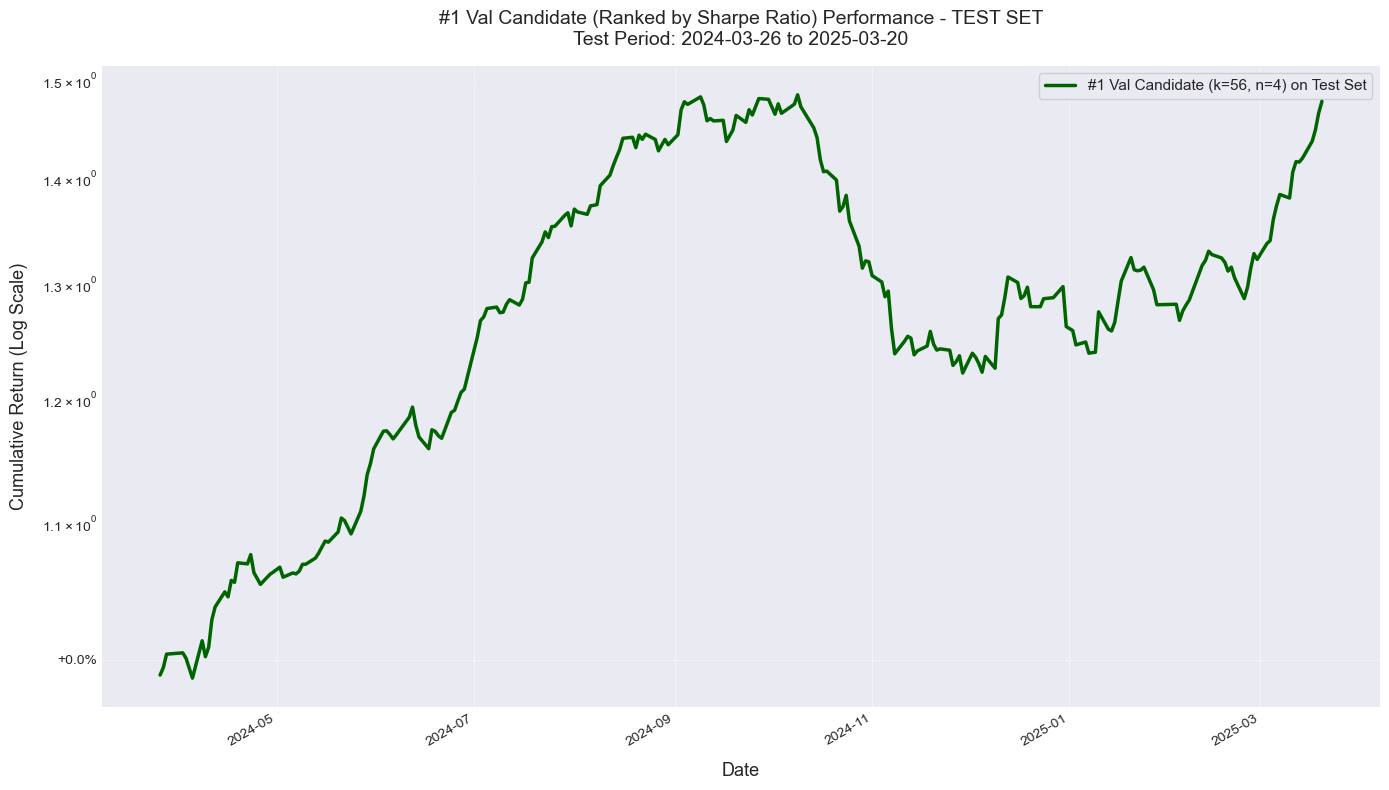

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd # Assuming daily_returns_plot is a pandas Series/DataFrame
import traceback

print("\n--- Plotting Validation Candidate Performance on TEST Period ---", flush=True)

daily_returns_plot = None # Initialize
plot_condition = False
k_plot = None
n_plot = None

# Ensure best_k_final and best_n_final exist
if 'best_k_final' in globals() and 'best_n_final' in globals() and test_set_results is not None:
    k_plot = best_k_final
    n_plot = best_n_final
    print(f"Looking for test results for best candidate: k={k_plot}, n={n_plot}")
    # Find the result dictionary corresponding to best_k_final, best_n_final
    for res in test_set_results:
        if res.get('k') == k_plot and res.get('n') == n_plot:
            result_to_plot = res
            break # Found it

    if result_to_plot:
        # Ensure the key exists before accessing
        if 'test_daily_returns' in result_to_plot:
            daily_returns_plot = result_to_plot['test_daily_returns']
            plot_condition = (daily_returns_plot is not None and not daily_returns_plot.empty)
        else:
            print(f"WARN: Could not find test results dictionary for best candidate k={k_plot}, n={n_plot} in test_set_results.")
    else:
        print("WARN: best_k_final, best_n_final, or test_set_results not available.")

    if plot_condition:
        # Use the strategy's index directly
        strategy_index = daily_returns_plot.index
        if len(strategy_index) > 1:
            # Calculate cumulative returns directly from the available daily returns
            strategy_cumulative_final = (1 + daily_returns_plot).cumprod()
            try:
                plt.style.use('seaborn-v0_8-darkgrid')
                fig, ax = plt.subplots(figsize=(14, 8))

                line_color = 'darkgreen' # Standard color for the strategy
                # Plot only the strategy
                ax.plot(strategy_cumulative_final.index, strategy_cumulative_final,
                        label=f'#1 Val Candidate (k={k_plot}, n={n_plot}) on Test Set',
                        linewidth=2.5, color=line_color, zorder=10)

                # Update title and labels - remove HSI comparison
                start_date_str = strategy_index.min().strftime('%Y-%m-%d')
                end_date_str = strategy_index.max().strftime('%Y-%m-%d')
                # Removed outcome_str as it was HSI-related
                plot_title = f'#1 Val Candidate (Ranked by {VALIDATION_OPTIMIZATION_METRIC}) Performance - TEST SET\nTest Period: {start_date_str} to {end_date_str}'

                ax.set_title(plot_title, fontsize=14, pad=15)
                ax.set_ylabel('Cumulative Return (Log Scale)', fontsize=13, labelpad=10)
                ax.set_xlabel('Date', fontsize=13, labelpad=10)
                ax.set_yscale('log')
                ax.legend(loc='best', fontsize=11, frameon=True, framealpha=0.9)
                ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{y-1:+.1%}')) # Format y-axis as percentage return
                ax.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.7)
                ax.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
                plt.xticks(rotation=30, ha='right')
                plt.tight_layout()

                # Instead of saving, show the plot
                print("Displaying test set cumulative return plot...")
                plt.show()
                # plt.close(fig) # Usually not needed after plt.show() in interactive environments,
                               # but uncomment if the figure stays open unexpectedly or you need to free memory explicitly.

            except Exception as e:
                print(f"Error during plotting: {e}")
                traceback.print_exc()
        else:
            # Update message
            print("Skipping plot: Not enough data points (>1) for #1 strategy on test set.")
    else:
        # Update message
        print("Skipping plot: Data missing for #1 validation candidate on test set.")
else:
    print("Skipping plot: No candidates selected from validation (or result[2] is missing) to plot.")



--- === VISUALIZING BEST STRATEGY OVER FULL PERIOD === ---
Attempting to use k/n if available...
Using k=56, n=4 from top test candidate.

--- Loading full original data from 'detailed_data_with_alphas_and_price.csv'... ---
Full data loaded. Shape: (99942, 9)

--- Calculating actual forward returns on full dataset... ---

--- Preparing features and generating predictions for full dataset... ---
Features scaled. Shape: (99942, 6)
 980/3124 ━━━━━━━━━━━━━━━━━━━━ 0s 153us/step

2025-05-01 02:48:53.379070: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-01 02:48:53.379361: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

3124/3124 ━━━━━━━━━━━━━━━━━━━━ 0s 154us/step
Predictions generated for full dataset. Shape: (99942,)
Dropped 83 rows with NaN actual_forward_return.
Full results DataFrame prepared for simulation. Shape: (99859, 3)

--- Running simulation for best k=56, n=4 over the FULL PERIOD... ---
--- Running Simulation (Full Period): k=56, n=4 ---
Finished Simulation (Full Period): k=56, n=4. CumReturn: 99.02%, Sharpe: 0.6139, Time: 0.37s
Full period simulation finished in 0.37 seconds.

--- Full Period Performance Metrics (Best k, n Strategy) ---
  - Cumulative Return: 0.9902
  - Annualized Return: 0.1520
  - Annualized Volatility: 0.3069
  - Sharpe Ratio: 0.6139
  - Max Drawdown: -0.3661
  - Trading Days: 1226
  - Positive Days %: 50.8972
  - Sortino Ratio: 0.9738
  - Drawdown Duration (Days): 330
  - Recovery Time (Days): 374

--- Plotting Full Period Performance with Markers ---
Full period plot saved to dnn_backtest_FULL_PERIOD_k56_n4_cumulative_return_log.png


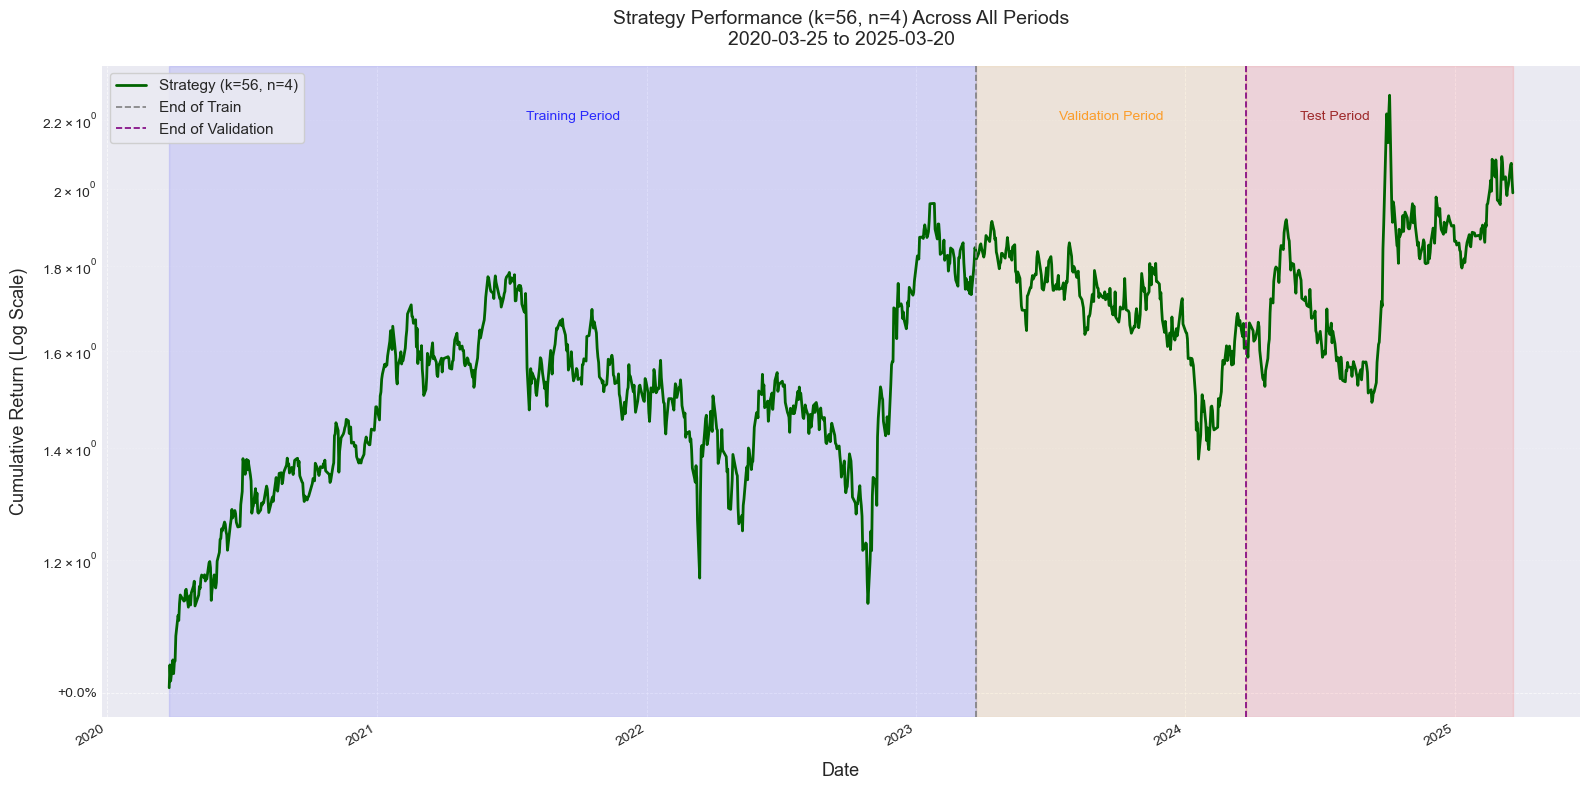


--- Full Period Visualization Script End ---


In [7]:
# === New Part: Visualize Strategy Performance Over Full Period ===

print("\n\n--- === VISUALIZING BEST STRATEGY OVER FULL PERIOD === ---", flush=True)

# --- Configuration for Full Period Visualization ---
FULL_PLOT_SAVE_PATH = f'dnn_backtest_FULL_PERIOD_k{k_plot}_n{n_plot}_cumulative_return_log.png' # Dynamic filename

if test_set_results:
    print("Attempting to use k/n if available...")
    try:
        best_k = best_k_final
        best_n = best_n_final
        print(f"Using k={best_k}, n={best_n} from top test candidate.")
    except (IndexError, KeyError):
        print("ERROR: Still could not get best k/n. Exiting visualization part.")
        exit() # Or handle differently
else:
    exit() # Exit if no results at all

# --- 1. Load Full Original Data ---
print(f"\n--- Loading full original data from '{ORIGINAL_DETAILED_CSV}'... ---", flush=True)
try:
    full_data_df = pd.read_csv(ORIGINAL_DETAILED_CSV, parse_dates=['Date'])
    full_data_df.sort_values(by=['stock_id', 'Date'], inplace=True)
    full_data_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    print(f"Full data loaded. Shape: {full_data_df.shape}")

    # Basic check for required columns
    required_original_cols = set(feature_names) | {'Date', 'stock_id', 'price'}
    if not required_original_cols.issubset(full_data_df.columns):
        missing_cols = required_original_cols - set(full_data_df.columns)
        raise ValueError(f"Original data missing required columns: {missing_cols}")

except FileNotFoundError:
    print(f"ERROR: Original data file '{ORIGINAL_DETAILED_CSV}' not found.", flush=True)
    exit()
except Exception as e:
    print(f"Error loading or checking original data: {e}", flush=True)
    traceback.print_exc()
    exit()

# --- 2. Calculate Actual Forward Returns for Simulation Evaluation ---
# Need this on the full dataset for the simulation loop to calculate daily P/L
print("\n--- Calculating actual forward returns on full dataset... ---", flush=True)
full_data_df[f'price_t+{FORWARD_RETURN_PERIOD}'] = full_data_df.groupby('stock_id')['price'].shift(-FORWARD_RETURN_PERIOD)
full_data_df['actual_forward_return'] = np.where(
    full_data_df['price'] > 1e-9,
    (full_data_df[f'price_t+{FORWARD_RETURN_PERIOD}'] / full_data_df['price']) - 1,
    np.nan
)
full_data_df.replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf results again

# --- 3. Prepare Features and Generate Predictions for Full Dataset ---
print("\n--- Preparing features and generating predictions for full dataset... ---", flush=True)
try:
    # Drop rows where features or the actual_forward_return needed for simulation are NaN
    # Note: We predict on all rows with valid features, but simulation stops when actual_forward_return is NaN
    feature_cols_for_pred = full_data_df[feature_names].copy()

    # Handle NaNs in features (using forward/backward fill per stock is safest)
    initial_feature_nan = feature_cols_for_pred.isnull().sum().sum()
    if initial_feature_nan > 0:
        print(f"Found {initial_feature_nan} NaNs in features before scaling. Applying ffill/bfill per stock...")
        for col in feature_names:
             feature_cols_for_pred[col] = feature_cols_for_pred.groupby(full_data_df['stock_id'])[col].ffill()
             feature_cols_for_pred[col] = feature_cols_for_pred.groupby(full_data_df['stock_id'])[col].bfill()
        # Handle any remaining NaNs (e.g., fill with 0 or drop rows)
        remaining_feature_nan = feature_cols_for_pred.isnull().sum().sum()
        if remaining_feature_nan > 0:
            print(f"Warning: {remaining_feature_nan} NaNs remain in features after ffill/bfill. Filling with 0.")
            feature_cols_for_pred.fillna(0, inplace=True) # Or drop rows if preferred

    # Scale features using the loaded scaler
    X_full_scaled = scaler.transform(feature_cols_for_pred)
    print(f"Features scaled. Shape: {X_full_scaled.shape}")

    # Generate predictions
    full_predictions = model.predict(X_full_scaled).flatten()
    print(f"Predictions generated for full dataset. Shape: {full_predictions.shape}")

    # Add predictions and actual returns back to a working DataFrame
    # Important: Ensure alignment after any potential NaN handling/dropping
    full_results_df = full_data_df[['Date', 'stock_id', 'actual_forward_return']].copy()
    full_results_df['predicted_score'] = full_predictions

    # Critical: Drop rows where simulation cannot proceed (no actual forward return)
    # This defines the actual end date of the simulation's P/L calculation
    rows_before_drop = len(full_results_df)
    full_results_df.dropna(subset=['actual_forward_return'], inplace=True)
    rows_after_drop = len(full_results_df)
    print(f"Dropped {rows_before_drop - rows_after_drop} rows with NaN actual_forward_return.")

    # Check for NaNs in predicted scores (shouldn't happen if features handled)
    if full_results_df['predicted_score'].isnull().any():
        print("Warning: NaNs found in predicted scores after alignment. Filling with 0.")
        full_results_df['predicted_score'].fillna(0, inplace=True) # Or handle differently

    # Set Date index for simulation function
    full_results_df = full_results_df.sort_values(by=['Date', 'stock_id'])
    full_results_df = full_results_df.set_index('Date')
    print(f"Full results DataFrame prepared for simulation. Shape: {full_results_df.shape}")
    if full_results_df.empty:
         raise ValueError("Full results DataFrame is empty after preparation.")

except Exception as e:
    print(f"Error during full data preparation or prediction: {e}", flush=True)
    traceback.print_exc()
    exit()


# --- 4. Run Simulation for Best (k, n) Over Entire Period ---
print(f"\n--- Running simulation for best k={best_k}, n={best_n} over the FULL PERIOD... ---", flush=True)
start_sim_full = time.time()
# Use the actual_forward_return column for P/L calculation in the simulation
full_daily_returns, full_metrics = run_simulation(
    full_results_df.rename(columns={'actual_forward_return': 'actual_return'}), # Rename column to match function expectation
    best_k,
    best_n,
    period_name="Full Period"
)
sim_time_full = time.time() - start_sim_full
print(f"Full period simulation finished in {sim_time_full:.2f} seconds.")

# --- 5. Report Full Period Metrics ---
print("\n--- Full Period Performance Metrics (Best k, n Strategy) ---")
if not full_daily_returns.empty:
    [print(f"  - {metric}: {value:.4f}" if isinstance(value,(float, np.floating)) else f"  - {metric}: {value}") for metric, value in full_metrics.items()]
    # Calculate Cumulative Return for plotting
    full_cumulative_returns = (1 + full_daily_returns).cumprod()
else:
    print("  Simulation did not produce valid returns for the full period.")
    full_cumulative_returns = None


# --- 6. Plot Full Period Performance with Period Markers ---
print("\n--- Plotting Full Period Performance with Markers ---", flush=True)
if full_cumulative_returns is not None and not full_cumulative_returns.empty:
    try:
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, ax = plt.subplots(figsize=(16, 8)) # Wider figure

        # Plot the strategy cumulative return
        ax.plot(full_cumulative_returns.index, full_cumulative_returns,
                label=f'Strategy (k={best_k}, n={best_n})',
                linewidth=2.0, color='darkgreen')

        # Define period boundaries
        train_start_date = full_cumulative_returns.index.min()
        train_end_date_dt = pd.to_datetime(TRAIN_END_DATE)
        validation_end_date_dt = pd.to_datetime(VALIDATION_END_DATE)
        actual_end_date = full_cumulative_returns.index.max()

        # Add vertical lines for period boundaries
        ax.axvline(train_end_date_dt, color='grey', linestyle='--', linewidth=1.2, label='End of Train')
        ax.axvline(validation_end_date_dt, color='purple', linestyle='--', linewidth=1.2, label='End of Validation')
        # Optional: Add line for end of the original test period if desired
        # test_end_date_actual = test_results_df.index.max() # Get from previous script if needed
        # ax.axvline(test_end_date_actual, color='red', linestyle=':', linewidth=1.0, label='End of Original Test')

        # Add shaded regions for periods (adjust alpha for visibility)
        ax.axvspan(train_start_date, train_end_date_dt, alpha=0.1, color='blue', label='_nolegend_')
        ax.axvspan(train_end_date_dt, validation_end_date_dt, alpha=0.1, color='orange', label='_nolegend_')
        ax.axvspan(validation_end_date_dt, actual_end_date, alpha=0.1, color='red', label='_nolegend_') # Test + Post-Test combined shading

        # Add text labels for periods
        y_min, y_max = ax.get_ylim()
        text_y_pos = y_min + (y_max - y_min) * 0.90 # Position text near the top

        # Adjust x-position slightly into the period
        train_text_x = train_start_date + (train_end_date_dt - train_start_date) / 2
        val_text_x = train_end_date_dt + (validation_end_date_dt - train_end_date_dt) / 2
        test_text_x = validation_end_date_dt + (actual_end_date - validation_end_date_dt) / 3 # Position within test span

        ax.text(train_text_x, text_y_pos, 'Training Period', horizontalalignment='center', fontsize=10, color='blue', alpha=0.8)
        ax.text(val_text_x, text_y_pos, 'Validation Period', horizontalalignment='center', fontsize=10, color='darkorange', alpha=0.8)
        ax.text(test_text_x, text_y_pos, 'Test Period', horizontalalignment='center', fontsize=10, color='darkred', alpha=0.8)


        # Formatting
        start_date_str = train_start_date.strftime('%Y-%m-%d')
        end_date_str = actual_end_date.strftime('%Y-%m-%d') # Use actual end date from simulation
        plot_title = f'Strategy Performance (k={best_k}, n={best_n}) Across All Periods\n{start_date_str} to {end_date_str}'

        ax.set_title(plot_title, fontsize=14, pad=15)
        ax.set_ylabel('Cumulative Return (Log Scale)', fontsize=13, labelpad=10)
        ax.set_xlabel('Date', fontsize=13, labelpad=10)
        ax.set_yscale('log')
        ax.legend(loc='upper left', fontsize=11, frameon=True, framealpha=0.9) # Legend for strategy and lines
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{y-1:+.1%}')) # Format y-axis as percentage return
        ax.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.7)
        ax.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
        plt.xticks(rotation=30, ha='right')
        plt.tight_layout()

        # Save or show the plot
        plt.savefig(FULL_PLOT_SAVE_PATH, dpi=150)
        print(f"Full period plot saved to {FULL_PLOT_SAVE_PATH}")
        plt.show() # Display the plot as well
        # plt.close(fig) # Optional

    except Exception as e:
        print(f"Error during full period plotting: {e}")
        traceback.print_exc()
else:
    print("Skipping full period plot: No valid cumulative returns generated.")

print("\n--- Full Period Visualization Script End ---", flush=True)

## Add other benchmarks to compare



--- === VISUALIZING BEST STRATEGY OVER FULL PERIOD === ---
Attempting to use k/n from test_set_results if available...
Using k=56, n=4 from top test candidate.

--- Loading full original data from 'detailed_data_with_alphas_and_price.csv'... ---
Full data loaded. Shape: (99942, 9)

--- Calculating actual forward returns on full dataset... ---

--- Preparing features and generating predictions for full dataset... ---
Features scaled. Shape: (99942, 6)
 964/3124 ━━━━━━━━━━━━━━━━━━━━ 0s 156us/step

2025-05-01 02:48:59.080879: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-01 02:48:59.081148: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

3124/3124 ━━━━━━━━━━━━━━━━━━━━ 0s 155us/step
Predictions generated for full dataset. Shape: (99942,)
Dropped 83 rows with NaN actual_forward_return.
Full results DataFrame prepared for simulation. Shape: (99859, 3)

--- Running simulation for best k=56, n=4 over the FULL PERIOD... ---
--- Running Simulation (Full Period): k=56, n=4 ---
Finished Simulation (Full Period): k=56, n=4. CumReturn: 99.02%, Sharpe: 0.6139, Time: 0.37s
Full period simulation finished in 0.37 seconds.

--- Full Period Performance Metrics (Best k, n Strategy) ---
  - Cumulative Return: 0.9902
  - Annualized Return: 0.1520
  - Annualized Volatility: 0.3069
  - Sharpe Ratio: 0.6139
  - Max Drawdown: -0.3661
  - Trading Days: 1226
  - Positive Days %: 50.8972
  - Sortino Ratio: 0.9738
  - Drawdown Duration (Days): 330
  - Recovery Time (Days): 374

--- Calculating Benchmark Returns for Full Period (^HSI, 2800.HK) ---
Benchmark download range: 2020-03-25 to 2025-03-20
  Aligning ^HSI to strategy dates...
  ^HSI align

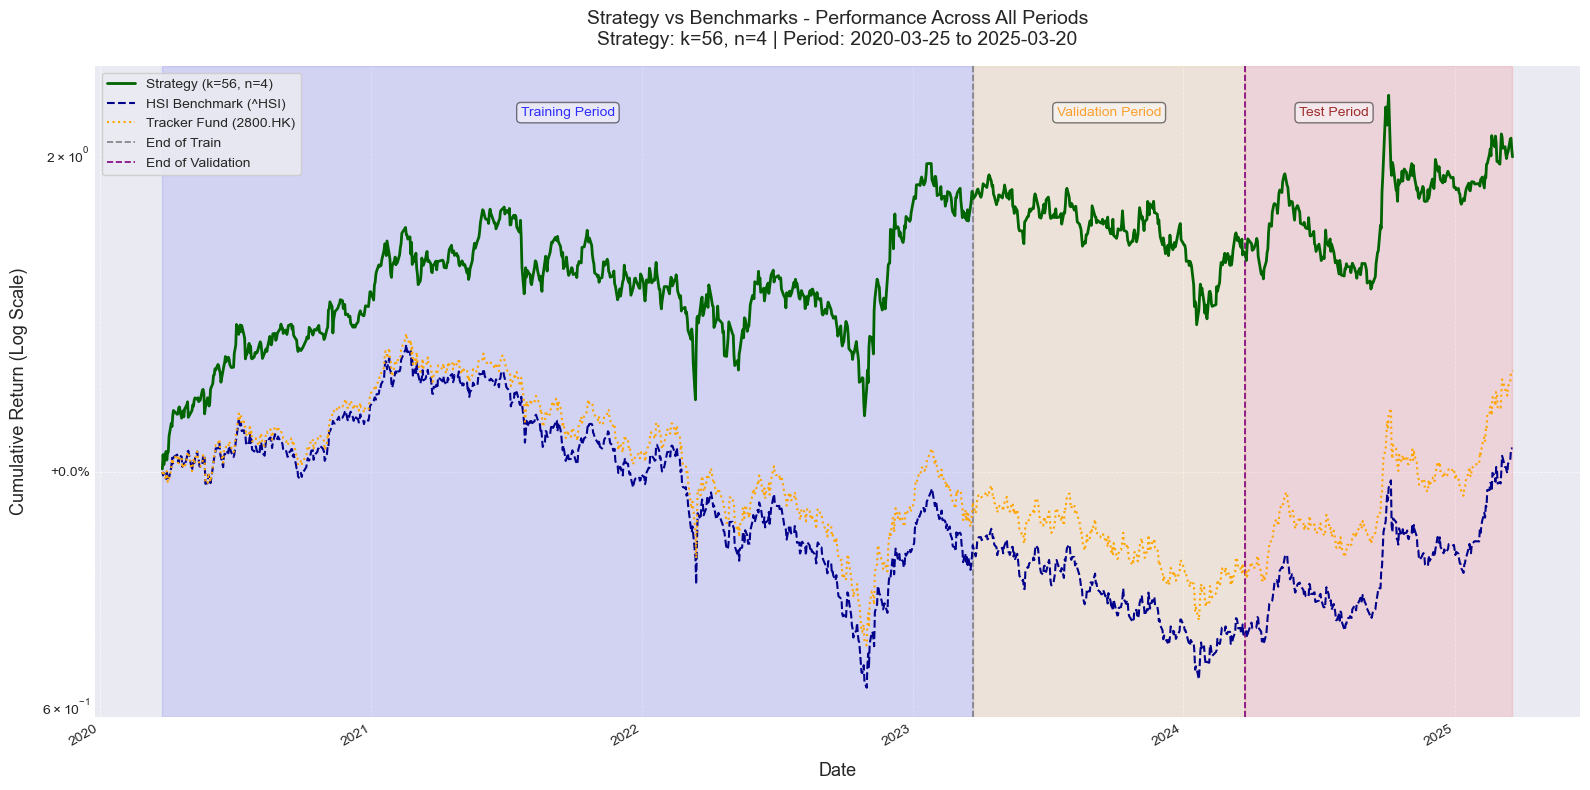


--- Full Period Visualization Script End ---


In [8]:
# === New Part: Visualize Strategy Performance Over Full Period ===

print("\n\n--- === VISUALIZING BEST STRATEGY OVER FULL PERIOD === ---", flush=True)

# --- Configuration for Full Period Visualization ---
FULL_PLOT_SAVE_PATH = f'dnn_backtest_FULL_PERIOD_k{best_k}_n{best_n}_cumulative_return_log.png' # Dynamic filename

if test_set_results:
    print("Attempting to use k/n from test_set_results if available...")
    try:
        best_k = best_k_final
        best_n = best_n_final
        print(f"Using k={best_k}, n={best_n} from top test candidate.")
    except (IndexError, KeyError):
        print("ERROR: Still could not get best k/n. Exiting visualization part.")
        exit() # Or handle differently
else:
    exit() # Exit if no results at all

# --- 1. Load Full Original Data ---
print(f"\n--- Loading full original data from '{ORIGINAL_DETAILED_CSV}'... ---", flush=True)
try:
    full_data_df = pd.read_csv(ORIGINAL_DETAILED_CSV, parse_dates=['Date'])
    full_data_df.sort_values(by=['stock_id', 'Date'], inplace=True)
    full_data_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    print(f"Full data loaded. Shape: {full_data_df.shape}")

    # Basic check for required columns
    required_original_cols = set(feature_names) | {'Date', 'stock_id', 'price'}
    if not required_original_cols.issubset(full_data_df.columns):
        missing_cols = required_original_cols - set(full_data_df.columns)
        raise ValueError(f"Original data missing required columns: {missing_cols}")

except FileNotFoundError:
    print(f"ERROR: Original data file '{ORIGINAL_DETAILED_CSV}' not found.", flush=True)
    exit()
except Exception as e:
    print(f"Error loading or checking original data: {e}", flush=True)
    traceback.print_exc()
    exit()
    
# --- 2. Calculate Actual Forward Returns for Simulation Evaluation ---
# Need this on the full dataset for the simulation loop to calculate daily P/L
print("\n--- Calculating actual forward returns on full dataset... ---", flush=True)
full_data_df[f'price_t+{FORWARD_RETURN_PERIOD}'] = full_data_df.groupby('stock_id')['price'].shift(-FORWARD_RETURN_PERIOD)
full_data_df['actual_forward_return'] = np.where(
    full_data_df['price'] > 1e-9,
    (full_data_df[f'price_t+{FORWARD_RETURN_PERIOD}'] / full_data_df['price']) - 1,
    np.nan
)
full_data_df.replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf results again

# --- 3. Prepare Features and Generate Predictions for Full Dataset ---
print("\n--- Preparing features and generating predictions for full dataset... ---", flush=True)
try:
    # Drop rows where features or the actual_forward_return needed for simulation are NaN
    # Note: We predict on all rows with valid features, but simulation stops when actual_forward_return is NaN
    feature_cols_for_pred = full_data_df[feature_names].copy()

    # Handle NaNs in features (using forward/backward fill per stock is safest)
    initial_feature_nan = feature_cols_for_pred.isnull().sum().sum()
    if initial_feature_nan > 0:
        print(f"Found {initial_feature_nan} NaNs in features before scaling. Applying ffill/bfill per stock...")
        for col in feature_names:
             feature_cols_for_pred[col] = feature_cols_for_pred.groupby(full_data_df['stock_id'])[col].ffill()
             feature_cols_for_pred[col] = feature_cols_for_pred.groupby(full_data_df['stock_id'])[col].bfill()
        # Handle any remaining NaNs (e.g., fill with 0 or drop rows)
        remaining_feature_nan = feature_cols_for_pred.isnull().sum().sum()
        if remaining_feature_nan > 0:
            print(f"Warning: {remaining_feature_nan} NaNs remain in features after ffill/bfill. Filling with 0.")
            feature_cols_for_pred.fillna(0, inplace=True) # Or drop rows if preferred

    # Scale features using the loaded scaler
    X_full_scaled = scaler.transform(feature_cols_for_pred)
    print(f"Features scaled. Shape: {X_full_scaled.shape}")

    # Generate predictions
    full_predictions = model.predict(X_full_scaled).flatten()
    print(f"Predictions generated for full dataset. Shape: {full_predictions.shape}")

    # Add predictions and actual returns back to a working DataFrame
    # Important: Ensure alignment after any potential NaN handling/dropping
    full_results_df = full_data_df[['Date', 'stock_id', 'actual_forward_return']].copy()
    full_results_df['predicted_score'] = full_predictions

    # Critical: Drop rows where simulation cannot proceed (no actual forward return)
    # This defines the actual end date of the simulation's P/L calculation
    rows_before_drop = len(full_results_df)
    full_results_df.dropna(subset=['actual_forward_return'], inplace=True)
    rows_after_drop = len(full_results_df)
    print(f"Dropped {rows_before_drop - rows_after_drop} rows with NaN actual_forward_return.")

    # Check for NaNs in predicted scores (shouldn't happen if features handled)
    if full_results_df['predicted_score'].isnull().any():
        print("Warning: NaNs found in predicted scores after alignment. Filling with 0.")
        full_results_df['predicted_score'].fillna(0, inplace=True) # Or handle differently

    # Set Date index for simulation function
    full_results_df = full_results_df.sort_values(by=['Date', 'stock_id'])
    full_results_df = full_results_df.set_index('Date')
    print(f"Full results DataFrame prepared for simulation. Shape: {full_results_df.shape}")
    if full_results_df.empty:
         raise ValueError("Full results DataFrame is empty after preparation.")

except Exception as e:
    print(f"Error during full data preparation or prediction: {e}", flush=True)
    traceback.print_exc()
    exit()


# --- 4. Run Simulation for Best (k, n) Over Entire Period ---
print(f"\n--- Running simulation for best k={best_k}, n={best_n} over the FULL PERIOD... ---", flush=True)
start_sim_full = time.time()
# Use the actual_forward_return column for P/L calculation in the simulation
full_daily_returns, full_metrics = run_simulation(
    full_results_df.rename(columns={'actual_forward_return': 'actual_return'}), # Rename column to match function expectation
    best_k,
    best_n,
    period_name="Full Period"
)
sim_time_full = time.time() - start_sim_full
print(f"Full period simulation finished in {sim_time_full:.2f} seconds.")

# --- 5. Report Full Period Metrics ---
print("\n--- Full Period Performance Metrics (Best k, n Strategy) ---")
if not full_daily_returns.empty:
    [print(f"  - {metric}: {value:.4f}" if isinstance(value,(float, np.floating)) else f"  - {metric}: {value}") for metric, value in full_metrics.items()]
    # Calculate Cumulative Return for plotting
    full_cumulative_returns = (1 + full_daily_returns).cumprod()
else:
    print("  Simulation did not produce valid returns for the full period.")
    full_cumulative_returns = None # Set to None if simulation failed


# --- NEW: 5b. Calculate Benchmark Returns for Full Period ---
print("\n--- Calculating Benchmark Returns for Full Period (^HSI, 2800.HK) ---", flush=True)
hsi_cumulative_aligned = None
tracker_cumulative_aligned = None

# Only proceed if the strategy simulation was successful
if full_cumulative_returns is not None and not full_cumulative_returns.empty:
    # Determine date range from strategy results
    full_start_date = full_cumulative_returns.index.min()
    full_end_date = full_cumulative_returns.index.max()
    # Add buffer for download
    download_start = full_start_date
    download_end = full_end_date
    print(f"Benchmark download range: {download_start.date()} to {download_end.date()}")

    benchmarks_to_plot = {
        '^HSI': {'label': 'HSI Benchmark (^HSI)', 'color': 'darkblue', 'style': '--'},
        '2800.HK': {'label': 'Tracker Fund (2800.HK)', 'color': 'orange', 'style': ':'}
    }
    benchmark_cumulative_data = {} # Store aligned data

    for ticker, details in benchmarks_to_plot.items():
        print(f"  Downloading {ticker}...")
        try:
            bench_data = yf.download(ticker, start=download_start, end=download_end, auto_adjust=True, progress=False)
            if bench_data.empty:
                print(f"  WARNING: No data downloaded for {ticker}.")
                continue

            # Ensure timezone naive
            if bench_data.index.tz is not None:
                bench_data.index = bench_data.index.tz_localize(None)

            # Calculate daily and cumulative returns
            bench_data['daily_return'] = bench_data['Close'].pct_change()
            # Start cumulative return from 1.0
            bench_cumulative_raw = (1 + bench_data['daily_return'].fillna(0)).cumprod()

            # Align to strategy dates using reindex and ffill
            print(f"  Aligning {ticker} to strategy dates...")
            aligned_data = bench_cumulative_raw.reindex(full_cumulative_returns.index).ffill().dropna()

            if not aligned_data.empty:
                benchmark_cumulative_data[ticker] = aligned_data
                print(f"  {ticker} aligned successfully.")
            else:
                print(f"  WARNING: {ticker} alignment resulted in empty series.")

        except Exception as e:
            print(f"  ERROR processing benchmark {ticker}: {e}")
            traceback.print_exc()

    # Assign to specific variables used later in plotting if needed
    hsi_cumulative_aligned = benchmark_cumulative_data.get('^HSI')
    tracker_cumulative_aligned = benchmark_cumulative_data.get('2800.HK')

else:
    print("Skipping benchmark calculation as strategy simulation failed.")


# --- 6. Plot Full Period Performance with Period Markers (and Benchmarks) ---
print("\n--- Plotting Full Period Performance with Markers and Benchmarks ---", flush=True) # Updated title

if full_cumulative_returns is not None and not full_cumulative_returns.empty:
    try:
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, ax = plt.subplots(figsize=(16, 8)) # Wider figure

        # --- Plot Strategy ---
        ax.plot(full_cumulative_returns.index, full_cumulative_returns,
                label=f'Strategy (k={best_k}, n={best_n})',
                linewidth=2.0, color='darkgreen', zorder=10) # Use zorder to keep strategy on top

        # --- Plot Benchmarks (if available) ---
        if hsi_cumulative_aligned is not None and not hsi_cumulative_aligned.empty:
            ax.plot(hsi_cumulative_aligned.index, hsi_cumulative_aligned,
                    label=benchmarks_to_plot['^HSI']['label'],
                    color=benchmarks_to_plot['^HSI']['color'],
                    linestyle=benchmarks_to_plot['^HSI']['style'],
                    linewidth=1.5, zorder=5) # Lower zorder
        else:
            print("  Note: HSI Benchmark data not available for plotting.")

        if tracker_cumulative_aligned is not None and not tracker_cumulative_aligned.empty:
             ax.plot(tracker_cumulative_aligned.index, tracker_cumulative_aligned,
                     label=benchmarks_to_plot['2800.HK']['label'],
                     color=benchmarks_to_plot['2800.HK']['color'],
                     linestyle=benchmarks_to_plot['2800.HK']['style'],
                     linewidth=1.5, zorder=5) # Lower zorder
        else:
             print("  Note: Tracker Fund (2800.HK) data not available for plotting.")

        # --- Define period boundaries (Keep as is) ---
        train_start_date = full_cumulative_returns.index.min()
        train_end_date_dt = pd.to_datetime(TRAIN_END_DATE)
        validation_end_date_dt = pd.to_datetime(VALIDATION_END_DATE)
        actual_end_date = full_cumulative_returns.index.max()

        # --- Add vertical lines and shading (Keep as is) ---
        ax.axvline(train_end_date_dt, color='grey', linestyle='--', linewidth=1.2, label='End of Train')
        ax.axvline(validation_end_date_dt, color='purple', linestyle='--', linewidth=1.2, label='End of Validation')
        # Shading
        ax.axvspan(train_start_date, train_end_date_dt, alpha=0.1, color='blue', label='_nolegend_')
        ax.axvspan(train_end_date_dt, validation_end_date_dt, alpha=0.1, color='orange', label='_nolegend_')
        ax.axvspan(validation_end_date_dt, actual_end_date, alpha=0.1, color='red', label='_nolegend_')

        # --- Add text labels for periods (Keep as is) ---
        # Recalculate y_min/y_max *after* plotting everything to ensure text is placed correctly
        plt.draw() # Force draw to update axes limits if using interactive backend
        y_min, y_max = ax.get_ylim()
        # Adjust y-position if log scale causes issues near 1.0
        if ax.get_yscale() == 'log':
             # Position text based on log range
             log_y_min, log_y_max = np.log10(y_min), np.log10(y_max)
             text_log_y = log_y_min + (log_y_max - log_y_min) * 0.90
             text_y_pos = 10**text_log_y
        else:
            text_y_pos = y_min + (y_max - y_min) * 0.90

        # Text X positions (Keep as is)
        train_text_x = train_start_date + (train_end_date_dt - train_start_date) / 2
        val_text_x = train_end_date_dt + (validation_end_date_dt - train_end_date_dt) / 2
        test_text_x = validation_end_date_dt + (actual_end_date - validation_end_date_dt) / 3

        ax.text(train_text_x, text_y_pos, 'Training Period', horizontalalignment='center', fontsize=10, color='blue', alpha=0.8, bbox=dict(facecolor='white', alpha=0.5, pad=0.2, boxstyle='round,pad=0.3'))
        ax.text(val_text_x, text_y_pos, 'Validation Period', horizontalalignment='center', fontsize=10, color='darkorange', alpha=0.8, bbox=dict(facecolor='white', alpha=0.5, pad=0.2, boxstyle='round,pad=0.3'))
        ax.text(test_text_x, text_y_pos, 'Test Period', horizontalalignment='center', fontsize=10, color='darkred', alpha=0.8, bbox=dict(facecolor='white', alpha=0.5, pad=0.2, boxstyle='round,pad=0.3'))


        # --- Formatting (Keep mostly as is, adjust title/legend) ---
        start_date_str = train_start_date.strftime('%Y-%m-%d')
        end_date_str = actual_end_date.strftime('%Y-%m-%d') # Use actual end date from simulation
        plot_title = f'Strategy vs Benchmarks - Performance Across All Periods\nStrategy: k={best_k}, n={best_n} | Period: {start_date_str} to {end_date_str}' # Updated Title

        ax.set_title(plot_title, fontsize=14, pad=15)
        ax.set_ylabel('Cumulative Return (Log Scale)', fontsize=13, labelpad=10)
        ax.set_xlabel('Date', fontsize=13, labelpad=10)
        ax.set_yscale('log')
        ax.legend(loc='upper left', fontsize=10, frameon=True, framealpha=0.9) # Adjusted font size potentially
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{y-1:+.1%}')) # Format y-axis as percentage return
        ax.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.7)
        ax.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
        plt.xticks(rotation=30, ha='right')
        plt.tight_layout()

        # --- Save or show the plot ---
        plt.savefig(FULL_PLOT_SAVE_PATH, dpi=150)
        print(f"Full period plot saved to {FULL_PLOT_SAVE_PATH}")
        plt.show() # Uncomment if you want interactive display
        plt.close(fig) # Close figure after saving

    except Exception as e:
        print(f"Error during full period plotting: {e}")
        traceback.print_exc()
else:
    print("Skipping full period plot: No valid cumulative returns generated for the strategy.")

print("\n--- Full Period Visualization Script End ---", flush=True)

## Simulation for the strategy over full and extended period 



--- === VISUALIZING BEST STRATEGY OVER FULL & EXTENDED PERIOD === ---
--- Assumed Starting Strategy Capital: $1,000,000.00 ---
Using k=56, n=4 from top test candidate.

--- Loading original full data from 'detailed_data_with_alphas_and_price.csv'... ---
Original data loaded. Ends on: 2025-03-21

--- Fetching new yfinance data from 2025-03-21 to 2025-05-01 ---
New data fetched. Shape: (2158, 7). Min Date: 2025-03-21, Max Date: 2025-04-30

--- Calculating alpha factors for the new data period... ---
New alphas calculated. Shape: (2158, 9)

--- Combining original and new alpha/price data... ---
Combined data shape: (102017, 9). Date range: 2020-03-24 to 2025-04-30

--- Recalculating actual forward returns on combined dataset... ---

--- Preparing features and predicting for the combined dataset... ---
Found 8549 NaNs in combined features. Applying ffill/bfill per stock...
 848/3189 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step

2025-05-01 02:49:14.873796: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-01 02:49:14.874109: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

3189/3189 ━━━━━━━━━━━━━━━━━━━━ 1s 184us/step
Dropped 83 rows with NaN actual_forward_return.
Final simulation data prepared. Actual end date for simulation: 2025-04-29

--- Running simulation for k=56, n=4 over the EXTENDED PERIOD... ---
--- Running Simulation (Extended Period): k=56, n=4 ---
Finished Simulation (Extended Period): k=56, n=4. CumReturn: 92.79%, Sharpe: 0.5819, Time: 0.38s
Extended period simulation finished in 0.38 seconds.

--- Extended Period Performance Metrics (Best k, n Strategy) ---
  - Cumulative Return: 0.9279
  - Annualized Return: 0.1414
  - Annualized Volatility: 0.3095
  - Sharpe Ratio: 0.5819
  - Max Drawdown: -0.3661
  - Trading Days: 1251
  - Positive Days %: 51.1591
  - Sortino Ratio: 0.8817
  - Drawdown Duration (Days): 330
  - Recovery Time (Days): 374

--- Extended Period Performance Metrics (HSI Benchmark: ^HSI) ---
  Benchmark download range: 2020-03-25 to 2025-04-29
  Aligning HSI daily returns...
  Calculating HSI metrics...
  - Cumulative Return:

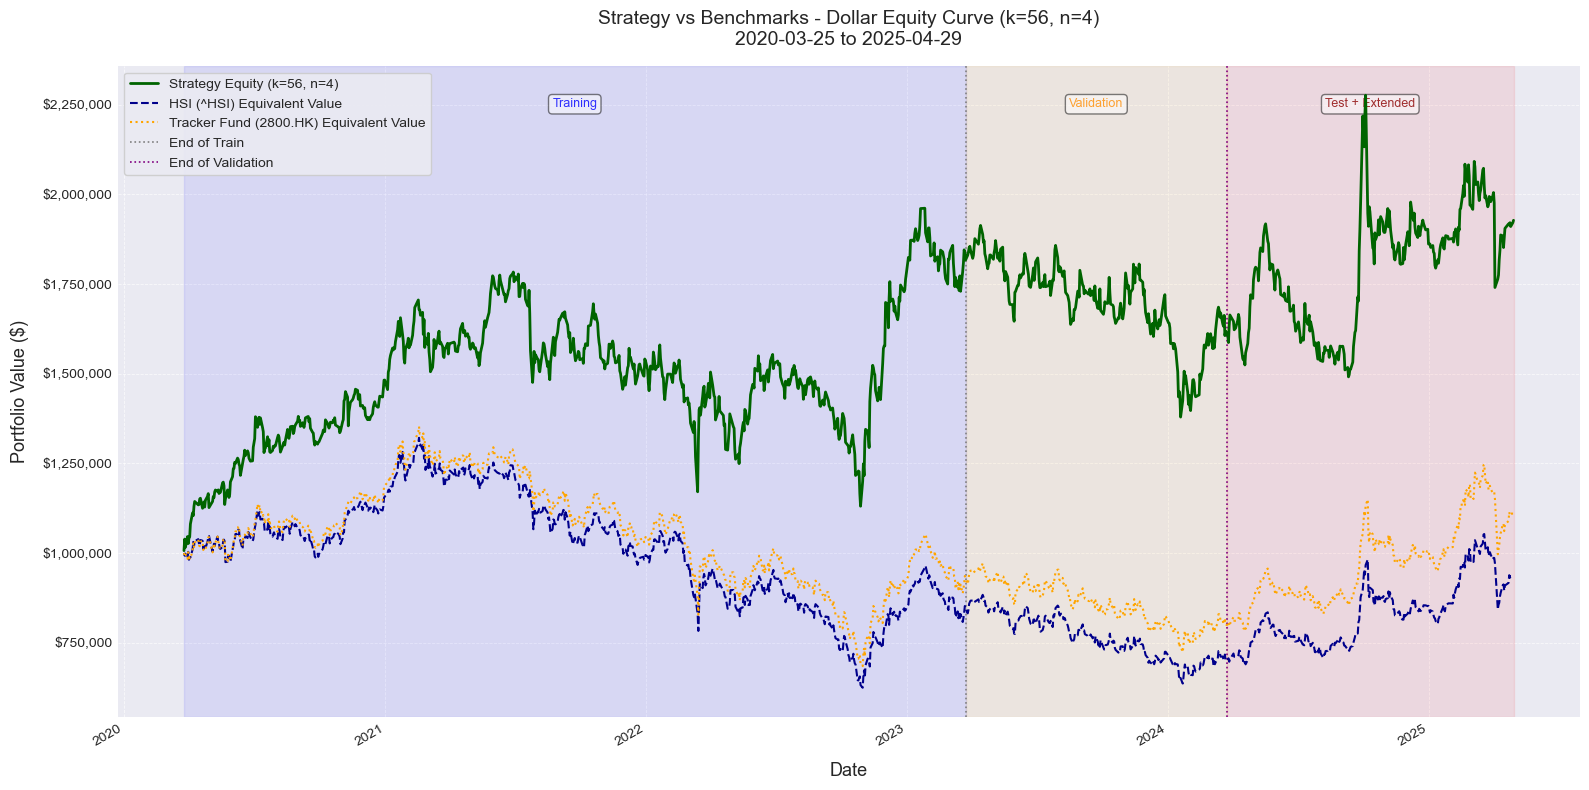


--- Full Period Visualization Script End ---


In [9]:
# === New Part: Visualize Strategy Performance Over Full & Extended Period ===

# Ensure necessary imports are present from the start of the script
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd # Make sure pandas is imported
import numpy as np # Make sure numpy is imported
import matplotlib.pyplot as plt # For plotting
import matplotlib.ticker as mtick # For plotting formatters
import traceback # For error details
import ta
from datetime import date
# Need the alpha calculation functions from Script 1
# Make sure calculate_all_alpha_factors and its dependencies are defined above
# Make sure TICKERS list is defined (from Script 1 config)
# Make sure feature_names list is defined (loaded earlier)
# Make sure scaler and model are loaded
# Make sure best_k and best_n are defined

TICKERS = ["0001.HK", "0002.HK", "0003.HK", "0005.HK", "0006.HK", "0011.HK", '0012.HK', '0016.HK', '0027.HK', '0066.HK', '0101.HK', '0175.HK', '0241.HK', '0267.HK', '0285.HK', '0288.HK', '0291.HK', '0316.HK',
           "0322.HK", '0386.HK', '0388.HK', '0669.HK', '0688.HK', '0700.HK', '0762.HK', '0823.HK', '0836.HK', '0857.HK', '0868.HK', '0881.HK', '0883.HK', '0939.HK', '0941.HK', '0960.HK', '0968.HK', '0981.HK',
           "0992.HK", "1024.HK", '1038.HK', '1044.HK', '1088.HK', "1093.HK", '1099.HK', '1109.HK', '1113.HK', '1177.HK', '1209.HK', '1211.HK', '1299.HK', '1378.HK', '1398.HK', '1810.HK', '1876.HK', '1928.HK',
           '1929.HK', '1997.HK', '2015.HK', '2020.HK', '2269.HK', '2313.HK', '2318.HK', '2319.HK', '2331.HK', '2359.HK', '2382.HK', '2388.HK', '2628.HK', '2688.HK', '2899.HK', '3690.HK', '3692.HK', '3968.HK',
           '3988.HK', '6618.HK', '6690.HK', '6862.HK', '9618.HK', '9633.HK', '9888.HK', '9901.HK', '9961.HK', '9988.HK', '9999.HK']

# Format Y-axis as dollars with commas using FuncFormatter
def dollar_formatter(x, pos):
    if abs(x) < 1: return '$0'
    return '${:,.0f}'.format(x)

print("\n\n--- === VISUALIZING BEST STRATEGY OVER FULL & EXTENDED PERIOD === ---", flush=True)

# --- Configuration for Extended Period Visualization ---
EXTEND_SIMULATION_END_DATE_STR = date.today()+timedelta(days=1) # User specified end date
EXTEND_SIMULATION_END_DATE = pd.to_datetime(EXTEND_SIMULATION_END_DATE_STR)
TOTAL_STRATEGY_CAPITAL = 1000000
print(f"--- Assumed Starting Strategy Capital: ${TOTAL_STRATEGY_CAPITAL:,.2f} ---")

# --- Determine Best k/n ---
if 'test_set_results' in globals() and test_set_results:
    try: best_k = best_k_final; best_n = best_n_final; print(f"Using k={best_k}, n={best_n} from top test candidate.")
    except (IndexError, KeyError, TypeError): print("ERROR: Could not extract k/n from test_set_results. Exiting."); exit()
else: print("ERROR: 'test_set_results' not found or empty. Cannot determine best k/n. Exiting."); exit()

FULL_PLOT_SAVE_PATH = f'dnn_backtest_EXTENDED_PERIOD_k{best_k}_n{best_n}_dollar_equity_curve.png'

# --- 1. Load Original Full Data (If not already loaded/modified) ---
print(f"\n--- Loading original full data from '{ORIGINAL_DETAILED_CSV}'... ---", flush=True)
try:
    original_data_df = pd.read_csv(ORIGINAL_DETAILED_CSV, parse_dates=['Date'])
    original_data_df.sort_values(by=['stock_id', 'Date'], inplace=True)
    original_end_date = original_data_df['Date'].max()
    print(f"Original data loaded. Ends on: {original_end_date.date()}")
except Exception as e:
    print(f"Error loading original data: {e}", flush=True); traceback.print_exc(); exit()

# --- 2. Fetch New Data for Extension Period ---
fetch_start_date = original_end_date 
# Need data up to END_DATE + 1 day for forward return calc on END_DATE
fetch_end_date = EXTEND_SIMULATION_END_DATE 

print(f"\n--- Fetching new yfinance data from {fetch_start_date.date()} to {fetch_end_date.date()- timedelta(days=1)} ---", flush=True)
new_data_list = []
failed_tickers = []
for ticker in TICKERS:
    try:
        # Download new OHLCV data
        data_new = yf.download(ticker, start=fetch_start_date, end=fetch_end_date,
                               auto_adjust=True, progress=False, ignore_tz=True)
        if not data_new.empty:
            if isinstance(data_new.columns, pd.MultiIndex): data_new.columns = data_new.columns.get_level_values(0)
            data_new['stock_id'] = ticker
            data_new.reset_index(inplace=True) # Bring 'Date' column in
            # Standardize Date column name again if needed
            if 'Datetime' in data_new.columns: data_new.rename(columns={'Datetime': 'Date'}, inplace=True)
            if 'Date' in data_new.columns: new_data_list.append(data_new[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'stock_id']])
            else: print(f"Warning: No 'Date' column in new data for {ticker}.")
        # else: print(f"No new data found for {ticker} in the specified range.") # Can be noisy

    except Exception as e:
        print(f"ERROR fetching new data for {ticker}: {e}")
        failed_tickers.append(ticker)

if not new_data_list:
    print("ERROR: Failed to fetch any new data for the extension period. Cannot proceed.")
    exit()

new_data_df = pd.concat(new_data_list, ignore_index=True)
new_data_df['Date'] = pd.to_datetime(new_data_df['Date'])
new_data_df.sort_values(by=['stock_id', 'Date'], inplace=True)
print(f"New data fetched. Shape: {new_data_df.shape}. Min Date: {new_data_df['Date'].min().date()}, Max Date: {new_data_df['Date'].max().date()}")
if failed_tickers: print(f"Warning: Failed to fetch new data for tickers: {failed_tickers}")


# --- 3. Calculate Alphas for New Data Period ---
print("\n--- Calculating alpha factors for the new data period... ---", flush=True)
new_alpha_data_list = []
for ticker in new_data_df['stock_id'].unique():
     ticker_data_new = new_data_df[new_data_df['stock_id'] == ticker].copy()
     # Ensure consistent 'Volume' column name if needed by alpha funcs
     # if 'Volume' not in ticker_data_new.columns and 'Trading_Volume' in ticker_data_new.columns:
     #      ticker_data_new.rename(columns={'Trading_Volume':'Volume'}, inplace=True)

     try:
         # Need to ensure calculate_all_alpha_factors is defined and works stand-alone
         alpha_data_new = calculate_all_alpha_factors(ticker_data_new)
         alpha_data_new['stock_id'] = ticker # Ensure stock_id persists
         # Keep only Date, stock_id, and calculated alpha columns (feature_names) + price ('Close')
         cols_to_keep = ['Date', 'stock_id', 'Close'] + feature_names
         existing_cols = [col for col in cols_to_keep if col in alpha_data_new.columns]
         new_alpha_data_list.append(alpha_data_new[existing_cols])
     except Exception as e:
         print(f"ERROR calculating alphas for {ticker} in new period: {e}")

if not new_alpha_data_list:
    print("ERROR: Failed to calculate any alpha factors for the new data period.")
    exit()

new_alphas_df = pd.concat(new_alpha_data_list, ignore_index=True)
new_alphas_df.sort_values(by=['stock_id', 'Date'], inplace=True)
# Rename 'Close' to 'price' to match original data structure for consistency
if 'Close' in new_alphas_df.columns: new_alphas_df.rename(columns={'Close':'price'}, inplace=True)
print(f"New alphas calculated. Shape: {new_alphas_df.shape}")


# --- 4. Combine Original Data (with Alphas) and New Data (with Alphas) ---
print("\n--- Combining original and new alpha/price data... ---", flush=True)
# Select necessary columns from original data (already has alphas)
original_cols_to_keep = ['Date', 'stock_id', 'price'] + feature_names
original_data_subset = original_data_df[original_cols_to_keep].copy()

# Combine the two periods
combined_data_df = pd.concat([original_data_subset, new_alphas_df], ignore_index=True)
combined_data_df.sort_values(by=['stock_id', 'Date'], inplace=True)
# Remove potential duplicate rows (e.g., if fetch_start_date overlapped)
combined_data_df.drop_duplicates(subset=['Date', 'stock_id'], keep='last', inplace=True)
print(f"Combined data shape: {combined_data_df.shape}. Date range: {combined_data_df['Date'].min().date()} to {combined_data_df['Date'].max().date()}")


# --- 5. Recalculate Forward Returns on Combined Data ---
print("\n--- Recalculating actual forward returns on combined dataset... ---", flush=True)
combined_data_df[f'price_t+{FORWARD_RETURN_PERIOD}'] = combined_data_df.groupby('stock_id')['price'].shift(-FORWARD_RETURN_PERIOD)
combined_data_df['actual_forward_return'] = np.where(
    combined_data_df['price'] > 1e-9,
    (combined_data_df[f'price_t+{FORWARD_RETURN_PERIOD}'] / combined_data_df['price']) - 1,
    np.nan
)
combined_data_df.replace([np.inf, -np.inf], np.nan, inplace=True)


# --- 6. Prepare Features and Predict on Combined Data ---
print("\n--- Preparing features and predicting for the combined dataset... ---", flush=True)
try:
    # Select features
    feature_cols_combined = combined_data_df[feature_names].copy()

    # Handle NaNs in features (ffill/bfill is crucial here across the boundary)
    initial_feature_nan = feature_cols_combined.isnull().sum().sum()
    if initial_feature_nan > 0:
        print(f"Found {initial_feature_nan} NaNs in combined features. Applying ffill/bfill per stock...")
        # Need to group by stock_id from the combined_data_df
        for col in feature_names:
             feature_cols_combined[col] = feature_cols_combined.groupby(combined_data_df['stock_id'])[col].ffill()
             feature_cols_combined[col] = feature_cols_combined.groupby(combined_data_df['stock_id'])[col].bfill()
        remaining_feature_nan = feature_cols_combined.isnull().sum().sum()
        if remaining_feature_nan > 0:
            print(f"Warning: {remaining_feature_nan} NaNs remain after ffill/bfill. Filling with 0.")
            feature_cols_combined.fillna(0, inplace=True)

    # Scale features
    X_combined_scaled = scaler.transform(feature_cols_combined)

    # Generate predictions
    combined_predictions = model.predict(X_combined_scaled).flatten()

    # --- Create the final DataFrame for the simulation ---
    extended_results_df = combined_data_df[['Date', 'stock_id', 'actual_forward_return']].copy()
    extended_results_df['predicted_score'] = combined_predictions

    # Drop rows where simulation cannot proceed (NaN forward return)
    # This determines the final end date possible for the simulation
    rows_before_drop = len(extended_results_df)
    extended_results_df.dropna(subset=['actual_forward_return'], inplace=True)
    rows_after_drop = len(extended_results_df)
    final_sim_end_date = extended_results_df['Date'].max()
    print(f"Dropped {rows_before_drop - rows_after_drop} rows with NaN actual_forward_return.")
    print(f"Final simulation data prepared. Actual end date for simulation: {final_sim_end_date.date()}")


    # Handle potential NaNs in scores (final check)
    if extended_results_df['predicted_score'].isnull().any():
        print("Warning: NaNs found in predicted scores. Filling with 0.")
        extended_results_df['predicted_score'].fillna(0, inplace=True)

    # Set Date index
    extended_results_df = extended_results_df.sort_values(by=['Date', 'stock_id'])
    extended_results_df = extended_results_df.set_index('Date')
    if extended_results_df.empty: raise ValueError("Extended results DataFrame is empty.")

except Exception as e:
    print(f"Error during combined data prep/prediction: {e}", flush=True); traceback.print_exc(); exit()


# --- 7. Run Simulation for Best (k, n) Over EXTENDED Period ---
print(f"\n--- Running simulation for k={best_k}, n={best_n} over the EXTENDED PERIOD... ---", flush=True)
start_sim_ext = time.time()
extended_daily_returns, extended_metrics = run_simulation(
    extended_results_df.rename(columns={'actual_forward_return': 'actual_return'}),
    best_k,
    best_n,
    period_name="Extended Period"
)
sim_time_ext = time.time() - start_sim_ext
print(f"Extended period simulation finished in {sim_time_ext:.2f} seconds.")

# --- 8. Report Extended Period Metrics (Strategy) ---
print("\n--- Extended Period Performance Metrics (Best k, n Strategy) ---")
extended_cumulative_returns = None # Initialize
if 'extended_daily_returns' in globals() and extended_daily_returns is not None and not extended_daily_returns.empty:
    if 'extended_metrics' in globals() and extended_metrics:
        [print(f"  - {metric}: {value:.4f}" if isinstance(value,(float, np.floating)) else f"  - {metric}: {value}") for metric, value in extended_metrics.items()]
        extended_cumulative_returns = (1 + extended_daily_returns).cumprod()
    else:
        print("  Strategy metrics calculation failed or was skipped.")
        if not extended_daily_returns.empty: extended_cumulative_returns = (1 + extended_daily_returns.fillna(0)).cumprod()
else:
    print("  Strategy simulation did not produce valid returns for the extended period.")

# --- 8b. Calculate and Report Extended Period Metrics (HSI Benchmark) ---
print("\n--- Extended Period Performance Metrics (HSI Benchmark: ^HSI) ---")
hsi_extended_metrics = {}
hsi_daily_aligned = None
if 'extended_daily_returns' in globals() and extended_daily_returns is not None and not extended_daily_returns.empty:
    full_start_date = extended_daily_returns.index.min(); full_end_date = extended_daily_returns.index.max()
    download_start = full_start_date; download_end = full_end_date
    print(f"  Benchmark download range: {download_start.date()} to {download_end.date()}")
    try:
        print("  Downloading ^HSI..."); hsi_data = yf.download('^HSI', start=download_start, end=download_end, auto_adjust=True, progress=False)
        if hsi_data.empty: print("  WARNING: No data downloaded for ^HSI.")
        else:
            if hsi_data.index.tz is not None: hsi_data.index = hsi_data.index.tz_localize(None)
            hsi_data['daily_return'] = hsi_data['Close'].pct_change()
            print("  Aligning HSI daily returns..."); hsi_daily_aligned = hsi_data['daily_return'].reindex(extended_daily_returns.index).fillna(0.0)
            print("  Calculating HSI metrics...")
            if 'calculate_metrics' in globals():
                 hsi_extended_metrics = calculate_metrics(hsi_daily_aligned)
                 if hsi_extended_metrics: [print(f"  - {metric}: {value:.4f}" if isinstance(value,(float, np.floating)) else f"  - {metric}: {value}") for metric, value in hsi_extended_metrics.items()]
                 else: print("  Failed to calculate HSI metrics.")
            else: print("  ERROR: calculate_metrics function not found.")
    except Exception as e: print(f"  ERROR processing ^HSI: {e}"); hsi_extended_metrics = {}
else: print("  Skipping HSI benchmark metrics calculation.")


# --- 8c. Calculate and Report Extended Period Metrics (Tracker Fund: 2800.HK) --- ## NEW SECTION ##
print("\n--- Extended Period Performance Metrics (Tracker Fund: 2800.HK) ---")
tracker_extended_metrics = {} # Initialize metrics dict
tracker_daily_aligned = None  # Initialize aligned daily returns

# Only proceed if the strategy simulation produced daily returns (needed for alignment)
if 'extended_daily_returns' in globals() and extended_daily_returns is not None and not extended_daily_returns.empty:
    # Use same date range as HSI (derived from strategy)
    # full_start_date, full_end_date, download_start, download_end already defined above
    print(f"  Benchmark download range: {download_start.date()} to {download_end.date()}") # Reuse dates

    try:
        print("  Downloading 2800.HK...")
        tracker_data = yf.download('2800.HK', start=download_start, end=download_end, auto_adjust=True, progress=False)

        if tracker_data.empty:
            print("  WARNING: No data downloaded for 2800.HK.")
        else:
            if tracker_data.index.tz is not None: tracker_data.index = tracker_data.index.tz_localize(None)
            tracker_data['daily_return'] = tracker_data['Close'].pct_change()

            # Align DAILY returns to strategy dates
            print("  Aligning 2800.HK daily returns...")
            tracker_daily_aligned = tracker_data['daily_return'].reindex(extended_daily_returns.index).fillna(0.0)

            # Calculate Tracker Metrics for the period
            print("  Calculating 2800.HK metrics...")
            if 'calculate_metrics' in globals(): # Ensure function exists
                 tracker_extended_metrics = calculate_metrics(tracker_daily_aligned)
                 # Report Tracker Metrics
                 if tracker_extended_metrics:
                      [print(f"  - {metric}: {value:.4f}" if isinstance(value,(float, np.floating)) else f"  - {metric}: {value}") for metric, value in tracker_extended_metrics.items()]
                 else:
                      print("  Failed to calculate 2800.HK metrics.")
            else:
                 print("  ERROR: calculate_metrics function not found.")

    except Exception as e:
        print(f"  ERROR processing 2800.HK or calculating metrics: {e}")
        tracker_extended_metrics = {} # Reset metrics on error
else:
    print("  Skipping 2800.HK benchmark metrics calculation as strategy daily returns are missing.")
# --- END OF TRACKER METRICS SECTION ---


# --- 9. Calculate Dollar Equity Curve (Strategy) ---
# (Keep this section as is)
print("\n--- Calculating Dollar Equity Curve for Strategy ---", flush=True)
dollar_equity_curve = None
if 'extended_daily_returns' in globals() and extended_daily_returns is not None and not extended_daily_returns.empty:
    cumulative_return_factor = (1 + extended_daily_returns.fillna(0)).cumprod()
    dollar_equity_curve = TOTAL_STRATEGY_CAPITAL * cumulative_return_factor
    print(f"Strategy dollar equity curve calculated. Final Value: ${dollar_equity_curve.iloc[-1]:,.2f}")
else:
    print("Could not calculate dollar equity curve for strategy.")


# --- 9b. Calculate Benchmark Dollar Equity Curve (^HSI) ---
# (Keep this section as is, relies on hsi_daily_aligned from 8b)
print("\n--- Calculating Benchmark Dollar Equity Curve (^HSI) ---", flush=True)
hsi_dollar_equity_aligned = None
if hsi_daily_aligned is not None and not hsi_daily_aligned.empty:
    try:
        hsi_cumulative_factor_aligned = (1 + hsi_daily_aligned).cumprod()
        hsi_dollar_equity_aligned = TOTAL_STRATEGY_CAPITAL * hsi_cumulative_factor_aligned
        print(f"  HSI dollar equity curve calculated. Final Value: ${hsi_dollar_equity_aligned.iloc[-1]:,.2f}")
    except Exception as e: print(f"  ERROR calculating HSI dollar equity: {e}")
else: print("  Skipping HSI dollar equity curve: aligned daily returns not available.")


# --- 9c. Calculate Benchmark Dollar Equity Curve (2800.HK) --- ## NEW SECTION ##
print("\n--- Calculating Benchmark Dollar Equity Curve (2800.HK) ---", flush=True)
tracker_dollar_equity_aligned = None

# Use the previously aligned daily returns if available
if tracker_daily_aligned is not None and not tracker_daily_aligned.empty:
    try:
        # Calculate cumulative factor from the *already aligned* daily returns
        tracker_cumulative_factor_aligned = (1 + tracker_daily_aligned).cumprod()
        tracker_dollar_equity_aligned = TOTAL_STRATEGY_CAPITAL * tracker_cumulative_factor_aligned
        print(f"  2800.HK dollar equity curve calculated. Final Value: ${tracker_dollar_equity_aligned.iloc[-1]:,.2f}")
    except Exception as e:
         print(f"  ERROR calculating 2800.HK dollar equity curve from aligned data: {e}")
else:
     print("  Skipping 2800.HK dollar equity curve calculation as aligned daily returns are not available.")
# --- END OF TRACKER DOLLAR EQUITY CALC ---


# --- 10. Plot Extended Period Performance (Dollar Equity with Benchmarks) --- ## MODIFIED PLOTTING ##
print("\n--- Plotting Extended Period Dollar Equity Curve with Markers and Benchmarks ---", flush=True)

# --- Ensure Boundary Dates are Defined Correctly Before Plotting ---
# (Keep the try-except block for boundary dates)
try:
    train_end_date_dt = pd.to_datetime(TRAIN_END_DATE); validation_end_date_dt = pd.to_datetime(VALIDATION_END_DATE); boundary_dates_defined = True
    print(f"Using boundary dates: Train End={train_end_date_dt.date()}, Validation End={validation_end_date_dt.date()}")
except NameError: print("WARNING: Boundary dates not found. Plot markers/shading skipped."); boundary_dates_defined = False; train_end_date_dt=None; validation_end_date_dt=None
except Exception as e: print(f"Error defining boundary dates: {e}. Markers/shading skipped."); boundary_dates_defined = False; train_end_date_dt=None; validation_end_date_dt=None

# Proceed only if strategy curve exists
if dollar_equity_curve is not None and not dollar_equity_curve.empty:
    try:
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, ax = plt.subplots(figsize=(16, 8)) # Wider figure

        # --- Plot Strategy ---
        ax.plot(dollar_equity_curve.index, dollar_equity_curve,
                label=f'Strategy Equity (k={best_k}, n={best_n})',
                linewidth=2.0, color='darkgreen', zorder=10)

        # --- Plot HSI Benchmark (if available) ---
        if hsi_dollar_equity_aligned is not None and not hsi_dollar_equity_aligned.empty:
            ax.plot(hsi_dollar_equity_aligned.index, hsi_dollar_equity_aligned,
                    label='HSI (^HSI) Equivalent Value',
                    color='darkblue', linestyle='--', linewidth=1.5, zorder=5)
        else: print("  Note: HSI Benchmark data not available for plotting.")

        # --- Plot Tracker Fund Benchmark (if available) --- ## NEW PLOT LINE ##
        if tracker_dollar_equity_aligned is not None and not tracker_dollar_equity_aligned.empty:
            ax.plot(tracker_dollar_equity_aligned.index, tracker_dollar_equity_aligned,
                    label='Tracker Fund (2800.HK) Equivalent Value',
                    color='orange', # Different color
                    linestyle=':',  # Different style
                    linewidth=1.5, zorder=5)
        else: print("  Note: Tracker Fund (2800.HK) data not available for plotting.")


        # --- Define plot start/end from actual equity curve data ---
        plot_start_date = dollar_equity_curve.index.min(); plot_end_date = dollar_equity_curve.index.max()

        # --- Add vertical lines and shading (if boundaries defined) ---
        # (Boundary plotting logic remains the same)
        if boundary_dates_defined and train_end_date_dt and validation_end_date_dt:
            ax.axvline(train_end_date_dt, color='grey', linestyle=':', linewidth=1.2, label='End of Train')
            ax.axvspan(plot_start_date, train_end_date_dt, alpha=0.08, color='blue', label='_nolegend_')
            ax.axvline(validation_end_date_dt, color='purple', linestyle=':', linewidth=1.2, label='End of Validation')
            ax.axvspan(train_end_date_dt, validation_end_date_dt, alpha=0.08, color='orange', label='_nolegend_')
            ax.axvspan(validation_end_date_dt, plot_end_date, alpha=0.08, color='red', label='_nolegend_')

            # --- Add Text Labels (if boundaries defined) ---
            # (Text label logic remains the same)
            plt.draw(); y_min, y_max = ax.get_ylim(); text_y_pos = y_min + (y_max - y_min) * 0.95
            train_text_x = plot_start_date + (train_end_date_dt - plot_start_date) / 2
            if train_end_date_dt < validation_end_date_dt: val_text_x = train_end_date_dt + (validation_end_date_dt - train_end_date_dt) / 2
            else: val_text_x = train_end_date_dt + timedelta(days=10)
            if validation_end_date_dt < plot_end_date: test_post_test_text_x = validation_end_date_dt + (plot_end_date - validation_end_date_dt) / 2
            else: test_post_test_text_x = validation_end_date_dt + timedelta(days=10)
            ax.text(train_text_x, text_y_pos, 'Training', ha='center', va='top', fontsize=9, color='blue', alpha=0.8, bbox=dict(facecolor='white', alpha=0.5, pad=0.2, boxstyle='round,pad=0.3'))
            ax.text(val_text_x, text_y_pos, 'Validation', ha='center', va='top', fontsize=9, color='darkorange', alpha=0.8, bbox=dict(facecolor='white', alpha=0.5, pad=0.2, boxstyle='round,pad=0.3'))
            ax.text(test_post_test_text_x, text_y_pos, 'Test + Extended', ha='center', va='top', fontsize=9, color='darkred', alpha=0.8, bbox=dict(facecolor='white', alpha=0.5, pad=0.2, boxstyle='round,pad=0.3'))

            # Ensure legend includes all plotted lines
            ax.legend(loc='upper left', fontsize=10, frameon=True, framealpha=0.9)
        else:
             # Legend with only strategy and benchmarks if no boundaries
             handles, labels = ax.get_legend_handles_labels()
             ax.legend(handles=handles, labels=labels, loc='upper left', fontsize=10, frameon=True, framealpha=0.9)


        # --- Formatting ---
        start_date_str = plot_start_date.strftime('%Y-%m-%d'); end_date_str = plot_end_date.strftime('%Y-%m-%d')
        plot_title = f'Strategy vs Benchmarks - Dollar Equity Curve (k={best_k}, n={best_n})\n{start_date_str} to {end_date_str}' # Updated Title

        ax.set_title(plot_title, fontsize=14, pad=15)
        ax.set_ylabel('Portfolio Value ($)', fontsize=13, labelpad=10)
        ax.set_xlabel('Date', fontsize=13, labelpad=10)
        ax.set_yscale('linear')
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(dollar_formatter))
        ax.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.7)
        plt.xticks(rotation=30, ha='right')
        plt.tight_layout()

        # --- Save or show the plot ---
        plt.savefig(FULL_PLOT_SAVE_PATH, dpi=150)
        print(f"Full period dollar equity plot saved to {FULL_PLOT_SAVE_PATH}")
        plt.show() # Uncomment for interactive display
        plt.close(fig) # Close figure

    except Exception as e:
        print(f"Error during full period plotting: {e}")
        traceback.print_exc()
else:
    print("Skipping full period dollar equity plot: No valid strategy equity curve generated.")

print("\n--- Full Period Visualization Script End ---", flush=True)

## Looking back what holdings hold, buy, and sell on a specified date (for the 1st candidate)

In [10]:
# === New Part: Look Back at Holdings/Trades for Specific Date (with Scores & SIMULATED Equity) ===

# --- Ensure necessary imports and functions are available ---
import pandas as pd
import numpy as np
import traceback
from datetime import timedelta, date # Ensure timedelta is imported

# --- Assumed Pre-requisites (Must be defined/loaded before this block) ---
# 1. `extended_results_df`: DataFrame with Date index, 'stock_id', 'predicted_score', 'actual_forward_return'
# 2. `dollar_equity_curve`: pd.Series (calculated) with Date index and daily portfolio dollar value
# 3. `get_trades(latest_scores_dict, current_holdings_set, k, n)`: Function defined
# 4. `get_holdings_on_date(results_df, k, n, target_date_dt)`: Function defined (using Corrected version below)
# 5. `test_set_results`: List of dictionaries from backtest (used to get best k, n)

print("\n\n--- === LOOKING BACK AT HOLDINGS/TRADES (Best Candidate - Reflecting Simulation Equity) === ---", flush=True)

# --- Configuration ---
LOOKBACK_DATE_STR = "2025-04-29" # <<< SPECIFY THE DATE YOU WANT TO CHECK HERE

# --- Helper Function: get_scores_for_date (NEW) ---
def get_scores_for_date(results_data_df, date_key):
    """
    Robustly extracts stock_id -> predicted_score mapping for a given date
    from the results DataFrame, handling single and multiple rows.
    """
    scores_dict = {}
    try:
        daily_slice = results_data_df.loc[date_key]

        if isinstance(daily_slice, pd.Series):
            # Single row case
            stock_id = None
            if 'stock_id' in daily_slice.index: stock_id = daily_slice['stock_id']
            # Add more checks if stock_id might be in the index name (less common here)
            # elif isinstance(daily_slice.name, ...) etc.
            if stock_id and 'predicted_score' in daily_slice.index:
                score = daily_slice['predicted_score']
                if pd.notna(score): scores_dict = {stock_id: score}

        elif isinstance(daily_slice, pd.DataFrame) and not daily_slice.empty:
            # Multiple rows case
            df_slice = daily_slice.copy()
            # Ensure stock_id column exists (handle index if necessary)
            if 'stock_id' not in df_slice.columns and df_slice.index.name == 'stock_id':
                 df_slice = df_slice.reset_index()
            # Extract scores if columns exist
            if 'stock_id' in df_slice.columns and 'predicted_score' in df_slice.columns:
                 df_slice.dropna(subset=['predicted_score'], inplace=True) # Drop rows where score is NaN
                 scores_dict = pd.Series(df_slice.predicted_score.values, index=df_slice.stock_id).to_dict()

    except KeyError:
        print(f"  WARN: No data found in results_data_df for date {date_key.date()}")
    except Exception as e:
        print(f"  WARN: Error extracting scores for date {date_key.date()}: {e}")

    return scores_dict


# --- Helper Function: get_trades (Ensure this is defined - Copied from previous step) ---
def get_trades(latest_scores_dict, current_holdings_set, k, n):
    selected_buys = set(); selected_sells = set()
    if not latest_scores_dict: return selected_buys, selected_sells
    try:
        valid_scores = {stk: scr for stk, scr in latest_scores_dict.items() if pd.notna(scr)}
        if not valid_scores: return selected_buys, selected_sells
        sorted_stocks_with_scores = sorted(valid_scores.items(), key=lambda item: item[1], reverse=True)
        stock_score_map = dict(sorted_stocks_with_scores); ranked_stocks_list = [s[0] for s in sorted_stocks_with_scores]
        target_portfolio = set(ranked_stocks_list[:k])
        required_sells_candidates = current_holdings_set - target_portfolio
        required_sells_ranked = sorted([(s, stock_score_map.get(s, -np.inf)) for s in required_sells_candidates], key=lambda item: item[1]) # Sort sells ascending by score
        required_sells = {s[0] for s in required_sells_ranked}; num_req_sells = len(required_sells)
        required_buys_candidates = target_portfolio - current_holdings_set
        required_buys_ranked = sorted([(s, stock_score_map.get(s, -np.inf)) for s in required_buys_candidates], key=lambda item: item[1], reverse=True) # Sort buys descending by score
        required_buys = {s[0] for s in required_buys_ranked}; num_req_buys = len(required_buys)
        total_required_trades = num_req_sells + num_req_buys
        if total_required_trades <= n:
            selected_sells = required_sells
            selected_buys = required_buys
        else:
            t_count = 0
            for stock, score in required_sells_ranked:
                if t_count < n: selected_sells.add(stock); t_count += 1
                else: break
            for stock, score in required_buys_ranked:
                if t_count < n: selected_buys.add(stock); t_count += 1
                else: break
    except Exception as e: print(f"ERROR in get_trades: {e}"); traceback.print_exc(); return set(), set()
    return selected_buys, selected_sells


# --- Function to Simulate Holdings Up To a Date (CORRECTED Version using helper) ---
def get_holdings_on_date(results_df, k, n, target_date_dt):
    """
    Simulates the strategy up to the day *before* the target_date
    to determine the holdings *at the start* of the target_date. (Uses get_scores_for_date)
    """
    current_holdings = set()
    # Ensure results_df has a DatetimeIndex
    if not isinstance(results_df.index, pd.DatetimeIndex):
        print("ERROR in get_holdings_on_date: results_df must have a DatetimeIndex.")
        return current_holdings

    unique_dates_in_data = results_df.index.unique().sort_values()
    # Filter dates up to *strictly before* the target date
    relevant_dates = unique_dates_in_data[unique_dates_in_data < target_date_dt]

    if relevant_dates.empty: return current_holdings # Start empty

    # Simulate day by day
    for current_sim_date in relevant_dates:
        # --- Get scores using the helper function ---
        latest_scores_dict = get_scores_for_date(results_df, current_sim_date)

        # --- Determine and apply trades ---
        try:
            executed_buys, executed_sells = get_trades(latest_scores_dict, current_holdings, k, n)
            holdings_after_sell = current_holdings - executed_sells
            current_holdings = holdings_after_sell.union(executed_buys)
        except NameError: print("FATAL ERROR: get_trades function not defined!"); raise
        except Exception as trade_err: print(f" WARN: Error getting trades on {current_sim_date.date()}: {trade_err}")

    return current_holdings # Holdings at the start of target_date


# --- Helper Function to Get Sorted Scores ---
def get_sorted_scores(stock_set, score_dict, reverse_sort=True, limit=5):
    """Gets (stock, score) tuples for a set, sorts them, handles NaNs, limits output."""
    if not stock_set: return []
    items = [(stock, score_dict.get(stock, np.nan)) for stock in stock_set]
    items.sort(key=lambda item: (np.isnan(item[1]), item[1]), reverse=reverse_sort)
    return items[:limit] if limit is not None and limit > 0 else items


# --- Main Lookback Logic ---
try:
    # --- Check required variables ---
    required_vars = ['extended_results_df', 'dollar_equity_curve', 'test_set_results', 'get_trades', 'get_holdings_on_date']
    for var in required_vars:
        if var not in globals(): raise NameError(f"Required variable/DataFrame/Function '{var}' is not defined.")
    if not isinstance(extended_results_df, pd.DataFrame) or extended_results_df.empty: raise ValueError("'extended_results_df' is empty or not a DataFrame.")
    if not isinstance(dollar_equity_curve, pd.Series) or dollar_equity_curve.empty: raise ValueError("'dollar_equity_curve' is empty or not a Series.")
    if not isinstance(extended_results_df.index, pd.DatetimeIndex): raise ValueError("'extended_results_df' must have a DatetimeIndex.") # Added check
    if not test_set_results or not isinstance(test_set_results, list): raise ValueError("'test_set_results' is empty or not a list.")

    # --- Determine Best k, n ---
    try:
        # Ensure best_k_final and best_n_final are available
        if 'best_k_final' not in globals() or 'best_n_final' not in globals():
            raise NameError("best_k_final or best_n_final not defined")
        LOOKBACK_K = best_k_final
        LOOKBACK_N = best_n_final
        print(f"Using chosen candidate parameters: k={LOOKBACK_K}, n={LOOKBACK_N}")
    except NameError as e:
        print(f"ERROR: Could not determine k/n from best_k_final/best_n_final: {e}.")

    # --- Date Setup ---
    target_date = pd.to_datetime(LOOKBACK_DATE_STR)
    sim_dates = dollar_equity_curve.index.unique().sort_values() # Use unique dates from equity curve

    # Find target date or next available date in simulation results
    target_date_actual = target_date # Start assuming target is available
    if target_date not in sim_dates:
        future_dates = sim_dates[sim_dates >= target_date]
        if not future_dates.empty:
            target_date_actual = future_dates.min()
            print(f"Note: Target date {target_date.date()} not found. Using next available sim date: {target_date_actual.date()}")
        else:
             raise ValueError(f"Target date {target_date.date()} or later not found in simulation results (dollar_equity_curve).")

    # Find previous simulation day relative to the actual target date used
    past_dates = sim_dates[sim_dates < target_date_actual]
    if not past_dates.empty:
        previous_trading_day_sim = past_dates.max()
    else:
        raise ValueError(f"Cannot find a simulation day before {target_date_actual.date()} in dollar_equity_curve.")

    # --- Verify previous day exists in results data for score lookup ---
    if previous_trading_day_sim not in extended_results_df.index:
        raise ValueError(f"Previous simulation day {previous_trading_day_sim.date()} not found in extended_results_df index. Data mismatch?")


    print(f"\nTarget Date (Actual in Sim): {target_date_actual.date()}")
    print(f"Previous Trading Day (Used for Scores): {previous_trading_day_sim.date()}")


    # 1. Get Holdings at START of the target_date_actual
    print("\nCalculating holdings at START of target date...")
    holdings_at_start_of_target_date = get_holdings_on_date(extended_results_df, LOOKBACK_K, LOOKBACK_N, target_date_actual)


    # 2. Get Scores from the PREVIOUS trading day using helper
    print(f"Retrieving scores from previous day ({previous_trading_day_sim.date()})...")
    scores_on_previous_day = get_scores_for_date(extended_results_df, previous_trading_day_sim)
    if not scores_on_previous_day: print("Warning: No valid scores found for the previous trading day. Trades might be empty.")


    # 3. Determine Trades Planned FOR the target_date_actual
    print(f"Calculating planned trades for {target_date_actual.date()}...")
    planned_buys, planned_sells = get_trades(scores_on_previous_day, holdings_at_start_of_target_date, LOOKBACK_K, LOOKBACK_N)


    # 4. Determine Holdings at the END of the target_date_actual
    holdings_after_planned_sell = holdings_at_start_of_target_date - planned_sells
    holdings_at_end_of_target_date = holdings_after_planned_sell.union(planned_buys)


    # 5. Get Simulated Equity Values from pre-calculated curve
    print("Retrieving simulated equity values...")
    equity_start_of_day = dollar_equity_curve.get(previous_trading_day_sim, np.nan) # Equity AFTER previous day's close
    equity_end_of_day = dollar_equity_curve.get(target_date_actual, np.nan)       # Equity AFTER target day's close


    # 6. Display Scores
    print("\n--- Scores from Previous Day Influencing Trades ---")
    print(f"Scores based on data from: {previous_trading_day_sim.date()}")
    limit_display = 5 # How many top/bottom scores to show
    start_holding_scores = get_sorted_scores(holdings_at_start_of_target_date, scores_on_previous_day, reverse_sort=True, limit=limit_display)
    print(f"\nTop {limit_display} Scores for Holdings at START ({len(holdings_at_start_of_target_date)} total stocks):")
    if start_holding_scores: [print(f"  {stock}: {score:.4f}") for stock, score in start_holding_scores]
    else: print("  None or No Holdings")
    sell_scores = get_sorted_scores(planned_sells, scores_on_previous_day, reverse_sort=False, limit=limit_display) # Sort sells low score to high
    print(f"\nBottom {limit_display} Scores for PLANNED SELLS ({len(planned_sells)} total stocks):")
    if sell_scores: [print(f"  {stock}: {score:.4f}") for stock, score in sell_scores]
    else: print("  None")
    buy_scores = get_sorted_scores(planned_buys, scores_on_previous_day, reverse_sort=True, limit=limit_display)
    print(f"\nTop {limit_display} Scores for PLANNED BUYS ({len(planned_buys)} total stocks):")
    if buy_scores: [print(f"  {stock}: {score:.4f}") for stock, score in buy_scores]
    else: print("  None")


    # 7. Display Results (with SIMULATED Equity/Allocation)
    print("\n--- Lookback Results (Reflecting Simulation Equity) ---")
    print(f"Date Checked: {target_date_actual.date()}")
    print(f"Strategy Parameters: k={LOOKBACK_K}, n={LOOKBACK_N}")
    print("-" * 60)

    # --- Start of Day Analysis ---
    num_holdings_start = len(holdings_at_start_of_target_date)
    equity_start_formatted = f"${equity_start_of_day:,.2f}" if pd.notna(equity_start_of_day) else "N/A"
    amount_per_stock_start = equity_start_of_day / num_holdings_start if num_holdings_start > 0 and pd.notna(equity_start_of_day) else 0
    amount_per_stock_start_formatted = f"${amount_per_stock_start:,.2f}" if amount_per_stock_start > 0 else "$0.00"
    print(f"Holdings at START of day ({num_holdings_start} stocks):")
    print(f"  -> Simulated Portfolio Equity: {equity_start_formatted}")
    print(f"  -> Implied Allocation per stock: {amount_per_stock_start_formatted}")
    print("  Holdings List:")
    print(f"    {sorted(list(holdings_at_start_of_target_date))}" if holdings_at_start_of_target_date else "    None")
    print("-" * 60)

    # --- Trades Executed During Day ---
    print(f"Planned SELLS executed on this day ({len(planned_sells)} stocks):")
    print(f"    {sorted(list(planned_sells))}" if planned_sells else "    None")
    print("-" * 60)
    print(f"Planned BUYS executed on this day ({len(planned_buys)} stocks):")
    print(f"    {sorted(list(planned_buys))}" if planned_buys else "    None")
    print("-" * 60)

    # --- End of Day Analysis ---
    num_holdings_end = len(holdings_at_end_of_target_date)
    equity_end_formatted = f"${equity_end_of_day:,.2f}" if pd.notna(equity_end_of_day) else "N/A"
    amount_per_stock_end = equity_end_of_day / num_holdings_end if num_holdings_end > 0 and pd.notna(equity_end_of_day) else 0
    amount_per_stock_end_formatted = f"${amount_per_stock_end:,.2f}" if amount_per_stock_end > 0 else "$0.00"
    print(f"Holdings at END of day ({num_holdings_end} stocks):")
    print(f"  -> Simulated Portfolio Equity: {equity_end_formatted}")
    print(f"  -> Implied Allocation per stock (for start of next day): {amount_per_stock_end_formatted}")
    print("  Holdings List:")
    print(f"    {sorted(list(holdings_at_end_of_target_date))}" if holdings_at_end_of_target_date else "    None")
    print("-" * 60)

except NameError as ne:
    print(f"ERROR: A required variable/DataFrame/Function is missing: {ne}")
    print("Ensure the backtest and extended simulation (including dollar_equity_curve) have run, and functions are defined.")
except ValueError as ve:
    print(f"ERROR: A data validation or lookup error occurred: {ve}")
except Exception as e:
    print(f"An unexpected error occurred during lookback: {e}"); traceback.print_exc()



--- === LOOKING BACK AT HOLDINGS/TRADES (Best Candidate - Reflecting Simulation Equity) === ---
Using chosen candidate parameters: k=56, n=4

Target Date (Actual in Sim): 2025-04-29
Previous Trading Day (Used for Scores): 2025-04-28

Calculating holdings at START of target date...
Retrieving scores from previous day (2025-04-28)...
Calculating planned trades for 2025-04-29...
Retrieving simulated equity values...

--- Scores from Previous Day Influencing Trades ---
Scores based on data from: 2025-04-28

Top 5 Scores for Holdings at START (22 total stocks):
  1876.HK: 0.0011
  1810.HK: 0.0007
  6618.HK: 0.0007
  1211.HK: 0.0007
  0939.HK: 0.0007

Bottom 5 Scores for PLANNED SELLS (3 total stocks):
  2899.HK: 0.0006
  6862.HK: 0.0006
  0175.HK: 0.0006

Top 5 Scores for PLANNED BUYS (1 total stocks):
  1088.HK: 0.0009

--- Lookback Results (Reflecting Simulation Equity) ---
Date Checked: 2025-04-29
Strategy Parameters: k=56, n=4
----------------------------------------------------------

## Estimate Next Business Day's Holdings/Trades (Reflecting Simulation Equity)

In [11]:
# === New Part: Estimate Next Business Day's Holdings/Trades (Reflecting Simulation Equity) ===

# --- Ensure necessary imports and functions are available ---
import pandas as pd
import numpy as np
import traceback
from datetime import timedelta

# --- Assumed Pre-requisites (Must be defined/loaded before this block) ---
# 1. `extended_results_df`: DataFrame with Date index, 'stock_id', 'predicted_score'
# 2. `dollar_equity_curve`: pd.Series (calculated) with Date index and daily portfolio dollar value
# 3. `get_trades(latest_scores_dict, current_holdings_set, k, n)`: Function defined
# 4. `get_holdings_on_date(results_df, k, n, target_date_dt)`: Function defined (Corrected version)
# 5. `get_scores_for_date(results_data_df, date_key)`: Helper Function defined (From previous refinement)
# 6. `get_sorted_scores(stock_set, score_dict, reverse_sort=True, limit=5)`: Function defined
# 7. `test_set_results`: List of dictionaries from backtest (used to get best k, n)

print("\n\n--- === ESTIMATING NEXT DAY's HOLDINGS/TRADES (Best Candidate - Reflecting Simulation Equity) === ---", flush=True)

# --- Determine Best k, n ---
try:
    # Ensure required variable exists before accessing
    if 'best_k_final' not in globals() or 'best_n_final' not in globals():
         raise NameError("best_k_final or best_n_final not defined")
    ESTIMATE_K = best_k_final
    ESTIMATE_N = best_n_final
    print(f"Using chosen candidate parameters: k={ESTIMATE_K}, n={ESTIMATE_N}")
except NameError as e:
    print(f"ERROR: Could not determine k and n from best_k_final/best_n_final: {e}")

# --- Main Estimation Logic ---
try:
    # --- Check required variables and functions ---
    required_vars = ['extended_results_df', 'dollar_equity_curve', 'get_holdings_on_date', 'get_trades', 'get_scores_for_date', 'get_sorted_scores']
    for var in required_vars:
        if var not in globals(): raise NameError(f"Required variable/function '{var}' is not defined.")
    if not isinstance(extended_results_df, pd.DataFrame) or extended_results_df.empty: raise ValueError("'extended_results_df' is empty.")
    if not isinstance(dollar_equity_curve, pd.Series) or dollar_equity_curve.empty: raise ValueError("'dollar_equity_curve' is empty.")
    if not isinstance(extended_results_df.index, pd.DatetimeIndex): raise ValueError("'extended_results_df' must have a DatetimeIndex.")

    # 1. Find the most recent date in simulation results AND the day before it
    sim_dates = dollar_equity_curve.index.unique().sort_values() # Use unique dates
    if len(sim_dates) < 2: raise ValueError("Need at least two simulation days (from dollar_equity_curve) to estimate next day.")
    most_recent_sim_date = sim_dates[-1]
    day_before_most_recent_sim = sim_dates[-2]

    # --- Verify dates exist in results data ---
    if most_recent_sim_date not in extended_results_df.index:
        raise ValueError(f"Most recent simulation date {most_recent_sim_date.date()} not found in extended_results_df index.")
    if day_before_most_recent_sim not in extended_results_df.index:
         raise ValueError(f"Day before simulation date {day_before_most_recent_sim.date()} not found in extended_results_df index.")

    print(f"\nMost recent simulation results available for: {most_recent_sim_date.date()}")
    print(f"Day before (used for state determination): {day_before_most_recent_sim.date()}")

    # 2. Calculate Holdings at START of most_recent_sim_date
    #    (This reconstructs the state resulting from trades on day_before_most_recent_sim)
    print(f"\nReconstructing holdings at START of {most_recent_sim_date.date()}...")
    holdings_start_most_recent = get_holdings_on_date(extended_results_df, ESTIMATE_K, ESTIMATE_N, most_recent_sim_date)

    # 3. Get Scores from day_before_most_recent_sim (using helper)
    print(f"Retrieving scores from {day_before_most_recent_sim.date()} (to determine trades ON {most_recent_sim_date.date()})...")
    scores_day_before = get_scores_for_date(extended_results_df, day_before_most_recent_sim)
    # No need to exit if scores are empty, get_trades handles it

    # 4. Calculate Trades executed ON most_recent_sim_date
    print(f"Calculating trades executed ON {most_recent_sim_date.date()}...")
    trades_on_most_recent_buys, trades_on_most_recent_sells = get_trades(
        scores_day_before, holdings_start_most_recent, ESTIMATE_K, ESTIMATE_N
    )

    # 5. Calculate Holdings at END of most_recent_sim_date (= START of next day)
    holdings_after_sell_most_recent = holdings_start_most_recent - trades_on_most_recent_sells
    holdings_start_next_day = holdings_after_sell_most_recent.union(trades_on_most_recent_buys)
    print(f"Calculated holdings at START of next trading day: {len(holdings_start_next_day)} stocks")


    # 6. Get Scores from the END of the most_recent_sim_date (using helper)
    print(f"Retrieving scores from {most_recent_sim_date.date()} (to plan next day's trades)...")
    scores_end_of_most_recent = get_scores_for_date(extended_results_df, most_recent_sim_date)
    if not scores_end_of_most_recent: print(f"Warning: No valid scores found on {most_recent_sim_date.date()}. Cannot plan trades for next day.")


    # 7. Determine Trades PLANNED FOR "Next Day"
    print(f"\nCalculating PLANNED trades for day after {most_recent_sim_date.date()}...")
    if scores_end_of_most_recent: # Only plan trades if scores are available
        planned_buys_next_day, planned_sells_next_day = get_trades(
            scores_end_of_most_recent,
            holdings_start_next_day, # Use the correctly calculated start holdings
            ESTIMATE_K,
            ESTIMATE_N
        )
    else:
        # If no scores, no trades can be planned
        planned_buys_next_day, planned_sells_next_day = set(), set()
        print("  Skipping trade planning as no scores available from most recent day.")


    # 8. Determine ESTIMATED Holdings at the END of "Next Day"
    holdings_after_planned_sell = holdings_start_next_day - planned_sells_next_day
    estimated_holdings_end_next_day = holdings_after_planned_sell.union(planned_buys_next_day)


    # 9. Get Simulated Equity Value for Start of Next Day
    equity_start_next_day = dollar_equity_curve.get(most_recent_sim_date, np.nan) # Equity AFTER most recent day's close


    # --- 10. Display Scores Influencing Next Day's Trades ---
    print("\n--- Scores from Most Recent Day Influencing Next Day's Planned Trades ---")
    print(f"Scores based on data from: {most_recent_sim_date.date()}")
    limit_display = 5 # How many top/bottom scores to show
    # Scores for Starting Holdings (Next Day Start)
    start_holding_scores_next = get_sorted_scores(holdings_start_next_day, scores_end_of_most_recent, reverse_sort=True, limit=limit_display)
    print(f"\nTop {limit_display} Scores for Holdings at START of Next Day ({len(holdings_start_next_day)} total stocks):")
    if start_holding_scores_next: [print(f"  {stock}: {score:.4f}") for stock, score in start_holding_scores_next]
    else: print("  None or No Holdings")
    # Scores for Planned Sells (Next Day)
    sell_scores_next = get_sorted_scores(planned_sells_next_day, scores_end_of_most_recent, reverse_sort=False, limit=limit_display)
    print(f"\nBottom {limit_display} Scores for PLANNED SELLS for Next Day ({len(planned_sells_next_day)} total stocks):")
    if sell_scores_next: [print(f"  {stock}: {score:.4f}") for stock, score in sell_scores_next]
    else: print("  None")
    # Scores for Planned Buys (Next Day)
    buy_scores_next = get_sorted_scores(planned_buys_next_day, scores_end_of_most_recent, reverse_sort=True, limit=limit_display)
    print(f"\nTop {limit_display} Scores for PLANNED BUYS for Next Day ({len(planned_buys_next_day)} total stocks):")
    if buy_scores_next: [print(f"  {stock}: {score:.4f}") for stock, score in buy_scores_next]
    else: print("  None")


    # --- 11. Display Estimation Results ---
    # Modify the print statements for clarity
    print("\n--- Next Trading Day Estimation Results (Reflecting Last Simulation Equity) ---") # Changed title
    print(f"Based on data up to end of: {most_recent_sim_date.date()}")
    print(f"Strategy Parameters: k={ESTIMATE_K}, n={ESTIMATE_N}")
    print("-" * 60) # Increased separator width

    # --- Start of Next Day Analysis ---
    num_holdings_start_next = len(holdings_start_next_day)
    equity_start_next_formatted = f"${equity_start_next_day:,.2f}" if pd.notna(equity_start_next_day) else "N/A"
    amount_per_stock_start_next = equity_start_next_day / num_holdings_start_next if num_holdings_start_next > 0 and pd.notna(equity_start_next_day) else 0
    amount_per_stock_start_next_formatted = f"${amount_per_stock_start_next:,.2f}" if amount_per_stock_start_next > 0 else "$0.00"
    # Use "next trading day" here
    print(f"Estimated Holdings at START of next trading day ({num_holdings_start_next} stocks):")
    print(f"  -> Based on Simulated Equity at close of {most_recent_sim_date.date()}: {equity_start_next_formatted}")
    print(f"  -> Implied Allocation per stock: {amount_per_stock_start_next_formatted}")
    print("  Holdings List:")
    print(f"    {sorted(list(holdings_start_next_day))}" if holdings_start_next_day else "    None")
    print("-" * 60)

    # --- Planned Trades for Next Day ---
    # Use "next trading day" here
    print(f"PLANNED SELLS for next trading day ({len(planned_sells_next_day)} stocks):")
    print(f"    {sorted(list(planned_sells_next_day))}" if planned_sells_next_day else "    None")
    print("-" * 60)
    # Use "next trading day" here
    print(f"PLANNED BUYS for next trading day ({len(planned_buys_next_day)} stocks):")
    print(f"    {sorted(list(planned_buys_next_day))}" if planned_buys_next_day else "    None")
    print("-" * 60)

    # --- End of Next Day Estimation ---
    num_holdings_end_next = len(estimated_holdings_end_next_day)
    # Use "next trading day" here
    print(f"ESTIMATED Holdings at END of next trading day ({num_holdings_end_next} stocks):")
    # Use "next trading day" here
    print(f"  -> Note: Portfolio equity value at end of next trading day cannot be determined without market data for that day.")
    print("  Estimated Holdings List:")
    print(f"    {sorted(list(estimated_holdings_end_next_day))}" if estimated_holdings_end_next_day else "    None")
    print("-" * 60)
    print("\nNOTE: This is an estimation based on the most recent data available.")


except NameError as ne:
    print(f"ERROR: A required variable/DataFrame/Function is missing: {ne}")
    print("Ensure the backtest and extended simulation (including dollar_equity_curve) have run, and functions are defined.")
except ValueError as ve:
     print(f"ERROR: A data validation or lookup error occurred: {ve}")
except Exception as e:
    print(f"An unexpected error occurred during next day estimation: {e}"); traceback.print_exc()



--- === ESTIMATING NEXT DAY's HOLDINGS/TRADES (Best Candidate - Reflecting Simulation Equity) === ---
Using chosen candidate parameters: k=56, n=4

Most recent simulation results available for: 2025-04-29
Day before (used for state determination): 2025-04-28

Reconstructing holdings at START of 2025-04-29...
Retrieving scores from 2025-04-28 (to determine trades ON 2025-04-29)...
Calculating trades executed ON 2025-04-29...
Calculated holdings at START of next trading day: 20 stocks
Retrieving scores from 2025-04-29 (to plan next day's trades)...

Calculating PLANNED trades for day after 2025-04-29...

--- Scores from Most Recent Day Influencing Next Day's Planned Trades ---
Scores based on data from: 2025-04-29

Top 5 Scores for Holdings at START of Next Day (20 total stocks):
  1876.HK: 0.0011
  1088.HK: 0.0009
  1810.HK: 0.0007
  6618.HK: 0.0007
  0006.HK: 0.0007

Bottom 5 Scores for PLANNED SELLS for Next Day (1 total stocks):
  1209.HK: 0.0006

Top 5 Scores for PLANNED BUYS for 

# Report for 1st candidate (for submission)

In [ ]:
!pip install wkhtmltopdf

In [12]:
# === New Part: Generate Report Directly from Variables (Matching Template & Actual Data) ===

import pandas as pd
from jinja2 import Environment, FileSystemLoader
import os
import webbrowser
from datetime import datetime
import numpy as np
import glob
import pdfkit
import traceback
import shutil

# --- Configuration ---
if 'OUTPUT_DIR' not in globals(): OUTPUT_DIR = 'strategy_output'
TEMPLATE_FILE = 'report_template_ibkr.html'
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_HTML_FILE = os.path.join(OUTPUT_DIR, 'strategy_report_from_variables_ibkr_actual.html') # New name
OUTPUT_PDF_FILE = os.path.splitext(OUTPUT_HTML_FILE)[0] + '.pdf'

# --- wkhtmltopdf Configuration (Optional) ---
# path_wkhtmltopdf = r'/path/to/wkhtmltopdf'
# config = pdfkit.configuration(wkhtmltopdf=path_wkhtmltopdf)
PDFKIT_CONFIG = None

# --- Assumed Pre-requisites (Variables available in memory) ---
# extended_metrics, hsi_extended_metrics, tracker_extended_metrics (Dicts)
# extended_daily_returns (pd.Series with DatetimeIndex) - Used for overall dates
# combined_data_df (pd.DataFrame with Date, stock_id, price) - **** ESSENTIAL ****
# most_recent_sim_date (pd.Timestamp)
# holdings_start_most_recent (Set) - Holdings at START of most_recent_sim_date
# holdings_start_next_day (Set) - Holdings at END of most_recent_sim_date
# scores_end_of_most_recent (Dict {stock: score}) - Scores ON most_recent_sim_date
# best_k, best_n (Int)
# OUTPUT_DIR (Str)
# FORWARD_RETURN_PERIOD (Int, assumed to be 1 for daily return calc)
# ---------------------------------------------------------------------------

# --- Helper Functions ---
# format_metric, get_css_class, get_value_vs_benchmark_class, find_image_files
# (Assume these are defined correctly as in previous steps)
def format_metric(value, precision=4, is_percent=False, is_currency=False, currency_symbol='$', already_percent=False):
    if value is None or pd.isna(value) or (isinstance(value, (float, np.number)) and not np.isfinite(value)): return "N/A"
    try:
        val_float = float(value)
        if is_percent: percent_value = val_float * 100 if not already_percent else val_float; return f"{percent_value:.{precision}f}%"
        elif is_currency: return f"{currency_symbol}{val_float:,.2f}"
        else: return f"{val_float:.{precision}f}"
    except (ValueError, TypeError): return str(value) if value is not None else "N/A"
def get_css_class(value, metric_name):
    css_class = "";
    if value is None or pd.isna(value):
        return "na"
    try: 
        val_float = float(value); tolerance = 1e-9;
        if not np.isfinite(val_float): 
            return "na";
        if val_float > tolerance: 
            css_class = "positive"
        elif val_float < -tolerance: 
            css_class = "negative"
    except (ValueError, TypeError): 
        return "na";
    return css_class
def get_value_vs_benchmark_class(value_to_compare, bench_val, metric_name, tolerance=1e-9):
    higher_is_better_metrics = ['Cumulative Return', 'Annualized Return', 'Sharpe Ratio','Sortino Ratio', 'Alpha (Jensen)', 'Positive Days %', 'Max Drawdown']; lower_is_better_metrics = ['Annualized Volatility']; neutral_comparison_metrics = ['Beta', 'Correlation', 'Trading Days', 'Tracking Error', 'Drawdown Duration (Days)', 'Recovery Time (Days)']
    if metric_name in neutral_comparison_metrics: return "neutral"
    try: value_float = float(value_to_compare)
    except (ValueError, TypeError): value_float = np.nan
    try: bench_float = float(bench_val)
    except (ValueError, TypeError): bench_float = np.nan
    if pd.isna(value_float) or pd.isna(bench_float) or not np.isfinite(value_float) or not np.isfinite(bench_float): return "na"
    if metric_name in higher_is_better_metrics:
        if value_float > bench_float + tolerance: return "positive"
        elif value_float < bench_float - tolerance: return "negative"
        else: return "neutral"
    elif metric_name in lower_is_better_metrics:
        if value_float < bench_float - tolerance: return "positive"
        elif value_float > bench_float + tolerance: return "negative"
        else: return "neutral"
    else: print(f"Warning: Metric '{metric_name}' not classified."); return "neutral"
def find_image_files(img_dir, k, n):
    if not os.path.isdir(img_dir): print(f"ERROR: Image directory '{os.path.abspath(img_dir)}' not found."); return {'equity_curve_plot_path': None, 'cumulative_return_plot_path': None, 'training_history_plot_path': None }
    image_paths = {'equity_curve_plot_path': None, 'cumulative_return_plot_path': None, 'training_history_plot_path': None }; k_str = str(k) if k not in ['N/A', '*', None] else '*'; n_str = str(n) if n not in ['N/A', '*', None] else '*'
    equity_pattern = f"dnn_backtest_EXTENDED_PERIOD_k{k_str}_n{n_str}_dollar_equity_curve.png"; cumul_pattern = f"dnn_backtest_EXTENDED_PERIOD_k{k_str}_n{n_str}_cumulative_return_log.png"; train_pattern = "dnn_training_history.png"
    equity_search_path = os.path.join(img_dir, equity_pattern); cumul_search_path = os.path.join(img_dir, cumul_pattern); train_search_path = os.path.join(img_dir, train_pattern)
    equity_files = glob.glob(equity_search_path); cumul_files = glob.glob(cumul_search_path); train_files = glob.glob(train_search_path)
    image_paths['equity_curve_plot_path'] = os.path.basename(equity_files[0]) if equity_files else None; image_paths['cumulative_return_plot_path'] = os.path.basename(cumul_files[0]) if cumul_files else None; image_paths['training_history_plot_path'] = os.path.basename(train_files[0]) if train_files else None
    if not image_paths['equity_curve_plot_path']: print(f"Warning: Equity curve image file matching pattern '{equity_search_path}' not found.")
    if not image_paths['cumulative_return_plot_path']: print(f"Warning: Cumulative return image file matching pattern '{cumul_search_path}' not found.")
    if not image_paths['training_history_plot_path']: print(f"Warning: Training history image file matching pattern '{train_search_path}' not found.")
    return image_paths
# --------------------------------------------------------------------

print("\n\n--- === GENERATING IBKR-STYLE REPORT FROM LIVE VARIABLES (WITH ACTUAL SNAPSHOT DATA) === ---", flush=True)

# --- Function to Prepare Metrics Data ---
# (Keep prepare_metrics_data function definition as before)
def prepare_metrics_data(strat_metrics, bench_metrics, track_metrics, report_metadata):
    kpi_metrics_list = []
    if not strat_metrics: return kpi_metrics_list
    metric_formats = { 'Cumulative Return': {'prec': 2, 'pct': True}, 'Annualized Return': {'prec': 2, 'pct': True}, 'Annualized Volatility': {'prec': 2, 'pct': True}, 'Sharpe Ratio': {'prec': 3, 'pct': False}, 'Sortino Ratio': {'prec': 3, 'pct': False}, 'Max Drawdown': {'prec': 2, 'pct': True}, 'Beta': {'prec': 3, 'pct': False}, 'Alpha (Jensen)': {'prec': 2, 'pct': True}, 'Correlation': {'prec': 3, 'pct': False}, 'Tracking Error': {'prec': 2, 'pct': False}, 'Positive Days %': {'prec': 1, 'pct': True, 'already_percent': True}, 'Trading Days': {'prec': 0, 'pct': False}, 'Drawdown Duration (Days)': {'prec': 0, 'pct': False}, 'Recovery Time (Days)': {'prec': 0, 'pct': False} }
    for metric_name in strat_metrics.keys():
        fmt = metric_formats.get(metric_name, {'prec': 4, 'pct': False}); prec = fmt.get('prec', 4); is_pct = fmt.get('pct', False); already_pct_flag = fmt.get('already_percent', False)
        strat_val = strat_metrics.get(metric_name, np.nan); bench_val = bench_metrics.get(metric_name, np.nan) if bench_metrics else np.nan; tracker_val = track_metrics.get(metric_name, np.nan) if track_metrics else np.nan
        strat_class = get_value_vs_benchmark_class(strat_val, bench_val, metric_name); tracker_class = get_value_vs_benchmark_class(tracker_val, bench_val, metric_name); bench_class = "neutral"
        strat_fmtd = format_metric(strat_val, precision=prec, is_percent=is_pct, already_percent=already_pct_flag); bench_fmtd = format_metric(bench_val, precision=prec, is_percent=is_pct, already_percent=already_pct_flag); tracker_fmtd = format_metric(tracker_val, precision=prec, is_percent=is_pct, already_percent=already_pct_flag)
        if strat_fmtd == "N/A": strat_class = "na";
        if bench_fmtd == "N/A": bench_class = "na";
        if tracker_fmtd == "N/A": tracker_class = "na";
        kpi_metrics_list.append({ 'name': metric_name, 'strat_value': strat_fmtd, 'strat_class': strat_class, 'bench_value': bench_fmtd, 'bench_class': bench_class, 'tracker_value': tracker_fmtd, 'tracker_class': tracker_class, })
    return kpi_metrics_list


# --- MODIFIED Function to Prepare Snapshot Data with Actual Values ---
def prepare_actual_snapshot_data(snapshot_date_dt,
                                 holdings_on_snapshot_date_start, # Holdings at START of snapshot date
                                 holdings_end_of_snapshot_date, # Holdings at END of snapshot date
                                 scores_on_snapshot_date, # Scores calculated ON snapshot date
                                 historical_data_with_returns # DF with Date, stock_id, price, daily_ret, cumul_ret
                                ):
    """
    Prepares snapshot data using actual historical price/return data
    for the specified snapshot_date_dt. Shows actual Top Movers and
    End of Day Holdings.
    """
    snapshot_date_str = snapshot_date_dt.strftime('%Y-%m-%d') if pd.notna(snapshot_date_dt) else "N/A"
    print(f"  Preparing ACTUAL snapshot data for date: {snapshot_date_str}")

    top_movers_list = []
    current_holdings_list = []
    na_placeholder = "N/A"
    num_movers_to_show = 5 # How many gainers/losers to show

    # --- Prepare historical data lookup ---
    historical_snapshot_data = pd.DataFrame()
    if historical_data_with_returns is not None and not historical_data_with_returns.empty:
         try:
             # Filter data for the specific snapshot date
             historical_snapshot_data = historical_data_with_returns[
                 historical_data_with_returns['Date'] == snapshot_date_dt
             ].set_index('stock_id') # Index by stock_id for easier lookup
         except Exception as e:
              print(f"  Warning: Could not filter historical data for snapshot date {snapshot_date_str}: {e}")
    if historical_snapshot_data.empty:
         print(f"  Warning: No historical data found for snapshot date {snapshot_date_str}. Snapshot details will be limited.")


    # 1. Process Actual Top Movers ON snapshot_date_dt
    #    Based on stocks held at the START of the day
    print(f"    Identifying actual top movers from {len(holdings_on_snapshot_date_start)} holdings at start of {snapshot_date_str}...")
    if holdings_on_snapshot_date_start and not historical_snapshot_data.empty:
        # Filter snapshot data for stocks held at the start
        start_holdings_data = historical_snapshot_data.loc[
            historical_snapshot_data.index.isin(holdings_on_snapshot_date_start)
        ].copy()

        if not start_holdings_data.empty and 'daily_ret' in start_holdings_data.columns:
            start_holdings_data.dropna(subset=['daily_ret'], inplace=True) # Ensure valid returns for sorting
            start_holdings_data = start_holdings_data.sort_values(by='daily_ret', ascending=False)

            # Get Top Gainers
            top_gainers = start_holdings_data.head(num_movers_to_show)
            print(f"      Found {len(top_gainers)} top gainers.")
            for i, (stock_id, row) in enumerate(top_gainers.iterrows()):
                score = scores_on_snapshot_date.get(stock_id, np.nan)
                top_movers_list.append({
                    'Rank': i + 1, 'Category': 'Top Gainer', 'StockID': stock_id,
                    'cumul_ret_fmtd': format_metric(row.get('cumul_ret'), precision=2, is_percent=True),
                    'cumul_ret_class': get_css_class(row.get('cumul_ret'), 'Cumulative Return'),
                    'daily_ret_fmtd': format_metric(row['daily_ret'], precision=2, is_percent=True),
                    'daily_ret_class': get_css_class(row['daily_ret'], 'Daily Return'),
                    'price_fmtd': format_metric(row.get('price'), precision=4),
                    'score_fmtd': format_metric(score, precision=5)
                })

            # Get Top Losers
            top_losers = start_holdings_data.tail(num_movers_to_show).sort_values(by='daily_ret', ascending=True) # Re-sort ascending
            print(f"      Found {len(top_losers)} top losers.")
            for i, (stock_id, row) in enumerate(top_losers.iterrows()):
                 score = scores_on_snapshot_date.get(stock_id, np.nan)
                 top_movers_list.append({
                    'Rank': i + 1, 'Category': 'Top Loser', 'StockID': stock_id,
                    'cumul_ret_fmtd': format_metric(row.get('cumul_ret'), precision=2, is_percent=True),
                    'cumul_ret_class': get_css_class(row.get('cumul_ret'), 'Cumulative Return'),
                    'daily_ret_fmtd': format_metric(row['daily_ret'], precision=2, is_percent=True),
                    'daily_ret_class': get_css_class(row['daily_ret'], 'Daily Return'),
                    'price_fmtd': format_metric(row.get('price'), precision=4),
                    'score_fmtd': format_metric(score, precision=5)
                 })
        else:
             print("      Could not determine top movers (missing data or 'daily_ret' column).")
    else:
         print("      Skipping top movers (no start holdings or no historical data for date).")


    # 2. Process Actual Current Holdings (at END of snapshot_date_dt)
    print(f"    Identifying {len(holdings_end_of_snapshot_date)} holdings at END of {snapshot_date_str}...")
    if holdings_end_of_snapshot_date:
        sorted_holdings = sorted(list(holdings_end_of_snapshot_date))
        for stock_id in sorted_holdings:
            # Lookup data for this stock on the snapshot date
            stock_data = historical_snapshot_data.loc[[stock_id]] if stock_id in historical_snapshot_data.index else pd.DataFrame() # Use .loc[[]] to ensure DataFrame return
            score = scores_on_snapshot_date.get(stock_id, np.nan)

            if not stock_data.empty:
                row = stock_data.iloc[0] # Get the first (only) row
                current_holdings_list.append({
                    'StockID': stock_id,
                    'cumul_ret_fmtd': format_metric(row.get('cumul_ret'), precision=2, is_percent=True),
                    'cumul_ret_class': get_css_class(row.get('cumul_ret'), 'Cumulative Return'),
                    'daily_ret_fmtd': format_metric(row.get('daily_ret'), precision=2, is_percent=True),
                    'daily_ret_class': get_css_class(row.get('daily_ret'), 'Daily Return'),
                    'price_fmtd': format_metric(row.get('price'), precision=4),
                    'score_fmtd': format_metric(score, precision=5)
                })
            else:
                 # Append with N/A if historical data missing for this holding on this date
                 current_holdings_list.append({
                    'StockID': stock_id, 'cumul_ret_fmtd': na_placeholder, 'cumul_ret_class': 'na',
                    'daily_ret_fmtd': na_placeholder, 'daily_ret_class': 'na','price_fmtd': na_placeholder,
                    'score_fmtd': format_metric(score, precision=5)
                 })
    else:
        print("    No holdings at end of snapshot date.")

    return snapshot_date_str, top_movers_list, current_holdings_list


# --- Main Execution ---
if __name__ == "__main__":
    print(f"\n--- Generating Report Directly From Variables (Matching Template Structure) ---")

    # --- Define ACTUAL Image Directory ---
    try: IMAGE_DIR_ACTUAL = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd(); print(f"Assuming plot images are located in: {os.path.abspath(IMAGE_DIR_ACTUAL)}")
    except Exception as e: print(f"Warning: Could not determine script directory, using CWD for images: {e}"); IMAGE_DIR_ACTUAL = os.getcwd()

    try:
        # --- Check required input variables exist ---
        required_input_vars = [
            'extended_metrics', 'hsi_extended_metrics', 'tracker_extended_metrics',
            'extended_daily_returns',
            'combined_data_df', # <<< NEED THIS FOR SNAPSHOT
            'most_recent_sim_date',
            'holdings_start_most_recent', # <<< NEED THIS FOR SNAPSHOT
            'holdings_start_next_day', # <<< NEED THIS FOR SNAPSHOT (Holdings at end of day)
            'scores_end_of_most_recent',
            'best_k', 'best_n', 'OUTPUT_DIR',
            'FORWARD_RETURN_PERIOD' # Needed assumption check
        ]
        print("\nChecking for required variables...")
        missing_vars = []
        for var_name in required_input_vars:
             if var_name not in globals() or globals()[var_name] is None:
                 if 'metrics' in var_name and isinstance(globals().get(var_name), dict): continue
                 missing_vars.append(var_name)
        if missing_vars: raise NameError(f"Required input variables are missing or None: {', '.join(missing_vars)}")
        else: print("  All required variables found.")
        if FORWARD_RETURN_PERIOD != 1: print(f"Warning: Snapshot daily return calculation assumes FORWARD_RETURN_PERIOD=1, but it's {FORWARD_RETURN_PERIOD}. Modify prepare_actual_snapshot_data if needed.")

        # --- Prepare Historical Data with Returns for Snapshot ---
        print("\nPreparing historical data for snapshot...")
        if 'price' not in combined_data_df.columns: raise ValueError("'combined_data_df' must contain 'price' column.")
        if 'Date' not in combined_data_df.columns: combined_data_df.reset_index(inplace=True) # Ensure Date is a column
        if 'stock_id' not in combined_data_df.columns: raise ValueError("'combined_data_df' must contain 'stock_id' column.")

        # Ensure sorted for calculations
        combined_data_df.sort_values(['stock_id', 'Date'], inplace=True)

        # Calculate Daily Return (assuming FORWARD_RETURN_PERIOD=1 method)
        # If you calculated 'actual_forward_return' correctly before, use that.
        # Otherwise, calculate pct_change here.
        if 'actual_forward_return' in combined_data_df.columns:
            print("  Using existing 'actual_forward_return' as daily_ret.")
            hist_data_for_snapshot = combined_data_df[['Date', 'stock_id', 'price', 'actual_forward_return']].copy()
            hist_data_for_snapshot.rename(columns={'actual_forward_return': 'daily_ret'}, inplace=True)
        else:
             print("  Calculating 'daily_ret' using price.pct_change()...")
             hist_data_for_snapshot = combined_data_df[['Date', 'stock_id', 'price']].copy()
             hist_data_for_snapshot['daily_ret'] = hist_data_for_snapshot.groupby('stock_id')['price'].pct_change()

        # Calculate Cumulative Return
        print("  Calculating 'cumul_ret'...")
        # Ensure no NaNs in daily_ret before cumprod (fill with 0)
        daily_ret_filled = hist_data_for_snapshot['daily_ret'].fillna(0)
        hist_data_for_snapshot['cumul_ret'] = (1 + daily_ret_filled).groupby(hist_data_for_snapshot['stock_id']).cumprod() - 1
        print("  Historical data prepared.")


        # --- Gather Metadata ---
        print("\nPreparing metadata...")
        report_metadata = { 'strategy_name': f'DNN Strategy (k={best_k}, n={best_n})', 
                           'benchmark_ticker': '^HSI', 
                           'tracker_fund_ticker': '2800.HK', 
                           'strategy_k': str(best_k),
                           'strategy_n': str(best_n), 
                           'analysis_start_date': extended_daily_returns.index.min().strftime('%Y-%m-%d') if not extended_daily_returns.empty else 'N/A',
                            'analysis_end_date': extended_daily_returns.index.max().strftime('%Y-%m-%d') if not extended_daily_returns.empty else 'N/A', }; print("Metadata prepared:"); 
        for k, v in report_metadata.items(): print(f"  {k}: {v}")

        # --- Prepare Metrics Data ---
        print("\nPreparing KPI metrics data..."); kpi_metrics_list = prepare_metrics_data(extended_metrics, hsi_extended_metrics, tracker_extended_metrics, report_metadata); print(f"  Processed {len(kpi_metrics_list)} KPI metrics.")

        # --- Prepare ACTUAL Snapshot Data ---
        print("\nPreparing ACTUAL snapshot data...")
        snapshot_date_str, top_movers_list_actual, current_holdings_list_actual = prepare_actual_snapshot_data(
            snapshot_date_dt = most_recent_sim_date,
            holdings_on_snapshot_date_start = holdings_start_most_recent,
            holdings_end_of_snapshot_date = holdings_start_next_day, # Holdings AFTER trades on snapshot date
            scores_on_snapshot_date = scores_end_of_most_recent,
            historical_data_with_returns = hist_data_for_snapshot # Pass the prepared DF
        )
        print(f"  Actual snapshot prepared for date: {snapshot_date_str}")

        # --- Find Image Files ---
        print("\nFinding relevant image files..."); k_str = str(best_k); n_str = str(best_n); image_paths = find_image_files(IMAGE_DIR_ACTUAL, k_str, n_str)

        # --- Copy Found Images to Output Directory ---
        print("\nCopying found images to output directory for HTML linking...")
        # (Keep image copying block) ...
        images_copied_count = 0
        for key, img_basename in image_paths.items():
            if img_basename:
                source_path = os.path.join(IMAGE_DIR_ACTUAL, img_basename); destination_path = os.path.join(OUTPUT_DIR, img_basename)
                try:
                    if os.path.isfile(source_path): shutil.copy2(source_path, destination_path); print(f"  Copied '{img_basename}' to '{OUTPUT_DIR}'"); images_copied_count += 1
                    else: print(f"  Warning: Source image file not found at '{source_path}' (skipping copy)."); image_paths[key] = None
                except Exception as e: print(f"  ERROR copying image '{img_basename}': {e}"); image_paths[key] = None
        print(f"Finished copying images ({images_copied_count} successful).")


        # --- Render Template ---
        print("\nRendering HTML template...")
        # (Keep template rendering logic) ...
        TEMPLATE_FILE = 'report_template_ibkr.html'
        template_dir_found = False; potential_dirs = [os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else None, os.getcwd()]; potential_dirs = [d for d in potential_dirs if d is not None]
        for t_dir in potential_dirs:
            if os.path.isfile(os.path.join(t_dir, TEMPLATE_FILE)): template_dir = t_dir; template_dir_found = True; print(f"  Found template '{TEMPLATE_FILE}' in: {template_dir}"); break
        if not template_dir_found: raise FileNotFoundError(f"Template file '{TEMPLATE_FILE}' not found.")
        env = Environment(loader=FileSystemLoader(template_dir), autoescape=True); template = env.get_template(TEMPLATE_FILE)
        # Prepare context using the ACTUAL snapshot data lists
        context = { **report_metadata, **image_paths, 'kpi_metrics': kpi_metrics_list, 'snapshot_date': snapshot_date_str,
                   'top_movers': top_movers_list_actual, # Use the list with actual data
                   'current_holdings': current_holdings_list_actual, # Use the list with actual data
                   'generation_timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'), }
        html_content = template.render(context); print("HTML rendered successfully.")


        # --- Save HTML, Generate PDF, Open Browser ---
        # (Keep final block) ...
        with open(OUTPUT_HTML_FILE, 'w', encoding='utf-8') as f: f.write(html_content); print(f"HTML Report saved to: {OUTPUT_HTML_FILE}")
        print(f"\nAttempting PDF generation...")
        try:
            options = { 'page-size': 'A4', 'margin-top': '0.75in', 'margin-right': '0.75in', 'margin-bottom': '0.75in', 'margin-left': '0.75in', 'encoding': "UTF-8", 'enable-local-file-access': None, 'load-error-handling': 'ignore', 'load-media-error-handling': 'ignore', }
            pdfkit_success = pdfkit.from_file( os.path.abspath(OUTPUT_HTML_FILE), OUTPUT_PDF_FILE, options=options, configuration=PDFKIT_CONFIG )
            if pdfkit_success: print(f"PDF Report saved to: {OUTPUT_PDF_FILE}")
            else: print("\n--- PDF Generation Warning: pdfkit returned False ---")
        except FileNotFoundError as e:
             if 'No such file or directory' in str(e) and 'wkhtmltopdf' in str(e).lower(): print("\n--- PDF Error: 'wkhtmltopdf' not found ---")
             else: print(f"\n--- PDF Error: File not found: {e} ---")
        except OSError as e: print(f"\n--- PDF Error: OS error (wkhtmltopdf?): {e} ---")
        except Exception as e: print(f"\n--- PDF Error: Unexpected: {e} ({type(e)}) ---")
        try: webbrowser.open(f"file://{os.path.abspath(OUTPUT_HTML_FILE)}"); print("\nAttempting to open HTML report in browser...")
        except Exception as e: print(f"Could not open browser: {e}")

    except NameError as ne:
        print(f"\nFATAL ERROR: Required variable or function not found: {ne}")
        print("Please ensure all preceding calculation steps have been run successfully AND required helper functions/dataframes (like combined_data_df) are available.")
    except FileNotFoundError as fnfe:
         print(f"\nFATAL ERROR: Required file not found: {fnfe}")
    except Exception as e:
        print(f"\nFATAL ERROR during report generation: {e}")
        traceback.print_exc()

    print("\n--- Report Generation Script Finished ---")



--- === GENERATING IBKR-STYLE REPORT FROM LIVE VARIABLES (WITH ACTUAL SNAPSHOT DATA) === ---

--- Generating Report Directly From Variables (Matching Template Structure) ---
Assuming plot images are located in: /Users/alanto/Downloads/EMIA-03/Phase 3 (for submission)

Checking for required variables...
  All required variables found.

Preparing historical data for snapshot...
  Using existing 'actual_forward_return' as daily_ret.
  Calculating 'cumul_ret'...
  Historical data prepared.

Preparing metadata...
Metadata prepared:
  strategy_name: DNN Strategy (k=56, n=4)
  benchmark_ticker: ^HSI
  tracker_fund_ticker: 2800.HK
  strategy_k: 56
  strategy_n: 4
  analysis_start_date: 2020-03-25
  analysis_end_date: 2025-04-29

Preparing KPI metrics data...
  Processed 10 KPI metrics.

Preparing ACTUAL snapshot data...
  Preparing ACTUAL snapshot data for date: 2025-04-29
    Identifying actual top movers from 22 holdings at start of 2025-04-29...
      Found 5 top gainers.
      Found 5 to

# 2nd candidate


--- Plotting Validation Candidate Performance on TEST Period ---
Displaying test set cumulative return plot...


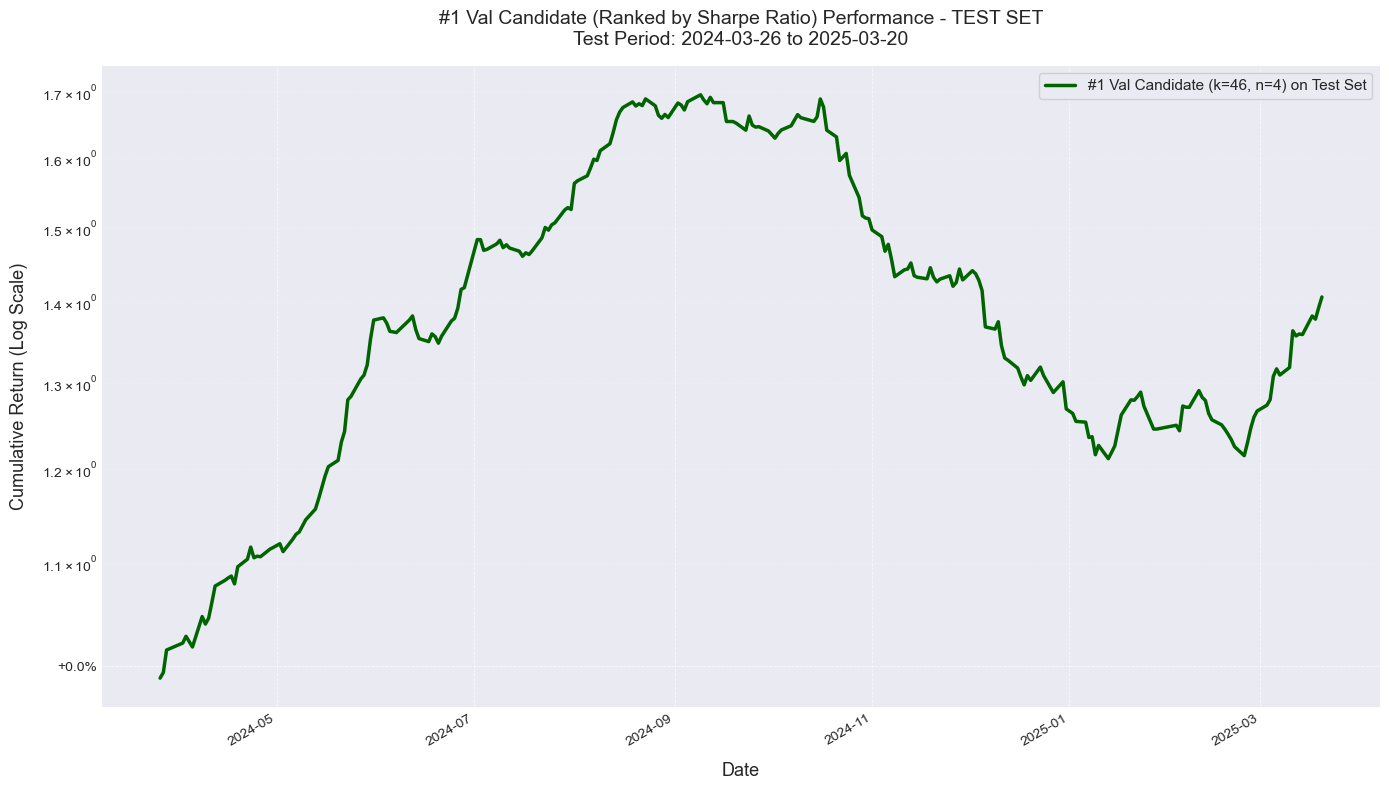

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd # Assuming daily_returns_plot is a pandas Series/DataFrame
import traceback

print("\n--- Plotting Validation Candidate Performance on TEST Period ---", flush=True)

if test_set_results and test_set_results[0] is not None:
    result_to_plot = test_set_results[0]
    k_plot = result_to_plot['k']
    n_plot = result_to_plot['n']
    daily_returns_plot = result_to_plot['test_daily_returns']
    # 'always_above_plot' was related to HSI, so it's removed.

    # Condition now only checks for the strategy's data
    plot_condition = (daily_returns_plot is not None and not daily_returns_plot.empty)

    if plot_condition:
        # Use the strategy's index directly
        strategy_index = daily_returns_plot.index
        if len(strategy_index) > 1:
            # Calculate cumulative returns directly from the available daily returns
            strategy_cumulative_final = (1 + daily_returns_plot).cumprod()
            try:
                plt.style.use('seaborn-v0_8-darkgrid')
                fig, ax = plt.subplots(figsize=(14, 8))

                line_color = 'darkgreen' # Standard color for the strategy
                # Plot only the strategy
                ax.plot(strategy_cumulative_final.index, strategy_cumulative_final,
                        label=f'#1 Val Candidate (k={k_plot}, n={n_plot}) on Test Set',
                        linewidth=2.5, color=line_color, zorder=10)

                # Update title and labels - remove HSI comparison
                start_date_str = strategy_index.min().strftime('%Y-%m-%d')
                end_date_str = strategy_index.max().strftime('%Y-%m-%d')
                # Removed outcome_str as it was HSI-related
                plot_title = f'#1 Val Candidate (Ranked by {VALIDATION_OPTIMIZATION_METRIC}) Performance - TEST SET\nTest Period: {start_date_str} to {end_date_str}'

                ax.set_title(plot_title, fontsize=14, pad=15)
                ax.set_ylabel('Cumulative Return (Log Scale)', fontsize=13, labelpad=10)
                ax.set_xlabel('Date', fontsize=13, labelpad=10)
                ax.set_yscale('log')
                ax.legend(loc='best', fontsize=11, frameon=True, framealpha=0.9)
                ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{y-1:+.1%}')) # Format y-axis as percentage return
                ax.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.7)
                ax.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
                plt.xticks(rotation=30, ha='right')
                plt.tight_layout()

                # Instead of saving, show the plot
                print("Displaying test set cumulative return plot...")
                plt.show()
                # plt.close(fig) # Usually not needed after plt.show() in interactive environments,
                               # but uncomment if the figure stays open unexpectedly or you need to free memory explicitly.

            except Exception as e:
                print(f"Error during plotting: {e}")
                traceback.print_exc()
        else:
            # Update message
            print("Skipping plot: Not enough data points (>1) for #1 strategy on test set.")
    else:
        # Update message
        print("Skipping plot: Data missing for #1 validation candidate on test set.")
else:
    print("Skipping plot: No candidates selected from validation (or result[2] is missing) to plot.")



--- === VISUALIZING BEST STRATEGY OVER FULL PERIOD === ---
Attempting to use k/n from test_set_results[0] if available...
Using k=46, n=4 from top test candidate.

--- Loading full original data from 'detailed_data_with_alphas_and_price.csv'... ---
Full data loaded. Shape: (99942, 9)

--- Calculating actual forward returns on full dataset... ---

--- Preparing features and generating predictions for full dataset... ---
Features scaled. Shape: (99942, 6)
 961/3124 ━━━━━━━━━━━━━━━━━━━━ 0s 156us/step

2025-05-01 02:51:21.834657: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-01 02:51:21.834977: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

3124/3124 ━━━━━━━━━━━━━━━━━━━━ 0s 156us/step
Predictions generated for full dataset. Shape: (99942,)
Dropped 83 rows with NaN actual_forward_return.
Full results DataFrame prepared for simulation. Shape: (99859, 3)

--- Running simulation for best k=46, n=4 over the FULL PERIOD... ---
--- Running Simulation (Full Period): k=46, n=4 ---
Finished Simulation (Full Period): k=46, n=4. CumReturn: 136.58%, Sharpe: 0.7125, Time: 0.35s
Full period simulation finished in 0.35 seconds.

--- Full Period Performance Metrics (Best k, n Strategy) ---
  - Cumulative Return: 1.3658
  - Annualized Return: 0.1936
  - Annualized Volatility: 0.3198
  - Sharpe Ratio: 0.7125
  - Max Drawdown: -0.3020
  - Trading Days: 1226
  - Positive Days %: 50.8157
  - Sortino Ratio: 1.1549
  - Drawdown Duration (Days): 326
  - Recovery Time (Days): 351

--- Plotting Full Period Performance with Markers ---
Full period plot saved to dnn_backtest_FULL_PERIOD_k46_n4_cumulative_return_log.png


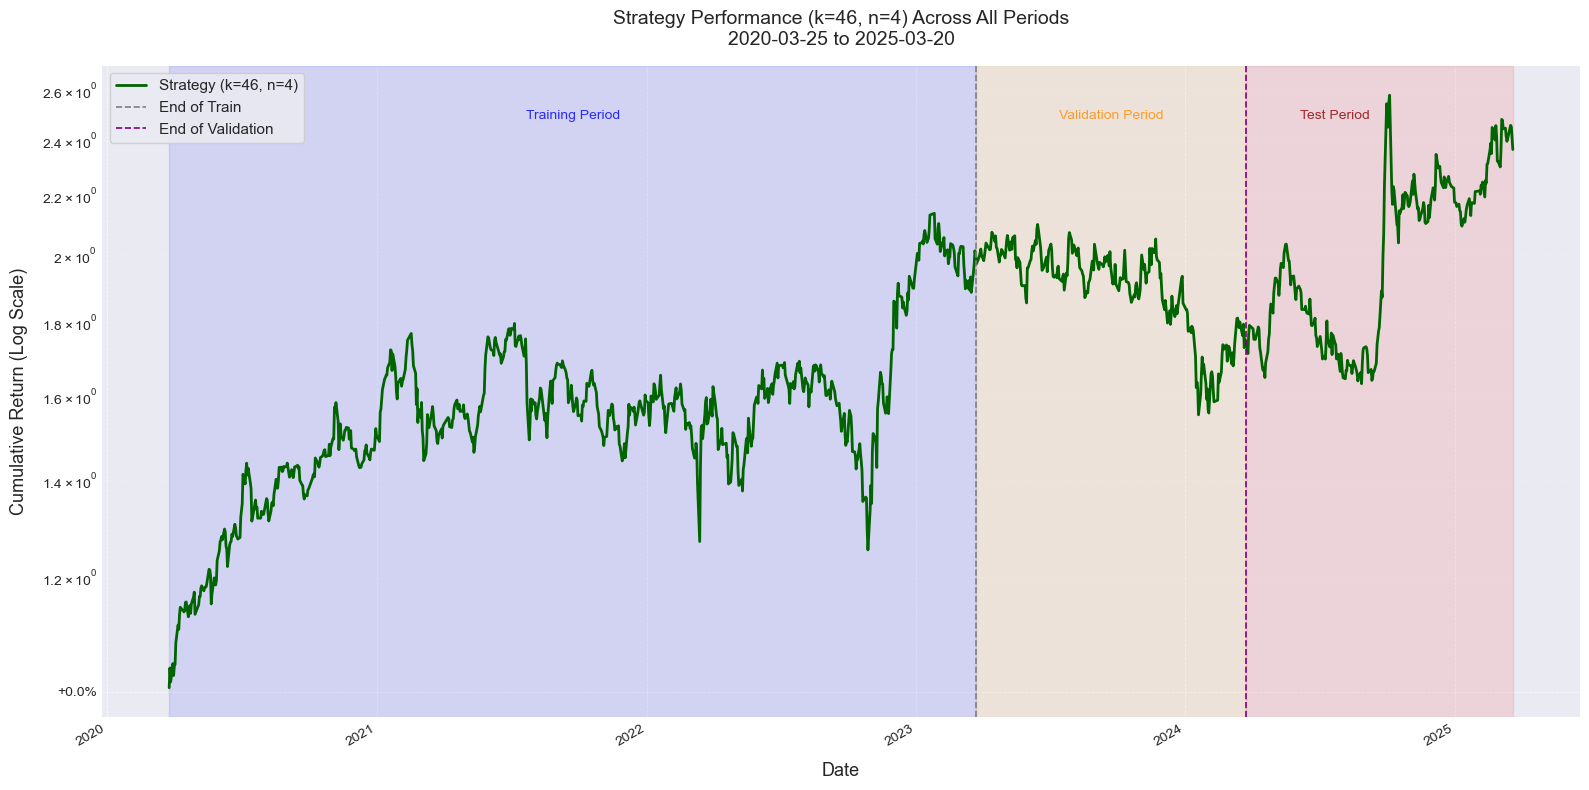


--- Full Period Visualization Script End ---


In [14]:
# === New Part: Visualize Strategy Performance Over Full Period ===

print("\n\n--- === VISUALIZING BEST STRATEGY OVER FULL PERIOD === ---", flush=True)

# --- Configuration for Full Period Visualization ---
FULL_PLOT_SAVE_PATH = f'dnn_backtest_FULL_PERIOD_k{best_k_val}_n{best_n_val}_cumulative_return_log.png' # Dynamic filename


if test_set_results:
    print("Attempting to use k/n from test_set_results[0] if available...")
    try:
        best_k_val = test_set_results[0]['k']
        best_n_val = test_set_results[0]['n']
        print(f"Using k={best_k_val}, n={best_n_val} from top test candidate.")
    except (IndexError, KeyError):
        print("ERROR: Still could not get best k/n. Exiting visualization part.")
        exit() # Or handle differently
else:
    exit() # Exit if no results at all

# --- 1. Load Full Original Data ---
print(f"\n--- Loading full original data from '{ORIGINAL_DETAILED_CSV}'... ---", flush=True)
try:
    full_data_df = pd.read_csv(ORIGINAL_DETAILED_CSV, parse_dates=['Date'])
    full_data_df.sort_values(by=['stock_id', 'Date'], inplace=True)
    full_data_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    print(f"Full data loaded. Shape: {full_data_df.shape}")

    # Basic check for required columns
    required_original_cols = set(feature_names) | {'Date', 'stock_id', 'price'}
    if not required_original_cols.issubset(full_data_df.columns):
        missing_cols = required_original_cols - set(full_data_df.columns)
        raise ValueError(f"Original data missing required columns: {missing_cols}")

except FileNotFoundError:
    print(f"ERROR: Original data file '{ORIGINAL_DETAILED_CSV}' not found.", flush=True)
    exit()
except Exception as e:
    print(f"Error loading or checking original data: {e}", flush=True)
    traceback.print_exc()
    exit()

# --- 2. Calculate Actual Forward Returns for Simulation Evaluation ---
# Need this on the full dataset for the simulation loop to calculate daily P/L
print("\n--- Calculating actual forward returns on full dataset... ---", flush=True)
full_data_df[f'price_t+{FORWARD_RETURN_PERIOD}'] = full_data_df.groupby('stock_id')['price'].shift(-FORWARD_RETURN_PERIOD)
full_data_df['actual_forward_return'] = np.where(
    full_data_df['price'] > 1e-9,
    (full_data_df[f'price_t+{FORWARD_RETURN_PERIOD}'] / full_data_df['price']) - 1,
    np.nan
)
full_data_df.replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf results again

# --- 3. Prepare Features and Generate Predictions for Full Dataset ---
print("\n--- Preparing features and generating predictions for full dataset... ---", flush=True)
try:
    # Drop rows where features or the actual_forward_return needed for simulation are NaN
    # Note: We predict on all rows with valid features, but simulation stops when actual_forward_return is NaN
    feature_cols_for_pred = full_data_df[feature_names].copy()

    # Handle NaNs in features (using forward/backward fill per stock is safest)
    initial_feature_nan = feature_cols_for_pred.isnull().sum().sum()
    if initial_feature_nan > 0:
        print(f"Found {initial_feature_nan} NaNs in features before scaling. Applying ffill/bfill per stock...")
        for col in feature_names:
             feature_cols_for_pred[col] = feature_cols_for_pred.groupby(full_data_df['stock_id'])[col].ffill()
             feature_cols_for_pred[col] = feature_cols_for_pred.groupby(full_data_df['stock_id'])[col].bfill()
        # Handle any remaining NaNs (e.g., fill with 0 or drop rows)
        remaining_feature_nan = feature_cols_for_pred.isnull().sum().sum()
        if remaining_feature_nan > 0:
            print(f"Warning: {remaining_feature_nan} NaNs remain in features after ffill/bfill. Filling with 0.")
            feature_cols_for_pred.fillna(0, inplace=True) # Or drop rows if preferred

    # Scale features using the loaded scaler
    X_full_scaled = scaler.transform(feature_cols_for_pred)
    print(f"Features scaled. Shape: {X_full_scaled.shape}")

    # Generate predictions
    full_predictions = model.predict(X_full_scaled).flatten()
    print(f"Predictions generated for full dataset. Shape: {full_predictions.shape}")

    # Add predictions and actual returns back to a working DataFrame
    # Important: Ensure alignment after any potential NaN handling/dropping
    full_results_df = full_data_df[['Date', 'stock_id', 'actual_forward_return']].copy()
    full_results_df['predicted_score'] = full_predictions

    # Critical: Drop rows where simulation cannot proceed (no actual forward return)
    # This defines the actual end date of the simulation's P/L calculation
    rows_before_drop = len(full_results_df)
    full_results_df.dropna(subset=['actual_forward_return'], inplace=True)
    rows_after_drop = len(full_results_df)
    print(f"Dropped {rows_before_drop - rows_after_drop} rows with NaN actual_forward_return.")

    # Check for NaNs in predicted scores (shouldn't happen if features handled)
    if full_results_df['predicted_score'].isnull().any():
        print("Warning: NaNs found in predicted scores after alignment. Filling with 0.")
        full_results_df['predicted_score'].fillna(0, inplace=True) # Or handle differently

    # Set Date index for simulation function
    full_results_df = full_results_df.sort_values(by=['Date', 'stock_id'])
    full_results_df = full_results_df.set_index('Date')
    print(f"Full results DataFrame prepared for simulation. Shape: {full_results_df.shape}")
    if full_results_df.empty:
         raise ValueError("Full results DataFrame is empty after preparation.")

except Exception as e:
    print(f"Error during full data preparation or prediction: {e}", flush=True)
    traceback.print_exc()
    exit()


# --- 4. Run Simulation for Best (k, n) Over Entire Period ---
print(f"\n--- Running simulation for best k={best_k_val}, n={best_n_val} over the FULL PERIOD... ---", flush=True)
start_sim_full = time.time()
# Use the actual_forward_return column for P/L calculation in the simulation
full_daily_returns, full_metrics = run_simulation(
    full_results_df.rename(columns={'actual_forward_return': 'actual_return'}), # Rename column to match function expectation
    best_k_val,
    best_n_val,
    period_name="Full Period"
)
sim_time_full = time.time() - start_sim_full
print(f"Full period simulation finished in {sim_time_full:.2f} seconds.")

# --- 5. Report Full Period Metrics ---
print("\n--- Full Period Performance Metrics (Best k, n Strategy) ---")
if not full_daily_returns.empty:
    [print(f"  - {metric}: {value:.4f}" if isinstance(value,(float, np.floating)) else f"  - {metric}: {value}") for metric, value in full_metrics.items()]
    # Calculate Cumulative Return for plotting
    full_cumulative_returns = (1 + full_daily_returns).cumprod()
else:
    print("  Simulation did not produce valid returns for the full period.")
    full_cumulative_returns = None


# --- 6. Plot Full Period Performance with Period Markers ---
print("\n--- Plotting Full Period Performance with Markers ---", flush=True)
if full_cumulative_returns is not None and not full_cumulative_returns.empty:
    try:
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, ax = plt.subplots(figsize=(16, 8)) # Wider figure

        # Plot the strategy cumulative return
        ax.plot(full_cumulative_returns.index, full_cumulative_returns,
                label=f'Strategy (k={best_k_val}, n={best_n_val})',
                linewidth=2.0, color='darkgreen')

        # Define period boundaries
        train_start_date = full_cumulative_returns.index.min()
        train_end_date_dt = pd.to_datetime(TRAIN_END_DATE)
        validation_end_date_dt = pd.to_datetime(VALIDATION_END_DATE)
        actual_end_date = full_cumulative_returns.index.max()

        # Add vertical lines for period boundaries
        ax.axvline(train_end_date_dt, color='grey', linestyle='--', linewidth=1.2, label='End of Train')
        ax.axvline(validation_end_date_dt, color='purple', linestyle='--', linewidth=1.2, label='End of Validation')
        # Optional: Add line for end of the original test period if desired
        # test_end_date_actual = test_results_df.index.max() # Get from previous script if needed
        # ax.axvline(test_end_date_actual, color='red', linestyle=':', linewidth=1.0, label='End of Original Test')

        # Add shaded regions for periods (adjust alpha for visibility)
        ax.axvspan(train_start_date, train_end_date_dt, alpha=0.1, color='blue', label='_nolegend_')
        ax.axvspan(train_end_date_dt, validation_end_date_dt, alpha=0.1, color='orange', label='_nolegend_')
        ax.axvspan(validation_end_date_dt, actual_end_date, alpha=0.1, color='red', label='_nolegend_') # Test + Post-Test combined shading

        # Add text labels for periods
        y_min, y_max = ax.get_ylim()
        text_y_pos = y_min + (y_max - y_min) * 0.90 # Position text near the top

        # Adjust x-position slightly into the period
        train_text_x = train_start_date + (train_end_date_dt - train_start_date) / 2
        val_text_x = train_end_date_dt + (validation_end_date_dt - train_end_date_dt) / 2
        test_text_x = validation_end_date_dt + (actual_end_date - validation_end_date_dt) / 3 # Position within test span

        ax.text(train_text_x, text_y_pos, 'Training Period', horizontalalignment='center', fontsize=10, color='blue', alpha=0.8)
        ax.text(val_text_x, text_y_pos, 'Validation Period', horizontalalignment='center', fontsize=10, color='darkorange', alpha=0.8)
        ax.text(test_text_x, text_y_pos, 'Test Period', horizontalalignment='center', fontsize=10, color='darkred', alpha=0.8)


        # Formatting
        start_date_str = train_start_date.strftime('%Y-%m-%d')
        end_date_str = actual_end_date.strftime('%Y-%m-%d') # Use actual end date from simulation
        plot_title = f'Strategy Performance (k={best_k_val}, n={best_n_val}) Across All Periods\n{start_date_str} to {end_date_str}'

        ax.set_title(plot_title, fontsize=14, pad=15)
        ax.set_ylabel('Cumulative Return (Log Scale)', fontsize=13, labelpad=10)
        ax.set_xlabel('Date', fontsize=13, labelpad=10)
        ax.set_yscale('log')
        ax.legend(loc='upper left', fontsize=11, frameon=True, framealpha=0.9) # Legend for strategy and lines
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{y-1:+.1%}')) # Format y-axis as percentage return
        ax.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.7)
        ax.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
        plt.xticks(rotation=30, ha='right')
        plt.tight_layout()

        # Save or show the plot
        plt.savefig(FULL_PLOT_SAVE_PATH, dpi=150)
        print(f"Full period plot saved to {FULL_PLOT_SAVE_PATH}")
        plt.show() # Display the plot as well
        # plt.close(fig) # Optional

    except Exception as e:
        print(f"Error during full period plotting: {e}")
        traceback.print_exc()
else:
    print("Skipping full period plot: No valid cumulative returns generated.")

print("\n--- Full Period Visualization Script End ---", flush=True)

## Add other benchmarks to compare



--- === VISUALIZING BEST STRATEGY OVER FULL PERIOD === ---
Attempting to use k/n from test_set_results[0] if available...
Using k=46, n=4 from top test candidate.

--- Loading full original data from 'detailed_data_with_alphas_and_price.csv'... ---


Full data loaded. Shape: (99942, 9)

--- Calculating actual forward returns on full dataset... ---

--- Preparing features and generating predictions for full dataset... ---
Features scaled. Shape: (99942, 6)
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 1s 162us/step
Predictions generated for full dataset. Shape: (99942,)
Dropped 83 rows with NaN actual_forward_return.
Full results DataFrame prepared for simulation. Shape: (99859, 3)

--- Running simulation for best k=46, n=4 over the FULL PERIOD... ---
--- Running Simulation (Full Period): k=46, n=4 ---
Finished Simulation (Full Period): k=46, n=4. CumReturn: 136.58%, Sharpe: 0.7125, Time: 0.35s
Full period simulation finished in 0.35 seconds.

--- Full Period Performance Metrics (Best k, n Strategy) ---
  - Cumulative Return: 1.3658
  - Annualized Return: 0.1936
  - Annualized Volatility: 0.3198
  - Sharpe Ratio: 0.7125
  - Max Drawdown: -0.3020
  - Trading Days: 1226
  - Positive Days %: 50.8157
  - Sortino Ratio: 1.1549
  - Drawdown Duration (Da

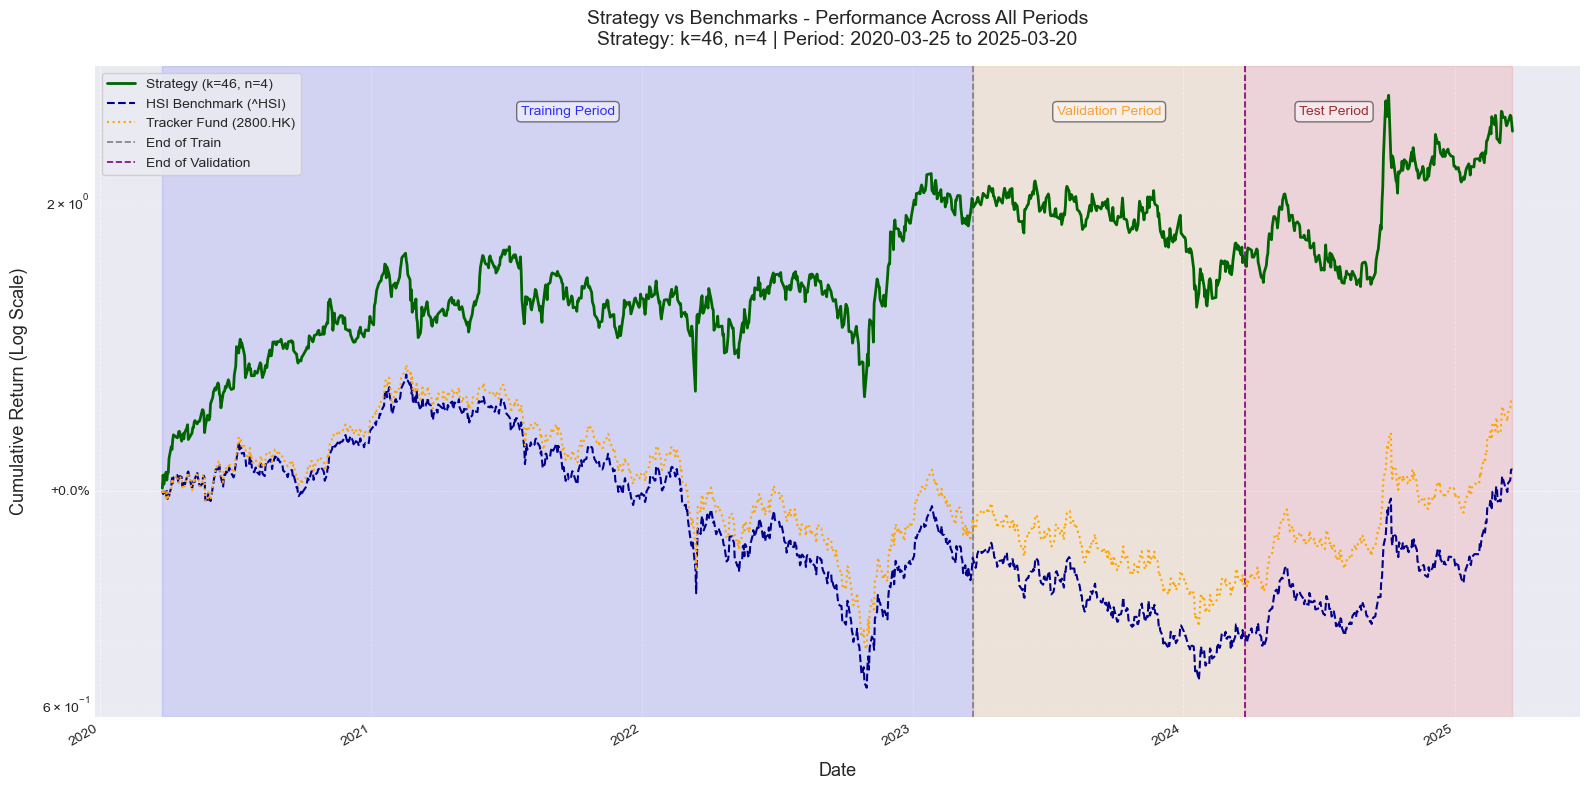


--- Full Period Visualization Script End ---


In [15]:
# === New Part: Visualize Strategy Performance Over Full Period ===

print("\n\n--- === VISUALIZING BEST STRATEGY OVER FULL PERIOD === ---", flush=True)

# --- Configuration for Full Period Visualization ---
FULL_PLOT_SAVE_PATH = f'dnn_backtest_FULL_PERIOD_k{best_k_val}_n{best_n_val}_cumulative_return_log.png' # Dynamic filename


if test_set_results:
    print("Attempting to use k/n from test_set_results[0] if available...")
    try:
        best_k_val = test_set_results[0]['k']
        best_n_val = test_set_results[0]['n']
        print(f"Using k={best_k_val}, n={best_n_val} from top test candidate.")
    except (IndexError, KeyError):
        print("ERROR: Still could not get best k/n. Exiting visualization part.")
        exit() # Or handle differently
else:
    exit() # Exit if no results at all

# --- 1. Load Full Original Data ---
print(f"\n--- Loading full original data from '{ORIGINAL_DETAILED_CSV}'... ---", flush=True)
try:
    full_data_df = pd.read_csv(ORIGINAL_DETAILED_CSV, parse_dates=['Date'])
    full_data_df.sort_values(by=['stock_id', 'Date'], inplace=True)
    full_data_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    print(f"Full data loaded. Shape: {full_data_df.shape}")

    # Basic check for required columns
    required_original_cols = set(feature_names) | {'Date', 'stock_id', 'price'}
    if not required_original_cols.issubset(full_data_df.columns):
        missing_cols = required_original_cols - set(full_data_df.columns)
        raise ValueError(f"Original data missing required columns: {missing_cols}")

except FileNotFoundError:
    print(f"ERROR: Original data file '{ORIGINAL_DETAILED_CSV}' not found.", flush=True)
    exit()
except Exception as e:
    print(f"Error loading or checking original data: {e}", flush=True)
    traceback.print_exc()
    exit()

# --- 2. Calculate Actual Forward Returns for Simulation Evaluation ---
# Need this on the full dataset for the simulation loop to calculate daily P/L
print("\n--- Calculating actual forward returns on full dataset... ---", flush=True)
full_data_df[f'price_t+{FORWARD_RETURN_PERIOD}'] = full_data_df.groupby('stock_id')['price'].shift(-FORWARD_RETURN_PERIOD)
full_data_df['actual_forward_return'] = np.where(
    full_data_df['price'] > 1e-9,
    (full_data_df[f'price_t+{FORWARD_RETURN_PERIOD}'] / full_data_df['price']) - 1,
    np.nan
)
full_data_df.replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf results again

# --- 3. Prepare Features and Generate Predictions for Full Dataset ---
print("\n--- Preparing features and generating predictions for full dataset... ---", flush=True)
try:
    # Drop rows where features or the actual_forward_return needed for simulation are NaN
    # Note: We predict on all rows with valid features, but simulation stops when actual_forward_return is NaN
    feature_cols_for_pred = full_data_df[feature_names].copy()

    # Handle NaNs in features (using forward/backward fill per stock is safest)
    initial_feature_nan = feature_cols_for_pred.isnull().sum().sum()
    if initial_feature_nan > 0:
        print(f"Found {initial_feature_nan} NaNs in features before scaling. Applying ffill/bfill per stock...")
        for col in feature_names:
             feature_cols_for_pred[col] = feature_cols_for_pred.groupby(full_data_df['stock_id'])[col].ffill()
             feature_cols_for_pred[col] = feature_cols_for_pred.groupby(full_data_df['stock_id'])[col].bfill()
        # Handle any remaining NaNs (e.g., fill with 0 or drop rows)
        remaining_feature_nan = feature_cols_for_pred.isnull().sum().sum()
        if remaining_feature_nan > 0:
            print(f"Warning: {remaining_feature_nan} NaNs remain in features after ffill/bfill. Filling with 0.")
            feature_cols_for_pred.fillna(0, inplace=True) # Or drop rows if preferred

    # Scale features using the loaded scaler
    X_full_scaled = scaler.transform(feature_cols_for_pred)
    print(f"Features scaled. Shape: {X_full_scaled.shape}")

    # Generate predictions
    full_predictions = model.predict(X_full_scaled).flatten()
    print(f"Predictions generated for full dataset. Shape: {full_predictions.shape}")

    # Add predictions and actual returns back to a working DataFrame
    # Important: Ensure alignment after any potential NaN handling/dropping
    full_results_df = full_data_df[['Date', 'stock_id', 'actual_forward_return']].copy()
    full_results_df['predicted_score'] = full_predictions

    # Critical: Drop rows where simulation cannot proceed (no actual forward return)
    # This defines the actual end date of the simulation's P/L calculation
    rows_before_drop = len(full_results_df)
    full_results_df.dropna(subset=['actual_forward_return'], inplace=True)
    rows_after_drop = len(full_results_df)
    print(f"Dropped {rows_before_drop - rows_after_drop} rows with NaN actual_forward_return.")

    # Check for NaNs in predicted scores (shouldn't happen if features handled)
    if full_results_df['predicted_score'].isnull().any():
        print("Warning: NaNs found in predicted scores after alignment. Filling with 0.")
        full_results_df['predicted_score'].fillna(0, inplace=True) # Or handle differently

    # Set Date index for simulation function
    full_results_df = full_results_df.sort_values(by=['Date', 'stock_id'])
    full_results_df = full_results_df.set_index('Date')
    print(f"Full results DataFrame prepared for simulation. Shape: {full_results_df.shape}")
    if full_results_df.empty:
         raise ValueError("Full results DataFrame is empty after preparation.")

except Exception as e:
    print(f"Error during full data preparation or prediction: {e}", flush=True)
    traceback.print_exc()
    exit()


# --- 4. Run Simulation for Best (k, n) Over Entire Period ---
print(f"\n--- Running simulation for best k={best_k_val}, n={best_n_val} over the FULL PERIOD... ---", flush=True)
start_sim_full = time.time()
# Use the actual_forward_return column for P/L calculation in the simulation
full_daily_returns, full_metrics = run_simulation(
    full_results_df.rename(columns={'actual_forward_return': 'actual_return'}), # Rename column to match function expectation
    best_k_val,
    best_n_val,
    period_name="Full Period"
)
sim_time_full = time.time() - start_sim_full
print(f"Full period simulation finished in {sim_time_full:.2f} seconds.")

# --- 5. Report Full Period Metrics ---
print("\n--- Full Period Performance Metrics (Best k, n Strategy) ---")
if not full_daily_returns.empty:
    [print(f"  - {metric}: {value:.4f}" if isinstance(value,(float, np.floating)) else f"  - {metric}: {value}") for metric, value in full_metrics.items()]
    # Calculate Cumulative Return for plotting
    full_cumulative_returns = (1 + full_daily_returns).cumprod()
else:
    print("  Simulation did not produce valid returns for the full period.")
    full_cumulative_returns = None # Set to None if simulation failed


# --- NEW: 5b. Calculate Benchmark Returns for Full Period ---
print("\n--- Calculating Benchmark Returns for Full Period (^HSI, 2800.HK) ---", flush=True)
hsi_cumulative_aligned = None
tracker_cumulative_aligned = None

# Only proceed if the strategy simulation was successful
if full_cumulative_returns is not None and not full_cumulative_returns.empty:
    # Determine date range from strategy results
    full_start_date = full_cumulative_returns.index.min()
    full_end_date = full_cumulative_returns.index.max()
    # Add buffer for download
    download_start = full_start_date
    download_end = full_end_date
    print(f"Benchmark download range: {download_start.date()} to {download_end.date()}")

    benchmarks_to_plot = {
        '^HSI': {'label': 'HSI Benchmark (^HSI)', 'color': 'darkblue', 'style': '--'},
        '2800.HK': {'label': 'Tracker Fund (2800.HK)', 'color': 'orange', 'style': ':'}
    }
    benchmark_cumulative_data = {} # Store aligned data

    for ticker, details in benchmarks_to_plot.items():
        print(f"  Downloading {ticker}...")
        try:
            bench_data = yf.download(ticker, start=download_start, end=download_end, auto_adjust=True, progress=False)
            if bench_data.empty:
                print(f"  WARNING: No data downloaded for {ticker}.")
                continue

            # Ensure timezone naive
            if bench_data.index.tz is not None:
                bench_data.index = bench_data.index.tz_localize(None)

            # Calculate daily and cumulative returns
            bench_data['daily_return'] = bench_data['Close'].pct_change()
            # Start cumulative return from 1.0
            bench_cumulative_raw = (1 + bench_data['daily_return'].fillna(0)).cumprod()

            # Align to strategy dates using reindex and ffill
            print(f"  Aligning {ticker} to strategy dates...")
            aligned_data = bench_cumulative_raw.reindex(full_cumulative_returns.index).ffill().dropna()

            if not aligned_data.empty:
                benchmark_cumulative_data[ticker] = aligned_data
                print(f"  {ticker} aligned successfully.")
            else:
                print(f"  WARNING: {ticker} alignment resulted in empty series.")

        except Exception as e:
            print(f"  ERROR processing benchmark {ticker}: {e}")
            traceback.print_exc()

    # Assign to specific variables used later in plotting if needed
    hsi_cumulative_aligned = benchmark_cumulative_data.get('^HSI')
    tracker_cumulative_aligned = benchmark_cumulative_data.get('2800.HK')

else:
    print("Skipping benchmark calculation as strategy simulation failed.")


# --- 6. Plot Full Period Performance with Period Markers (and Benchmarks) ---
print("\n--- Plotting Full Period Performance with Markers and Benchmarks ---", flush=True) # Updated title

if full_cumulative_returns is not None and not full_cumulative_returns.empty:
    try:
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, ax = plt.subplots(figsize=(16, 8)) # Wider figure

        # --- Plot Strategy ---
        ax.plot(full_cumulative_returns.index, full_cumulative_returns,
                label=f'Strategy (k={best_k_val}, n={best_n_val})',
                linewidth=2.0, color='darkgreen', zorder=10) # Use zorder to keep strategy on top

        # --- Plot Benchmarks (if available) ---
        if hsi_cumulative_aligned is not None and not hsi_cumulative_aligned.empty:
            ax.plot(hsi_cumulative_aligned.index, hsi_cumulative_aligned,
                    label=benchmarks_to_plot['^HSI']['label'],
                    color=benchmarks_to_plot['^HSI']['color'],
                    linestyle=benchmarks_to_plot['^HSI']['style'],
                    linewidth=1.5, zorder=5) # Lower zorder
        else:
            print("  Note: HSI Benchmark data not available for plotting.")

        if tracker_cumulative_aligned is not None and not tracker_cumulative_aligned.empty:
             ax.plot(tracker_cumulative_aligned.index, tracker_cumulative_aligned,
                     label=benchmarks_to_plot['2800.HK']['label'],
                     color=benchmarks_to_plot['2800.HK']['color'],
                     linestyle=benchmarks_to_plot['2800.HK']['style'],
                     linewidth=1.5, zorder=5) # Lower zorder
        else:
             print("  Note: Tracker Fund (2800.HK) data not available for plotting.")

        # --- Define period boundaries (Keep as is) ---
        train_start_date = full_cumulative_returns.index.min()
        train_end_date_dt = pd.to_datetime(TRAIN_END_DATE)
        validation_end_date_dt = pd.to_datetime(VALIDATION_END_DATE)
        actual_end_date = full_cumulative_returns.index.max()

        # --- Add vertical lines and shading (Keep as is) ---
        ax.axvline(train_end_date_dt, color='grey', linestyle='--', linewidth=1.2, label='End of Train')
        ax.axvline(validation_end_date_dt, color='purple', linestyle='--', linewidth=1.2, label='End of Validation')
        # Shading
        ax.axvspan(train_start_date, train_end_date_dt, alpha=0.1, color='blue', label='_nolegend_')
        ax.axvspan(train_end_date_dt, validation_end_date_dt, alpha=0.1, color='orange', label='_nolegend_')
        ax.axvspan(validation_end_date_dt, actual_end_date, alpha=0.1, color='red', label='_nolegend_')

        # --- Add text labels for periods (Keep as is) ---
        # Recalculate y_min/y_max *after* plotting everything to ensure text is placed correctly
        plt.draw() # Force draw to update axes limits if using interactive backend
        y_min, y_max = ax.get_ylim()
        # Adjust y-position if log scale causes issues near 1.0
        if ax.get_yscale() == 'log':
             # Position text based on log range
             log_y_min, log_y_max = np.log10(y_min), np.log10(y_max)
             text_log_y = log_y_min + (log_y_max - log_y_min) * 0.90
             text_y_pos = 10**text_log_y
        else:
            text_y_pos = y_min + (y_max - y_min) * 0.90

        # Text X positions (Keep as is)
        train_text_x = train_start_date + (train_end_date_dt - train_start_date) / 2
        val_text_x = train_end_date_dt + (validation_end_date_dt - train_end_date_dt) / 2
        test_text_x = validation_end_date_dt + (actual_end_date - validation_end_date_dt) / 3

        ax.text(train_text_x, text_y_pos, 'Training Period', horizontalalignment='center', fontsize=10, color='blue', alpha=0.8, bbox=dict(facecolor='white', alpha=0.5, pad=0.2, boxstyle='round,pad=0.3'))
        ax.text(val_text_x, text_y_pos, 'Validation Period', horizontalalignment='center', fontsize=10, color='darkorange', alpha=0.8, bbox=dict(facecolor='white', alpha=0.5, pad=0.2, boxstyle='round,pad=0.3'))
        ax.text(test_text_x, text_y_pos, 'Test Period', horizontalalignment='center', fontsize=10, color='darkred', alpha=0.8, bbox=dict(facecolor='white', alpha=0.5, pad=0.2, boxstyle='round,pad=0.3'))


        # --- Formatting (Keep mostly as is, adjust title/legend) ---
        start_date_str = train_start_date.strftime('%Y-%m-%d')
        end_date_str = actual_end_date.strftime('%Y-%m-%d') # Use actual end date from simulation
        plot_title = f'Strategy vs Benchmarks - Performance Across All Periods\nStrategy: k={best_k_val}, n={best_n_val} | Period: {start_date_str} to {end_date_str}' # Updated Title

        ax.set_title(plot_title, fontsize=14, pad=15)
        ax.set_ylabel('Cumulative Return (Log Scale)', fontsize=13, labelpad=10)
        ax.set_xlabel('Date', fontsize=13, labelpad=10)
        ax.set_yscale('log')
        ax.legend(loc='upper left', fontsize=10, frameon=True, framealpha=0.9) # Adjusted font size potentially
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{y-1:+.1%}')) # Format y-axis as percentage return
        ax.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.7)
        ax.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
        plt.xticks(rotation=30, ha='right')
        plt.tight_layout()

        # --- Save or show the plot ---
        plt.savefig(FULL_PLOT_SAVE_PATH, dpi=150)
        print(f"Full period plot saved to {FULL_PLOT_SAVE_PATH}")
        plt.show() # Uncomment if you want interactive display
        plt.close(fig) # Close figure after saving

    except Exception as e:
        print(f"Error during full period plotting: {e}")
        traceback.print_exc()
else:
    print("Skipping full period plot: No valid cumulative returns generated for the strategy.")

print("\n--- Full Period Visualization Script End ---", flush=True)

## Simulation of the strategy over full and extended period



--- === VISUALIZING BEST STRATEGY OVER FULL & EXTENDED PERIOD === ---
--- Assumed Starting Strategy Capital: $1,000,000.00 ---
Using k=46, n=4 from top test candidate.

--- Loading original full data from 'detailed_data_with_alphas_and_price.csv'... ---
Original data loaded. Ends on: 2025-03-21

--- Fetching new yfinance data from 2025-03-22 to 2025-05-02 ---
New data fetched. Shape: (2075, 7). Min Date: 2025-03-24, Max Date: 2025-04-30

--- Calculating alpha factors for the new data period... ---
New alphas calculated. Shape: (2075, 9)

--- Combining original and new alpha/price data... ---
Combined data shape: (102017, 9). Date range: 2020-03-24 to 2025-04-30

--- Recalculating actual forward returns on combined dataset... ---

--- Preparing features and predicting for the combined dataset... ---
Found 8383 NaNs in combined features. Applying ffill/bfill per stock...
 950/3189 ━━━━━━━━━━━━━━━━━━━━ 0s 158us/step

2025-05-01 02:52:22.892595: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-01 02:52:22.892956: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

3189/3189 ━━━━━━━━━━━━━━━━━━━━ 1s 162us/step
Dropped 83 rows with NaN actual_forward_return.
Final simulation data prepared. Actual end date for simulation: 2025-04-29

--- Running simulation for k=46, n=4 over the EXTENDED PERIOD... ---
--- Running Simulation (Extended Period): k=46, n=4 ---
Finished Simulation (Extended Period): k=46, n=4. CumReturn: 124.37%, Sharpe: 0.6660, Time: 0.35s
Extended period simulation finished in 0.36 seconds.

--- Extended Period Performance Metrics (Best k, n Strategy) ---
  - Cumulative Return: 1.2437
  - Annualized Return: 0.1768
  - Annualized Volatility: 0.3221
  - Sharpe Ratio: 0.6660
  - Max Drawdown: -0.3020
  - Trading Days: 1251
  - Positive Days %: 51.0791
  - Sortino Ratio: 1.0343
  - Drawdown Duration (Days): 326
  - Recovery Time (Days): 351

--- Extended Period Performance Metrics (HSI Benchmark: ^HSI) ---
  Benchmark download range: 2020-03-25 to 2025-04-29
  Aligning HSI daily returns...
  Calculating HSI metrics...
  - Cumulative Return

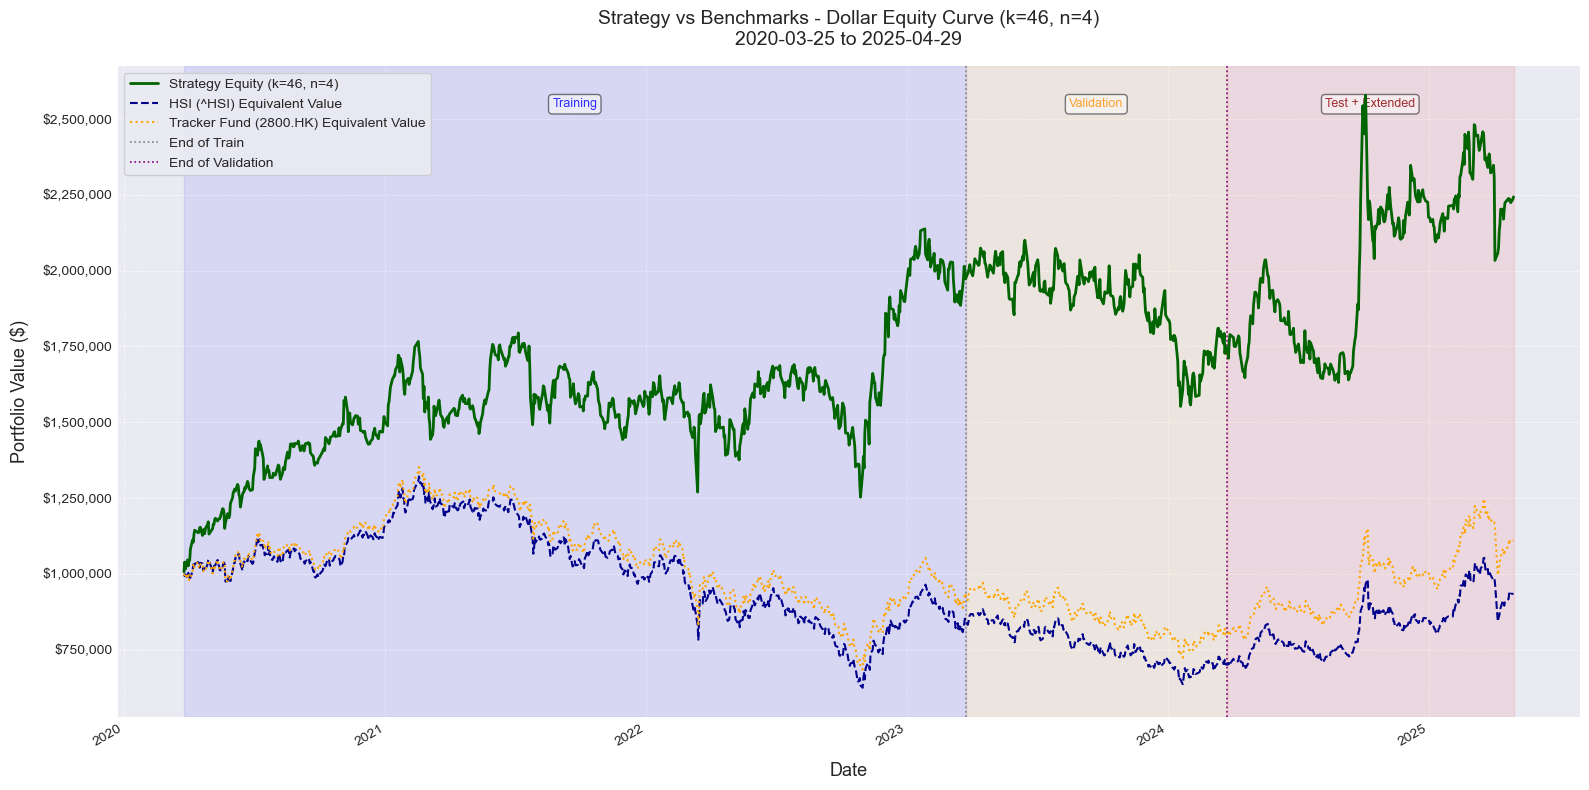


--- Full Period Visualization Script End ---


In [16]:
# === New Part: Visualize Strategy Performance Over Full & Extended Period ===

# Ensure necessary imports are present from the start of the script
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd # Make sure pandas is imported
import numpy as np # Make sure numpy is imported
import matplotlib.pyplot as plt # For plotting
import matplotlib.ticker as mtick # For plotting formatters
import traceback # For error details
import ta
from datetime import date
# Need the alpha calculation functions from Script 1
# Make sure calculate_all_alpha_factors and its dependencies are defined above
# Make sure TICKERS list is defined (from Script 1 config)
# Make sure feature_names list is defined (loaded earlier)
# Make sure scaler and model are loaded
# Make sure best_k_val and best_n_val are defined

TICKERS = ["0001.HK", "0002.HK", "0003.HK", "0005.HK", "0006.HK", "0011.HK", '0012.HK', '0016.HK', '0027.HK', '0066.HK', '0101.HK', '0175.HK', '0241.HK', '0267.HK', '0285.HK', '0288.HK', '0291.HK', '0316.HK',
           "0322.HK", '0386.HK', '0388.HK', '0669.HK', '0688.HK', '0700.HK', '0762.HK', '0823.HK', '0836.HK', '0857.HK', '0868.HK', '0881.HK', '0883.HK', '0939.HK', '0941.HK', '0960.HK', '0968.HK', '0981.HK',
           "0992.HK", "1024.HK", '1038.HK', '1044.HK', '1088.HK', "1093.HK", '1099.HK', '1109.HK', '1113.HK', '1177.HK', '1209.HK', '1211.HK', '1299.HK', '1378.HK', '1398.HK', '1810.HK', '1876.HK', '1928.HK',
           '1929.HK', '1997.HK', '2015.HK', '2020.HK', '2269.HK', '2313.HK', '2318.HK', '2319.HK', '2331.HK', '2359.HK', '2382.HK', '2388.HK', '2628.HK', '2688.HK', '2899.HK', '3690.HK', '3692.HK', '3968.HK',
           '3988.HK', '6618.HK', '6690.HK', '6862.HK', '9618.HK', '9633.HK', '9888.HK', '9901.HK', '9961.HK', '9988.HK', '9999.HK']

# Format Y-axis as dollars with commas using FuncFormatter
def dollar_formatter(x, pos):
    if abs(x) < 1: return '$0'
    return '${:,.0f}'.format(x)

print("\n\n--- === VISUALIZING BEST STRATEGY OVER FULL & EXTENDED PERIOD === ---", flush=True)

# --- Configuration for Extended Period Visualization ---
EXTEND_SIMULATION_END_DATE_STR =  date.today() # User specified end date
EXTEND_SIMULATION_END_DATE = pd.to_datetime(EXTEND_SIMULATION_END_DATE_STR)
TOTAL_STRATEGY_CAPITAL = 1000000
print(f"--- Assumed Starting Strategy Capital: ${TOTAL_STRATEGY_CAPITAL:,.2f} ---")

# --- Determine Best k/n ---
if 'test_set_results' in globals() and test_set_results:
    try: 
        best_k_val = test_set_results[0]['k']
        best_n_val = test_set_results[0]['n']
        print(f"Using k={best_k_val}, n={best_n_val} from top test candidate.")
    except (IndexError, KeyError, TypeError): print("ERROR: Could not extract k/n from test_set_results. Exiting."); exit()
else: print("ERROR: 'test_set_results' not found or empty. Cannot determine best k/n. Exiting."); exit()

FULL_PLOT_SAVE_PATH = f'dnn_backtest_EXTENDED_PERIOD_k{best_k_val}_n{best_n_val}_dollar_equity_curve.png'

# --- 1. Load Original Full Data (If not already loaded/modified) ---
print(f"\n--- Loading original full data from '{ORIGINAL_DETAILED_CSV}'... ---", flush=True)
try:
    original_data_df = pd.read_csv(ORIGINAL_DETAILED_CSV, parse_dates=['Date'])
    original_data_df.sort_values(by=['stock_id', 'Date'], inplace=True)
    original_end_date = original_data_df['Date'].max()
    print(f"Original data loaded. Ends on: {original_end_date.date()}")
except Exception as e:
    print(f"Error loading original data: {e}", flush=True); traceback.print_exc(); exit()

# --- 2. Fetch New Data for Extension Period ---
fetch_start_date = original_end_date + timedelta(days=1)
# Need data up to END_DATE + 1 day for forward return calc on END_DATE
fetch_end_date = EXTEND_SIMULATION_END_DATE + timedelta(days=1)

print(f"\n--- Fetching new yfinance data from {fetch_start_date.date()} to {fetch_end_date.date()} ---", flush=True)
new_data_list = []
failed_tickers = []
for ticker in TICKERS:
    try:
        # Download new OHLCV data
        data_new = yf.download(ticker, start=fetch_start_date, end=fetch_end_date,
                               auto_adjust=True, progress=False, ignore_tz=True)
        if not data_new.empty:
            if isinstance(data_new.columns, pd.MultiIndex): data_new.columns = data_new.columns.get_level_values(0)
            data_new['stock_id'] = ticker
            data_new.reset_index(inplace=True) # Bring 'Date' column in
            # Standardize Date column name again if needed
            if 'Datetime' in data_new.columns: data_new.rename(columns={'Datetime': 'Date'}, inplace=True)
            if 'Date' in data_new.columns: new_data_list.append(data_new[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'stock_id']])
            else: print(f"Warning: No 'Date' column in new data for {ticker}.")
        # else: print(f"No new data found for {ticker} in the specified range.") # Can be noisy

    except Exception as e:
        print(f"ERROR fetching new data for {ticker}: {e}")
        failed_tickers.append(ticker)

if not new_data_list:
    print("ERROR: Failed to fetch any new data for the extension period. Cannot proceed.")
    exit()

new_data_df = pd.concat(new_data_list, ignore_index=True)
new_data_df['Date'] = pd.to_datetime(new_data_df['Date'])
new_data_df.sort_values(by=['stock_id', 'Date'], inplace=True)
print(f"New data fetched. Shape: {new_data_df.shape}. Min Date: {new_data_df['Date'].min().date()}, Max Date: {new_data_df['Date'].max().date()}")
if failed_tickers: print(f"Warning: Failed to fetch new data for tickers: {failed_tickers}")


# --- 3. Calculate Alphas for New Data Period ---
print("\n--- Calculating alpha factors for the new data period... ---", flush=True)
new_alpha_data_list = []
for ticker in new_data_df['stock_id'].unique():
     ticker_data_new = new_data_df[new_data_df['stock_id'] == ticker].copy()
     # Ensure consistent 'Volume' column name if needed by alpha funcs
     # if 'Volume' not in ticker_data_new.columns and 'Trading_Volume' in ticker_data_new.columns:
     #      ticker_data_new.rename(columns={'Trading_Volume':'Volume'}, inplace=True)

     try:
         # Need to ensure calculate_all_alpha_factors is defined and works stand-alone
         alpha_data_new = calculate_all_alpha_factors(ticker_data_new)
         alpha_data_new['stock_id'] = ticker # Ensure stock_id persists
         # Keep only Date, stock_id, and calculated alpha columns (feature_names) + price ('Close')
         cols_to_keep = ['Date', 'stock_id', 'Close'] + feature_names
         existing_cols = [col for col in cols_to_keep if col in alpha_data_new.columns]
         new_alpha_data_list.append(alpha_data_new[existing_cols])
     except Exception as e:
         print(f"ERROR calculating alphas for {ticker} in new period: {e}")

if not new_alpha_data_list:
    print("ERROR: Failed to calculate any alpha factors for the new data period.")
    exit()

new_alphas_df = pd.concat(new_alpha_data_list, ignore_index=True)
new_alphas_df.sort_values(by=['stock_id', 'Date'], inplace=True)
# Rename 'Close' to 'price' to match original data structure for consistency
if 'Close' in new_alphas_df.columns: new_alphas_df.rename(columns={'Close':'price'}, inplace=True)
print(f"New alphas calculated. Shape: {new_alphas_df.shape}")


# --- 4. Combine Original Data (with Alphas) and New Data (with Alphas) ---
print("\n--- Combining original and new alpha/price data... ---", flush=True)
# Select necessary columns from original data (already has alphas)
original_cols_to_keep = ['Date', 'stock_id', 'price'] + feature_names
original_data_subset = original_data_df[original_cols_to_keep].copy()

# Combine the two periods
combined_data_df = pd.concat([original_data_subset, new_alphas_df], ignore_index=True)
combined_data_df.sort_values(by=['stock_id', 'Date'], inplace=True)
# Remove potential duplicate rows (e.g., if fetch_start_date overlapped)
combined_data_df.drop_duplicates(subset=['Date', 'stock_id'], keep='last', inplace=True)
print(f"Combined data shape: {combined_data_df.shape}. Date range: {combined_data_df['Date'].min().date()} to {combined_data_df['Date'].max().date()}")


# --- 5. Recalculate Forward Returns on Combined Data ---
print("\n--- Recalculating actual forward returns on combined dataset... ---", flush=True)
combined_data_df[f'price_t+{FORWARD_RETURN_PERIOD}'] = combined_data_df.groupby('stock_id')['price'].shift(-FORWARD_RETURN_PERIOD)
combined_data_df['actual_forward_return'] = np.where(
    combined_data_df['price'] > 1e-9,
    (combined_data_df[f'price_t+{FORWARD_RETURN_PERIOD}'] / combined_data_df['price']) - 1,
    np.nan
)
combined_data_df.replace([np.inf, -np.inf], np.nan, inplace=True)


# --- 6. Prepare Features and Predict on Combined Data ---
print("\n--- Preparing features and predicting for the combined dataset... ---", flush=True)
try:
    # Select features
    feature_cols_combined = combined_data_df[feature_names].copy()

    # Handle NaNs in features (ffill/bfill is crucial here across the boundary)
    initial_feature_nan = feature_cols_combined.isnull().sum().sum()
    if initial_feature_nan > 0:
        print(f"Found {initial_feature_nan} NaNs in combined features. Applying ffill/bfill per stock...")
        # Need to group by stock_id from the combined_data_df
        for col in feature_names:
             feature_cols_combined[col] = feature_cols_combined.groupby(combined_data_df['stock_id'])[col].ffill()
             feature_cols_combined[col] = feature_cols_combined.groupby(combined_data_df['stock_id'])[col].bfill()
        remaining_feature_nan = feature_cols_combined.isnull().sum().sum()
        if remaining_feature_nan > 0:
            print(f"Warning: {remaining_feature_nan} NaNs remain after ffill/bfill. Filling with 0.")
            feature_cols_combined.fillna(0, inplace=True)

    # Scale features
    X_combined_scaled = scaler.transform(feature_cols_combined)

    # Generate predictions
    combined_predictions = model.predict(X_combined_scaled).flatten()

    # --- Create the final DataFrame for the simulation ---
    extended_results_df = combined_data_df[['Date', 'stock_id', 'actual_forward_return']].copy()
    extended_results_df['predicted_score'] = combined_predictions

    # Drop rows where simulation cannot proceed (NaN forward return)
    # This determines the final end date possible for the simulation
    rows_before_drop = len(extended_results_df)
    extended_results_df.dropna(subset=['actual_forward_return'], inplace=True)
    rows_after_drop = len(extended_results_df)
    final_sim_end_date = extended_results_df['Date'].max()
    print(f"Dropped {rows_before_drop - rows_after_drop} rows with NaN actual_forward_return.")
    print(f"Final simulation data prepared. Actual end date for simulation: {final_sim_end_date.date()}")


    # Handle potential NaNs in scores (final check)
    if extended_results_df['predicted_score'].isnull().any():
        print("Warning: NaNs found in predicted scores. Filling with 0.")
        extended_results_df['predicted_score'].fillna(0, inplace=True)

    # Set Date index
    extended_results_df = extended_results_df.sort_values(by=['Date', 'stock_id'])
    extended_results_df = extended_results_df.set_index('Date')
    if extended_results_df.empty: raise ValueError("Extended results DataFrame is empty.")

except Exception as e:
    print(f"Error during combined data prep/prediction: {e}", flush=True); traceback.print_exc(); exit()


# --- 7. Run Simulation for Best (k, n) Over EXTENDED Period ---
print(f"\n--- Running simulation for k={best_k_val}, n={best_n_val} over the EXTENDED PERIOD... ---", flush=True)
start_sim_ext = time.time()
extended_daily_returns, extended_metrics = run_simulation(
    extended_results_df.rename(columns={'actual_forward_return': 'actual_return'}),
    best_k_val,
    best_n_val,
    period_name="Extended Period"
)
sim_time_ext = time.time() - start_sim_ext
print(f"Extended period simulation finished in {sim_time_ext:.2f} seconds.")

# --- 8. Report Extended Period Metrics (Strategy) ---
print("\n--- Extended Period Performance Metrics (Best k, n Strategy) ---")
extended_cumulative_returns = None # Initialize
if 'extended_daily_returns' in globals() and extended_daily_returns is not None and not extended_daily_returns.empty:
    if 'extended_metrics' in globals() and extended_metrics:
        [print(f"  - {metric}: {value:.4f}" if isinstance(value,(float, np.floating)) else f"  - {metric}: {value}") for metric, value in extended_metrics.items()]
        extended_cumulative_returns = (1 + extended_daily_returns).cumprod()
    else:
        print("  Strategy metrics calculation failed or was skipped.")
        if not extended_daily_returns.empty: extended_cumulative_returns = (1 + extended_daily_returns.fillna(0)).cumprod()
else:
    print("  Strategy simulation did not produce valid returns for the extended period.")

# --- 8b. Calculate and Report Extended Period Metrics (HSI Benchmark) ---
print("\n--- Extended Period Performance Metrics (HSI Benchmark: ^HSI) ---")
hsi_extended_metrics = {}
hsi_daily_aligned = None
if 'extended_daily_returns' in globals() and extended_daily_returns is not None and not extended_daily_returns.empty:
    full_start_date = extended_daily_returns.index.min(); full_end_date = extended_daily_returns.index.max()
    download_start = full_start_date; download_end = full_end_date
    print(f"  Benchmark download range: {download_start.date()} to {download_end.date()}")
    try:
        print("  Downloading ^HSI..."); hsi_data = yf.download('^HSI', start=download_start, end=download_end, auto_adjust=True, progress=False)
        if hsi_data.empty: print("  WARNING: No data downloaded for ^HSI.")
        else:
            if hsi_data.index.tz is not None: hsi_data.index = hsi_data.index.tz_localize(None)
            hsi_data['daily_return'] = hsi_data['Close'].pct_change()
            print("  Aligning HSI daily returns..."); hsi_daily_aligned = hsi_data['daily_return'].reindex(extended_daily_returns.index).fillna(0.0)
            print("  Calculating HSI metrics...")
            if 'calculate_metrics' in globals():
                 hsi_extended_metrics = calculate_metrics(hsi_daily_aligned)
                 if hsi_extended_metrics: [print(f"  - {metric}: {value:.4f}" if isinstance(value,(float, np.floating)) else f"  - {metric}: {value}") for metric, value in hsi_extended_metrics.items()]
                 else: print("  Failed to calculate HSI metrics.")
            else: print("  ERROR: calculate_metrics function not found.")
    except Exception as e: print(f"  ERROR processing ^HSI: {e}"); hsi_extended_metrics = {}
else: print("  Skipping HSI benchmark metrics calculation.")


# --- 8c. Calculate and Report Extended Period Metrics (Tracker Fund: 2800.HK) --- ## NEW SECTION ##
print("\n--- Extended Period Performance Metrics (Tracker Fund: 2800.HK) ---")
tracker_extended_metrics = {} # Initialize metrics dict
tracker_daily_aligned = None  # Initialize aligned daily returns

# Only proceed if the strategy simulation produced daily returns (needed for alignment)
if 'extended_daily_returns' in globals() and extended_daily_returns is not None and not extended_daily_returns.empty:
    # Use same date range as HSI (derived from strategy)
    # full_start_date, full_end_date, download_start, download_end already defined above
    print(f"  Benchmark download range: {download_start.date()} to {download_end.date()}") # Reuse dates

    try:
        print("  Downloading 2800.HK...")
        tracker_data = yf.download('2800.HK', start=download_start, end=download_end, auto_adjust=True, progress=False)

        if tracker_data.empty:
            print("  WARNING: No data downloaded for 2800.HK.")
        else:
            if tracker_data.index.tz is not None: tracker_data.index = tracker_data.index.tz_localize(None)
            tracker_data['daily_return'] = tracker_data['Close'].pct_change()

            # Align DAILY returns to strategy dates
            print("  Aligning 2800.HK daily returns...")
            tracker_daily_aligned = tracker_data['daily_return'].reindex(extended_daily_returns.index).fillna(0.0)

            # Calculate Tracker Metrics for the period
            print("  Calculating 2800.HK metrics...")
            if 'calculate_metrics' in globals(): # Ensure function exists
                 tracker_extended_metrics = calculate_metrics(tracker_daily_aligned)
                 # Report Tracker Metrics
                 if tracker_extended_metrics:
                      [print(f"  - {metric}: {value:.4f}" if isinstance(value,(float, np.floating)) else f"  - {metric}: {value}") for metric, value in tracker_extended_metrics.items()]
                 else:
                      print("  Failed to calculate 2800.HK metrics.")
            else:
                 print("  ERROR: calculate_metrics function not found.")

    except Exception as e:
        print(f"  ERROR processing 2800.HK or calculating metrics: {e}")
        tracker_extended_metrics = {} # Reset metrics on error
else:
    print("  Skipping 2800.HK benchmark metrics calculation as strategy daily returns are missing.")
# --- END OF TRACKER METRICS SECTION ---


# --- 9. Calculate Dollar Equity Curve (Strategy) ---
# (Keep this section as is)
print("\n--- Calculating Dollar Equity Curve for Strategy ---", flush=True)
dollar_equity_curve = None
if 'extended_daily_returns' in globals() and extended_daily_returns is not None and not extended_daily_returns.empty:
    cumulative_return_factor = (1 + extended_daily_returns.fillna(0)).cumprod()
    dollar_equity_curve = TOTAL_STRATEGY_CAPITAL * cumulative_return_factor
    print(f"Strategy dollar equity curve calculated. Final Value: ${dollar_equity_curve.iloc[-1]:,.2f}")
else:
    print("Could not calculate dollar equity curve for strategy.")


# --- 9b. Calculate Benchmark Dollar Equity Curve (^HSI) ---
# (Keep this section as is, relies on hsi_daily_aligned from 8b)
print("\n--- Calculating Benchmark Dollar Equity Curve (^HSI) ---", flush=True)
hsi_dollar_equity_aligned = None
if hsi_daily_aligned is not None and not hsi_daily_aligned.empty:
    try:
        hsi_cumulative_factor_aligned = (1 + hsi_daily_aligned).cumprod()
        hsi_dollar_equity_aligned = TOTAL_STRATEGY_CAPITAL * hsi_cumulative_factor_aligned
        print(f"  HSI dollar equity curve calculated. Final Value: ${hsi_dollar_equity_aligned.iloc[-1]:,.2f}")
    except Exception as e: print(f"  ERROR calculating HSI dollar equity: {e}")
else: print("  Skipping HSI dollar equity curve: aligned daily returns not available.")


# --- 9c. Calculate Benchmark Dollar Equity Curve (2800.HK) --- ## NEW SECTION ##
print("\n--- Calculating Benchmark Dollar Equity Curve (2800.HK) ---", flush=True)
tracker_dollar_equity_aligned = None

# Use the previously aligned daily returns if available
if tracker_daily_aligned is not None and not tracker_daily_aligned.empty:
    try:
        # Calculate cumulative factor from the *already aligned* daily returns
        tracker_cumulative_factor_aligned = (1 + tracker_daily_aligned).cumprod()
        tracker_dollar_equity_aligned = TOTAL_STRATEGY_CAPITAL * tracker_cumulative_factor_aligned
        print(f"  2800.HK dollar equity curve calculated. Final Value: ${tracker_dollar_equity_aligned.iloc[-1]:,.2f}")
    except Exception as e:
         print(f"  ERROR calculating 2800.HK dollar equity curve from aligned data: {e}")
else:
     print("  Skipping 2800.HK dollar equity curve calculation as aligned daily returns are not available.")
# --- END OF TRACKER DOLLAR EQUITY CALC ---


# --- 10. Plot Extended Period Performance (Dollar Equity with Benchmarks) --- ## MODIFIED PLOTTING ##
print("\n--- Plotting Extended Period Dollar Equity Curve with Markers and Benchmarks ---", flush=True)

# --- Ensure Boundary Dates are Defined Correctly Before Plotting ---
# (Keep the try-except block for boundary dates)
try:
    train_end_date_dt = pd.to_datetime(TRAIN_END_DATE); validation_end_date_dt = pd.to_datetime(VALIDATION_END_DATE); boundary_dates_defined = True
    print(f"Using boundary dates: Train End={train_end_date_dt.date()}, Validation End={validation_end_date_dt.date()}")
except NameError: print("WARNING: Boundary dates not found. Plot markers/shading skipped."); boundary_dates_defined = False; train_end_date_dt=None; validation_end_date_dt=None
except Exception as e: print(f"Error defining boundary dates: {e}. Markers/shading skipped."); boundary_dates_defined = False; train_end_date_dt=None; validation_end_date_dt=None

# Proceed only if strategy curve exists
if dollar_equity_curve is not None and not dollar_equity_curve.empty:
    try:
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, ax = plt.subplots(figsize=(16, 8)) # Wider figure

        # --- Plot Strategy ---
        ax.plot(dollar_equity_curve.index, dollar_equity_curve,
                label=f'Strategy Equity (k={best_k_val}, n={best_n_val})',
                linewidth=2.0, color='darkgreen', zorder=10)

        # --- Plot HSI Benchmark (if available) ---
        if hsi_dollar_equity_aligned is not None and not hsi_dollar_equity_aligned.empty:
            ax.plot(hsi_dollar_equity_aligned.index, hsi_dollar_equity_aligned,
                    label='HSI (^HSI) Equivalent Value',
                    color='darkblue', linestyle='--', linewidth=1.5, zorder=5)
        else: print("  Note: HSI Benchmark data not available for plotting.")

        # --- Plot Tracker Fund Benchmark (if available) --- ## NEW PLOT LINE ##
        if tracker_dollar_equity_aligned is not None and not tracker_dollar_equity_aligned.empty:
            ax.plot(tracker_dollar_equity_aligned.index, tracker_dollar_equity_aligned,
                    label='Tracker Fund (2800.HK) Equivalent Value',
                    color='orange', # Different color
                    linestyle=':',  # Different style
                    linewidth=1.5, zorder=5)
        else: print("  Note: Tracker Fund (2800.HK) data not available for plotting.")


        # --- Define plot start/end from actual equity curve data ---
        plot_start_date = dollar_equity_curve.index.min(); plot_end_date = dollar_equity_curve.index.max()

        # --- Add vertical lines and shading (if boundaries defined) ---
        # (Boundary plotting logic remains the same)
        if boundary_dates_defined and train_end_date_dt and validation_end_date_dt:
            ax.axvline(train_end_date_dt, color='grey', linestyle=':', linewidth=1.2, label='End of Train')
            ax.axvspan(plot_start_date, train_end_date_dt, alpha=0.08, color='blue', label='_nolegend_')
            ax.axvline(validation_end_date_dt, color='purple', linestyle=':', linewidth=1.2, label='End of Validation')
            ax.axvspan(train_end_date_dt, validation_end_date_dt, alpha=0.08, color='orange', label='_nolegend_')
            ax.axvspan(validation_end_date_dt, plot_end_date, alpha=0.08, color='red', label='_nolegend_')

            # --- Add Text Labels (if boundaries defined) ---
            # (Text label logic remains the same)
            plt.draw(); y_min, y_max = ax.get_ylim(); text_y_pos = y_min + (y_max - y_min) * 0.95
            train_text_x = plot_start_date + (train_end_date_dt - plot_start_date) / 2
            if train_end_date_dt < validation_end_date_dt: val_text_x = train_end_date_dt + (validation_end_date_dt - train_end_date_dt) / 2
            else: val_text_x = train_end_date_dt + timedelta(days=10)
            if validation_end_date_dt < plot_end_date: test_post_test_text_x = validation_end_date_dt + (plot_end_date - validation_end_date_dt) / 2
            else: test_post_test_text_x = validation_end_date_dt + timedelta(days=10)
            ax.text(train_text_x, text_y_pos, 'Training', ha='center', va='top', fontsize=9, color='blue', alpha=0.8, bbox=dict(facecolor='white', alpha=0.5, pad=0.2, boxstyle='round,pad=0.3'))
            ax.text(val_text_x, text_y_pos, 'Validation', ha='center', va='top', fontsize=9, color='darkorange', alpha=0.8, bbox=dict(facecolor='white', alpha=0.5, pad=0.2, boxstyle='round,pad=0.3'))
            ax.text(test_post_test_text_x, text_y_pos, 'Test + Extended', ha='center', va='top', fontsize=9, color='darkred', alpha=0.8, bbox=dict(facecolor='white', alpha=0.5, pad=0.2, boxstyle='round,pad=0.3'))

            # Ensure legend includes all plotted lines
            ax.legend(loc='upper left', fontsize=10, frameon=True, framealpha=0.9)
        else:
             # Legend with only strategy and benchmarks if no boundaries
             handles, labels = ax.get_legend_handles_labels()
             ax.legend(handles=handles, labels=labels, loc='upper left', fontsize=10, frameon=True, framealpha=0.9)


        # --- Formatting ---
        start_date_str = plot_start_date.strftime('%Y-%m-%d'); end_date_str = plot_end_date.strftime('%Y-%m-%d')
        plot_title = f'Strategy vs Benchmarks - Dollar Equity Curve (k={best_k_val}, n={best_n_val})\n{start_date_str} to {end_date_str}' # Updated Title

        ax.set_title(plot_title, fontsize=14, pad=15)
        ax.set_ylabel('Portfolio Value ($)', fontsize=13, labelpad=10)
        ax.set_xlabel('Date', fontsize=13, labelpad=10)
        ax.set_yscale('linear')
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(dollar_formatter))
        ax.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.7)
        plt.xticks(rotation=30, ha='right')
        plt.tight_layout()

        # --- Save or show the plot ---
        plt.savefig(FULL_PLOT_SAVE_PATH, dpi=150)
        print(f"Full period dollar equity plot saved to {FULL_PLOT_SAVE_PATH}")
        plt.show() # Uncomment for interactive display
        plt.close(fig) # Close figure

    except Exception as e:
        print(f"Error during full period plotting: {e}")
        traceback.print_exc()
else:
    print("Skipping full period dollar equity plot: No valid strategy equity curve generated.")

print("\n--- Full Period Visualization Script End ---", flush=True)

## Looking back what holdings hold, buy, and sell on a specified date (for the 2nd candidate)

In [17]:
# === New Part: Look Back at Holdings/Trades for Specific Date (with Scores & SIMULATED Equity) ===

# --- Ensure necessary imports and functions are available ---
import pandas as pd
import numpy as np
import traceback
from datetime import timedelta # Ensure timedelta is imported

# --- Assumed Pre-requisites (Must be defined/loaded before this block) ---
# 1. `extended_results_df`: DataFrame with Date index, 'stock_id', 'predicted_score', 'actual_forward_return'
# 2. `dollar_equity_curve`: pd.Series (calculated) with Date index and daily portfolio dollar value
# 3. `get_trades(latest_scores_dict, current_holdings_set, k, n)`: Function defined
# 4. `get_holdings_on_date(results_df, k, n, target_date_dt)`: Function defined (using Corrected version below)
# 5. `test_set_results`: List of dictionaries from backtest (used to get best k, n)

print("\n\n--- === LOOKING BACK AT HOLDINGS/TRADES (Best Candidate - Reflecting Simulation Equity) === ---", flush=True)

# --- Configuration ---
LOOKBACK_DATE_STR = "2025-04-29" # <<< SPECIFY THE DATE YOU WANT TO CHECK HERE

# --- Helper Function: get_scores_for_date (NEW) ---
def get_scores_for_date(results_data_df, date_key):
    """
    Robustly extracts stock_id -> predicted_score mapping for a given date
    from the results DataFrame, handling single and multiple rows.
    """
    scores_dict = {}
    try:
        daily_slice = results_data_df.loc[date_key]

        if isinstance(daily_slice, pd.Series):
            # Single row case
            stock_id = None
            if 'stock_id' in daily_slice.index: stock_id = daily_slice['stock_id']
            # Add more checks if stock_id might be in the index name (less common here)
            # elif isinstance(daily_slice.name, ...) etc.
            if stock_id and 'predicted_score' in daily_slice.index:
                score = daily_slice['predicted_score']
                if pd.notna(score): scores_dict = {stock_id: score}

        elif isinstance(daily_slice, pd.DataFrame) and not daily_slice.empty:
            # Multiple rows case
            df_slice = daily_slice.copy()
            # Ensure stock_id column exists (handle index if necessary)
            if 'stock_id' not in df_slice.columns and df_slice.index.name == 'stock_id':
                 df_slice = df_slice.reset_index()
            # Extract scores if columns exist
            if 'stock_id' in df_slice.columns and 'predicted_score' in df_slice.columns:
                 df_slice.dropna(subset=['predicted_score'], inplace=True) # Drop rows where score is NaN
                 scores_dict = pd.Series(df_slice.predicted_score.values, index=df_slice.stock_id).to_dict()

    except KeyError:
        print(f"  WARN: No data found in results_data_df for date {date_key.date()}")
    except Exception as e:
        print(f"  WARN: Error extracting scores for date {date_key.date()}: {e}")

    return scores_dict


# --- Helper Function: get_trades (Ensure this is defined - Copied from previous step) ---
def get_trades(latest_scores_dict, current_holdings_set, k, n):
    selected_buys = set(); selected_sells = set()
    if not latest_scores_dict: return selected_buys, selected_sells
    try:
        valid_scores = {stk: scr for stk, scr in latest_scores_dict.items() if pd.notna(scr)}
        if not valid_scores: return selected_buys, selected_sells
        sorted_stocks_with_scores = sorted(valid_scores.items(), key=lambda item: item[1], reverse=True)
        stock_score_map = dict(sorted_stocks_with_scores); ranked_stocks_list = [s[0] for s in sorted_stocks_with_scores]
        target_portfolio = set(ranked_stocks_list[:k])
        required_sells_candidates = current_holdings_set - target_portfolio
        required_sells_ranked = sorted([(s, stock_score_map.get(s, -np.inf)) for s in required_sells_candidates], key=lambda item: item[1]) # Sort sells ascending by score
        required_sells = {s[0] for s in required_sells_ranked}; num_req_sells = len(required_sells)
        required_buys_candidates = target_portfolio - current_holdings_set
        required_buys_ranked = sorted([(s, stock_score_map.get(s, -np.inf)) for s in required_buys_candidates], key=lambda item: item[1], reverse=True) # Sort buys descending by score
        required_buys = {s[0] for s in required_buys_ranked}; num_req_buys = len(required_buys)
        total_required_trades = num_req_sells + num_req_buys
        if total_required_trades <= n:
            selected_sells = required_sells
            selected_buys = required_buys
        else:
            t_count = 0
            for stock, score in required_sells_ranked:
                if t_count < n: selected_sells.add(stock); t_count += 1
                else: break
            for stock, score in required_buys_ranked:
                if t_count < n: selected_buys.add(stock); t_count += 1
                else: break
    except Exception as e: print(f"ERROR in get_trades: {e}"); traceback.print_exc(); return set(), set()
    return selected_buys, selected_sells


# --- Function to Simulate Holdings Up To a Date (CORRECTED Version using helper) ---
def get_holdings_on_date(results_df, k, n, target_date_dt):
    """
    Simulates the strategy up to the day *before* the target_date
    to determine the holdings *at the start* of the target_date. (Uses get_scores_for_date)
    """
    current_holdings = set()
    # Ensure results_df has a DatetimeIndex
    if not isinstance(results_df.index, pd.DatetimeIndex):
        print("ERROR in get_holdings_on_date: results_df must have a DatetimeIndex.")
        return current_holdings

    unique_dates_in_data = results_df.index.unique().sort_values()
    # Filter dates up to *strictly before* the target date
    relevant_dates = unique_dates_in_data[unique_dates_in_data < target_date_dt]

    if relevant_dates.empty: return current_holdings # Start empty

    # Simulate day by day
    for current_sim_date in relevant_dates:
        # --- Get scores using the helper function ---
        latest_scores_dict = get_scores_for_date(results_df, current_sim_date)

        # --- Determine and apply trades ---
        try:
            executed_buys, executed_sells = get_trades(latest_scores_dict, current_holdings, k, n)
            holdings_after_sell = current_holdings - executed_sells
            current_holdings = holdings_after_sell.union(executed_buys)
        except NameError: print("FATAL ERROR: get_trades function not defined!"); raise
        except Exception as trade_err: print(f" WARN: Error getting trades on {current_sim_date.date()}: {trade_err}")

    return current_holdings # Holdings at the start of target_date


# --- Helper Function to Get Sorted Scores ---
def get_sorted_scores(stock_set, score_dict, reverse_sort=True, limit=5):
    """Gets (stock, score) tuples for a set, sorts them, handles NaNs, limits output."""
    if not stock_set: return []
    items = [(stock, score_dict.get(stock, np.nan)) for stock in stock_set]
    items.sort(key=lambda item: (np.isnan(item[1]), item[1]), reverse=reverse_sort)
    return items[:limit] if limit is not None and limit > 0 else items


# --- Main Lookback Logic ---
try:
    # --- Check required variables ---
    required_vars = ['extended_results_df', 'dollar_equity_curve', 'test_set_results', 'get_trades', 'get_holdings_on_date']
    for var in required_vars:
        if var not in globals(): raise NameError(f"Required variable/DataFrame/Function '{var}' is not defined.")
    if not isinstance(extended_results_df, pd.DataFrame) or extended_results_df.empty: raise ValueError("'extended_results_df' is empty or not a DataFrame.")
    if not isinstance(dollar_equity_curve, pd.Series) or dollar_equity_curve.empty: raise ValueError("'dollar_equity_curve' is empty or not a Series.")
    if not isinstance(extended_results_df.index, pd.DatetimeIndex): raise ValueError("'extended_results_df' must have a DatetimeIndex.") # Added check
    if not test_set_results or not isinstance(test_set_results, list): raise ValueError("'test_set_results' is empty or not a list.")

    # --- Determine Best k, n ---
    try:
        # Ensure best_k_final and best_n_final are available
        if 'best_k_final' not in globals() or 'best_n_final' not in globals():
            raise NameError("best_k_final or best_n_final not defined")
        LOOKBACK_K = best_k_final
        LOOKBACK_N = best_n_final
        print(f"Using chosen candidate parameters: k={LOOKBACK_K}, n={LOOKBACK_N}")
    except NameError as e:
        print(f"ERROR: Could not determine k/n from best_k_final/best_n_final: {e}. Using Fallback.");

    # --- Date Setup ---
    target_date = pd.to_datetime(LOOKBACK_DATE_STR)
    sim_dates = dollar_equity_curve.index.unique().sort_values() # Use unique dates from equity curve

    # Find target date or next available date in simulation results
    target_date_actual = target_date # Start assuming target is available
    if target_date not in sim_dates:
        future_dates = sim_dates[sim_dates >= target_date]
        if not future_dates.empty:
            target_date_actual = future_dates.min()
            print(f"Note: Target date {target_date.date()} not found. Using next available sim date: {target_date_actual.date()}")
        else:
             raise ValueError(f"Target date {target_date.date()} or later not found in simulation results (dollar_equity_curve).")

    # Find previous simulation day relative to the actual target date used
    past_dates = sim_dates[sim_dates < target_date_actual]
    if not past_dates.empty:
        previous_trading_day_sim = past_dates.max()
    else:
        raise ValueError(f"Cannot find a simulation day before {target_date_actual.date()} in dollar_equity_curve.")

    # --- Verify previous day exists in results data for score lookup ---
    if previous_trading_day_sim not in extended_results_df.index:
        raise ValueError(f"Previous simulation day {previous_trading_day_sim.date()} not found in extended_results_df index. Data mismatch?")


    print(f"\nTarget Date (Actual in Sim): {target_date_actual.date()}")
    print(f"Previous Trading Day (Used for Scores): {previous_trading_day_sim.date()}")


    # 1. Get Holdings at START of the target_date_actual
    print("\nCalculating holdings at START of target date...")
    holdings_at_start_of_target_date = get_holdings_on_date(extended_results_df, LOOKBACK_K, LOOKBACK_N, target_date_actual)


    # 2. Get Scores from the PREVIOUS trading day using helper
    print(f"Retrieving scores from previous day ({previous_trading_day_sim.date()})...")
    scores_on_previous_day = get_scores_for_date(extended_results_df, previous_trading_day_sim)
    if not scores_on_previous_day: print("Warning: No valid scores found for the previous trading day. Trades might be empty.")


    # 3. Determine Trades Planned FOR the target_date_actual
    print(f"Calculating planned trades for {target_date_actual.date()}...")
    planned_buys, planned_sells = get_trades(scores_on_previous_day, holdings_at_start_of_target_date, LOOKBACK_K, LOOKBACK_N)


    # 4. Determine Holdings at the END of the target_date_actual
    holdings_after_planned_sell = holdings_at_start_of_target_date - planned_sells
    holdings_at_end_of_target_date = holdings_after_planned_sell.union(planned_buys)


    # 5. Get Simulated Equity Values from pre-calculated curve
    print("Retrieving simulated equity values...")
    equity_start_of_day = dollar_equity_curve.get(previous_trading_day_sim, np.nan) # Equity AFTER previous day's close
    equity_end_of_day = dollar_equity_curve.get(target_date_actual, np.nan)       # Equity AFTER target day's close


    # 6. Display Scores
    print("\n--- Scores from Previous Day Influencing Trades ---")
    print(f"Scores based on data from: {previous_trading_day_sim.date()}")
    limit_display = 5 # How many top/bottom scores to show
    start_holding_scores = get_sorted_scores(holdings_at_start_of_target_date, scores_on_previous_day, reverse_sort=True, limit=limit_display)
    print(f"\nTop {limit_display} Scores for Holdings at START ({len(holdings_at_start_of_target_date)} total stocks):")
    if start_holding_scores: [print(f"  {stock}: {score:.4f}") for stock, score in start_holding_scores]
    else: print("  None or No Holdings")
    sell_scores = get_sorted_scores(planned_sells, scores_on_previous_day, reverse_sort=False, limit=limit_display) # Sort sells low score to high
    print(f"\nBottom {limit_display} Scores for PLANNED SELLS ({len(planned_sells)} total stocks):")
    if sell_scores: [print(f"  {stock}: {score:.4f}") for stock, score in sell_scores]
    else: print("  None")
    buy_scores = get_sorted_scores(planned_buys, scores_on_previous_day, reverse_sort=True, limit=limit_display)
    print(f"\nTop {limit_display} Scores for PLANNED BUYS ({len(planned_buys)} total stocks):")
    if buy_scores: [print(f"  {stock}: {score:.4f}") for stock, score in buy_scores]
    else: print("  None")


    # 7. Display Results (with SIMULATED Equity/Allocation)
    print("\n--- Lookback Results (Reflecting Simulation Equity) ---")
    print(f"Date Checked: {target_date_actual.date()}")
    print(f"Strategy Parameters: k={LOOKBACK_K}, n={LOOKBACK_N}")
    print("-" * 60)

    # --- Start of Day Analysis ---
    num_holdings_start = len(holdings_at_start_of_target_date)
    equity_start_formatted = f"${equity_start_of_day:,.2f}" if pd.notna(equity_start_of_day) else "N/A"
    amount_per_stock_start = equity_start_of_day / num_holdings_start if num_holdings_start > 0 and pd.notna(equity_start_of_day) else 0
    amount_per_stock_start_formatted = f"${amount_per_stock_start:,.2f}" if amount_per_stock_start > 0 else "$0.00"
    print(f"Holdings at START of day ({num_holdings_start} stocks):")
    print(f"  -> Simulated Portfolio Equity: {equity_start_formatted}")
    print(f"  -> Implied Allocation per stock: {amount_per_stock_start_formatted}")
    print("  Holdings List:")
    print(f"    {sorted(list(holdings_at_start_of_target_date))}" if holdings_at_start_of_target_date else "    None")
    print("-" * 60)

    # --- Trades Executed During Day ---
    print(f"Planned SELLS executed on this day ({len(planned_sells)} stocks):")
    print(f"    {sorted(list(planned_sells))}" if planned_sells else "    None")
    print("-" * 60)
    print(f"Planned BUYS executed on this day ({len(planned_buys)} stocks):")
    print(f"    {sorted(list(planned_buys))}" if planned_buys else "    None")
    print("-" * 60)

    # --- End of Day Analysis ---
    num_holdings_end = len(holdings_at_end_of_target_date)
    equity_end_formatted = f"${equity_end_of_day:,.2f}" if pd.notna(equity_end_of_day) else "N/A"
    amount_per_stock_end = equity_end_of_day / num_holdings_end if num_holdings_end > 0 and pd.notna(equity_end_of_day) else 0
    amount_per_stock_end_formatted = f"${amount_per_stock_end:,.2f}" if amount_per_stock_end > 0 else "$0.00"
    print(f"Holdings at END of day ({num_holdings_end} stocks):")
    print(f"  -> Simulated Portfolio Equity: {equity_end_formatted}")
    print(f"  -> Implied Allocation per stock (for start of next day): {amount_per_stock_end_formatted}")
    print("  Holdings List:")
    print(f"    {sorted(list(holdings_at_end_of_target_date))}" if holdings_at_end_of_target_date else "    None")
    print("-" * 60)

except NameError as ne:
    print(f"ERROR: A required variable/DataFrame/Function is missing: {ne}")
    print("Ensure the backtest and extended simulation (including dollar_equity_curve) have run, and functions are defined.")
except ValueError as ve:
    print(f"ERROR: A data validation or lookup error occurred: {ve}")
except Exception as e:
    print(f"An unexpected error occurred during lookback: {e}"); traceback.print_exc()



--- === LOOKING BACK AT HOLDINGS/TRADES (Best Candidate - Reflecting Simulation Equity) === ---
Using chosen candidate parameters: k=56, n=4

Target Date (Actual in Sim): 2025-04-29
Previous Trading Day (Used for Scores): 2025-04-28

Calculating holdings at START of target date...
Retrieving scores from previous day (2025-04-28)...
Calculating planned trades for 2025-04-29...
Retrieving simulated equity values...

--- Scores from Previous Day Influencing Trades ---
Scores based on data from: 2025-04-28

Top 5 Scores for Holdings at START (26 total stocks):
  1876.HK: 0.0011
  9961.HK: 0.0007
  6618.HK: 0.0007
  1810.HK: 0.0007
  0002.HK: 0.0007

Bottom 5 Scores for PLANNED SELLS (2 total stocks):
  0981.HK: 0.0006
  1929.HK: 0.0006

Top 5 Scores for PLANNED BUYS (2 total stocks):
  1088.HK: 0.0009
  2359.HK: 0.0007

--- Lookback Results (Reflecting Simulation Equity) ---
Date Checked: 2025-04-29
Strategy Parameters: k=56, n=4
----------------------------------------------------------

## Estimate Next Business Day's Holdings/Trades (Reflecting Simulation Equity)

In [18]:
# === New Part: Estimate Next Business Day's Holdings/Trades (Reflecting Simulation Equity) ===

# --- Ensure necessary imports and functions are available ---
import pandas as pd
import numpy as np
import traceback
from datetime import timedelta

# --- Assumed Pre-requisites (Must be defined/loaded before this block) ---
# 1. `extended_results_df`: DataFrame with Date index, 'stock_id', 'predicted_score'
# 2. `dollar_equity_curve`: pd.Series (calculated) with Date index and daily portfolio dollar value
# 3. `get_trades(latest_scores_dict, current_holdings_set, k, n)`: Function defined
# 4. `get_holdings_on_date(results_df, k, n, target_date_dt)`: Function defined (Corrected version)
# 5. `get_scores_for_date(results_data_df, date_key)`: Helper Function defined (From previous refinement)
# 6. `get_sorted_scores(stock_set, score_dict, reverse_sort=True, limit=5)`: Function defined
# 7. `test_set_results`: List of dictionaries from backtest (used to get best k, n)

print("\n\n--- === ESTIMATING NEXT DAY's HOLDINGS/TRADES (Best Candidate - Reflecting Simulation Equity) === ---", flush=True)

# --- Determine Best k, n ---
try:
    # Ensure required variable exists before accessing
    if 'best_k_final' not in globals() or 'best_n_final' not in globals():
         raise NameError("best_k_final or best_n_final not defined")
    ESTIMATE_K = best_k_final
    ESTIMATE_N = best_n_final
    print(f"Using chosen candidate parameters: k={ESTIMATE_K}, n={ESTIMATE_N}")
except NameError as e:
    print(f"ERROR: Could not determine k and n from best_k_final/best_n_final: {e}")

# --- Main Estimation Logic ---
try:
    # --- Check required variables and functions ---
    required_vars = ['extended_results_df', 'dollar_equity_curve', 'get_holdings_on_date', 'get_trades', 'get_scores_for_date', 'get_sorted_scores']
    for var in required_vars:
        if var not in globals(): raise NameError(f"Required variable/function '{var}' is not defined.")
    if not isinstance(extended_results_df, pd.DataFrame) or extended_results_df.empty: raise ValueError("'extended_results_df' is empty.")
    if not isinstance(dollar_equity_curve, pd.Series) or dollar_equity_curve.empty: raise ValueError("'dollar_equity_curve' is empty.")
    if not isinstance(extended_results_df.index, pd.DatetimeIndex): raise ValueError("'extended_results_df' must have a DatetimeIndex.")

    # 1. Find the most recent date in simulation results AND the day before it
    sim_dates = dollar_equity_curve.index.unique().sort_values() # Use unique dates
    if len(sim_dates) < 2: raise ValueError("Need at least two simulation days (from dollar_equity_curve) to estimate next day.")
    most_recent_sim_date = sim_dates[-1]
    day_before_most_recent_sim = sim_dates[-2]

    # --- Verify dates exist in results data ---
    if most_recent_sim_date not in extended_results_df.index:
        raise ValueError(f"Most recent simulation date {most_recent_sim_date.date()} not found in extended_results_df index.")
    if day_before_most_recent_sim not in extended_results_df.index:
         raise ValueError(f"Day before simulation date {day_before_most_recent_sim.date()} not found in extended_results_df index.")

    print(f"\nMost recent simulation results available for: {most_recent_sim_date.date()}")
    print(f"Day before (used for state determination): {day_before_most_recent_sim.date()}")

    # 2. Calculate Holdings at START of most_recent_sim_date
    #    (This reconstructs the state resulting from trades on day_before_most_recent_sim)
    print(f"\nReconstructing holdings at START of {most_recent_sim_date.date()}...")
    holdings_start_most_recent = get_holdings_on_date(extended_results_df, ESTIMATE_K, ESTIMATE_N, most_recent_sim_date)

    # 3. Get Scores from day_before_most_recent_sim (using helper)
    print(f"Retrieving scores from {day_before_most_recent_sim.date()} (to determine trades ON {most_recent_sim_date.date()})...")
    scores_day_before = get_scores_for_date(extended_results_df, day_before_most_recent_sim)
    # No need to exit if scores are empty, get_trades handles it

    # 4. Calculate Trades executed ON most_recent_sim_date
    print(f"Calculating trades executed ON {most_recent_sim_date.date()}...")
    trades_on_most_recent_buys, trades_on_most_recent_sells = get_trades(
        scores_day_before, holdings_start_most_recent, ESTIMATE_K, ESTIMATE_N
    )

    # 5. Calculate Holdings at END of most_recent_sim_date (= START of next day)
    holdings_after_sell_most_recent = holdings_start_most_recent - trades_on_most_recent_sells
    holdings_start_next_day = holdings_after_sell_most_recent.union(trades_on_most_recent_buys)
    print(f"Calculated holdings at START of next trading day: {len(holdings_start_next_day)} stocks")


    # 6. Get Scores from the END of the most_recent_sim_date (using helper)
    print(f"Retrieving scores from {most_recent_sim_date.date()} (to plan next day's trades)...")
    scores_end_of_most_recent = get_scores_for_date(extended_results_df, most_recent_sim_date)
    if not scores_end_of_most_recent: print(f"Warning: No valid scores found on {most_recent_sim_date.date()}. Cannot plan trades for next day.")


    # 7. Determine Trades PLANNED FOR "Next Day"
    print(f"\nCalculating PLANNED trades for day after {most_recent_sim_date.date()}...")
    if scores_end_of_most_recent: # Only plan trades if scores are available
        planned_buys_next_day, planned_sells_next_day = get_trades(
            scores_end_of_most_recent,
            holdings_start_next_day, # Use the correctly calculated start holdings
            ESTIMATE_K,
            ESTIMATE_N
        )
    else:
        # If no scores, no trades can be planned
        planned_buys_next_day, planned_sells_next_day = set(), set()
        print("  Skipping trade planning as no scores available from most recent day.")


    # 8. Determine ESTIMATED Holdings at the END of "Next Day"
    holdings_after_planned_sell = holdings_start_next_day - planned_sells_next_day
    estimated_holdings_end_next_day = holdings_after_planned_sell.union(planned_buys_next_day)


    # 9. Get Simulated Equity Value for Start of Next Day
    equity_start_next_day = dollar_equity_curve.get(most_recent_sim_date, np.nan) # Equity AFTER most recent day's close


    # --- 10. Display Scores Influencing Next Day's Trades ---
    print("\n--- Scores from Most Recent Day Influencing Next Day's Planned Trades ---")
    print(f"Scores based on data from: {most_recent_sim_date.date()}")
    limit_display = 5 # How many top/bottom scores to show
    # Scores for Starting Holdings (Next Day Start)
    start_holding_scores_next = get_sorted_scores(holdings_start_next_day, scores_end_of_most_recent, reverse_sort=True, limit=limit_display)
    print(f"\nTop {limit_display} Scores for Holdings at START of Next Day ({len(holdings_start_next_day)} total stocks):")
    if start_holding_scores_next: [print(f"  {stock}: {score:.4f}") for stock, score in start_holding_scores_next]
    else: print("  None or No Holdings")
    # Scores for Planned Sells (Next Day)
    sell_scores_next = get_sorted_scores(planned_sells_next_day, scores_end_of_most_recent, reverse_sort=False, limit=limit_display)
    print(f"\nBottom {limit_display} Scores for PLANNED SELLS for Next Day ({len(planned_sells_next_day)} total stocks):")
    if sell_scores_next: [print(f"  {stock}: {score:.4f}") for stock, score in sell_scores_next]
    else: print("  None")
    # Scores for Planned Buys (Next Day)
    buy_scores_next = get_sorted_scores(planned_buys_next_day, scores_end_of_most_recent, reverse_sort=True, limit=limit_display)
    print(f"\nTop {limit_display} Scores for PLANNED BUYS for Next Day ({len(planned_buys_next_day)} total stocks):")
    if buy_scores_next: [print(f"  {stock}: {score:.4f}") for stock, score in buy_scores_next]
    else: print("  None")

    # --- 11. Display Estimation Results ---
    # Modify the print statements for clarity
    print("\n--- Next Trading Day Estimation Results (Reflecting Last Simulation Equity) ---") # Changed title
    print(f"Based on data up to end of: {most_recent_sim_date.date()}")
    print(f"Strategy Parameters: k={ESTIMATE_K}, n={ESTIMATE_N}")
    print("-" * 60) # Increased separator width

    # --- Start of Next Day Analysis ---
    num_holdings_start_next = len(holdings_start_next_day)
    equity_start_next_formatted = f"${equity_start_next_day:,.2f}" if pd.notna(equity_start_next_day) else "N/A"
    amount_per_stock_start_next = equity_start_next_day / num_holdings_start_next if num_holdings_start_next > 0 and pd.notna(equity_start_next_day) else 0
    amount_per_stock_start_next_formatted = f"${amount_per_stock_start_next:,.2f}" if amount_per_stock_start_next > 0 else "$0.00"
    # Use "next trading day" here
    print(f"Estimated Holdings at START of next trading day ({num_holdings_start_next} stocks):")
    print(f"  -> Based on Simulated Equity at close of {most_recent_sim_date.date()}: {equity_start_next_formatted}")
    print(f"  -> Implied Allocation per stock: {amount_per_stock_start_next_formatted}")
    print("  Holdings List:")
    print(f"    {sorted(list(holdings_start_next_day))}" if holdings_start_next_day else "    None")
    print("-" * 60)

    # --- Planned Trades for Next Day ---
    # Use "next trading day" here
    print(f"PLANNED SELLS for next trading day ({len(planned_sells_next_day)} stocks):")
    print(f"    {sorted(list(planned_sells_next_day))}" if planned_sells_next_day else "    None")
    print("-" * 60)
    # Use "next trading day" here
    print(f"PLANNED BUYS for next trading day ({len(planned_buys_next_day)} stocks):")
    print(f"    {sorted(list(planned_buys_next_day))}" if planned_buys_next_day else "    None")
    print("-" * 60)

    # --- End of Next Day Estimation ---
    num_holdings_end_next = len(estimated_holdings_end_next_day)
    # Use "next trading day" here
    print(f"ESTIMATED Holdings at END of next trading day ({num_holdings_end_next} stocks):")
    # Use "next trading day" here
    print(f"  -> Note: Portfolio equity value at end of next trading day cannot be determined without market data for that day.")
    print("  Estimated Holdings List:")
    print(f"    {sorted(list(estimated_holdings_end_next_day))}" if estimated_holdings_end_next_day else "    None")
    print("-" * 60)
    print("\nNOTE: This is an estimation based on the most recent data available.")


except NameError as ne:
    print(f"ERROR: A required variable/DataFrame/Function is missing: {ne}")
    print("Ensure the backtest and extended simulation (including dollar_equity_curve) have run, and functions are defined.")
except ValueError as ve:
     print(f"ERROR: A data validation or lookup error occurred: {ve}")
except Exception as e:
    print(f"An unexpected error occurred during next day estimation: {e}"); traceback.print_exc()



--- === ESTIMATING NEXT DAY's HOLDINGS/TRADES (Best Candidate - Reflecting Simulation Equity) === ---
Using chosen candidate parameters: k=56, n=4

Most recent simulation results available for: 2025-04-29
Day before (used for state determination): 2025-04-28

Reconstructing holdings at START of 2025-04-29...
Retrieving scores from 2025-04-28 (to determine trades ON 2025-04-29)...
Calculating trades executed ON 2025-04-29...
Calculated holdings at START of next trading day: 26 stocks
Retrieving scores from 2025-04-29 (to plan next day's trades)...

Calculating PLANNED trades for day after 2025-04-29...

--- Scores from Most Recent Day Influencing Next Day's Planned Trades ---
Scores based on data from: 2025-04-29

Top 5 Scores for Holdings at START of Next Day (26 total stocks):
  1876.HK: 0.0012
  1088.HK: 0.0009
  9961.HK: 0.0007
  2359.HK: 0.0007
  1810.HK: 0.0007

Bottom 5 Scores for PLANNED SELLS for Next Day (1 total stocks):
  1209.HK: 0.0006

Top 5 Scores for PLANNED BUYS for 

# 3rd candidate


--- Plotting Validation Candidate Performance on TEST Period ---
Displaying test set cumulative return plot...


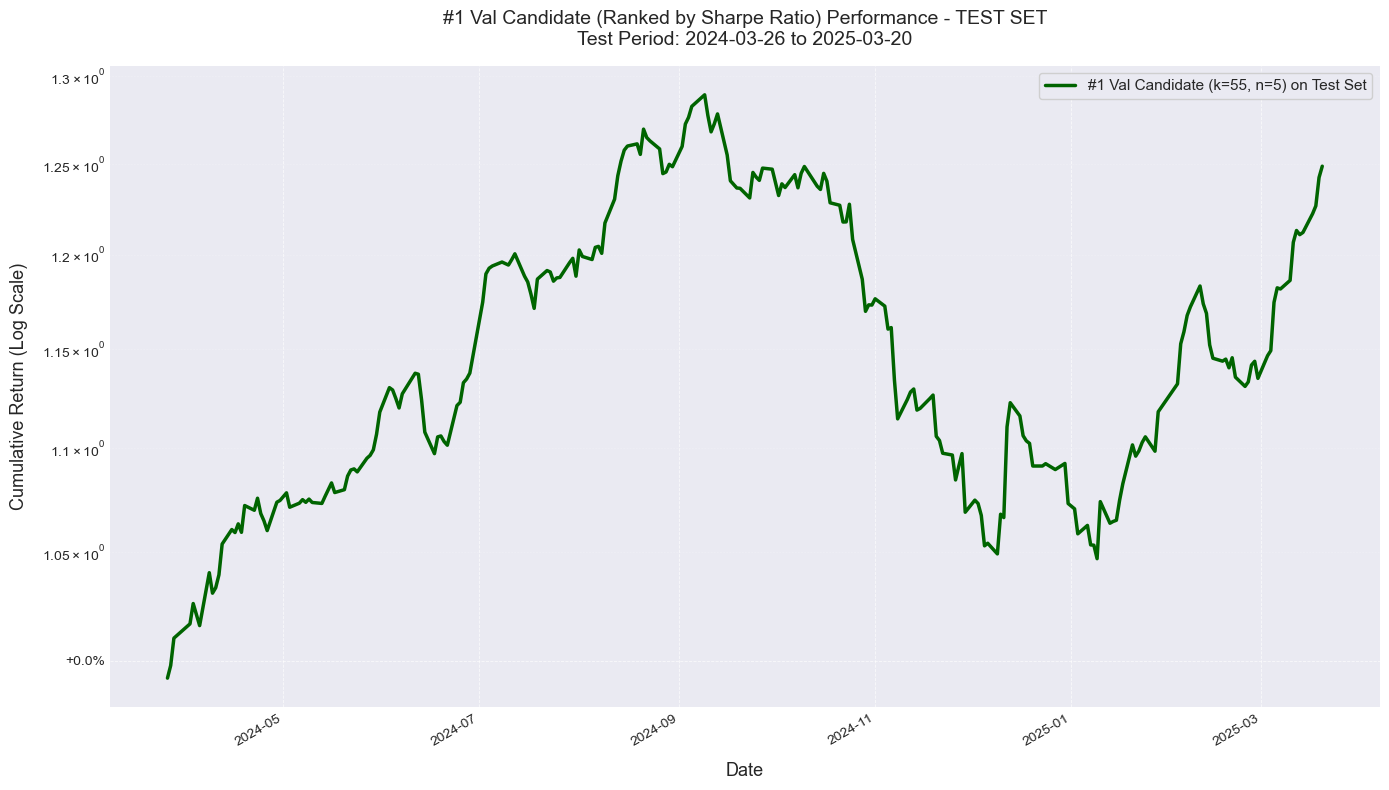

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd # Assuming daily_returns_plot is a pandas Series/DataFrame
import traceback

print("\n--- Plotting Validation Candidate Performance on TEST Period ---", flush=True)

if test_set_results and test_set_results[3] is not None:
    result_to_plot = test_set_results[3]
    k_plot = result_to_plot['k']
    n_plot = result_to_plot['n']
    daily_returns_plot = result_to_plot['test_daily_returns']
    # 'always_above_plot' was related to HSI, so it's removed.

    # Condition now only checks for the strategy's data
    plot_condition = (daily_returns_plot is not None and not daily_returns_plot.empty)

    if plot_condition:
        # Use the strategy's index directly
        strategy_index = daily_returns_plot.index
        if len(strategy_index) > 1:
            # Calculate cumulative returns directly from the available daily returns
            strategy_cumulative_final = (1 + daily_returns_plot).cumprod()
            try:
                plt.style.use('seaborn-v0_8-darkgrid')
                fig, ax = plt.subplots(figsize=(14, 8))

                line_color = 'darkgreen' # Standard color for the strategy
                # Plot only the strategy
                ax.plot(strategy_cumulative_final.index, strategy_cumulative_final,
                        label=f'#1 Val Candidate (k={k_plot}, n={n_plot}) on Test Set',
                        linewidth=2.5, color=line_color, zorder=10)

                # Update title and labels - remove HSI comparison
                start_date_str = strategy_index.min().strftime('%Y-%m-%d')
                end_date_str = strategy_index.max().strftime('%Y-%m-%d')
                # Removed outcome_str as it was HSI-related
                plot_title = f'#1 Val Candidate (Ranked by {VALIDATION_OPTIMIZATION_METRIC}) Performance - TEST SET\nTest Period: {start_date_str} to {end_date_str}'

                ax.set_title(plot_title, fontsize=14, pad=15)
                ax.set_ylabel('Cumulative Return (Log Scale)', fontsize=13, labelpad=10)
                ax.set_xlabel('Date', fontsize=13, labelpad=10)
                ax.set_yscale('log')
                ax.legend(loc='best', fontsize=11, frameon=True, framealpha=0.9)
                ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{y-1:+.1%}')) # Format y-axis as percentage return
                ax.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.7)
                ax.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
                plt.xticks(rotation=30, ha='right')
                plt.tight_layout()

                # Instead of saving, show the plot
                print("Displaying test set cumulative return plot...")
                plt.show()
                # plt.close(fig) # Usually not needed after plt.show() in interactive environments,
                               # but uncomment if the figure stays open unexpectedly or you need to free memory explicitly.

            except Exception as e:
                print(f"Error during plotting: {e}")
                traceback.print_exc()
        else:
            # Update message
            print("Skipping plot: Not enough data points (>1) for #1 strategy on test set.")
    else:
        # Update message
        print("Skipping plot: Data missing for #1 validation candidate on test set.")
else:
    print("Skipping plot: No candidates selected from validation (or result[2] is missing) to plot.")



--- === VISUALIZING BEST STRATEGY OVER FULL PERIOD === ---
Attempting to use k/n from test_set_results if available...
Using k=55, n=5 from top test candidate.

--- Loading full original data from 'detailed_data_with_alphas_and_price.csv'... ---
Full data loaded. Shape: (99942, 9)

--- Calculating actual forward returns on full dataset... ---

--- Preparing features and generating predictions for full dataset... ---
Features scaled. Shape: (99942, 6)
 817/3124 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step

2025-05-01 02:52:55.966619: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-01 02:52:55.966905: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

3124/3124 ━━━━━━━━━━━━━━━━━━━━ 1s 165us/step
Predictions generated for full dataset. Shape: (99942,)
Dropped 83 rows with NaN actual_forward_return.
Full results DataFrame prepared for simulation. Shape: (99859, 3)

--- Running simulation for best k=55, n=5 over the FULL PERIOD... ---
--- Running Simulation (Full Period): k=55, n=5 ---
Finished Simulation (Full Period): k=55, n=5. CumReturn: 118.55%, Sharpe: 0.6856, Time: 0.36s
Full period simulation finished in 0.36 seconds.

--- Full Period Performance Metrics (Best k, n Strategy) ---
  - Cumulative Return: 1.1855
  - Annualized Return: 0.1743
  - Annualized Volatility: 0.2998
  - Sharpe Ratio: 0.6856
  - Max Drawdown: -0.3953
  - Trading Days: 1226
  - Positive Days %: 51.1419
  - Sortino Ratio: 1.0814
  - Drawdown Duration (Days): 330
  - Recovery Time (Days): 387

--- Plotting Full Period Performance with Markers ---
Full period plot saved to dnn_backtest_FULL_PERIOD_k46_n4_cumulative_return_log.png


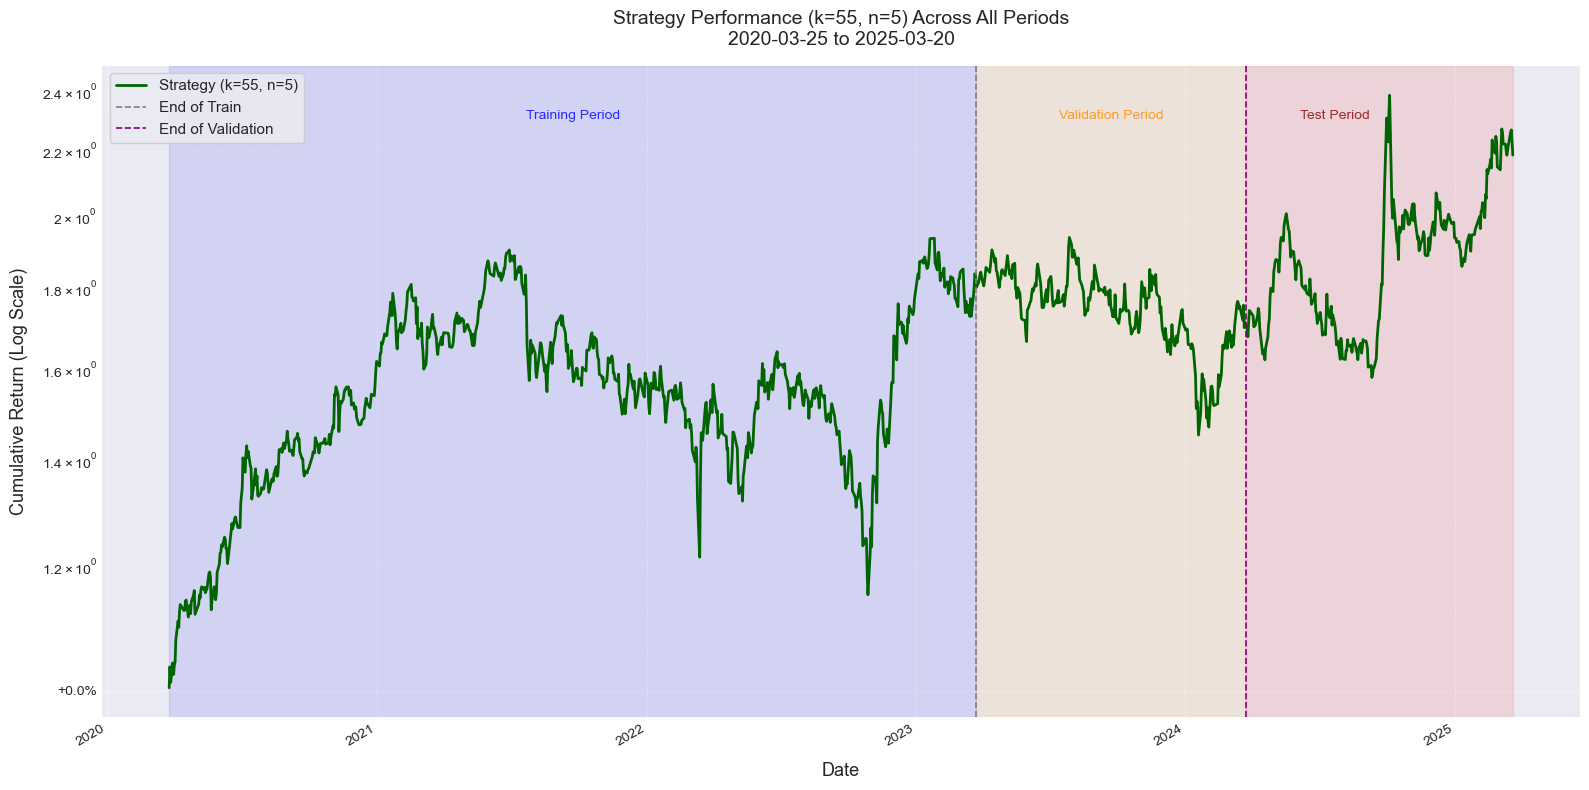


--- Full Period Visualization Script End ---


In [20]:
# === New Part: Visualize Strategy Performance Over Full Period ===

print("\n\n--- === VISUALIZING BEST STRATEGY OVER FULL PERIOD === ---", flush=True)

# --- Configuration for Full Period Visualization ---
FULL_PLOT_SAVE_PATH = f'dnn_backtest_FULL_PERIOD_k{best_k_val}_n{best_n_val}_cumulative_return_log.png' # Dynamic filename


if test_set_results:
    print("Attempting to use k/n from test_set_results if available...")
    try:
        best_k_val = test_set_results[3]['k']
        best_n_val = test_set_results[3]['n']
        print(f"Using k={best_k_val}, n={best_n_val} from top test candidate.")
    except (IndexError, KeyError):
        print("ERROR: Still could not get best k/n. Exiting visualization part.")
        exit() # Or handle differently
else:
    exit() # Exit if no results at all

# --- 1. Load Full Original Data ---
print(f"\n--- Loading full original data from '{ORIGINAL_DETAILED_CSV}'... ---", flush=True)
try:
    full_data_df = pd.read_csv(ORIGINAL_DETAILED_CSV, parse_dates=['Date'])
    full_data_df.sort_values(by=['stock_id', 'Date'], inplace=True)
    full_data_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    print(f"Full data loaded. Shape: {full_data_df.shape}")

    # Basic check for required columns
    required_original_cols = set(feature_names) | {'Date', 'stock_id', 'price'}
    if not required_original_cols.issubset(full_data_df.columns):
        missing_cols = required_original_cols - set(full_data_df.columns)
        raise ValueError(f"Original data missing required columns: {missing_cols}")

except FileNotFoundError:
    print(f"ERROR: Original data file '{ORIGINAL_DETAILED_CSV}' not found.", flush=True)
    exit()
except Exception as e:
    print(f"Error loading or checking original data: {e}", flush=True)
    traceback.print_exc()
    exit()

# --- 2. Calculate Actual Forward Returns for Simulation Evaluation ---
# Need this on the full dataset for the simulation loop to calculate daily P/L
print("\n--- Calculating actual forward returns on full dataset... ---", flush=True)
full_data_df[f'price_t+{FORWARD_RETURN_PERIOD}'] = full_data_df.groupby('stock_id')['price'].shift(-FORWARD_RETURN_PERIOD)
full_data_df['actual_forward_return'] = np.where(
    full_data_df['price'] > 1e-9,
    (full_data_df[f'price_t+{FORWARD_RETURN_PERIOD}'] / full_data_df['price']) - 1,
    np.nan
)
full_data_df.replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf results again

# --- 3. Prepare Features and Generate Predictions for Full Dataset ---
print("\n--- Preparing features and generating predictions for full dataset... ---", flush=True)
try:
    # Drop rows where features or the actual_forward_return needed for simulation are NaN
    # Note: We predict on all rows with valid features, but simulation stops when actual_forward_return is NaN
    feature_cols_for_pred = full_data_df[feature_names].copy()

    # Handle NaNs in features (using forward/backward fill per stock is safest)
    initial_feature_nan = feature_cols_for_pred.isnull().sum().sum()
    if initial_feature_nan > 0:
        print(f"Found {initial_feature_nan} NaNs in features before scaling. Applying ffill/bfill per stock...")
        for col in feature_names:
             feature_cols_for_pred[col] = feature_cols_for_pred.groupby(full_data_df['stock_id'])[col].ffill()
             feature_cols_for_pred[col] = feature_cols_for_pred.groupby(full_data_df['stock_id'])[col].bfill()
        # Handle any remaining NaNs (e.g., fill with 0 or drop rows)
        remaining_feature_nan = feature_cols_for_pred.isnull().sum().sum()
        if remaining_feature_nan > 0:
            print(f"Warning: {remaining_feature_nan} NaNs remain in features after ffill/bfill. Filling with 0.")
            feature_cols_for_pred.fillna(0, inplace=True) # Or drop rows if preferred

    # Scale features using the loaded scaler
    X_full_scaled = scaler.transform(feature_cols_for_pred)
    print(f"Features scaled. Shape: {X_full_scaled.shape}")

    # Generate predictions
    full_predictions = model.predict(X_full_scaled).flatten()
    print(f"Predictions generated for full dataset. Shape: {full_predictions.shape}")

    # Add predictions and actual returns back to a working DataFrame
    # Important: Ensure alignment after any potential NaN handling/dropping
    full_results_df = full_data_df[['Date', 'stock_id', 'actual_forward_return']].copy()
    full_results_df['predicted_score'] = full_predictions

    # Critical: Drop rows where simulation cannot proceed (no actual forward return)
    # This defines the actual end date of the simulation's P/L calculation
    rows_before_drop = len(full_results_df)
    full_results_df.dropna(subset=['actual_forward_return'], inplace=True)
    rows_after_drop = len(full_results_df)
    print(f"Dropped {rows_before_drop - rows_after_drop} rows with NaN actual_forward_return.")

    # Check for NaNs in predicted scores (shouldn't happen if features handled)
    if full_results_df['predicted_score'].isnull().any():
        print("Warning: NaNs found in predicted scores after alignment. Filling with 0.")
        full_results_df['predicted_score'].fillna(0, inplace=True) # Or handle differently

    # Set Date index for simulation function
    full_results_df = full_results_df.sort_values(by=['Date', 'stock_id'])
    full_results_df = full_results_df.set_index('Date')
    print(f"Full results DataFrame prepared for simulation. Shape: {full_results_df.shape}")
    if full_results_df.empty:
         raise ValueError("Full results DataFrame is empty after preparation.")

except Exception as e:
    print(f"Error during full data preparation or prediction: {e}", flush=True)
    traceback.print_exc()
    exit()


# --- 4. Run Simulation for Best (k, n) Over Entire Period ---
print(f"\n--- Running simulation for best k={best_k_val}, n={best_n_val} over the FULL PERIOD... ---", flush=True)
start_sim_full = time.time()
# Use the actual_forward_return column for P/L calculation in the simulation
full_daily_returns, full_metrics = run_simulation(
    full_results_df.rename(columns={'actual_forward_return': 'actual_return'}), # Rename column to match function expectation
    best_k_val,
    best_n_val,
    period_name="Full Period"
)
sim_time_full = time.time() - start_sim_full
print(f"Full period simulation finished in {sim_time_full:.2f} seconds.")

# --- 5. Report Full Period Metrics ---
print("\n--- Full Period Performance Metrics (Best k, n Strategy) ---")
if not full_daily_returns.empty:
    [print(f"  - {metric}: {value:.4f}" if isinstance(value,(float, np.floating)) else f"  - {metric}: {value}") for metric, value in full_metrics.items()]
    # Calculate Cumulative Return for plotting
    full_cumulative_returns = (1 + full_daily_returns).cumprod()
else:
    print("  Simulation did not produce valid returns for the full period.")
    full_cumulative_returns = None


# --- 6. Plot Full Period Performance with Period Markers ---
print("\n--- Plotting Full Period Performance with Markers ---", flush=True)
if full_cumulative_returns is not None and not full_cumulative_returns.empty:
    try:
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, ax = plt.subplots(figsize=(16, 8)) # Wider figure

        # Plot the strategy cumulative return
        ax.plot(full_cumulative_returns.index, full_cumulative_returns,
                label=f'Strategy (k={best_k_val}, n={best_n_val})',
                linewidth=2.0, color='darkgreen')

        # Define period boundaries
        train_start_date = full_cumulative_returns.index.min()
        train_end_date_dt = pd.to_datetime(TRAIN_END_DATE)
        validation_end_date_dt = pd.to_datetime(VALIDATION_END_DATE)
        actual_end_date = full_cumulative_returns.index.max()

        # Add vertical lines for period boundaries
        ax.axvline(train_end_date_dt, color='grey', linestyle='--', linewidth=1.2, label='End of Train')
        ax.axvline(validation_end_date_dt, color='purple', linestyle='--', linewidth=1.2, label='End of Validation')
        # Optional: Add line for end of the original test period if desired
        # test_end_date_actual = test_results_df.index.max() # Get from previous script if needed
        # ax.axvline(test_end_date_actual, color='red', linestyle=':', linewidth=1.0, label='End of Original Test')

        # Add shaded regions for periods (adjust alpha for visibility)
        ax.axvspan(train_start_date, train_end_date_dt, alpha=0.1, color='blue', label='_nolegend_')
        ax.axvspan(train_end_date_dt, validation_end_date_dt, alpha=0.1, color='orange', label='_nolegend_')
        ax.axvspan(validation_end_date_dt, actual_end_date, alpha=0.1, color='red', label='_nolegend_') # Test + Post-Test combined shading

        # Add text labels for periods
        y_min, y_max = ax.get_ylim()
        text_y_pos = y_min + (y_max - y_min) * 0.90 # Position text near the top

        # Adjust x-position slightly into the period
        train_text_x = train_start_date + (train_end_date_dt - train_start_date) / 2
        val_text_x = train_end_date_dt + (validation_end_date_dt - train_end_date_dt) / 2
        test_text_x = validation_end_date_dt + (actual_end_date - validation_end_date_dt) / 3 # Position within test span

        ax.text(train_text_x, text_y_pos, 'Training Period', horizontalalignment='center', fontsize=10, color='blue', alpha=0.8)
        ax.text(val_text_x, text_y_pos, 'Validation Period', horizontalalignment='center', fontsize=10, color='darkorange', alpha=0.8)
        ax.text(test_text_x, text_y_pos, 'Test Period', horizontalalignment='center', fontsize=10, color='darkred', alpha=0.8)


        # Formatting
        start_date_str = train_start_date.strftime('%Y-%m-%d')
        end_date_str = actual_end_date.strftime('%Y-%m-%d') # Use actual end date from simulation
        plot_title = f'Strategy Performance (k={best_k_val}, n={best_n_val}) Across All Periods\n{start_date_str} to {end_date_str}'

        ax.set_title(plot_title, fontsize=14, pad=15)
        ax.set_ylabel('Cumulative Return (Log Scale)', fontsize=13, labelpad=10)
        ax.set_xlabel('Date', fontsize=13, labelpad=10)
        ax.set_yscale('log')
        ax.legend(loc='upper left', fontsize=11, frameon=True, framealpha=0.9) # Legend for strategy and lines
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{y-1:+.1%}')) # Format y-axis as percentage return
        ax.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.7)
        ax.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
        plt.xticks(rotation=30, ha='right')
        plt.tight_layout()

        # Save or show the plot
        plt.savefig(FULL_PLOT_SAVE_PATH, dpi=150)
        print(f"Full period plot saved to {FULL_PLOT_SAVE_PATH}")
        plt.show() # Display the plot as well
        # plt.close(fig) # Optional

    except Exception as e:
        print(f"Error during full period plotting: {e}")
        traceback.print_exc()
else:
    print("Skipping full period plot: No valid cumulative returns generated.")

print("\n--- Full Period Visualization Script End ---", flush=True)

## Add other benchmarks to compare



--- === VISUALIZING BEST STRATEGY OVER FULL PERIOD === ---
Attempting to use k/n from test_set_results[0] if available...
Using k=55, n=5 from top test candidate.

--- Loading full original data from 'detailed_data_with_alphas_and_price.csv'... ---


Full data loaded. Shape: (99942, 9)

--- Calculating actual forward returns on full dataset... ---

--- Preparing features and generating predictions for full dataset... ---
Features scaled. Shape: (99942, 6)
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 1s 158us/step
Predictions generated for full dataset. Shape: (99942,)
Dropped 83 rows with NaN actual_forward_return.
Full results DataFrame prepared for simulation. Shape: (99859, 3)

--- Running simulation for best k=55, n=5 over the FULL PERIOD... ---
--- Running Simulation (Full Period): k=55, n=5 ---
Finished Simulation (Full Period): k=55, n=5. CumReturn: 118.55%, Sharpe: 0.6856, Time: 0.35s
Full period simulation finished in 0.35 seconds.

--- Full Period Performance Metrics (Best k, n Strategy) ---
  - Cumulative Return: 1.1855
  - Annualized Return: 0.1743
  - Annualized Volatility: 0.2998
  - Sharpe Ratio: 0.6856
  - Max Drawdown: -0.3953
  - Trading Days: 1226
  - Positive Days %: 51.1419
  - Sortino Ratio: 1.0814
  - Drawdown Duration (Da

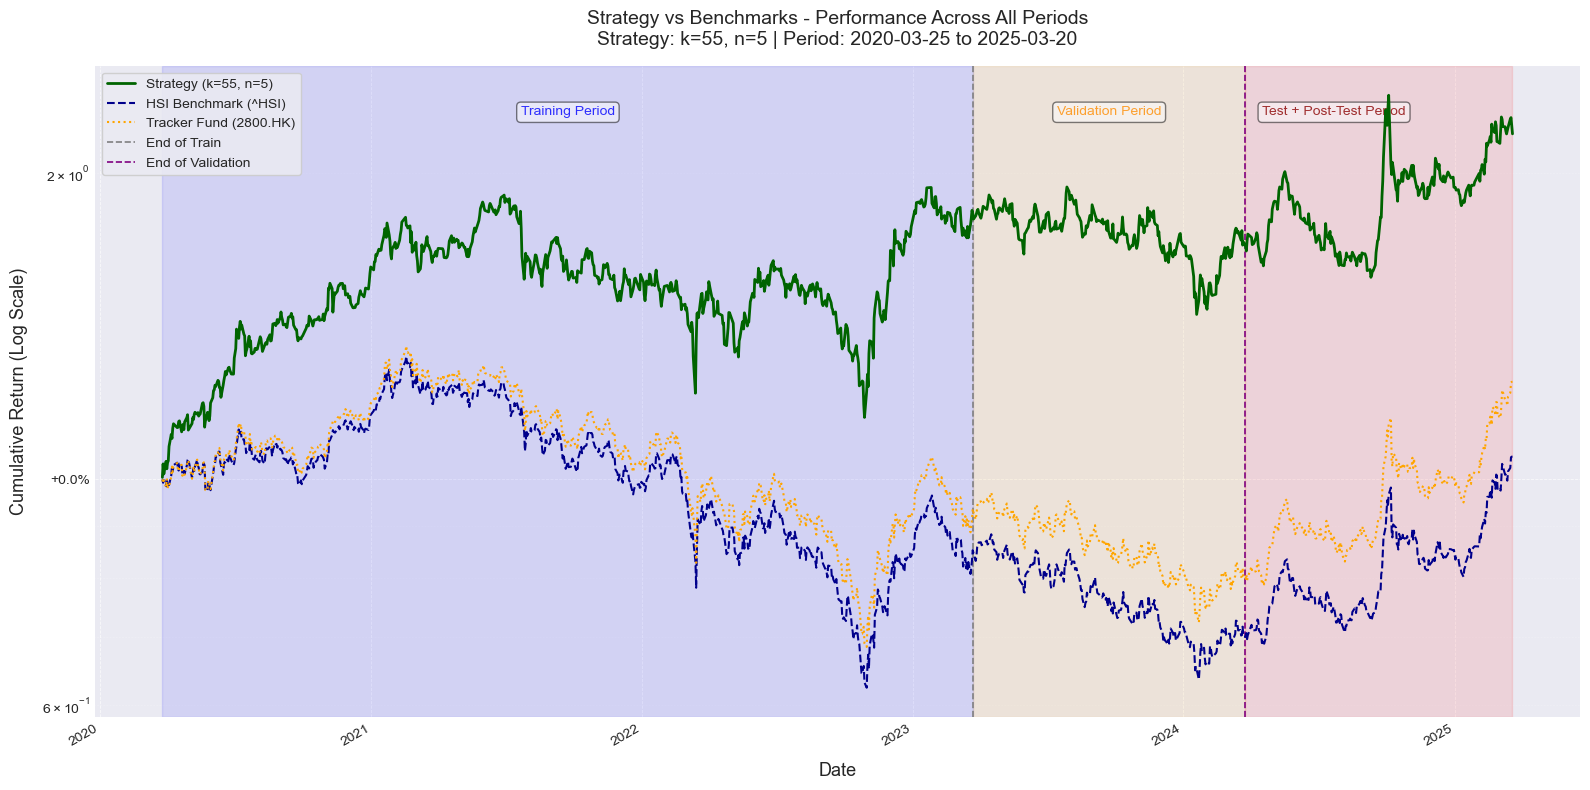


--- Full Period Visualization Script End ---


In [21]:
# === New Part: Visualize Strategy Performance Over Full Period ===

print("\n\n--- === VISUALIZING BEST STRATEGY OVER FULL PERIOD === ---", flush=True)

# --- Configuration for Full Period Visualization ---
FULL_PLOT_SAVE_PATH = f'dnn_backtest_FULL_PERIOD_k{best_k_val}_n{best_n_val}_cumulative_return_log.png' # Dynamic filename


if test_set_results:
    print("Attempting to use k/n from test_set_results[0] if available...")
    try:
        best_k_val = test_set_results[3]['k']
        best_n_val = test_set_results[3]['n']
        print(f"Using k={best_k_val}, n={best_n_val} from top test candidate.")
    except (IndexError, KeyError):
        print("ERROR: Still could not get best k/n. Exiting visualization part.")
        exit() # Or handle differently
else:
    exit() # Exit if no results at all

# --- 1. Load Full Original Data ---
print(f"\n--- Loading full original data from '{ORIGINAL_DETAILED_CSV}'... ---", flush=True)
try:
    full_data_df = pd.read_csv(ORIGINAL_DETAILED_CSV, parse_dates=['Date'])
    full_data_df.sort_values(by=['stock_id', 'Date'], inplace=True)
    full_data_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    print(f"Full data loaded. Shape: {full_data_df.shape}")

    # Basic check for required columns
    required_original_cols = set(feature_names) | {'Date', 'stock_id', 'price'}
    if not required_original_cols.issubset(full_data_df.columns):
        missing_cols = required_original_cols - set(full_data_df.columns)
        raise ValueError(f"Original data missing required columns: {missing_cols}")

except FileNotFoundError:
    print(f"ERROR: Original data file '{ORIGINAL_DETAILED_CSV}' not found.", flush=True)
    exit()
except Exception as e:
    print(f"Error loading or checking original data: {e}", flush=True)
    traceback.print_exc()
    exit()

# --- 2. Calculate Actual Forward Returns for Simulation Evaluation ---
# Need this on the full dataset for the simulation loop to calculate daily P/L
print("\n--- Calculating actual forward returns on full dataset... ---", flush=True)
full_data_df[f'price_t+{FORWARD_RETURN_PERIOD}'] = full_data_df.groupby('stock_id')['price'].shift(-FORWARD_RETURN_PERIOD)
full_data_df['actual_forward_return'] = np.where(
    full_data_df['price'] > 1e-9,
    (full_data_df[f'price_t+{FORWARD_RETURN_PERIOD}'] / full_data_df['price']) - 1,
    np.nan
)
full_data_df.replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf results again

# --- 3. Prepare Features and Generate Predictions for Full Dataset ---
print("\n--- Preparing features and generating predictions for full dataset... ---", flush=True)
try:
    # Drop rows where features or the actual_forward_return needed for simulation are NaN
    # Note: We predict on all rows with valid features, but simulation stops when actual_forward_return is NaN
    feature_cols_for_pred = full_data_df[feature_names].copy()

    # Handle NaNs in features (using forward/backward fill per stock is safest)
    initial_feature_nan = feature_cols_for_pred.isnull().sum().sum()
    if initial_feature_nan > 0:
        print(f"Found {initial_feature_nan} NaNs in features before scaling. Applying ffill/bfill per stock...")
        for col in feature_names:
             feature_cols_for_pred[col] = feature_cols_for_pred.groupby(full_data_df['stock_id'])[col].ffill()
             feature_cols_for_pred[col] = feature_cols_for_pred.groupby(full_data_df['stock_id'])[col].bfill()
        # Handle any remaining NaNs (e.g., fill with 0 or drop rows)
        remaining_feature_nan = feature_cols_for_pred.isnull().sum().sum()
        if remaining_feature_nan > 0:
            print(f"Warning: {remaining_feature_nan} NaNs remain in features after ffill/bfill. Filling with 0.")
            feature_cols_for_pred.fillna(0, inplace=True) # Or drop rows if preferred

    # Scale features using the loaded scaler
    X_full_scaled = scaler.transform(feature_cols_for_pred)
    print(f"Features scaled. Shape: {X_full_scaled.shape}")

    # Generate predictions
    full_predictions = model.predict(X_full_scaled).flatten()
    print(f"Predictions generated for full dataset. Shape: {full_predictions.shape}")

    # Add predictions and actual returns back to a working DataFrame
    # Important: Ensure alignment after any potential NaN handling/dropping
    full_results_df = full_data_df[['Date', 'stock_id', 'actual_forward_return']].copy()
    full_results_df['predicted_score'] = full_predictions

    # Critical: Drop rows where simulation cannot proceed (no actual forward return)
    # This defines the actual end date of the simulation's P/L calculation
    rows_before_drop = len(full_results_df)
    full_results_df.dropna(subset=['actual_forward_return'], inplace=True)
    rows_after_drop = len(full_results_df)
    print(f"Dropped {rows_before_drop - rows_after_drop} rows with NaN actual_forward_return.")

    # Check for NaNs in predicted scores (shouldn't happen if features handled)
    if full_results_df['predicted_score'].isnull().any():
        print("Warning: NaNs found in predicted scores after alignment. Filling with 0.")
        full_results_df['predicted_score'].fillna(0, inplace=True) # Or handle differently

    # Set Date index for simulation function
    full_results_df = full_results_df.sort_values(by=['Date', 'stock_id'])
    full_results_df = full_results_df.set_index('Date')
    print(f"Full results DataFrame prepared for simulation. Shape: {full_results_df.shape}")
    if full_results_df.empty:
         raise ValueError("Full results DataFrame is empty after preparation.")

except Exception as e:
    print(f"Error during full data preparation or prediction: {e}", flush=True)
    traceback.print_exc()
    exit()


# --- 4. Run Simulation for Best (k, n) Over Entire Period ---
print(f"\n--- Running simulation for best k={best_k_val}, n={best_n_val} over the FULL PERIOD... ---", flush=True)
start_sim_full = time.time()
# Use the actual_forward_return column for P/L calculation in the simulation
full_daily_returns, full_metrics = run_simulation(
    full_results_df.rename(columns={'actual_forward_return': 'actual_return'}), # Rename column to match function expectation
    best_k_val,
    best_n_val,
    period_name="Full Period"
)
sim_time_full = time.time() - start_sim_full
print(f"Full period simulation finished in {sim_time_full:.2f} seconds.")

# --- 5. Report Full Period Metrics ---
print("\n--- Full Period Performance Metrics (Best k, n Strategy) ---")
if not full_daily_returns.empty:
    [print(f"  - {metric}: {value:.4f}" if isinstance(value,(float, np.floating)) else f"  - {metric}: {value}") for metric, value in full_metrics.items()]
    # Calculate Cumulative Return for plotting
    full_cumulative_returns = (1 + full_daily_returns).cumprod()
else:
    print("  Simulation did not produce valid returns for the full period.")
    full_cumulative_returns = None # Set to None if simulation failed


# --- NEW: 5b. Calculate Benchmark Returns for Full Period ---
print("\n--- Calculating Benchmark Returns for Full Period (^HSI, 2800.HK) ---", flush=True)
hsi_cumulative_aligned = None
tracker_cumulative_aligned = None

# Only proceed if the strategy simulation was successful
if full_cumulative_returns is not None and not full_cumulative_returns.empty:
    # Determine date range from strategy results
    full_start_date = full_cumulative_returns.index.min()
    full_end_date = full_cumulative_returns.index.max()
    # Add buffer for download
    download_start = full_start_date
    download_end = full_end_date
    print(f"Benchmark download range: {download_start.date()} to {download_end.date()}")

    benchmarks_to_plot = {
        '^HSI': {'label': 'HSI Benchmark (^HSI)', 'color': 'darkblue', 'style': '--'},
        '2800.HK': {'label': 'Tracker Fund (2800.HK)', 'color': 'orange', 'style': ':'}
    }
    benchmark_cumulative_data = {} # Store aligned data

    for ticker, details in benchmarks_to_plot.items():
        print(f"  Downloading {ticker}...")
        try:
            bench_data = yf.download(ticker, start=download_start, end=download_end, auto_adjust=True, progress=False)
            if bench_data.empty:
                print(f"  WARNING: No data downloaded for {ticker}.")
                continue

            # Ensure timezone naive
            if bench_data.index.tz is not None:
                bench_data.index = bench_data.index.tz_localize(None)

            # Calculate daily and cumulative returns
            bench_data['daily_return'] = bench_data['Close'].pct_change()
            # Start cumulative return from 1.0
            bench_cumulative_raw = (1 + bench_data['daily_return'].fillna(0)).cumprod()

            # Align to strategy dates using reindex and ffill
            print(f"  Aligning {ticker} to strategy dates...")
            aligned_data = bench_cumulative_raw.reindex(full_cumulative_returns.index).ffill().dropna()

            if not aligned_data.empty:
                benchmark_cumulative_data[ticker] = aligned_data
                print(f"  {ticker} aligned successfully.")
            else:
                print(f"  WARNING: {ticker} alignment resulted in empty series.")

        except Exception as e:
            print(f"  ERROR processing benchmark {ticker}: {e}")
            traceback.print_exc()

    # Assign to specific variables used later in plotting if needed
    hsi_cumulative_aligned = benchmark_cumulative_data.get('^HSI')
    tracker_cumulative_aligned = benchmark_cumulative_data.get('2800.HK')

else:
    print("Skipping benchmark calculation as strategy simulation failed.")


# --- 6. Plot Full Period Performance with Period Markers (and Benchmarks) ---
print("\n--- Plotting Full Period Performance with Markers and Benchmarks ---", flush=True) # Updated title

if full_cumulative_returns is not None and not full_cumulative_returns.empty:
    try:
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, ax = plt.subplots(figsize=(16, 8)) # Wider figure

        # --- Plot Strategy ---
        ax.plot(full_cumulative_returns.index, full_cumulative_returns,
                label=f'Strategy (k={best_k_val}, n={best_n_val})',
                linewidth=2.0, color='darkgreen', zorder=10) # Use zorder to keep strategy on top

        # --- Plot Benchmarks (if available) ---
        if hsi_cumulative_aligned is not None and not hsi_cumulative_aligned.empty:
            ax.plot(hsi_cumulative_aligned.index, hsi_cumulative_aligned,
                    label=benchmarks_to_plot['^HSI']['label'],
                    color=benchmarks_to_plot['^HSI']['color'],
                    linestyle=benchmarks_to_plot['^HSI']['style'],
                    linewidth=1.5, zorder=5) # Lower zorder
        else:
            print("  Note: HSI Benchmark data not available for plotting.")

        if tracker_cumulative_aligned is not None and not tracker_cumulative_aligned.empty:
             ax.plot(tracker_cumulative_aligned.index, tracker_cumulative_aligned,
                     label=benchmarks_to_plot['2800.HK']['label'],
                     color=benchmarks_to_plot['2800.HK']['color'],
                     linestyle=benchmarks_to_plot['2800.HK']['style'],
                     linewidth=1.5, zorder=5) # Lower zorder
        else:
             print("  Note: Tracker Fund (2800.HK) data not available for plotting.")

        # --- Define period boundaries (Keep as is) ---
        train_start_date = full_cumulative_returns.index.min()
        train_end_date_dt = pd.to_datetime(TRAIN_END_DATE)
        validation_end_date_dt = pd.to_datetime(VALIDATION_END_DATE)
        actual_end_date = full_cumulative_returns.index.max()

        # --- Add vertical lines and shading (Keep as is) ---
        ax.axvline(train_end_date_dt, color='grey', linestyle='--', linewidth=1.2, label='End of Train')
        ax.axvline(validation_end_date_dt, color='purple', linestyle='--', linewidth=1.2, label='End of Validation')
        # Shading
        ax.axvspan(train_start_date, train_end_date_dt, alpha=0.1, color='blue', label='_nolegend_')
        ax.axvspan(train_end_date_dt, validation_end_date_dt, alpha=0.1, color='orange', label='_nolegend_')
        ax.axvspan(validation_end_date_dt, actual_end_date, alpha=0.1, color='red', label='_nolegend_')

        # --- Add text labels for periods (Keep as is) ---
        # Recalculate y_min/y_max *after* plotting everything to ensure text is placed correctly
        plt.draw() # Force draw to update axes limits if using interactive backend
        y_min, y_max = ax.get_ylim()
        # Adjust y-position if log scale causes issues near 1.0
        if ax.get_yscale() == 'log':
             # Position text based on log range
             log_y_min, log_y_max = np.log10(y_min), np.log10(y_max)
             text_log_y = log_y_min + (log_y_max - log_y_min) * 0.90
             text_y_pos = 10**text_log_y
        else:
            text_y_pos = y_min + (y_max - y_min) * 0.90

        # Text X positions (Keep as is)
        train_text_x = train_start_date + (train_end_date_dt - train_start_date) / 2
        val_text_x = train_end_date_dt + (validation_end_date_dt - train_end_date_dt) / 2
        test_text_x = validation_end_date_dt + (actual_end_date - validation_end_date_dt) / 3

        ax.text(train_text_x, text_y_pos, 'Training Period', horizontalalignment='center', fontsize=10, color='blue', alpha=0.8, bbox=dict(facecolor='white', alpha=0.5, pad=0.2, boxstyle='round,pad=0.3'))
        ax.text(val_text_x, text_y_pos, 'Validation Period', horizontalalignment='center', fontsize=10, color='darkorange', alpha=0.8, bbox=dict(facecolor='white', alpha=0.5, pad=0.2, boxstyle='round,pad=0.3'))
        ax.text(test_text_x, text_y_pos, 'Test + Post-Test Period', horizontalalignment='center', fontsize=10, color='darkred', alpha=0.8, bbox=dict(facecolor='white', alpha=0.5, pad=0.2, boxstyle='round,pad=0.3'))


        # --- Formatting (Keep mostly as is, adjust title/legend) ---
        start_date_str = train_start_date.strftime('%Y-%m-%d')
        end_date_str = actual_end_date.strftime('%Y-%m-%d') # Use actual end date from simulation
        plot_title = f'Strategy vs Benchmarks - Performance Across All Periods\nStrategy: k={best_k_val}, n={best_n_val} | Period: {start_date_str} to {end_date_str}' # Updated Title

        ax.set_title(plot_title, fontsize=14, pad=15)
        ax.set_ylabel('Cumulative Return (Log Scale)', fontsize=13, labelpad=10)
        ax.set_xlabel('Date', fontsize=13, labelpad=10)
        ax.set_yscale('log')
        ax.legend(loc='upper left', fontsize=10, frameon=True, framealpha=0.9) # Adjusted font size potentially
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f'{y-1:+.1%}')) # Format y-axis as percentage return
        ax.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.7)
        ax.grid(True, which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
        plt.xticks(rotation=30, ha='right')
        plt.tight_layout()

        # --- Save or show the plot ---
        plt.savefig(FULL_PLOT_SAVE_PATH, dpi=150)
        print(f"Full period plot saved to {FULL_PLOT_SAVE_PATH}")
        plt.show() # Uncomment if you want interactive display
        plt.close(fig) # Close figure after saving

    except Exception as e:
        print(f"Error during full period plotting: {e}")
        traceback.print_exc()
else:
    print("Skipping full period plot: No valid cumulative returns generated for the strategy.")

print("\n--- Full Period Visualization Script End ---", flush=True)

## Simulation for the strategy over full and extended period



--- === VISUALIZING BEST STRATEGY OVER FULL & EXTENDED PERIOD === ---
--- Assumed Starting Strategy Capital: $1,000,000.00 ---
Using k=55, n=5 from top test candidate.

--- Loading original full data from 'detailed_data_with_alphas_and_price.csv'... ---
Original data loaded. Ends on: 2025-03-21

--- Fetching new yfinance data from 2025-03-22 to 2025-05-01 ---
New data fetched. Shape: (2075, 7). Min Date: 2025-03-24, Max Date: 2025-04-30

--- Calculating alpha factors for the new data period... ---
New alphas calculated. Shape: (2075, 9)

--- Combining original and new alpha/price data... ---
Combined data shape: (102017, 9). Date range: 2020-03-24 to 2025-04-30

--- Recalculating actual forward returns on combined dataset... ---

--- Preparing features and predicting for the combined dataset... ---
Found 8383 NaNs in combined features. Applying ffill/bfill per stock...
 922/3189 ━━━━━━━━━━━━━━━━━━━━ 0s 163us/step

2025-05-01 02:53:16.775099: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-05-01 02:53:16.775422: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

3189/3189 ━━━━━━━━━━━━━━━━━━━━ 1s 171us/step
Dropped 83 rows with NaN actual_forward_return.
Final simulation data prepared. Actual end date for simulation: 2025-04-29

--- Running simulation for k=55, n=5 over the EXTENDED PERIOD... ---
--- Running Simulation (Extended Period): k=55, n=5 ---
Finished Simulation (Extended Period): k=55, n=5. CumReturn: 108.98%, Sharpe: 0.6418, Time: 0.36s
Extended period simulation finished in 0.36 seconds.

--- Extended Period Performance Metrics (Best k, n Strategy) ---
  - Cumulative Return: 1.0898
  - Annualized Return: 0.1601
  - Annualized Volatility: 0.3028
  - Sharpe Ratio: 0.6418
  - Max Drawdown: -0.3953
  - Trading Days: 1251
  - Positive Days %: 51.3189
  - Sortino Ratio: 0.9654
  - Drawdown Duration (Days): 330
  - Recovery Time (Days): 387

--- Extended Period Performance Metrics (HSI Benchmark: ^HSI) ---
  Benchmark download range: 2020-03-25 to 2025-04-29
  Aligning HSI daily returns...
  Calculating HSI metrics...
  - Cumulative Return

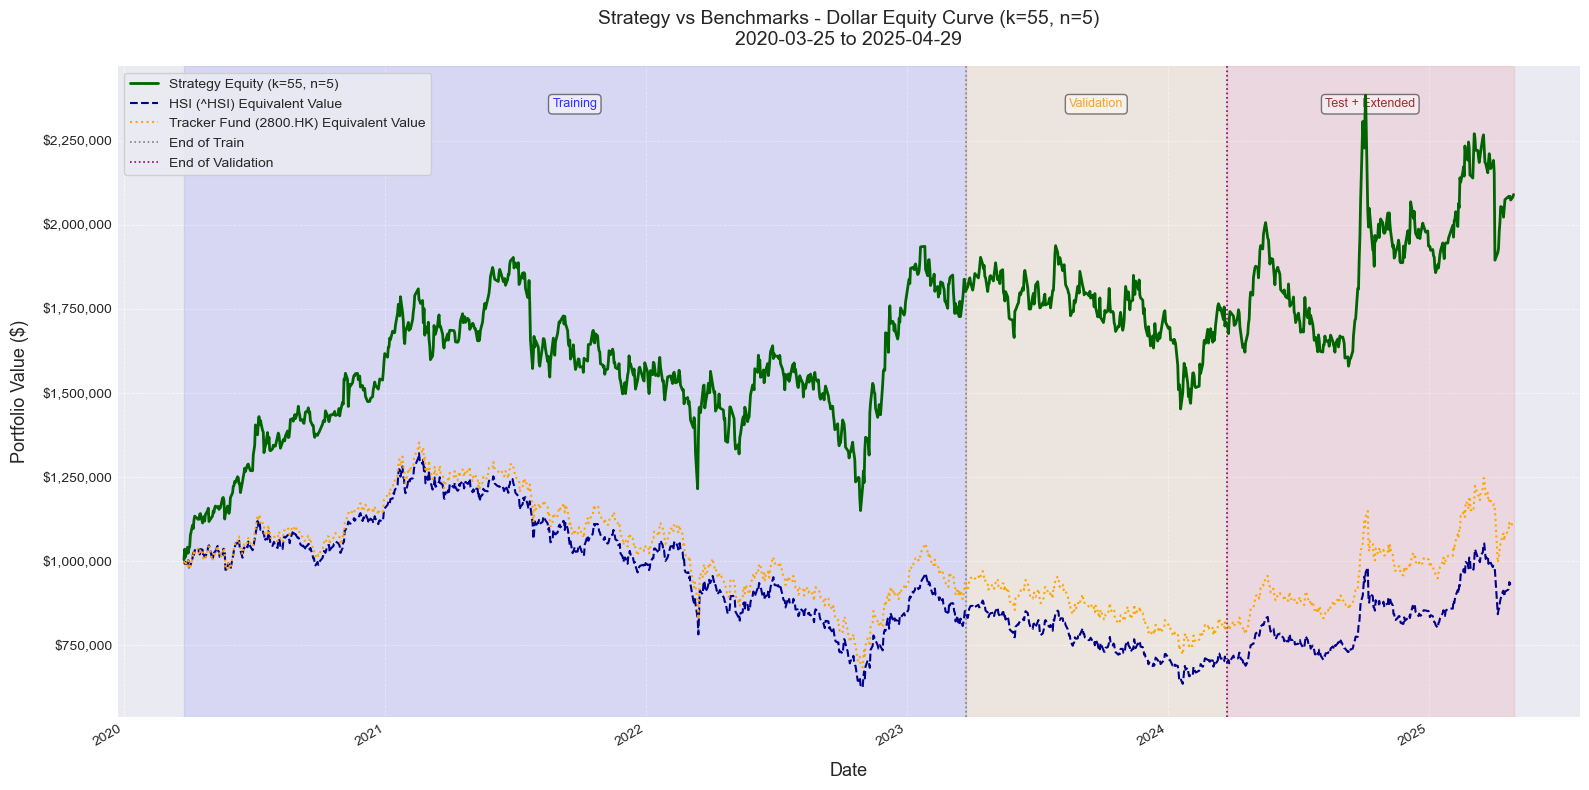


--- Full Period Visualization Script End ---


In [22]:
# === New Part: Visualize Strategy Performance Over Full & Extended Period ===

# Ensure necessary imports are present from the start of the script
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd # Make sure pandas is imported
import numpy as np # Make sure numpy is imported
import matplotlib.pyplot as plt # For plotting
import matplotlib.ticker as mtick # For plotting formatters
import traceback # For error details
import ta
# Need the alpha calculation functions from Script 1
# Make sure calculate_all_alpha_factors and its dependencies are defined above
# Make sure TICKERS list is defined (from Script 1 config)
# Make sure feature_names list is defined (loaded earlier)
# Make sure scaler and model are loaded
# Make sure best_k_val and best_n_val are defined

TICKERS = ["0001.HK", "0002.HK", "0003.HK", "0005.HK", "0006.HK", "0011.HK", '0012.HK', '0016.HK', '0027.HK', '0066.HK', '0101.HK', '0175.HK', '0241.HK', '0267.HK', '0285.HK', '0288.HK', '0291.HK', '0316.HK',
           "0322.HK", '0386.HK', '0388.HK', '0669.HK', '0688.HK', '0700.HK', '0762.HK', '0823.HK', '0836.HK', '0857.HK', '0868.HK', '0881.HK', '0883.HK', '0939.HK', '0941.HK', '0960.HK', '0968.HK', '0981.HK',
           "0992.HK", "1024.HK", '1038.HK', '1044.HK', '1088.HK', "1093.HK", '1099.HK', '1109.HK', '1113.HK', '1177.HK', '1209.HK', '1211.HK', '1299.HK', '1378.HK', '1398.HK', '1810.HK', '1876.HK', '1928.HK',
           '1929.HK', '1997.HK', '2015.HK', '2020.HK', '2269.HK', '2313.HK', '2318.HK', '2319.HK', '2331.HK', '2359.HK', '2382.HK', '2388.HK', '2628.HK', '2688.HK', '2899.HK', '3690.HK', '3692.HK', '3968.HK',
           '3988.HK', '6618.HK', '6690.HK', '6862.HK', '9618.HK', '9633.HK', '9888.HK', '9901.HK', '9961.HK', '9988.HK', '9999.HK']

# Format Y-axis as dollars with commas using FuncFormatter
def dollar_formatter(x, pos):
    if abs(x) < 1: return '$0'
    return '${:,.0f}'.format(x)

print("\n\n--- === VISUALIZING BEST STRATEGY OVER FULL & EXTENDED PERIOD === ---", flush=True)

# --- Configuration for Extended Period Visualization ---
EXTEND_SIMULATION_END_DATE_STR = "2025-04-30" # User specified end date
EXTEND_SIMULATION_END_DATE = pd.to_datetime(EXTEND_SIMULATION_END_DATE_STR)
TOTAL_STRATEGY_CAPITAL = 1000000
print(f"--- Assumed Starting Strategy Capital: ${TOTAL_STRATEGY_CAPITAL:,.2f} ---")

# --- Determine Best k/n ---
if 'test_set_results' in globals() and test_set_results:
    try: best_k_val = test_set_results[3]['k']; best_n_val = test_set_results[3]['n']; print(f"Using k={best_k_val}, n={best_n_val} from top test candidate.")
    except (IndexError, KeyError, TypeError): print("ERROR: Could not extract k/n from test_set_results. Exiting."); exit()
else: print("ERROR: 'test_set_results' not found or empty. Cannot determine best k/n. Exiting."); exit()

FULL_PLOT_SAVE_PATH = f'dnn_backtest_EXTENDED_PERIOD_k{best_k_val}_n{best_n_val}_dollar_equity_curve.png'

# --- 1. Load Original Full Data (If not already loaded/modified) ---
print(f"\n--- Loading original full data from '{ORIGINAL_DETAILED_CSV}'... ---", flush=True)
try:
    original_data_df = pd.read_csv(ORIGINAL_DETAILED_CSV, parse_dates=['Date'])
    original_data_df.sort_values(by=['stock_id', 'Date'], inplace=True)
    original_end_date = original_data_df['Date'].max()
    print(f"Original data loaded. Ends on: {original_end_date.date()}")
except Exception as e:
    print(f"Error loading original data: {e}", flush=True); traceback.print_exc(); exit()

# --- 2. Fetch New Data for Extension Period ---
fetch_start_date = original_end_date + timedelta(days=1)
# Need data up to END_DATE + 1 day for forward return calc on END_DATE
fetch_end_date = EXTEND_SIMULATION_END_DATE + timedelta(days=1)

print(f"\n--- Fetching new yfinance data from {fetch_start_date.date()} to {fetch_end_date.date()} ---", flush=True)
new_data_list = []
failed_tickers = []
for ticker in TICKERS:
    try:
        # Download new OHLCV data
        data_new = yf.download(ticker, start=fetch_start_date, end=fetch_end_date,
                               auto_adjust=True, progress=False, ignore_tz=True)
        if not data_new.empty:
            if isinstance(data_new.columns, pd.MultiIndex): data_new.columns = data_new.columns.get_level_values(0)
            data_new['stock_id'] = ticker
            data_new.reset_index(inplace=True) # Bring 'Date' column in
            # Standardize Date column name again if needed
            if 'Datetime' in data_new.columns: data_new.rename(columns={'Datetime': 'Date'}, inplace=True)
            if 'Date' in data_new.columns: new_data_list.append(data_new[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'stock_id']])
            else: print(f"Warning: No 'Date' column in new data for {ticker}.")
        # else: print(f"No new data found for {ticker} in the specified range.") # Can be noisy

    except Exception as e:
        print(f"ERROR fetching new data for {ticker}: {e}")
        failed_tickers.append(ticker)

if not new_data_list:
    print("ERROR: Failed to fetch any new data for the extension period. Cannot proceed.")
    exit()

new_data_df = pd.concat(new_data_list, ignore_index=True)
new_data_df['Date'] = pd.to_datetime(new_data_df['Date'])
new_data_df.sort_values(by=['stock_id', 'Date'], inplace=True)
print(f"New data fetched. Shape: {new_data_df.shape}. Min Date: {new_data_df['Date'].min().date()}, Max Date: {new_data_df['Date'].max().date()}")
if failed_tickers: print(f"Warning: Failed to fetch new data for tickers: {failed_tickers}")


# --- 3. Calculate Alphas for New Data Period ---
print("\n--- Calculating alpha factors for the new data period... ---", flush=True)
new_alpha_data_list = []
for ticker in new_data_df['stock_id'].unique():
     ticker_data_new = new_data_df[new_data_df['stock_id'] == ticker].copy()
     # Ensure consistent 'Volume' column name if needed by alpha funcs
     # if 'Volume' not in ticker_data_new.columns and 'Trading_Volume' in ticker_data_new.columns:
     #      ticker_data_new.rename(columns={'Trading_Volume':'Volume'}, inplace=True)

     try:
         # Need to ensure calculate_all_alpha_factors is defined and works stand-alone
         alpha_data_new = calculate_all_alpha_factors(ticker_data_new)
         alpha_data_new['stock_id'] = ticker # Ensure stock_id persists
         # Keep only Date, stock_id, and calculated alpha columns (feature_names) + price ('Close')
         cols_to_keep = ['Date', 'stock_id', 'Close'] + feature_names
         existing_cols = [col for col in cols_to_keep if col in alpha_data_new.columns]
         new_alpha_data_list.append(alpha_data_new[existing_cols])
     except Exception as e:
         print(f"ERROR calculating alphas for {ticker} in new period: {e}")

if not new_alpha_data_list:
    print("ERROR: Failed to calculate any alpha factors for the new data period.")
    exit()

new_alphas_df = pd.concat(new_alpha_data_list, ignore_index=True)
new_alphas_df.sort_values(by=['stock_id', 'Date'], inplace=True)
# Rename 'Close' to 'price' to match original data structure for consistency
if 'Close' in new_alphas_df.columns: new_alphas_df.rename(columns={'Close':'price'}, inplace=True)
print(f"New alphas calculated. Shape: {new_alphas_df.shape}")


# --- 4. Combine Original Data (with Alphas) and New Data (with Alphas) ---
print("\n--- Combining original and new alpha/price data... ---", flush=True)
# Select necessary columns from original data (already has alphas)
original_cols_to_keep = ['Date', 'stock_id', 'price'] + feature_names
original_data_subset = original_data_df[original_cols_to_keep].copy()

# Combine the two periods
combined_data_df = pd.concat([original_data_subset, new_alphas_df], ignore_index=True)
combined_data_df.sort_values(by=['stock_id', 'Date'], inplace=True)
# Remove potential duplicate rows (e.g., if fetch_start_date overlapped)
combined_data_df.drop_duplicates(subset=['Date', 'stock_id'], keep='last', inplace=True)
print(f"Combined data shape: {combined_data_df.shape}. Date range: {combined_data_df['Date'].min().date()} to {combined_data_df['Date'].max().date()}")


# --- 5. Recalculate Forward Returns on Combined Data ---
print("\n--- Recalculating actual forward returns on combined dataset... ---", flush=True)
combined_data_df[f'price_t+{FORWARD_RETURN_PERIOD}'] = combined_data_df.groupby('stock_id')['price'].shift(-FORWARD_RETURN_PERIOD)
combined_data_df['actual_forward_return'] = np.where(
    combined_data_df['price'] > 1e-9,
    (combined_data_df[f'price_t+{FORWARD_RETURN_PERIOD}'] / combined_data_df['price']) - 1,
    np.nan
)
combined_data_df.replace([np.inf, -np.inf], np.nan, inplace=True)


# --- 6. Prepare Features and Predict on Combined Data ---
print("\n--- Preparing features and predicting for the combined dataset... ---", flush=True)
try:
    # Select features
    feature_cols_combined = combined_data_df[feature_names].copy()

    # Handle NaNs in features (ffill/bfill is crucial here across the boundary)
    initial_feature_nan = feature_cols_combined.isnull().sum().sum()
    if initial_feature_nan > 0:
        print(f"Found {initial_feature_nan} NaNs in combined features. Applying ffill/bfill per stock...")
        # Need to group by stock_id from the combined_data_df
        for col in feature_names:
             feature_cols_combined[col] = feature_cols_combined.groupby(combined_data_df['stock_id'])[col].ffill()
             feature_cols_combined[col] = feature_cols_combined.groupby(combined_data_df['stock_id'])[col].bfill()
        remaining_feature_nan = feature_cols_combined.isnull().sum().sum()
        if remaining_feature_nan > 0:
            print(f"Warning: {remaining_feature_nan} NaNs remain after ffill/bfill. Filling with 0.")
            feature_cols_combined.fillna(0, inplace=True)

    # Scale features
    X_combined_scaled = scaler.transform(feature_cols_combined)

    # Generate predictions
    combined_predictions = model.predict(X_combined_scaled).flatten()

    # --- Create the final DataFrame for the simulation ---
    extended_results_df = combined_data_df[['Date', 'stock_id', 'actual_forward_return']].copy()
    extended_results_df['predicted_score'] = combined_predictions

    # Drop rows where simulation cannot proceed (NaN forward return)
    # This determines the final end date possible for the simulation
    rows_before_drop = len(extended_results_df)
    extended_results_df.dropna(subset=['actual_forward_return'], inplace=True)
    rows_after_drop = len(extended_results_df)
    final_sim_end_date = extended_results_df['Date'].max()
    print(f"Dropped {rows_before_drop - rows_after_drop} rows with NaN actual_forward_return.")
    print(f"Final simulation data prepared. Actual end date for simulation: {final_sim_end_date.date()}")


    # Handle potential NaNs in scores (final check)
    if extended_results_df['predicted_score'].isnull().any():
        print("Warning: NaNs found in predicted scores. Filling with 0.")
        extended_results_df['predicted_score'].fillna(0, inplace=True)

    # Set Date index
    extended_results_df = extended_results_df.sort_values(by=['Date', 'stock_id'])
    extended_results_df = extended_results_df.set_index('Date')
    if extended_results_df.empty: raise ValueError("Extended results DataFrame is empty.")

except Exception as e:
    print(f"Error during combined data prep/prediction: {e}", flush=True); traceback.print_exc(); exit()


# --- 7. Run Simulation for Best (k, n) Over EXTENDED Period ---
print(f"\n--- Running simulation for k={best_k_val}, n={best_n_val} over the EXTENDED PERIOD... ---", flush=True)
start_sim_ext = time.time()
extended_daily_returns, extended_metrics = run_simulation(
    extended_results_df.rename(columns={'actual_forward_return': 'actual_return'}),
    best_k_val,
    best_n_val,
    period_name="Extended Period"
)
sim_time_ext = time.time() - start_sim_ext
print(f"Extended period simulation finished in {sim_time_ext:.2f} seconds.")

# --- 8. Report Extended Period Metrics (Strategy) ---
print("\n--- Extended Period Performance Metrics (Best k, n Strategy) ---")
extended_cumulative_returns = None # Initialize
if 'extended_daily_returns' in globals() and extended_daily_returns is not None and not extended_daily_returns.empty:
    if 'extended_metrics' in globals() and extended_metrics:
        [print(f"  - {metric}: {value:.4f}" if isinstance(value,(float, np.floating)) else f"  - {metric}: {value}") for metric, value in extended_metrics.items()]
        extended_cumulative_returns = (1 + extended_daily_returns).cumprod()
    else:
        print("  Strategy metrics calculation failed or was skipped.")
        if not extended_daily_returns.empty: extended_cumulative_returns = (1 + extended_daily_returns.fillna(0)).cumprod()
else:
    print("  Strategy simulation did not produce valid returns for the extended period.")

# --- 8b. Calculate and Report Extended Period Metrics (HSI Benchmark) ---
print("\n--- Extended Period Performance Metrics (HSI Benchmark: ^HSI) ---")
hsi_extended_metrics = {}
hsi_daily_aligned = None
if 'extended_daily_returns' in globals() and extended_daily_returns is not None and not extended_daily_returns.empty:
    full_start_date = extended_daily_returns.index.min(); full_end_date = extended_daily_returns.index.max()
    download_start = full_start_date; download_end = full_end_date
    print(f"  Benchmark download range: {download_start.date()} to {download_end.date()}")
    try:
        print("  Downloading ^HSI..."); hsi_data = yf.download('^HSI', start=download_start, end=download_end, auto_adjust=True, progress=False)
        if hsi_data.empty: print("  WARNING: No data downloaded for ^HSI.")
        else:
            if hsi_data.index.tz is not None: hsi_data.index = hsi_data.index.tz_localize(None)
            hsi_data['daily_return'] = hsi_data['Close'].pct_change()
            print("  Aligning HSI daily returns..."); hsi_daily_aligned = hsi_data['daily_return'].reindex(extended_daily_returns.index).fillna(0.0)
            print("  Calculating HSI metrics...")
            if 'calculate_metrics' in globals():
                 hsi_extended_metrics = calculate_metrics(hsi_daily_aligned)
                 if hsi_extended_metrics: [print(f"  - {metric}: {value:.4f}" if isinstance(value,(float, np.floating)) else f"  - {metric}: {value}") for metric, value in hsi_extended_metrics.items()]
                 else: print("  Failed to calculate HSI metrics.")
            else: print("  ERROR: calculate_metrics function not found.")
    except Exception as e: print(f"  ERROR processing ^HSI: {e}"); hsi_extended_metrics = {}
else: print("  Skipping HSI benchmark metrics calculation.")


# --- 8c. Calculate and Report Extended Period Metrics (Tracker Fund: 2800.HK) --- ## NEW SECTION ##
print("\n--- Extended Period Performance Metrics (Tracker Fund: 2800.HK) ---")
tracker_extended_metrics = {} # Initialize metrics dict
tracker_daily_aligned = None  # Initialize aligned daily returns

# Only proceed if the strategy simulation produced daily returns (needed for alignment)
if 'extended_daily_returns' in globals() and extended_daily_returns is not None and not extended_daily_returns.empty:
    # Use same date range as HSI (derived from strategy)
    # full_start_date, full_end_date, download_start, download_end already defined above
    print(f"  Benchmark download range: {download_start.date()} to {download_end.date()}") # Reuse dates

    try:
        print("  Downloading 2800.HK...")
        tracker_data = yf.download('2800.HK', start=download_start, end=download_end, auto_adjust=True, progress=False)

        if tracker_data.empty:
            print("  WARNING: No data downloaded for 2800.HK.")
        else:
            if tracker_data.index.tz is not None: tracker_data.index = tracker_data.index.tz_localize(None)
            tracker_data['daily_return'] = tracker_data['Close'].pct_change()

            # Align DAILY returns to strategy dates
            print("  Aligning 2800.HK daily returns...")
            tracker_daily_aligned = tracker_data['daily_return'].reindex(extended_daily_returns.index).fillna(0.0)

            # Calculate Tracker Metrics for the period
            print("  Calculating 2800.HK metrics...")
            if 'calculate_metrics' in globals(): # Ensure function exists
                 tracker_extended_metrics = calculate_metrics(tracker_daily_aligned)
                 # Report Tracker Metrics
                 if tracker_extended_metrics:
                      [print(f"  - {metric}: {value:.4f}" if isinstance(value,(float, np.floating)) else f"  - {metric}: {value}") for metric, value in tracker_extended_metrics.items()]
                 else:
                      print("  Failed to calculate 2800.HK metrics.")
            else:
                 print("  ERROR: calculate_metrics function not found.")

    except Exception as e:
        print(f"  ERROR processing 2800.HK or calculating metrics: {e}")
        tracker_extended_metrics = {} # Reset metrics on error
else:
    print("  Skipping 2800.HK benchmark metrics calculation as strategy daily returns are missing.")
# --- END OF TRACKER METRICS SECTION ---


# --- 9. Calculate Dollar Equity Curve (Strategy) ---
# (Keep this section as is)
print("\n--- Calculating Dollar Equity Curve for Strategy ---", flush=True)
dollar_equity_curve = None
if 'extended_daily_returns' in globals() and extended_daily_returns is not None and not extended_daily_returns.empty:
    cumulative_return_factor = (1 + extended_daily_returns.fillna(0)).cumprod()
    dollar_equity_curve = TOTAL_STRATEGY_CAPITAL * cumulative_return_factor
    print(f"Strategy dollar equity curve calculated. Final Value: ${dollar_equity_curve.iloc[-1]:,.2f}")
else:
    print("Could not calculate dollar equity curve for strategy.")


# --- 9b. Calculate Benchmark Dollar Equity Curve (^HSI) ---
# (Keep this section as is, relies on hsi_daily_aligned from 8b)
print("\n--- Calculating Benchmark Dollar Equity Curve (^HSI) ---", flush=True)
hsi_dollar_equity_aligned = None
if hsi_daily_aligned is not None and not hsi_daily_aligned.empty:
    try:
        hsi_cumulative_factor_aligned = (1 + hsi_daily_aligned).cumprod()
        hsi_dollar_equity_aligned = TOTAL_STRATEGY_CAPITAL * hsi_cumulative_factor_aligned
        print(f"  HSI dollar equity curve calculated. Final Value: ${hsi_dollar_equity_aligned.iloc[-1]:,.2f}")
    except Exception as e: print(f"  ERROR calculating HSI dollar equity: {e}")
else: print("  Skipping HSI dollar equity curve: aligned daily returns not available.")


# --- 9c. Calculate Benchmark Dollar Equity Curve (2800.HK) --- ## NEW SECTION ##
print("\n--- Calculating Benchmark Dollar Equity Curve (2800.HK) ---", flush=True)
tracker_dollar_equity_aligned = None

# Use the previously aligned daily returns if available
if tracker_daily_aligned is not None and not tracker_daily_aligned.empty:
    try:
        # Calculate cumulative factor from the *already aligned* daily returns
        tracker_cumulative_factor_aligned = (1 + tracker_daily_aligned).cumprod()
        tracker_dollar_equity_aligned = TOTAL_STRATEGY_CAPITAL * tracker_cumulative_factor_aligned
        print(f"  2800.HK dollar equity curve calculated. Final Value: ${tracker_dollar_equity_aligned.iloc[-1]:,.2f}")
    except Exception as e:
         print(f"  ERROR calculating 2800.HK dollar equity curve from aligned data: {e}")
else:
     print("  Skipping 2800.HK dollar equity curve calculation as aligned daily returns are not available.")
# --- END OF TRACKER DOLLAR EQUITY CALC ---


# --- 10. Plot Extended Period Performance (Dollar Equity with Benchmarks) --- ## MODIFIED PLOTTING ##
print("\n--- Plotting Extended Period Dollar Equity Curve with Markers and Benchmarks ---", flush=True)

# --- Ensure Boundary Dates are Defined Correctly Before Plotting ---
# (Keep the try-except block for boundary dates)
try:
    train_end_date_dt = pd.to_datetime(TRAIN_END_DATE); validation_end_date_dt = pd.to_datetime(VALIDATION_END_DATE); boundary_dates_defined = True
    print(f"Using boundary dates: Train End={train_end_date_dt.date()}, Validation End={validation_end_date_dt.date()}")
except NameError: print("WARNING: Boundary dates not found. Plot markers/shading skipped."); boundary_dates_defined = False; train_end_date_dt=None; validation_end_date_dt=None
except Exception as e: print(f"Error defining boundary dates: {e}. Markers/shading skipped."); boundary_dates_defined = False; train_end_date_dt=None; validation_end_date_dt=None

# Proceed only if strategy curve exists
if dollar_equity_curve is not None and not dollar_equity_curve.empty:
    try:
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, ax = plt.subplots(figsize=(16, 8)) # Wider figure

        # --- Plot Strategy ---
        ax.plot(dollar_equity_curve.index, dollar_equity_curve,
                label=f'Strategy Equity (k={best_k_val}, n={best_n_val})',
                linewidth=2.0, color='darkgreen', zorder=10)

        # --- Plot HSI Benchmark (if available) ---
        if hsi_dollar_equity_aligned is not None and not hsi_dollar_equity_aligned.empty:
            ax.plot(hsi_dollar_equity_aligned.index, hsi_dollar_equity_aligned,
                    label='HSI (^HSI) Equivalent Value',
                    color='darkblue', linestyle='--', linewidth=1.5, zorder=5)
        else: print("  Note: HSI Benchmark data not available for plotting.")

        # --- Plot Tracker Fund Benchmark (if available) --- ## NEW PLOT LINE ##
        if tracker_dollar_equity_aligned is not None and not tracker_dollar_equity_aligned.empty:
            ax.plot(tracker_dollar_equity_aligned.index, tracker_dollar_equity_aligned,
                    label='Tracker Fund (2800.HK) Equivalent Value',
                    color='orange', # Different color
                    linestyle=':',  # Different style
                    linewidth=1.5, zorder=5)
        else: print("  Note: Tracker Fund (2800.HK) data not available for plotting.")


        # --- Define plot start/end from actual equity curve data ---
        plot_start_date = dollar_equity_curve.index.min(); plot_end_date = dollar_equity_curve.index.max()

        # --- Add vertical lines and shading (if boundaries defined) ---
        # (Boundary plotting logic remains the same)
        if boundary_dates_defined and train_end_date_dt and validation_end_date_dt:
            ax.axvline(train_end_date_dt, color='grey', linestyle=':', linewidth=1.2, label='End of Train')
            ax.axvspan(plot_start_date, train_end_date_dt, alpha=0.08, color='blue', label='_nolegend_')
            ax.axvline(validation_end_date_dt, color='purple', linestyle=':', linewidth=1.2, label='End of Validation')
            ax.axvspan(train_end_date_dt, validation_end_date_dt, alpha=0.08, color='orange', label='_nolegend_')
            ax.axvspan(validation_end_date_dt, plot_end_date, alpha=0.08, color='red', label='_nolegend_')

            # --- Add Text Labels (if boundaries defined) ---
            # (Text label logic remains the same)
            plt.draw(); y_min, y_max = ax.get_ylim(); text_y_pos = y_min + (y_max - y_min) * 0.95
            train_text_x = plot_start_date + (train_end_date_dt - plot_start_date) / 2
            if train_end_date_dt < validation_end_date_dt: val_text_x = train_end_date_dt + (validation_end_date_dt - train_end_date_dt) / 2
            else: val_text_x = train_end_date_dt + timedelta(days=10)
            if validation_end_date_dt < plot_end_date: test_post_test_text_x = validation_end_date_dt + (plot_end_date - validation_end_date_dt) / 2
            else: test_post_test_text_x = validation_end_date_dt + timedelta(days=10)
            ax.text(train_text_x, text_y_pos, 'Training', ha='center', va='top', fontsize=9, color='blue', alpha=0.8, bbox=dict(facecolor='white', alpha=0.5, pad=0.2, boxstyle='round,pad=0.3'))
            ax.text(val_text_x, text_y_pos, 'Validation', ha='center', va='top', fontsize=9, color='darkorange', alpha=0.8, bbox=dict(facecolor='white', alpha=0.5, pad=0.2, boxstyle='round,pad=0.3'))
            ax.text(test_post_test_text_x, text_y_pos, 'Test + Extended', ha='center', va='top', fontsize=9, color='darkred', alpha=0.8, bbox=dict(facecolor='white', alpha=0.5, pad=0.2, boxstyle='round,pad=0.3'))

            # Ensure legend includes all plotted lines
            ax.legend(loc='upper left', fontsize=10, frameon=True, framealpha=0.9)
        else:
             # Legend with only strategy and benchmarks if no boundaries
             handles, labels = ax.get_legend_handles_labels()
             ax.legend(handles=handles, labels=labels, loc='upper left', fontsize=10, frameon=True, framealpha=0.9)


        # --- Formatting ---
        start_date_str = plot_start_date.strftime('%Y-%m-%d'); end_date_str = plot_end_date.strftime('%Y-%m-%d')
        plot_title = f'Strategy vs Benchmarks - Dollar Equity Curve (k={best_k_val}, n={best_n_val})\n{start_date_str} to {end_date_str}' # Updated Title

        ax.set_title(plot_title, fontsize=14, pad=15)
        ax.set_ylabel('Portfolio Value ($)', fontsize=13, labelpad=10)
        ax.set_xlabel('Date', fontsize=13, labelpad=10)
        ax.set_yscale('linear')
        ax.yaxis.set_major_formatter(mtick.FuncFormatter(dollar_formatter))
        ax.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.7)
        plt.xticks(rotation=30, ha='right')
        plt.tight_layout()

        # --- Save or show the plot ---
        plt.savefig(FULL_PLOT_SAVE_PATH, dpi=150)
        print(f"Full period dollar equity plot saved to {FULL_PLOT_SAVE_PATH}")
        plt.show() # Uncomment for interactive display
        plt.close(fig) # Close figure

    except Exception as e:
        print(f"Error during full period plotting: {e}")
        traceback.print_exc()
else:
    print("Skipping full period dollar equity plot: No valid strategy equity curve generated.")

print("\n--- Full Period Visualization Script End ---", flush=True)

## Looking back what holdings hold, buy, and sell on a specified date (for the 3rd candidate)

In [23]:
# === New Part: Look Back at Holdings/Trades for Specific Date (with Scores & SIMULATED Equity) ===

# --- Ensure necessary imports and functions are available ---
import pandas as pd
import numpy as np
import traceback
from datetime import timedelta # Ensure timedelta is imported

# --- Assumed Pre-requisites (Must be defined/loaded before this block) ---
# 1. `extended_results_df`: DataFrame with Date index, 'stock_id', 'predicted_score', 'actual_forward_return'
# 2. `dollar_equity_curve`: pd.Series (calculated) with Date index and daily portfolio dollar value
# 3. `get_trades(latest_scores_dict, current_holdings_set, k, n)`: Function defined
# 4. `get_holdings_on_date(results_df, k, n, target_date_dt)`: Function defined (using Corrected version below)
# 5. `test_set_results`: List of dictionaries from backtest (used to get best k, n)

print("\n\n--- === LOOKING BACK AT HOLDINGS/TRADES (Best Candidate - Reflecting Simulation Equity) === ---", flush=True)

# --- Configuration ---
LOOKBACK_DATE_STR = "2025-04-29" # <<< SPECIFY THE DATE YOU WANT TO CHECK HERE

# --- Helper Function: get_scores_for_date (NEW) ---
def get_scores_for_date(results_data_df, date_key):
    """
    Robustly extracts stock_id -> predicted_score mapping for a given date
    from the results DataFrame, handling single and multiple rows.
    """
    scores_dict = {}
    try:
        daily_slice = results_data_df.loc[date_key]

        if isinstance(daily_slice, pd.Series):
            # Single row case
            stock_id = None
            if 'stock_id' in daily_slice.index: stock_id = daily_slice['stock_id']
            # Add more checks if stock_id might be in the index name (less common here)
            # elif isinstance(daily_slice.name, ...) etc.
            if stock_id and 'predicted_score' in daily_slice.index:
                score = daily_slice['predicted_score']
                if pd.notna(score): scores_dict = {stock_id: score}

        elif isinstance(daily_slice, pd.DataFrame) and not daily_slice.empty:
            # Multiple rows case
            df_slice = daily_slice.copy()
            # Ensure stock_id column exists (handle index if necessary)
            if 'stock_id' not in df_slice.columns and df_slice.index.name == 'stock_id':
                 df_slice = df_slice.reset_index()
            # Extract scores if columns exist
            if 'stock_id' in df_slice.columns and 'predicted_score' in df_slice.columns:
                 df_slice.dropna(subset=['predicted_score'], inplace=True) # Drop rows where score is NaN
                 scores_dict = pd.Series(df_slice.predicted_score.values, index=df_slice.stock_id).to_dict()

    except KeyError:
        print(f"  WARN: No data found in results_data_df for date {date_key.date()}")
    except Exception as e:
        print(f"  WARN: Error extracting scores for date {date_key.date()}: {e}")

    return scores_dict


# --- Helper Function: get_trades (Ensure this is defined - Copied from previous step) ---
def get_trades(latest_scores_dict, current_holdings_set, k, n):
    selected_buys = set(); selected_sells = set()
    if not latest_scores_dict: return selected_buys, selected_sells
    try:
        valid_scores = {stk: scr for stk, scr in latest_scores_dict.items() if pd.notna(scr)}
        if not valid_scores: return selected_buys, selected_sells
        sorted_stocks_with_scores = sorted(valid_scores.items(), key=lambda item: item[1], reverse=True)
        stock_score_map = dict(sorted_stocks_with_scores); ranked_stocks_list = [s[0] for s in sorted_stocks_with_scores]
        target_portfolio = set(ranked_stocks_list[:k])
        required_sells_candidates = current_holdings_set - target_portfolio
        required_sells_ranked = sorted([(s, stock_score_map.get(s, -np.inf)) for s in required_sells_candidates], key=lambda item: item[1]) # Sort sells ascending by score
        required_sells = {s[0] for s in required_sells_ranked}; num_req_sells = len(required_sells)
        required_buys_candidates = target_portfolio - current_holdings_set
        required_buys_ranked = sorted([(s, stock_score_map.get(s, -np.inf)) for s in required_buys_candidates], key=lambda item: item[1], reverse=True) # Sort buys descending by score
        required_buys = {s[0] for s in required_buys_ranked}; num_req_buys = len(required_buys)
        total_required_trades = num_req_sells + num_req_buys
        if total_required_trades <= n:
            selected_sells = required_sells
            selected_buys = required_buys
        else:
            t_count = 0
            for stock, score in required_sells_ranked:
                if t_count < n: selected_sells.add(stock); t_count += 1
                else: break
            for stock, score in required_buys_ranked:
                if t_count < n: selected_buys.add(stock); t_count += 1
                else: break
    except Exception as e: print(f"ERROR in get_trades: {e}"); traceback.print_exc(); return set(), set()
    return selected_buys, selected_sells


# --- Function to Simulate Holdings Up To a Date (CORRECTED Version using helper) ---
def get_holdings_on_date(results_df, k, n, target_date_dt):
    """
    Simulates the strategy up to the day *before* the target_date
    to determine the holdings *at the start* of the target_date. (Uses get_scores_for_date)
    """
    current_holdings = set()
    # Ensure results_df has a DatetimeIndex
    if not isinstance(results_df.index, pd.DatetimeIndex):
        print("ERROR in get_holdings_on_date: results_df must have a DatetimeIndex.")
        return current_holdings

    unique_dates_in_data = results_df.index.unique().sort_values()
    # Filter dates up to *strictly before* the target date
    relevant_dates = unique_dates_in_data[unique_dates_in_data < target_date_dt]

    if relevant_dates.empty: return current_holdings # Start empty

    # Simulate day by day
    for current_sim_date in relevant_dates:
        # --- Get scores using the helper function ---
        latest_scores_dict = get_scores_for_date(results_df, current_sim_date)

        # --- Determine and apply trades ---
        try:
            executed_buys, executed_sells = get_trades(latest_scores_dict, current_holdings, k, n)
            holdings_after_sell = current_holdings - executed_sells
            current_holdings = holdings_after_sell.union(executed_buys)
        except NameError: print("FATAL ERROR: get_trades function not defined!"); raise
        except Exception as trade_err: print(f" WARN: Error getting trades on {current_sim_date.date()}: {trade_err}")

    return current_holdings # Holdings at the start of target_date


# --- Helper Function to Get Sorted Scores ---
def get_sorted_scores(stock_set, score_dict, reverse_sort=True, limit=5):
    """Gets (stock, score) tuples for a set, sorts them, handles NaNs, limits output."""
    if not stock_set: return []
    items = [(stock, score_dict.get(stock, np.nan)) for stock in stock_set]
    items.sort(key=lambda item: (np.isnan(item[1]), item[1]), reverse=reverse_sort)
    return items[:limit] if limit is not None and limit > 0 else items


# --- Main Lookback Logic ---
try:
    # --- Check required variables ---
    required_vars = ['extended_results_df', 'dollar_equity_curve', 'test_set_results', 'get_trades', 'get_holdings_on_date']
    for var in required_vars:
        if var not in globals(): raise NameError(f"Required variable/DataFrame/Function '{var}' is not defined.")
    if not isinstance(extended_results_df, pd.DataFrame) or extended_results_df.empty: raise ValueError("'extended_results_df' is empty or not a DataFrame.")
    if not isinstance(dollar_equity_curve, pd.Series) or dollar_equity_curve.empty: raise ValueError("'dollar_equity_curve' is empty or not a Series.")
    if not isinstance(extended_results_df.index, pd.DatetimeIndex): raise ValueError("'extended_results_df' must have a DatetimeIndex.") # Added check
    if not test_set_results or not isinstance(test_set_results, list): raise ValueError("'test_set_results' is empty or not a list.")

    # --- Determine Best k, n ---
    try:
        chosen_candidate_result = test_set_results[3]; LOOKBACK_K = chosen_candidate_result['k']; LOOKBACK_N = chosen_candidate_result['n']
        print(f"Using chosen candidate parameters: k={LOOKBACK_K}, n={LOOKBACK_N}")
    except Exception as e:
        print(f"ERROR: Could not determine k/n from test_set_results: {e}. Using Fallback."); LOOKBACK_K=56; LOOKBACK_N=4 # Example Fallback

    # --- Date Setup ---
    target_date = pd.to_datetime(LOOKBACK_DATE_STR)
    sim_dates = dollar_equity_curve.index.unique().sort_values() # Use unique dates from equity curve

    # Find target date or next available date in simulation results
    target_date_actual = target_date # Start assuming target is available
    if target_date not in sim_dates:
        future_dates = sim_dates[sim_dates >= target_date]
        if not future_dates.empty:
            target_date_actual = future_dates.min()
            print(f"Note: Target date {target_date.date()} not found. Using next available sim date: {target_date_actual.date()}")
        else:
             raise ValueError(f"Target date {target_date.date()} or later not found in simulation results (dollar_equity_curve).")

    # Find previous simulation day relative to the actual target date used
    past_dates = sim_dates[sim_dates < target_date_actual]
    if not past_dates.empty:
        previous_trading_day_sim = past_dates.max()
    else:
        raise ValueError(f"Cannot find a simulation day before {target_date_actual.date()} in dollar_equity_curve.")

    # --- Verify previous day exists in results data for score lookup ---
    if previous_trading_day_sim not in extended_results_df.index:
        raise ValueError(f"Previous simulation day {previous_trading_day_sim.date()} not found in extended_results_df index. Data mismatch?")


    print(f"\nTarget Date (Actual in Sim): {target_date_actual.date()}")
    print(f"Previous Trading Day (Used for Scores): {previous_trading_day_sim.date()}")


    # 1. Get Holdings at START of the target_date_actual
    print("\nCalculating holdings at START of target date...")
    holdings_at_start_of_target_date = get_holdings_on_date(extended_results_df, LOOKBACK_K, LOOKBACK_N, target_date_actual)


    # 2. Get Scores from the PREVIOUS trading day using helper
    print(f"Retrieving scores from previous day ({previous_trading_day_sim.date()})...")
    scores_on_previous_day = get_scores_for_date(extended_results_df, previous_trading_day_sim)
    if not scores_on_previous_day: print("Warning: No valid scores found for the previous trading day. Trades might be empty.")


    # 3. Determine Trades Planned FOR the target_date_actual
    print(f"Calculating planned trades for {target_date_actual.date()}...")
    planned_buys, planned_sells = get_trades(scores_on_previous_day, holdings_at_start_of_target_date, LOOKBACK_K, LOOKBACK_N)


    # 4. Determine Holdings at the END of the target_date_actual
    holdings_after_planned_sell = holdings_at_start_of_target_date - planned_sells
    holdings_at_end_of_target_date = holdings_after_planned_sell.union(planned_buys)


    # 5. Get Simulated Equity Values from pre-calculated curve
    print("Retrieving simulated equity values...")
    equity_start_of_day = dollar_equity_curve.get(previous_trading_day_sim, np.nan) # Equity AFTER previous day's close
    equity_end_of_day = dollar_equity_curve.get(target_date_actual, np.nan)       # Equity AFTER target day's close


    # 6. Display Scores
    print("\n--- Scores from Previous Day Influencing Trades ---")
    print(f"Scores based on data from: {previous_trading_day_sim.date()}")
    limit_display = 5 # How many top/bottom scores to show
    start_holding_scores = get_sorted_scores(holdings_at_start_of_target_date, scores_on_previous_day, reverse_sort=True, limit=limit_display)
    print(f"\nTop {limit_display} Scores for Holdings at START ({len(holdings_at_start_of_target_date)} total stocks):")
    if start_holding_scores: [print(f"  {stock}: {score:.4f}") for stock, score in start_holding_scores]
    else: print("  None or No Holdings")
    sell_scores = get_sorted_scores(planned_sells, scores_on_previous_day, reverse_sort=False, limit=limit_display) # Sort sells low score to high
    print(f"\nBottom {limit_display} Scores for PLANNED SELLS ({len(planned_sells)} total stocks):")
    if sell_scores: [print(f"  {stock}: {score:.4f}") for stock, score in sell_scores]
    else: print("  None")
    buy_scores = get_sorted_scores(planned_buys, scores_on_previous_day, reverse_sort=True, limit=limit_display)
    print(f"\nTop {limit_display} Scores for PLANNED BUYS ({len(planned_buys)} total stocks):")
    if buy_scores: [print(f"  {stock}: {score:.4f}") for stock, score in buy_scores]
    else: print("  None")


    # 7. Display Results (with SIMULATED Equity/Allocation)
    print("\n--- Lookback Results (Reflecting Simulation Equity) ---")
    print(f"Date Checked: {target_date_actual.date()}")
    print(f"Strategy Parameters: k={LOOKBACK_K}, n={LOOKBACK_N}")
    print("-" * 60)

    # --- Start of Day Analysis ---
    num_holdings_start = len(holdings_at_start_of_target_date)
    equity_start_formatted = f"${equity_start_of_day:,.2f}" if pd.notna(equity_start_of_day) else "N/A"
    amount_per_stock_start = equity_start_of_day / num_holdings_start if num_holdings_start > 0 and pd.notna(equity_start_of_day) else 0
    amount_per_stock_start_formatted = f"${amount_per_stock_start:,.2f}" if amount_per_stock_start > 0 else "$0.00"
    print(f"Holdings at START of day ({num_holdings_start} stocks):")
    print(f"  -> Simulated Portfolio Equity: {equity_start_formatted}")
    print(f"  -> Implied Allocation per stock: {amount_per_stock_start_formatted}")
    print("  Holdings List:")
    print(f"    {sorted(list(holdings_at_start_of_target_date))}" if holdings_at_start_of_target_date else "    None")
    print("-" * 60)

    # --- Trades Executed During Day ---
    print(f"Planned SELLS executed on this day ({len(planned_sells)} stocks):")
    print(f"    {sorted(list(planned_sells))}" if planned_sells else "    None")
    print("-" * 60)
    print(f"Planned BUYS executed on this day ({len(planned_buys)} stocks):")
    print(f"    {sorted(list(planned_buys))}" if planned_buys else "    None")
    print("-" * 60)

    # --- End of Day Analysis ---
    num_holdings_end = len(holdings_at_end_of_target_date)
    equity_end_formatted = f"${equity_end_of_day:,.2f}" if pd.notna(equity_end_of_day) else "N/A"
    amount_per_stock_end = equity_end_of_day / num_holdings_end if num_holdings_end > 0 and pd.notna(equity_end_of_day) else 0
    amount_per_stock_end_formatted = f"${amount_per_stock_end:,.2f}" if amount_per_stock_end > 0 else "$0.00"
    print(f"Holdings at END of day ({num_holdings_end} stocks):")
    print(f"  -> Simulated Portfolio Equity: {equity_end_formatted}")
    print(f"  -> Implied Allocation per stock (for start of next day): {amount_per_stock_end_formatted}")
    print("  Holdings List:")
    print(f"    {sorted(list(holdings_at_end_of_target_date))}" if holdings_at_end_of_target_date else "    None")
    print("-" * 60)

except NameError as ne:
    print(f"ERROR: A required variable/DataFrame/Function is missing: {ne}")
    print("Ensure the backtest and extended simulation (including dollar_equity_curve) have run, and functions are defined.")
except ValueError as ve:
    print(f"ERROR: A data validation or lookup error occurred: {ve}")
except Exception as e:
    print(f"An unexpected error occurred during lookback: {e}"); traceback.print_exc()



--- === LOOKING BACK AT HOLDINGS/TRADES (Best Candidate - Reflecting Simulation Equity) === ---


Using chosen candidate parameters: k=55, n=5

Target Date (Actual in Sim): 2025-04-29
Previous Trading Day (Used for Scores): 2025-04-28

Calculating holdings at START of target date...
Retrieving scores from previous day (2025-04-28)...
Calculating planned trades for 2025-04-29...
Retrieving simulated equity values...

--- Scores from Previous Day Influencing Trades ---
Scores based on data from: 2025-04-28

Top 5 Scores for Holdings at START (29 total stocks):
  1876.HK: 0.0011
  9961.HK: 0.0007
  6618.HK: 0.0007
  1810.HK: 0.0007
  0002.HK: 0.0007

Bottom 5 Scores for PLANNED SELLS (5 total stocks):
  1177.HK: 0.0006
  2899.HK: 0.0006
  0981.HK: 0.0006
  6862.HK: 0.0006
  0241.HK: 0.0006

Top 5 Scores for PLANNED BUYS (0 total stocks):
  None

--- Lookback Results (Reflecting Simulation Equity) ---
Date Checked: 2025-04-29
Strategy Parameters: k=55, n=5
------------------------------------------------------------
Holdings at START of day (29 stocks):
  -> Simulated Portfolio Equity:

## Estimate Next Business Day's Holdings/Trades (Reflecting Simulation Equity)

In [24]:
# === New Part: Estimate Next Business Day's Holdings/Trades (Reflecting Simulation Equity) ===

# --- Ensure necessary imports and functions are available ---
import pandas as pd
import numpy as np
import traceback
from datetime import timedelta

# --- Assumed Pre-requisites (Must be defined/loaded before this block) ---
# 1. `extended_results_df`: DataFrame with Date index, 'stock_id', 'predicted_score'
# 2. `dollar_equity_curve`: pd.Series (calculated) with Date index and daily portfolio dollar value
# 3. `get_trades(latest_scores_dict, current_holdings_set, k, n)`: Function defined
# 4. `get_holdings_on_date(results_df, k, n, target_date_dt)`: Function defined (Corrected version)
# 5. `get_scores_for_date(results_data_df, date_key)`: Helper Function defined (From previous refinement)
# 6. `get_sorted_scores(stock_set, score_dict, reverse_sort=True, limit=5)`: Function defined
# 7. `test_set_results`: List of dictionaries from backtest (used to get best k, n)

print("\n\n--- === ESTIMATING NEXT DAY's HOLDINGS/TRADES (Best Candidate - Reflecting Simulation Equity) === ---", flush=True)

# --- Determine Best k, n ---
try:
    # Ensure required variable exists before accessing
    if 'test_set_results' not in globals() or not test_set_results:
        raise NameError("Required variable 'test_set_results' not found or empty.")
    chosen_candidate_result = test_set_results[3] # Assumes first is best/chosen
    ESTIMATE_K = chosen_candidate_result['k']
    ESTIMATE_N = chosen_candidate_result['n']
    print(f"Using chosen candidate parameters: k={ESTIMATE_K}, n={ESTIMATE_N}")
except Exception as e:
    print(f"ERROR: Could not determine k and n from test_set_results: {e}")
    ESTIMATE_K = 56; ESTIMATE_N = 4; # Fallback Example
    print(f"WARNING: Using fallback parameters k={ESTIMATE_K}, n={ESTIMATE_N}")

# --- Main Estimation Logic ---
try:
    # --- Check required variables and functions ---
    required_vars = ['extended_results_df', 'dollar_equity_curve', 'get_holdings_on_date', 'get_trades', 'get_scores_for_date', 'get_sorted_scores']
    for var in required_vars:
        if var not in globals(): raise NameError(f"Required variable/function '{var}' is not defined.")
    if not isinstance(extended_results_df, pd.DataFrame) or extended_results_df.empty: raise ValueError("'extended_results_df' is empty.")
    if not isinstance(dollar_equity_curve, pd.Series) or dollar_equity_curve.empty: raise ValueError("'dollar_equity_curve' is empty.")
    if not isinstance(extended_results_df.index, pd.DatetimeIndex): raise ValueError("'extended_results_df' must have a DatetimeIndex.")

    # 1. Find the most recent date in simulation results AND the day before it
    sim_dates = dollar_equity_curve.index.unique().sort_values() # Use unique dates
    if len(sim_dates) < 2: raise ValueError("Need at least two simulation days (from dollar_equity_curve) to estimate next day.")
    most_recent_sim_date = sim_dates[-1]
    day_before_most_recent_sim = sim_dates[-2]

    # --- Verify dates exist in results data ---
    if most_recent_sim_date not in extended_results_df.index:
        raise ValueError(f"Most recent simulation date {most_recent_sim_date.date()} not found in extended_results_df index.")
    if day_before_most_recent_sim not in extended_results_df.index:
         raise ValueError(f"Day before simulation date {day_before_most_recent_sim.date()} not found in extended_results_df index.")

    print(f"\nMost recent simulation results available for: {most_recent_sim_date.date()}")
    print(f"Day before (used for state determination): {day_before_most_recent_sim.date()}")

    # 2. Calculate Holdings at START of most_recent_sim_date
    #    (This reconstructs the state resulting from trades on day_before_most_recent_sim)
    print(f"\nReconstructing holdings at START of {most_recent_sim_date.date()}...")
    holdings_start_most_recent = get_holdings_on_date(extended_results_df, ESTIMATE_K, ESTIMATE_N, most_recent_sim_date)

    # 3. Get Scores from day_before_most_recent_sim (using helper)
    print(f"Retrieving scores from {day_before_most_recent_sim.date()} (to determine trades ON {most_recent_sim_date.date()})...")
    scores_day_before = get_scores_for_date(extended_results_df, day_before_most_recent_sim)
    # No need to exit if scores are empty, get_trades handles it

    # 4. Calculate Trades executed ON most_recent_sim_date
    print(f"Calculating trades executed ON {most_recent_sim_date.date()}...")
    trades_on_most_recent_buys, trades_on_most_recent_sells = get_trades(
        scores_day_before, holdings_start_most_recent, ESTIMATE_K, ESTIMATE_N
    )

    # 5. Calculate Holdings at END of most_recent_sim_date (= START of next day)
    holdings_after_sell_most_recent = holdings_start_most_recent - trades_on_most_recent_sells
    holdings_start_next_day = holdings_after_sell_most_recent.union(trades_on_most_recent_buys)
    print(f"Calculated holdings at START of next trading day: {len(holdings_start_next_day)} stocks")


    # 6. Get Scores from the END of the most_recent_sim_date (using helper)
    print(f"Retrieving scores from {most_recent_sim_date.date()} (to plan next day's trades)...")
    scores_end_of_most_recent = get_scores_for_date(extended_results_df, most_recent_sim_date)
    if not scores_end_of_most_recent: print(f"Warning: No valid scores found on {most_recent_sim_date.date()}. Cannot plan trades for next day.")


    # 7. Determine Trades PLANNED FOR "Next Day"
    print(f"\nCalculating PLANNED trades for day after {most_recent_sim_date.date()}...")
    if scores_end_of_most_recent: # Only plan trades if scores are available
        planned_buys_next_day, planned_sells_next_day = get_trades(
            scores_end_of_most_recent,
            holdings_start_next_day, # Use the correctly calculated start holdings
            ESTIMATE_K,
            ESTIMATE_N
        )
    else:
        # If no scores, no trades can be planned
        planned_buys_next_day, planned_sells_next_day = set(), set()
        print("  Skipping trade planning as no scores available from most recent day.")


    # 8. Determine ESTIMATED Holdings at the END of "Next Day"
    holdings_after_planned_sell = holdings_start_next_day - planned_sells_next_day
    estimated_holdings_end_next_day = holdings_after_planned_sell.union(planned_buys_next_day)


    # 9. Get Simulated Equity Value for Start of Next Day
    equity_start_next_day = dollar_equity_curve.get(most_recent_sim_date, np.nan) # Equity AFTER most recent day's close


    # --- 10. Display Scores Influencing Next Day's Trades ---
    print("\n--- Scores from Most Recent Day Influencing Next Day's Planned Trades ---")
    print(f"Scores based on data from: {most_recent_sim_date.date()}")
    limit_display = 5 # How many top/bottom scores to show
    # Scores for Starting Holdings (Next Day Start)
    start_holding_scores_next = get_sorted_scores(holdings_start_next_day, scores_end_of_most_recent, reverse_sort=True, limit=limit_display)
    print(f"\nTop {limit_display} Scores for Holdings at START of Next Day ({len(holdings_start_next_day)} total stocks):")
    if start_holding_scores_next: [print(f"  {stock}: {score:.4f}") for stock, score in start_holding_scores_next]
    else: print("  None or No Holdings")
    # Scores for Planned Sells (Next Day)
    sell_scores_next = get_sorted_scores(planned_sells_next_day, scores_end_of_most_recent, reverse_sort=False, limit=limit_display)
    print(f"\nBottom {limit_display} Scores for PLANNED SELLS for Next Day ({len(planned_sells_next_day)} total stocks):")
    if sell_scores_next: [print(f"  {stock}: {score:.4f}") for stock, score in sell_scores_next]
    else: print("  None")
    # Scores for Planned Buys (Next Day)
    buy_scores_next = get_sorted_scores(planned_buys_next_day, scores_end_of_most_recent, reverse_sort=True, limit=limit_display)
    print(f"\nTop {limit_display} Scores for PLANNED BUYS for Next Day ({len(planned_buys_next_day)} total stocks):")
    if buy_scores_next: [print(f"  {stock}: {score:.4f}") for stock, score in buy_scores_next]
    else: print("  None")


    # --- 11. Display Estimation Results ---
    # Modify the print statements for clarity
    print("\n--- Next Trading Day Estimation Results (Reflecting Last Simulation Equity) ---") # Changed title
    print(f"Based on data up to end of: {most_recent_sim_date.date()}")
    print(f"Strategy Parameters: k={ESTIMATE_K}, n={ESTIMATE_N}")
    print("-" * 60) # Increased separator width

    # --- Start of Next Day Analysis ---
    num_holdings_start_next = len(holdings_start_next_day)
    equity_start_next_formatted = f"${equity_start_next_day:,.2f}" if pd.notna(equity_start_next_day) else "N/A"
    amount_per_stock_start_next = equity_start_next_day / num_holdings_start_next if num_holdings_start_next > 0 and pd.notna(equity_start_next_day) else 0
    amount_per_stock_start_next_formatted = f"${amount_per_stock_start_next:,.2f}" if amount_per_stock_start_next > 0 else "$0.00"
    # Use "next trading day" here
    print(f"Estimated Holdings at START of next trading day ({num_holdings_start_next} stocks):")
    print(f"  -> Based on Simulated Equity at close of {most_recent_sim_date.date()}: {equity_start_next_formatted}")
    print(f"  -> Implied Allocation per stock: {amount_per_stock_start_next_formatted}")
    print("  Holdings List:")
    print(f"    {sorted(list(holdings_start_next_day))}" if holdings_start_next_day else "    None")
    print("-" * 60)

    # --- Planned Trades for Next Day ---
    # Use "next trading day" here
    print(f"PLANNED SELLS for next trading day ({len(planned_sells_next_day)} stocks):")
    print(f"    {sorted(list(planned_sells_next_day))}" if planned_sells_next_day else "    None")
    print("-" * 60)
    # Use "next trading day" here
    print(f"PLANNED BUYS for next trading day ({len(planned_buys_next_day)} stocks):")
    print(f"    {sorted(list(planned_buys_next_day))}" if planned_buys_next_day else "    None")
    print("-" * 60)

    # --- End of Next Day Estimation ---
    num_holdings_end_next = len(estimated_holdings_end_next_day)
    # Use "next trading day" here
    print(f"ESTIMATED Holdings at END of next trading day ({num_holdings_end_next} stocks):")
    # Use "next trading day" here
    print(f"  -> Note: Portfolio equity value at end of next trading day cannot be determined without market data for that day.")
    print("  Estimated Holdings List:")
    print(f"    {sorted(list(estimated_holdings_end_next_day))}" if estimated_holdings_end_next_day else "    None")
    print("-" * 60)
    print("\nNOTE: This is an estimation based on the most recent data available.")


except NameError as ne:
    print(f"ERROR: A required variable/DataFrame/Function is missing: {ne}")
    print("Ensure the backtest and extended simulation (including dollar_equity_curve) have run, and functions are defined.")
except ValueError as ve:
     print(f"ERROR: A data validation or lookup error occurred: {ve}")
except Exception as e:
    print(f"An unexpected error occurred during next day estimation: {e}"); traceback.print_exc()



--- === ESTIMATING NEXT DAY's HOLDINGS/TRADES (Best Candidate - Reflecting Simulation Equity) === ---
Using chosen candidate parameters: k=55, n=5

Most recent simulation results available for: 2025-04-29
Day before (used for state determination): 2025-04-28

Reconstructing holdings at START of 2025-04-29...
Retrieving scores from 2025-04-28 (to determine trades ON 2025-04-29)...
Calculating trades executed ON 2025-04-29...
Calculated holdings at START of next trading day: 24 stocks
Retrieving scores from 2025-04-29 (to plan next day's trades)...

Calculating PLANNED trades for day after 2025-04-29...

--- Scores from Most Recent Day Influencing Next Day's Planned Trades ---
Scores based on data from: 2025-04-29

Top 5 Scores for Holdings at START of Next Day (24 total stocks):
  1876.HK: 0.0012
  9961.HK: 0.0007
  1810.HK: 0.0007
  6618.HK: 0.0007
  0006.HK: 0.0007

Bottom 5 Scores for PLANNED SELLS for Next Day (3 total stocks):
  1209.HK: 0.0006
  1398.HK: 0.0007
  0066.HK: 0.0007